In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import kerastuner as kt
from sklearn.model_selection import train_test_split

def plot_curve(epochs, hist, list_of_metrics,name):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    plt.figure()
    plt.xlabel("Epoch "+name)
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
    plt.legend()
    
    
# for activation functions check https://keras.io/api/layers/activations/
def create_model2(my_learning_rate,layers, my_feature_layer,my_metrics,my_act_function = "softmax"):
    model = tf.keras.models.Sequential()
    model.add(my_feature_layer)

    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = my_act_function))
    model.add(tf.keras.layers.Dense(units=1,name='Output', activation = 'relu'))                             
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=my_learning_rate,momentum=0.2),                                       
                loss=tf.keras.losses.MeanAbsoluteError(),
                metrics=my_metrics)
    return model

def create_model_optimizer(hp):
    model = tf.keras.models.Sequential()
    
    
    hp_layers=hp.Int('number_layers', min_value = 2, max_value = 9, step = 1)
    hp_units=[]

    for i in range(hp_layers):
        hp_units.append(hp.Int(str('units'+str(i)), min_value = 5, max_value = 55, step = 5))
        model.add(tf.keras.layers.Dense(units = hp_units[-1], activation = 'relu'))
        
        
        
    hp_lr=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_momentum=hp.Choice('momentum', values=[1e-2, 1e-1, 2e-1,5e-1])

    model.add(tf.keras.layers.Dense(units=1,name='Output', activation = 'relu'))                             
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=hp_lr,momentum=0.2),                                       
                loss=tf.keras.losses.MeanAbsoluteError(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model


def train_model_tuner(model, x,y, epochs, label_name,
                batch_size=None,shuffle=True):
    
    history = model.fit(x=x, y=y, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle,validation_split=0.2)
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

def train_model(model, dataset, epochs, label_name,
                batch_size=None,shuffle=True):
    features = {name:np.array(value) for name, value in dataset.items()}
    label=dataset[label_name].to_numpy()
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle,validation_split=0.2)
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist
    
    
#returns dataframe
def test_model(model,dataset,label_name):
    features = {name:np.array(value) for name, value in dataset.items()}
    label=dataset[label_name].to_numpy()
    print(label)
    evaluation=model.evaluate(x = features, y = label, batch_size=batch_size)
    predicted = model.predict(features)
    
    df_test=pd.DataFrame(label,columns=[label_name])

    df_predict=pd.DataFrame(predicted,columns=[label_name+"_pred"])
    return pd.concat([df_test,df_predict], axis=1)


def test_model_tuner(model,x,y,label_name):
    
    evaluation=model.evaluate(x = x, y = y, batch_size=batch_size)
    print(evaluation)
    predicted = model.predict(x)
    
    df_test=pd.DataFrame(y,columns=[label_name])

    df_predict=pd.DataFrame(predicted,columns=[label_name+"_pred"])
    return pd.concat([df_test,df_predict], axis=1)









In [41]:
#G:\OneDrive - bwedu\Master\Forschungspraktikum\Inga\pc-forschi\generated_Data
df_lambda=pd.read_csv("G:\OneDrive - bwedu\Master\Forschungspraktikum\Inga\pc-forschi\generated_Data\lambda_100_steps.csv")[["lambda","main_maximum"]]
df_delta=pd.read_csv("G:\OneDrive - bwedu\Master\Forschungspraktikum\Inga\pc-forschi\generated_Data\delta_100_steps.csv")[["delta","main_maximum"]]


lambda_train, lambda_test = train_test_split(df_lambda, test_size=0.20, random_state=42)
delta_train, delta_test = train_test_split(df_delta, test_size=0.20, random_state=42)

df_delta.head(100)

delta  main_maximum
0   0.324040         0.488
1   0.320000         0.378
2   0.322020         0.432
3   0.326061         0.542
4   0.328081         0.598
..       ...           ...
70  0.511919        -0.132
71  0.515960        -0.192
72  0.509899         0.126
73  0.513939        -0.094
74  0.517980        -0.998

[75 rows x 2 columns]

In [7]:
feature_columns_A = []
no_of_max = tf.feature_column.numeric_column("main_maximum")
feature_columns_A.append(no_of_max)
my_feature_layer_A = tf.keras.layers.DenseFeatures(feature_columns_A)

In [12]:
learning_rate = 1e-2
epochs = 600
batch_size = 50

#specify the classification threshold
classification_threshold = 0.15

# Establish the metrics the model will measure.
metric = [tf.keras.metrics.MeanAbsoluteError()]
layers=[10,12,8]


label_delta="delta"
label_lambda="lambda"


my_model_lambda = create_model2(learning_rate,layers, my_feature_layer_A,metric,my_act_function="relu")
my_model_delta = create_model2(learning_rate,layers, my_feature_layer_A,metric,my_act_function="relu")

#lambda_train, lambda_test
#delta_train, delta_test

epochs_lambda, hist_lambda = train_model(my_model_lambda, lambda_train, epochs, 
                          label_lambda, batch_size)

epochs_delta, hist_delta = train_model(my_model_delta, delta_train, epochs, 
                          label_delta, batch_size)

Epoch 1/600
2/2 [==============================] - ETA: 0s - loss: 0.1758 - mean_absolute_error: 0.175 - 0s 33ms/step - loss: 0.1678 - mean_absolute_error: 0.1678 - val_loss: 0.1313 - val_mean_absolute_error: 0.1313
Epoch 2/600
2/2 [==============================] - ETA: 0s - loss: 0.1322 - mean_absolute_error: 0.132 - 0s 10ms/step - loss: 0.1239 - mean_absolute_error: 0.1239 - val_loss: 0.0841 - val_mean_absolute_error: 0.0841
Epoch 3/600
2/2 [==============================] - ETA: 0s - loss: 0.0862 - mean_absolute_error: 0.086 - 0s 10ms/step - loss: 0.0761 - mean_absolute_error: 0.0761 - val_loss: 0.0417 - val_mean_absolute_error: 0.0417
Epoch 4/600
2/2 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.034 - 0s 10ms/step - loss: 0.0339 - mean_absolute_error: 0.0339 - val_loss: 0.0302 - val_mean_absolute_error: 0.0302
Epoch 5/600
2/2 [==============================] - ETA: 0s - loss: 0.0235 - mean_absolute_error: 0.023 - 0s 10ms/step - loss: 0.0232 - m

Epoch 39/600
2/2 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 10ms/step - loss: 0.0072 - mean_absolute_error: 0.0072 - val_loss: 0.0077 - val_mean_absolute_error: 0.0077
Epoch 40/600
2/2 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.007 - 0s 10ms/step - loss: 0.0073 - mean_absolute_error: 0.0073 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 41/600
2/2 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.007 - 0s 10ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 42/600
2/2 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.007 - 0s 10ms/step - loss: 0.0072 - mean_absolute_error: 0.0072 - val_loss: 0.0073 - val_mean_absolute_error: 0.0073
Epoch 43/600
2/2 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.007 - 0s 12ms/step - loss: 0.007

Epoch 77/600
2/2 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.007 - 0s 9ms/step - loss: 0.0075 - mean_absolute_error: 0.0075 - val_loss: 0.0078 - val_mean_absolute_error: 0.0078
Epoch 78/600
2/2 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.007 - 0s 10ms/step - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 79/600
2/2 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.007 - 0s 11ms/step - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0073 - val_mean_absolute_error: 0.0073
Epoch 80/600
2/2 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.007 - 0s 10ms/step - loss: 0.0073 - mean_absolute_error: 0.0073 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 81/600
2/2 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.007 - 0s 10ms/step - loss: 0.0074

Epoch 115/600
2/2 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.008 - 0s 12ms/step - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0084 - val_mean_absolute_error: 0.0084
Epoch 116/600
2/2 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.008 - 0s 10ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0087 - val_mean_absolute_error: 0.0087
Epoch 117/600
2/2 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.008 - 0s 10ms/step - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0093 - val_mean_absolute_error: 0.0093
Epoch 118/600
2/2 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.008 - 0s 10ms/step - loss: 0.0080 - mean_absolute_error: 0.0080 - val_loss: 0.0093 - val_mean_absolute_error: 0.0093
Epoch 119/600
2/2 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.009 - 0s 10ms/step - loss: 

Epoch 153/600
2/2 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.005 - 0s 9ms/step - loss: 0.0055 - mean_absolute_error: 0.0055 - val_loss: 0.0109 - val_mean_absolute_error: 0.0109
Epoch 154/600
2/2 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.010 - 0s 10ms/step - loss: 0.0085 - mean_absolute_error: 0.0085 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 155/600
2/2 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.008 - 0s 10ms/step - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 156/600
2/2 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.006 - 0s 10ms/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 157/600
2/2 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.006 - 0s 11ms/step - loss: 0

Epoch 191/600
2/2 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.007 - 0s 10ms/step - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0077 - val_mean_absolute_error: 0.0077
Epoch 192/600
2/2 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.007 - 0s 10ms/step - loss: 0.0075 - mean_absolute_error: 0.0075 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 193/600
2/2 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.006 - 0s 11ms/step - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0078 - val_mean_absolute_error: 0.0078
Epoch 194/600
2/2 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.007 - 0s 9ms/step - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 195/600
2/2 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.007 - 0s 10ms/step - loss: 0

Epoch 229/600
2/2 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.008 - 0s 10ms/step - loss: 0.0080 - mean_absolute_error: 0.0080 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 230/600
2/2 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.008 - 0s 10ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 231/600
2/2 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.008 - 0s 10ms/step - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0085 - val_mean_absolute_error: 0.0085
Epoch 232/600
2/2 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.008 - 0s 12ms/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0083 - val_mean_absolute_error: 0.0083
Epoch 233/600
2/2 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.008 - 0s 10ms/step - loss: 

Epoch 267/600
2/2 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.005 - 0s 10ms/step - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0047 - val_mean_absolute_error: 0.0047
Epoch 268/600
2/2 [==============================] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.003 - 0s 12ms/step - loss: 0.0048 - mean_absolute_error: 0.0048 - val_loss: 0.0048 - val_mean_absolute_error: 0.0048
Epoch 269/600
2/2 [==============================] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.003 - 0s 10ms/step - loss: 0.0057 - mean_absolute_error: 0.0057 - val_loss: 0.0043 - val_mean_absolute_error: 0.0043
Epoch 270/600
2/2 [==============================] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.003 - 0s 10ms/step - loss: 0.0045 - mean_absolute_error: 0.0045 - val_loss: 0.0053 - val_mean_absolute_error: 0.0053
Epoch 271/600
2/2 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.004 - 0s 10ms/step - loss: 

Epoch 305/600
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.004 - 0s 10ms/step - loss: 0.0057 - mean_absolute_error: 0.0057 - val_loss: 0.0055 - val_mean_absolute_error: 0.0055
Epoch 306/600
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.004 - 0s 10ms/step - loss: 0.0058 - mean_absolute_error: 0.0058 - val_loss: 0.0055 - val_mean_absolute_error: 0.0055
Epoch 307/600
2/2 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.005 - 0s 10ms/step - loss: 0.0061 - mean_absolute_error: 0.0061 - val_loss: 0.0053 - val_mean_absolute_error: 0.0053
Epoch 308/600
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.004 - 0s 10ms/step - loss: 0.0059 - mean_absolute_error: 0.0059 - val_loss: 0.0049 - val_mean_absolute_error: 0.0049
Epoch 309/600
2/2 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.004 - 0s 10ms/step - loss: 

Epoch 343/600
2/2 [==============================] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.004 - 0s 10ms/step - loss: 0.0051 - mean_absolute_error: 0.0051 - val_loss: 0.0048 - val_mean_absolute_error: 0.0048
Epoch 344/600
2/2 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.004 - 0s 10ms/step - loss: 0.0056 - mean_absolute_error: 0.0056 - val_loss: 0.0046 - val_mean_absolute_error: 0.0046
Epoch 345/600
2/2 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.004 - 0s 10ms/step - loss: 0.0056 - mean_absolute_error: 0.0056 - val_loss: 0.0048 - val_mean_absolute_error: 0.0048
Epoch 346/600
2/2 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.004 - 0s 11ms/step - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0054 - val_mean_absolute_error: 0.0054
Epoch 347/600
2/2 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.005 - 0s 10ms/step - loss: 

Epoch 381/600
2/2 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.005 - 0s 13ms/step - loss: 0.0061 - mean_absolute_error: 0.0061 - val_loss: 0.0062 - val_mean_absolute_error: 0.0062
Epoch 382/600
2/2 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.006 - 0s 11ms/step - loss: 0.0068 - mean_absolute_error: 0.0068 - val_loss: 0.0060 - val_mean_absolute_error: 0.0060
Epoch 383/600
2/2 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.006 - 0s 11ms/step - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0060 - val_mean_absolute_error: 0.0060
Epoch 384/600
2/2 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.005 - 0s 12ms/step - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.0066 - val_mean_absolute_error: 0.0066
Epoch 385/600
2/2 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.006 - 0s 12ms/step - loss: 

Epoch 419/600
2/2 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 10ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0076 - val_mean_absolute_error: 0.0076
Epoch 420/600
2/2 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.007 - 0s 9ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 421/600
2/2 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 9ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0076 - val_mean_absolute_error: 0.0076
Epoch 422/600
2/2 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.008 - 0s 11ms/step - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 423/600
2/2 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 10ms/step - loss: 0.

Epoch 457/600
2/2 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.005 - 0s 10ms/step - loss: 0.0063 - mean_absolute_error: 0.0063 - val_loss: 0.0055 - val_mean_absolute_error: 0.0055
Epoch 458/600
2/2 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.004 - 0s 12ms/step - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0056 - val_mean_absolute_error: 0.0056
Epoch 459/600
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.004 - 0s 10ms/step - loss: 0.0057 - mean_absolute_error: 0.0057 - val_loss: 0.0056 - val_mean_absolute_error: 0.0056
Epoch 460/600
2/2 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.005 - 0s 10ms/step - loss: 0.0061 - mean_absolute_error: 0.0061 - val_loss: 0.0051 - val_mean_absolute_error: 0.0051
Epoch 461/600
2/2 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.004 - 0s 10ms/step - loss: 

Epoch 495/600
2/2 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.004 - 0s 11ms/step - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0044 - val_mean_absolute_error: 0.0044
Epoch 496/600
2/2 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.004 - 0s 11ms/step - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0049 - val_mean_absolute_error: 0.0049
Epoch 497/600
2/2 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.004 - 0s 10ms/step - loss: 0.0056 - mean_absolute_error: 0.0056 - val_loss: 0.0048 - val_mean_absolute_error: 0.0048
Epoch 498/600
2/2 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.004 - 0s 13ms/step - loss: 0.0056 - mean_absolute_error: 0.0056 - val_loss: 0.0048 - val_mean_absolute_error: 0.0048
Epoch 499/600
2/2 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.005 - 0s 12ms/step - loss: 

Epoch 533/600
2/2 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.005 - 0s 11ms/step - loss: 0.0063 - mean_absolute_error: 0.0063 - val_loss: 0.0051 - val_mean_absolute_error: 0.0051
Epoch 534/600
2/2 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.005 - 0s 10ms/step - loss: 0.0063 - mean_absolute_error: 0.0063 - val_loss: 0.0048 - val_mean_absolute_error: 0.0048
Epoch 535/600
2/2 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.005 - 0s 11ms/step - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.0048 - val_mean_absolute_error: 0.0048
Epoch 536/600
2/2 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.005 - 0s 10ms/step - loss: 0.0061 - mean_absolute_error: 0.0061 - val_loss: 0.0049 - val_mean_absolute_error: 0.0049
Epoch 537/600
2/2 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.005 - 0s 11ms/step - loss: 

Epoch 571/600
2/2 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.004 - 0s 11ms/step - loss: 0.0055 - mean_absolute_error: 0.0055 - val_loss: 0.0038 - val_mean_absolute_error: 0.0038
Epoch 572/600
2/2 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.004 - 0s 13ms/step - loss: 0.0055 - mean_absolute_error: 0.0055 - val_loss: 0.0039 - val_mean_absolute_error: 0.0039
Epoch 573/600
2/2 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.004 - 0s 10ms/step - loss: 0.0057 - mean_absolute_error: 0.0057 - val_loss: 0.0042 - val_mean_absolute_error: 0.0042
Epoch 574/600
2/2 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.004 - 0s 11ms/step - loss: 0.0056 - mean_absolute_error: 0.0056 - val_loss: 0.0042 - val_mean_absolute_error: 0.0042
Epoch 575/600
2/2 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.004 - 0s 11ms/step - loss: 

Epoch 9/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 10/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 11/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 12/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 13/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301

Epoch 47/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 48/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 49/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 21ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 50/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 51/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 22ms/step - loss: 0.430

Epoch 85/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 21ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 86/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 87/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 23ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 88/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 89/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.430

Epoch 123/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 124/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 25ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 125/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 126/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 127/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 

Epoch 161/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 23ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 162/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 163/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 21ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 164/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 165/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 21ms/step - loss: 

Epoch 199/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 200/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 201/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 202/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 203/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 

Epoch 237/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 238/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 239/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 21ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 240/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 241/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 

Epoch 275/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 276/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 277/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 278/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 279/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 

Epoch 313/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 314/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 315/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 316/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 317/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 23ms/step - loss: 

Epoch 351/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 21ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 352/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 353/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 24ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 354/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 355/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 

Epoch 389/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 390/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 23ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 391/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 392/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 393/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 

Epoch 427/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 428/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 21ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 429/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 430/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 431/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 

Epoch 465/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 466/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 467/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 468/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 21ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 469/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 

Epoch 503/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 21ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 504/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 505/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 506/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 507/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 

Epoch 541/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 542/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 543/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 544/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 545/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 24ms/step - loss: 

Epoch 579/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 21ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 580/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 581/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 22ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 582/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 19ms/step - loss: 0.4301 - mean_absolute_error: 0.4301 - val_loss: 0.4104 - val_mean_absolute_error: 0.4104
Epoch 583/600
1/1 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 20ms/step - loss: 

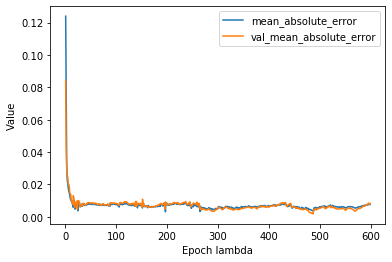

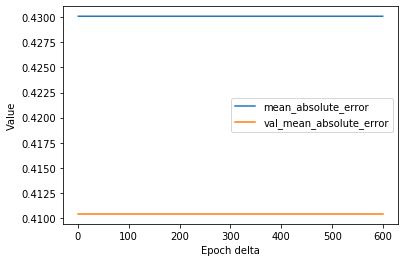

In [13]:
# Plot a graph of the metric(s) vs. epochs.
#list_of_metrics_to_plot = ['accuracy'] 
#print(hist_delta.head())
list_of_metrics_to_plot = ['mean_absolute_error',"val_mean_absolute_error"] 
plot_curve(epochs_lambda, hist_lambda, list_of_metrics_to_plot,"lambda")
plot_curve(epochs_delta, hist_delta, list_of_metrics_to_plot,"delta")

In [14]:
delta_test_result=test_model(my_model_delta,delta_test,label_delta)
delta_test_result.head(50)

[0.32808081 0.48969697 0.34626263 0.3240404  0.4169697  0.49171717
 0.40686869 0.34020202 0.50181818 0.49575758 0.41090909 0.43313131
 0.45333333 0.38868687 0.33212121]
1/1 [==============================] - ETA: 0s - loss: 0.4106 - mean_absolute_error: 0.410 - 0s 1ms/step - loss: 0.4106 - mean_absolute_error: 0.4106


delta  delta_pred
0   0.328081         0.0
1   0.489697         0.0
2   0.346263         0.0
3   0.324040         0.0
4   0.416970         0.0
5   0.491717         0.0
6   0.406869         0.0
7   0.340202         0.0
8   0.501818         0.0
9   0.495758         0.0
10  0.410909         0.0
11  0.433131         0.0
12  0.453333         0.0
13  0.388687         0.0
14  0.332121         0.0

In [11]:
lablda_test_result=test_model(my_model_lambda,lambda_test,label_lambda)
lablda_test_result.head(50)

[0.22575758 0.18030303 0.21060606 0.17424242 0.16515152 0.15757576
 0.13636364 0.22424242 0.11818182 0.1030303  0.12272727 0.14848485
 0.20606061 0.15       0.23636364 0.10606061 0.21969697 0.21818182
 0.12121212 0.1469697 ]
1/1 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.034 - 0s 2ms/step - loss: 0.0341 - mean_absolute_error: 0.0341


lambda  lambda_pred
0   0.225758     0.261644
1   0.180303     0.178690
2   0.210606     0.233993
3   0.174242     0.167304
4   0.165152     0.150497
5   0.157576     0.136400
6   0.136364     0.095736
7   0.224242     0.258933
8   0.118182     0.062594
9   0.103030     0.041196
10  0.122727     0.071084
11  0.148485     0.119050
12  0.206061     0.225860
13  0.150000     0.121761
14  0.236364     0.280621
15  0.106061     0.039411
16  0.219697     0.250801
17  0.218182     0.248090
18  0.121212     0.068088
19  0.146970     0.116339

In [15]:
MAX_TRIALS = 20

EXECUTIONS_PER_TRIAL = 3

tuner_lambda = kt.RandomSearch(

    create_model_optimizer,

    objective='val_mean_absolute_error',

    max_trials=MAX_TRIALS,

    executions_per_trial=EXECUTIONS_PER_TRIAL,

    directory='lambda_100_model_main_max',
    #overwrite = True,
    project_name='first Try',

    seed=1

)
x_train_lambda=lambda_train["main_maximum"].to_numpy()
y_train_lambda=lambda_train["lambda"].to_numpy()
x_test_lambda=lambda_test["main_maximum"].to_numpy()
y_test_lambda=lambda_test["lambda"].to_numpy()
#lambda_train, lambda_test
#delta_train, delta_test
tuner_lambda.search(x_train_lambda, y_train_lambda, epochs = 200, validation_data = (x_test_lambda, y_test_lambda))


Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1793 - mean_absolute_error: 0.179 - 0s 67ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1795 - mean_absolute_error: 0.179 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1736 - mean_absolute_error: 0.173 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1663 - mean_absolute_error: 0.166 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1747 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.1698 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.1710 - mean_absolute_error: 0.171 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.1812 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.1737 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.1775 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - m

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.1801 - mean_absolute_error: 0.180 - 0s 8ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.1696 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.1881 - mean_absolute_error: 0.188 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.1713 - mean_absolute_error: 0.171 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.1765 - mean_absolute_error: 0.176 - 0s 7ms/step - loss: 0.1766 - m

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.1950 - mean_absolute_error: 0.195 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.1714 - mean_absolute_error: 0.171 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.1820 - mean_absolute_error: 0.182 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.1784 - mean_absolute_error: 0.178 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.1601 - mean_absolute_error: 0.160 - 0s 6ms/step - loss: 0.176

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.1770 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.1791 - mean_absolute_error: 0.179 - 0s 8ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.1750 - mean_absolute_error: 0.175 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.1857 - mean_absolute_error: 0.185 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.1744 - mean_absolute_error: 0.174 - 0s 7ms/step - loss: 0.176

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.1860 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.1777 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.1693 - mean_absolute_error: 0.169 - 0s 8ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.1729 - mean_absolute_error: 0.172 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.1715 - mean_absolute_error: 0.171 - 0s 6ms/step - loss: 0.176

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.1675 - mean_absolute_error: 0.167 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.1846 - mean_absolute_error: 0.184 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.1701 - mean_absolute_error: 0.170 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.1667 - mean_absolute_error: 0.166 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.1785 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.1712 - mean_absolute_error: 0.171 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.1846 - mean_absolute_error: 0.184 - 0s 8ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.1677 - mean_absolute_error: 0.167 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.1861 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.1708 - mean_absolute_error: 0.170 - 0s 6ms/step - loss: 0.1766 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.1922 - mean_absolute_error: 0.192 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.1794 - mean_absolute_error: 0.179 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.1841 - mean_absolute_error: 0.184 - 0s 8ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.1801 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.1849 - mean_absolute_error: 0.184 - 0s 6ms/step - loss: 0.176

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.1727 - mean_absolute_error: 0.172 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.1728 - mean_absolute_error: 0.172 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.1818 - mean_absolute_error: 0.181 - 0s 8ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.1707 - mean_absolute_error: 0.170 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.1696 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.176

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.1765 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.1739 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.1677 - mean_absolute_error: 0.167 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.1706 - mean_absolute_error: 0.170 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.1816 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.176

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.0187 - mean_absolute_error: 0.018 - 0s 57ms/step - loss: 0.0199 - mean_absolute_error: 0.0199 - val_loss: 0.0163 - val_mean_absolute_error: 0.0163
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.0166 - mean_absolute_error: 0.016 - 0s 49ms/step - loss: 0.0170 - mean_absolute_error: 0.0170 - val_loss: 0.0151 - val_mean_absolute_error: 0.0151
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.0154 - mean_absolute_error: 0.015 - 0s 43ms/step - loss: 0.0159 - mean_absolute_error: 0.0159 - val_loss: 0.0142 - val_mean_absolute_error: 0.0142
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.012 - 0s 68ms/step - loss: 0.0134 - mean_absolute_error: 0.0134 - val_loss: 0.0142 - val_mean_absolute_error: 0.0142
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.013 - 0s 46ms/step - loss: 0.015

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.0157 - mean_absolute_error: 0.015 - 0s 8ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0034 - val_mean_absolute_error: 0.0034
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.003 - 0s 6ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0035 - val_mean_absolute_error: 0.0035
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.004 - 0s 6ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0084 - val_mean_absolute_error: 0.0084
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0103 - mean_absolute_error: 0.0103 - val_loss: 0.0070 - val_mean_absolute_error: 0.0070
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0090 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.004 - 0s 6ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0119 - val_mean_absolute_error: 0.0119
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.011 - 0s 8ms/step - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0044 - val_mean_absolute_error: 0.0044
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.004 - 0s 6ms/step - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0083 - val_mean_absolute_error: 0.0083
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0095 - val_mean_absolute_error: 0.0095
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0093 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0110 - val_mean_absolute_error: 0.0110
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.010 - 0s 8ms/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0019 - val_mean_absolute_error: 0.0019
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.002 - 0s 6ms/step - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0096 - val_mean_absolute_error: 0.0096
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0025 - val_mean_absolute_error: 0.0025
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.002 - 0s 6ms/step - loss: 0.006

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 7ms/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0121 - val_mean_absolute_error: 0.0121
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.011 - 0s 7ms/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0026 - val_mean_absolute_error: 0.0026
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.002 - 0s 7ms/step - loss: 0.0057 - mean_absolute_error: 0.0057 - val_loss: 0.0027 - val_mean_absolute_error: 0.0027
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.002 - 0s 8ms/step - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0125 - val_mean_absolute_error: 0.0125
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.011 - 0s 7ms/step - loss: 0.009

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1813 - mean_absolute_error: 0.181 - 0s 71ms/step - loss: 0.1725 - mean_absolute_error: 0.1725 - val_loss: 0.1600 - val_mean_absolute_error: 0.1600
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1730 - mean_absolute_error: 0.173 - 0s 68ms/step - loss: 0.1660 - mean_absolute_error: 0.1660 - val_loss: 0.1535 - val_mean_absolute_error: 0.1535
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1670 - mean_absolute_error: 0.167 - 0s 57ms/step - loss: 0.1595 - mean_absolute_error: 0.1595 - val_loss: 0.1473 - val_mean_absolute_error: 0.1473
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1498 - mean_absolute_error: 0.149 - 0s 76ms/step - loss: 0.1532 - mean_absolute_error: 0.1532 - val_loss: 0.1411 - val_mean_absolute_error: 0.1411
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1396 - mean_absolute_error: 0.139 - 0s 57ms/step - loss: 0.1471 - m

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.037 - 0s 7ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.037 - 0s 6ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0350 - val_mean_absolute_error: 0.0350
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.037 - 0s 6ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0351 - val_mean_absolute_error: 0.0351
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.038 - 0s 6ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0351 - val_mean_absolute_error: 0.0351
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.034 - 0s 7ms/step - loss: 0.0352 - m

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.032 - 0s 7ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0351 - val_mean_absolute_error: 0.0351
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.034 - 0s 7ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0350 - val_mean_absolute_error: 0.0350
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.036 - 0s 7ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.039 - 0s 7ms/step - loss: 0.0338 - m

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.026 - 0s 54ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - val_loss: 0.0253 - val_mean_absolute_error: 0.0253
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.0288 - mean_absolute_error: 0.028 - 0s 54ms/step - loss: 0.0256 - mean_absolute_error: 0.0256 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.026 - 0s 60ms/step - loss: 0.0250 - mean_absolute_error: 0.0250 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.0217 - mean_absolute_error: 0.021 - 0s 43ms/step - loss: 0.0247 - mean_absolute_error: 0.0247 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.0284 - mean_absolute_error: 0.028 - 0s 60ms/step - loss: 

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.0171 - mean_absolute_error: 0.017 - 0s 38ms/step - loss: 0.0176 - mean_absolute_error: 0.0176 - val_loss: 0.0174 - val_mean_absolute_error: 0.0174
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.0152 - mean_absolute_error: 0.015 - 0s 46ms/step - loss: 0.0175 - mean_absolute_error: 0.0175 - val_loss: 0.0173 - val_mean_absolute_error: 0.0173
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.0207 - mean_absolute_error: 0.020 - 0s 66ms/step - loss: 0.0174 - mean_absolute_error: 0.0174 - val_loss: 0.0170 - val_mean_absolute_error: 0.0170
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.0155 - mean_absolute_error: 0.015 - 0s 66ms/step - loss: 0.0172 - mean_absolute_error: 0.0172 - val_loss: 0.0169 - val_mean_absolute_error: 0.0169
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.0199 - mean_absolute_error: 0.019 - 0s 73ms/step - loss: 

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.0121 - mean_absolute_error: 0.012 - 0s 46ms/step - loss: 0.0126 - mean_absolute_error: 0.0126 - val_loss: 0.0121 - val_mean_absolute_error: 0.0121
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.013 - 0s 62ms/step - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0120 - val_mean_absolute_error: 0.0120
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.012 - 0s 7ms/step - loss: 0.0124 - mean_absolute_error: 0.0124 - val_loss: 0.0120 - val_mean_absolute_error: 0.0120
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.012 - 0s 49ms/step - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0118 - val_mean_absolute_error: 0.0118
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.014 - 0s 49ms/step - loss: 0

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.0524 - mean_absolute_error: 0.052 - 0s 6ms/step - loss: 0.0523 - mean_absolute_error: 0.0523 - val_loss: 0.0451 - val_mean_absolute_error: 0.0451
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.0587 - mean_absolute_error: 0.058 - 0s 6ms/step - loss: 0.0505 - mean_absolute_error: 0.0505 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.0502 - mean_absolute_error: 0.050 - 0s 6ms/step - loss: 0.0490 - mean_absolute_error: 0.0490 - val_loss: 0.0426 - val_mean_absolute_error: 0.0426
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.0414 - mean_absolute_error: 0.041 - 0s 6ms/step - loss: 0.0477 - mean_absolute_error: 0.0477 - val_loss: 0.0416 - val_mean_absolute_error: 0.0416
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.039 - 0s 6ms/step - loss: 0.0465 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.0420 - mean_absolute_error: 0.042 - 0s 7ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0384 - val_mean_absolute_error: 0.0384
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.035 - 0s 6ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0384 - val_mean_absolute_error: 0.0384
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.034 - 0s 6ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0384 - val_mean_absolute_error: 0.0384
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.0405 - mean_absolute_error: 0.040 - 0s 7ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0385 - val_mean_absolute_error: 0.0385
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.036 - 0s 6ms/step - loss: 0.0378 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.035 - 0s 6ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.038 - 0s 6ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.033 - 0s 6ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.034 - 0s 7ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0392 - val_mean_absolute_error: 0.0392
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.038 - 0s 6ms/step - loss: 0.037

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.036 - 0s 7ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0390 - val_mean_absolute_error: 0.0390
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.0406 - mean_absolute_error: 0.040 - 0s 6ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0390 - val_mean_absolute_error: 0.0390
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.032 - 0s 7ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0390 - val_mean_absolute_error: 0.0390
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.0384 - mean_absolute_error: 0.038 - 0s 6ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0391 - val_mean_absolute_error: 0.0391
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.037 - 0s 6ms/step - loss: 0.037

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.0429 - mean_absolute_error: 0.042 - 0s 7ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.032 - 0s 6ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.0409 - mean_absolute_error: 0.040 - 0s 6ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0392 - val_mean_absolute_error: 0.0392
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.039 - 0s 6ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0392 - val_mean_absolute_error: 0.0392
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.036 - 0s 6ms/step - loss: 0.037

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.037 - 0s 6ms/step - loss: 0.0391 - mean_absolute_error: 0.0391 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.037 - 0s 7ms/step - loss: 0.0379 - mean_absolute_error: 0.0379 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.0405 - mean_absolute_error: 0.040 - 0s 6ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.037 - 0s 6ms/step - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.035 - 0s 6ms/step - loss: 0.0356 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.031 - 0s 6ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.035 - 0s 7ms/step - loss: 0.0333 - mean_absolute_error: 0.0333 - val_loss: 0.0348 - val_mean_absolute_error: 0.0348
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.032 - 0s 6ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.034 - 0s 6ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0350 - val_mean_absolute_error: 0.0350
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.0277 - mean_absolute_error: 0.027 - 0s 6ms/step - loss: 0.0334 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.033 - 0s 7ms/step - loss: 0.0332 - mean_absolute_error: 0.0332 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.038 - 0s 7ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.035 - 0s 7ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0343 - val_mean_absolute_error: 0.0343
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.032 - 0s 6ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.038 - 0s 7ms/step - loss: 0.0331 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.033 - 0s 8ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.0289 - mean_absolute_error: 0.028 - 0s 6ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0339 - val_mean_absolute_error: 0.0339
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.036 - 0s 6ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0339 - val_mean_absolute_error: 0.0339
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.031 - 0s 6ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0339 - val_mean_absolute_error: 0.0339
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.035 - 0s 6ms/step - loss: 0.032

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.034 - 0s 8ms/step - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0336 - val_mean_absolute_error: 0.0336
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.0289 - mean_absolute_error: 0.028 - 0s 7ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0336 - val_mean_absolute_error: 0.0336
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.032 - 0s 6ms/step - loss: 0.0323 - mean_absolute_error: 0.0323 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.0283 - mean_absolute_error: 0.028 - 0s 6ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.0286 - mean_absolute_error: 0.028 - 0s 6ms/step - loss: 0.032

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1354 - mean_absolute_error: 0.135 - 0s 63ms/step - loss: 0.1090 - mean_absolute_error: 0.1090 - val_loss: 0.0161 - val_mean_absolute_error: 0.0161
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.0200 - mean_absolute_error: 0.020 - 0s 57ms/step - loss: 0.0206 - mean_absolute_error: 0.0206 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.010 - 0s 50ms/step - loss: 0.0111 - mean_absolute_error: 0.0111 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.006 - 0s 50ms/step - loss: 0.0113 - mean_absolute_error: 0.0113 - val_loss: 0.0066 - val_mean_absolute_error: 0.0066
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0141 - me

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0165 - val_mean_absolute_error: 0.0165
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.0168 - mean_absolute_error: 0.016 - 0s 7ms/step - loss: 0.0142 - mean_absolute_error: 0.0142 - val_loss: 0.0143 - val_mean_absolute_error: 0.0143
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.014 - 0s 6ms/step - loss: 0.0119 - mean_absolute_error: 0.0119 - val_loss: 0.0195 - val_mean_absolute_error: 0.0195
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.0192 - mean_absolute_error: 0.019 - 0s 6ms/step - loss: 0.0145 - mean_absolute_error: 0.0145 - val_loss: 0.0116 - val_mean_absolute_error: 0.0116
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0131 - m

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.012 - 0s 8ms/step - loss: 0.0137 - mean_absolute_error: 0.0137 - val_loss: 0.0123 - val_mean_absolute_error: 0.0123
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.010 - 0s 7ms/step - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0113 - val_mean_absolute_error: 0.0113
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.0135 - mean_absolute_error: 0.0135 - val_loss: 0.0083 - val_mean_absolute_error: 0.0083
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0113 - mean_absolute_error: 0.0113 - val_loss: 0.0127 - val_mean_absolute_error: 0.0127
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.0136 - m

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.0120 - mean_absolute_error: 0.012 - 0s 8ms/step - loss: 0.0132 - mean_absolute_error: 0.0132 - val_loss: 0.0143 - val_mean_absolute_error: 0.0143
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0137 - val_mean_absolute_error: 0.0137
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.013 - 0s 7ms/step - loss: 0.0111 - mean_absolute_error: 0.0111 - val_loss: 0.0123 - val_mean_absolute_error: 0.0123
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0100 - mean_absolute_error: 0.0100 - val_loss: 0.0046 - val_mean_absolute_error: 0.0046
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.010

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.012 - 0s 8ms/step - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0127 - val_mean_absolute_error: 0.0127
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.011 - 0s 7ms/step - loss: 0.0124 - mean_absolute_error: 0.0124 - val_loss: 0.0127 - val_mean_absolute_error: 0.0127
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.0126 - mean_absolute_error: 0.0126 - val_loss: 0.0173 - val_mean_absolute_error: 0.0173
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.0173 - mean_absolute_error: 0.017 - 0s 7ms/step - loss: 0.0135 - mean_absolute_error: 0.0135 - val_loss: 0.0085 - val_mean_absolute_error: 0.0085
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.012

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.013 - 0s 7ms/step - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0110 - val_mean_absolute_error: 0.0110
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.010 - 0s 9ms/step - loss: 0.0119 - mean_absolute_error: 0.0119 - val_loss: 0.0063 - val_mean_absolute_error: 0.0063
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.007 - 0s 7ms/step - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0148 - val_mean_absolute_error: 0.0148
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.014 - 0s 7ms/step - loss: 0.0132 - mean_absolute_error: 0.0132 - val_loss: 0.0104 - val_mean_absolute_error: 0.0104
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.010 - 0s 7ms/step - loss: 0.011

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.1864 - mean_absolute_error: 0.186 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.1715 - mean_absolute_error: 0.171 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.1800 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.1838 - mean_absolute_error: 0.183 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.1705 - mean_absolute_error: 0.170 - 0s 6ms/step - loss: 0.1766 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.1752 - mean_absolute_error: 0.175 - 0s 8ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.1891 - mean_absolute_error: 0.189 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.1764 - mean_absolute_error: 0.176 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.1866 - mean_absolute_error: 0.186 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.1826 - mean_absolute_error: 0.182 - 0s 6ms/step - loss: 0.1766 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.1693 - mean_absolute_error: 0.169 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.1739 - mean_absolute_error: 0.173 - 0s 9ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.1739 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.1775 - mean_absolute_error: 0.177 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.1795 - mean_absolute_error: 0.179 - 0s 7ms/step - loss: 0.176

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.1759 - mean_absolute_error: 0.175 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.1663 - mean_absolute_error: 0.166 - 0s 8ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.1737 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.1757 - mean_absolute_error: 0.175 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.1712 - mean_absolute_error: 0.171 - 0s 7ms/step - loss: 0.176

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.1816 - mean_absolute_error: 0.181 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.1599 - mean_absolute_error: 0.159 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.1723 - mean_absolute_error: 0.172 - 0s 9ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.1726 - mean_absolute_error: 0.172 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.1737 - mean_absolute_error: 0.173 - 0s 7ms/step - loss: 0.176

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.0152 - mean_absolute_error: 0.015 - 0s 9ms/step - loss: 0.0117 - mean_absolute_error: 0.0117 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0154 - val_mean_absolute_error: 0.0154
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0071 - val_mean_absolute_error: 0.0071
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0142 - val_mean_absolute_error: 0.0142
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.013 - 0s 7ms/step - loss: 0.0115 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.008 - 0s 7ms/step - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0107 - val_mean_absolute_error: 0.0107
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0073 - val_mean_absolute_error: 0.0073
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0095 - mean_absolute_error: 0.0095 - val_loss: 0.0151 - val_mean_absolute_error: 0.0151
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.0154 - mean_absolute_error: 0.015 - 0s 6ms/step - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0045 - val_mean_absolute_error: 0.0045
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.0099 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.005 - 0s 8ms/step - loss: 0.0089 - mean_absolute_error: 0.0089 - val_loss: 0.0158 - val_mean_absolute_error: 0.0158
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.0154 - mean_absolute_error: 0.015 - 0s 6ms/step - loss: 0.0110 - mean_absolute_error: 0.0110 - val_loss: 0.0062 - val_mean_absolute_error: 0.0062
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0143 - val_mean_absolute_error: 0.0143
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.013 - 0s 7ms/step - loss: 0.0107 - mean_absolute_error: 0.0107 - val_loss: 0.0062 - val_mean_absolute_error: 0.0062
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0082 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0144 - val_mean_absolute_error: 0.0144
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.014 - 0s 7ms/step - loss: 0.0107 - mean_absolute_error: 0.0107 - val_loss: 0.0052 - val_mean_absolute_error: 0.0052
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.0094 - mean_absolute_error: 0.0094 - val_loss: 0.0153 - val_mean_absolute_error: 0.0153
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.0150 - mean_absolute_error: 0.015 - 0s 6ms/step - loss: 0.0111 - mean_absolute_error: 0.0111 - val_loss: 0.0055 - val_mean_absolute_error: 0.0055
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.010

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0123 - val_mean_absolute_error: 0.0123
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0106 - mean_absolute_error: 0.0106 - val_loss: 0.0052 - val_mean_absolute_error: 0.0052
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.006 - 0s 7ms/step - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0136 - val_mean_absolute_error: 0.0136
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.0102 - mean_absolute_error: 0.0102 - val_loss: 0.0064 - val_mean_absolute_error: 0.0064
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.010

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1728 - mean_absolute_error: 0.172 - 0s 77ms/step - loss: 0.1762 - mean_absolute_error: 0.1762 - val_loss: 0.1676 - val_mean_absolute_error: 0.1676
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1785 - mean_absolute_error: 0.178 - 0s 51ms/step - loss: 0.1754 - mean_absolute_error: 0.1754 - val_loss: 0.1667 - val_mean_absolute_error: 0.1667
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1758 - mean_absolute_error: 0.175 - 0s 51ms/step - loss: 0.1745 - mean_absolute_error: 0.1745 - val_loss: 0.1659 - val_mean_absolute_error: 0.1659
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1777 - mean_absolute_error: 0.177 - 0s 43ms/step - loss: 0.1737 - mean_absolute_error: 0.1737 - val_loss: 0.1651 - val_mean_absolute_error: 0.1651
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1630 - mean_absolute_error: 0.163 - 0s 40ms/step - loss: 0.1729 - m

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.1451 - mean_absolute_error: 0.145 - 0s 57ms/step - loss: 0.1473 - mean_absolute_error: 0.1473 - val_loss: 0.1390 - val_mean_absolute_error: 0.1390
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.1497 - mean_absolute_error: 0.149 - 0s 97ms/step - loss: 0.1466 - mean_absolute_error: 0.1466 - val_loss: 0.1383 - val_mean_absolute_error: 0.1383
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.1416 - mean_absolute_error: 0.141 - 0s 90ms/step - loss: 0.1459 - mean_absolute_error: 0.1459 - val_loss: 0.1376 - val_mean_absolute_error: 0.1376
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.1380 - mean_absolute_error: 0.138 - 0s 46ms/step - loss: 0.1452 - mean_absolute_error: 0.1452 - val_loss: 0.1369 - val_mean_absolute_error: 0.1369
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.1426 - mean_absolute_error: 0.142 - 0s 38ms/step - loss: 0.144

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.1175 - mean_absolute_error: 0.117 - 0s 37ms/step - loss: 0.1190 - mean_absolute_error: 0.1190 - val_loss: 0.1108 - val_mean_absolute_error: 0.1108
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.1303 - mean_absolute_error: 0.130 - 0s 41ms/step - loss: 0.1182 - mean_absolute_error: 0.1182 - val_loss: 0.1100 - val_mean_absolute_error: 0.1100
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.1157 - mean_absolute_error: 0.115 - 0s 40ms/step - loss: 0.1175 - mean_absolute_error: 0.1175 - val_loss: 0.1093 - val_mean_absolute_error: 0.1093
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.1187 - mean_absolute_error: 0.118 - 0s 68ms/step - loss: 0.1167 - mean_absolute_error: 0.1167 - val_loss: 0.1085 - val_mean_absolute_error: 0.1085
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.1187 - mean_absolute_error: 0.118 - 0s 49ms/step - loss: 0.116

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.0834 - mean_absolute_error: 0.083 - 0s 62ms/step - loss: 0.0905 - mean_absolute_error: 0.0905 - val_loss: 0.0824 - val_mean_absolute_error: 0.0824
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.0868 - mean_absolute_error: 0.086 - 0s 60ms/step - loss: 0.0898 - mean_absolute_error: 0.0898 - val_loss: 0.0817 - val_mean_absolute_error: 0.0817
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.088 - 0s 68ms/step - loss: 0.0890 - mean_absolute_error: 0.0890 - val_loss: 0.0809 - val_mean_absolute_error: 0.0809
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.0859 - mean_absolute_error: 0.085 - 0s 43ms/step - loss: 0.0883 - mean_absolute_error: 0.0883 - val_loss: 0.0802 - val_mean_absolute_error: 0.0802
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.0883 - mean_absolute_error: 0.088 - 0s 63ms/step - loss: 

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.0724 - mean_absolute_error: 0.072 - 0s 93ms/step - loss: 0.0629 - mean_absolute_error: 0.0629 - val_loss: 0.0552 - val_mean_absolute_error: 0.0552
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.061 - 0s 60ms/step - loss: 0.0623 - mean_absolute_error: 0.0623 - val_loss: 0.0546 - val_mean_absolute_error: 0.0546
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.0656 - mean_absolute_error: 0.065 - 0s 65ms/step - loss: 0.0617 - mean_absolute_error: 0.0617 - val_loss: 0.0541 - val_mean_absolute_error: 0.0541
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.0626 - mean_absolute_error: 0.062 - 0s 48ms/step - loss: 0.0611 - mean_absolute_error: 0.0611 - val_loss: 0.0536 - val_mean_absolute_error: 0.0536
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.0581 - mean_absolute_error: 0.058 - 0s 68ms/step - loss: 

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.035 - 0s 71ms/step - loss: 0.0468 - mean_absolute_error: 0.0468 - val_loss: 0.0411 - val_mean_absolute_error: 0.0411
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.0478 - mean_absolute_error: 0.047 - 0s 40ms/step - loss: 0.0465 - mean_absolute_error: 0.0465 - val_loss: 0.0409 - val_mean_absolute_error: 0.0409
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.0425 - mean_absolute_error: 0.042 - 0s 46ms/step - loss: 0.0463 - mean_absolute_error: 0.0463 - val_loss: 0.0407 - val_mean_absolute_error: 0.0407
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.0503 - mean_absolute_error: 0.050 - 0s 51ms/step - loss: 0.0460 - mean_absolute_error: 0.0460 - val_loss: 0.0405 - val_mean_absolute_error: 0.0405
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.0475 - mean_absolute_error: 0.047 - 0s 41ms/step - loss: 

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.1460 - mean_absolute_error: 0.146 - 0s 6ms/step - loss: 0.1457 - mean_absolute_error: 0.1457 - val_loss: 0.1373 - val_mean_absolute_error: 0.1373
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.1439 - mean_absolute_error: 0.143 - 0s 6ms/step - loss: 0.1446 - mean_absolute_error: 0.1446 - val_loss: 0.1362 - val_mean_absolute_error: 0.1362
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.1492 - mean_absolute_error: 0.149 - 0s 6ms/step - loss: 0.1436 - mean_absolute_error: 0.1436 - val_loss: 0.1352 - val_mean_absolute_error: 0.1352
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.1531 - mean_absolute_error: 0.153 - 0s 6ms/step - loss: 0.1425 - mean_absolute_error: 0.1425 - val_loss: 0.1341 - val_mean_absolute_error: 0.1341
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.1467 - mean_absolute_error: 0.146 - 0s 6ms/step - loss: 0.1414 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.1054 - mean_absolute_error: 0.105 - 0s 6ms/step - loss: 0.1048 - mean_absolute_error: 0.1048 - val_loss: 0.0967 - val_mean_absolute_error: 0.0967
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.0991 - mean_absolute_error: 0.099 - 0s 6ms/step - loss: 0.1037 - mean_absolute_error: 0.1037 - val_loss: 0.0956 - val_mean_absolute_error: 0.0956
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.0996 - mean_absolute_error: 0.099 - 0s 6ms/step - loss: 0.1026 - mean_absolute_error: 0.1026 - val_loss: 0.0946 - val_mean_absolute_error: 0.0946
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.1115 - mean_absolute_error: 0.111 - 0s 6ms/step - loss: 0.1016 - mean_absolute_error: 0.1016 - val_loss: 0.0935 - val_mean_absolute_error: 0.0935
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.1046 - mean_absolute_error: 0.104 - 0s 6ms/step - loss: 0.1005 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.0607 - mean_absolute_error: 0.060 - 0s 6ms/step - loss: 0.0652 - mean_absolute_error: 0.0652 - val_loss: 0.0571 - val_mean_absolute_error: 0.0571
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.0642 - mean_absolute_error: 0.064 - 0s 6ms/step - loss: 0.0642 - mean_absolute_error: 0.0642 - val_loss: 0.0563 - val_mean_absolute_error: 0.0563
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.0605 - mean_absolute_error: 0.060 - 0s 6ms/step - loss: 0.0633 - mean_absolute_error: 0.0633 - val_loss: 0.0554 - val_mean_absolute_error: 0.0554
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.0633 - mean_absolute_error: 0.063 - 0s 6ms/step - loss: 0.0623 - mean_absolute_error: 0.0623 - val_loss: 0.0545 - val_mean_absolute_error: 0.0545
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.0532 - mean_absolute_error: 0.053 - 0s 6ms/step - loss: 0.061

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.044 - 0s 49ms/step - loss: 0.0416 - mean_absolute_error: 0.0416 - val_loss: 0.0365 - val_mean_absolute_error: 0.0365
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.0462 - mean_absolute_error: 0.046 - 0s 52ms/step - loss: 0.0413 - mean_absolute_error: 0.0413 - val_loss: 0.0362 - val_mean_absolute_error: 0.0362
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.0460 - mean_absolute_error: 0.046 - 0s 65ms/step - loss: 0.0410 - mean_absolute_error: 0.0410 - val_loss: 0.0360 - val_mean_absolute_error: 0.0360
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.037 - 0s 52ms/step - loss: 0.0407 - mean_absolute_error: 0.0407 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.0440 - mean_absolute_error: 0.044 - 0s 52ms/step - loss: 

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.034 - 0s 54ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.033 - 0s 65ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0311 - val_mean_absolute_error: 0.0311
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.0307 - mean_absolute_error: 0.030 - 0s 46ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0311 - val_mean_absolute_error: 0.0311
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.034 - 0s 46ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0311 - val_mean_absolute_error: 0.0311
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.035 - 0s 51ms/step - loss: 

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.1578 - mean_absolute_error: 0.157 - 0s 6ms/step - loss: 0.1537 - mean_absolute_error: 0.1537 - val_loss: 0.1458 - val_mean_absolute_error: 0.1458
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.1554 - mean_absolute_error: 0.155 - 0s 6ms/step - loss: 0.1528 - mean_absolute_error: 0.1528 - val_loss: 0.1450 - val_mean_absolute_error: 0.1450
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.1395 - mean_absolute_error: 0.139 - 0s 6ms/step - loss: 0.1520 - mean_absolute_error: 0.1520 - val_loss: 0.1441 - val_mean_absolute_error: 0.1441
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.1473 - mean_absolute_error: 0.147 - 0s 6ms/step - loss: 0.1511 - mean_absolute_error: 0.1511 - val_loss: 0.1433 - val_mean_absolute_error: 0.1433
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.1540 - mean_absolute_error: 0.154 - 0s 6ms/step - loss: 0.1503 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.1211 - mean_absolute_error: 0.121 - 0s 6ms/step - loss: 0.1195 - mean_absolute_error: 0.1195 - val_loss: 0.1117 - val_mean_absolute_error: 0.1117
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.1295 - mean_absolute_error: 0.129 - 0s 6ms/step - loss: 0.1186 - mean_absolute_error: 0.1186 - val_loss: 0.1108 - val_mean_absolute_error: 0.1108
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.1057 - mean_absolute_error: 0.105 - 0s 6ms/step - loss: 0.1177 - mean_absolute_error: 0.1177 - val_loss: 0.1098 - val_mean_absolute_error: 0.1098
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.1164 - mean_absolute_error: 0.116 - 0s 6ms/step - loss: 0.1167 - mean_absolute_error: 0.1167 - val_loss: 0.1089 - val_mean_absolute_error: 0.1089
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.1177 - mean_absolute_error: 0.117 - 0s 6ms/step - loss: 0.1158 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.0792 - mean_absolute_error: 0.079 - 0s 6ms/step - loss: 0.0845 - mean_absolute_error: 0.0845 - val_loss: 0.0768 - val_mean_absolute_error: 0.0768
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.0839 - mean_absolute_error: 0.083 - 0s 6ms/step - loss: 0.0836 - mean_absolute_error: 0.0836 - val_loss: 0.0759 - val_mean_absolute_error: 0.0759
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.0824 - mean_absolute_error: 0.082 - 0s 6ms/step - loss: 0.0827 - mean_absolute_error: 0.0827 - val_loss: 0.0749 - val_mean_absolute_error: 0.0749
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.0777 - mean_absolute_error: 0.077 - 0s 6ms/step - loss: 0.0817 - mean_absolute_error: 0.0817 - val_loss: 0.0740 - val_mean_absolute_error: 0.0740
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.0880 - mean_absolute_error: 0.088 - 0s 6ms/step - loss: 0.0808 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.0555 - mean_absolute_error: 0.055 - 0s 6ms/step - loss: 0.0525 - mean_absolute_error: 0.0525 - val_loss: 0.0456 - val_mean_absolute_error: 0.0456
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.0519 - mean_absolute_error: 0.051 - 0s 6ms/step - loss: 0.0520 - mean_absolute_error: 0.0520 - val_loss: 0.0450 - val_mean_absolute_error: 0.0450
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.0520 - mean_absolute_error: 0.052 - 0s 6ms/step - loss: 0.0514 - mean_absolute_error: 0.0514 - val_loss: 0.0445 - val_mean_absolute_error: 0.0445
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.0575 - mean_absolute_error: 0.057 - 0s 6ms/step - loss: 0.0509 - mean_absolute_error: 0.0509 - val_loss: 0.0440 - val_mean_absolute_error: 0.0440
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.0544 - mean_absolute_error: 0.054 - 0s 6ms/step - loss: 0.050

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.0424 - mean_absolute_error: 0.042 - 0s 7ms/step - loss: 0.0387 - mean_absolute_error: 0.0387 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.039 - 0s 6ms/step - loss: 0.0385 - mean_absolute_error: 0.0385 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.033 - 0s 5ms/step - loss: 0.0383 - mean_absolute_error: 0.0383 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.032 - 0s 6ms/step - loss: 0.0381 - mean_absolute_error: 0.0381 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.038 - 0s 6ms/step - loss: 0.037

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1520 - mean_absolute_error: 0.152 - 0s 67ms/step - loss: 0.1543 - mean_absolute_error: 0.1543 - val_loss: 0.1481 - val_mean_absolute_error: 0.1481
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1463 - mean_absolute_error: 0.146 - 0s 49ms/step - loss: 0.1534 - mean_absolute_error: 0.1534 - val_loss: 0.1472 - val_mean_absolute_error: 0.1472
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1430 - mean_absolute_error: 0.143 - 0s 54ms/step - loss: 0.1525 - mean_absolute_error: 0.1525 - val_loss: 0.1463 - val_mean_absolute_error: 0.1463
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1478 - mean_absolute_error: 0.147 - 0s 57ms/step - loss: 0.1516 - mean_absolute_error: 0.1516 - val_loss: 0.1454 - val_mean_absolute_error: 0.1454
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1576 - mean_absolute_error: 0.157 - 0s 49ms/step - loss: 0.1506 - m

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.1233 - mean_absolute_error: 0.123 - 0s 57ms/step - loss: 0.1206 - mean_absolute_error: 0.1206 - val_loss: 0.1147 - val_mean_absolute_error: 0.1147
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.1209 - mean_absolute_error: 0.120 - 0s 62ms/step - loss: 0.1198 - mean_absolute_error: 0.1198 - val_loss: 0.1139 - val_mean_absolute_error: 0.1139
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.1178 - mean_absolute_error: 0.117 - 0s 57ms/step - loss: 0.1189 - mean_absolute_error: 0.1189 - val_loss: 0.1130 - val_mean_absolute_error: 0.1130
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.1165 - mean_absolute_error: 0.116 - 0s 40ms/step - loss: 0.1180 - mean_absolute_error: 0.1180 - val_loss: 0.1121 - val_mean_absolute_error: 0.1121
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.1175 - mean_absolute_error: 0.117 - 0s 76ms/step - loss: 0.117

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.0894 - mean_absolute_error: 0.089 - 0s 41ms/step - loss: 0.0880 - mean_absolute_error: 0.0880 - val_loss: 0.0822 - val_mean_absolute_error: 0.0822
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.0867 - mean_absolute_error: 0.086 - 0s 85ms/step - loss: 0.0871 - mean_absolute_error: 0.0871 - val_loss: 0.0814 - val_mean_absolute_error: 0.0814
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.0899 - mean_absolute_error: 0.089 - 0s 46ms/step - loss: 0.0862 - mean_absolute_error: 0.0862 - val_loss: 0.0805 - val_mean_absolute_error: 0.0805
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.0848 - mean_absolute_error: 0.084 - 0s 49ms/step - loss: 0.0854 - mean_absolute_error: 0.0854 - val_loss: 0.0797 - val_mean_absolute_error: 0.0797
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.0843 - mean_absolute_error: 0.084 - 0s 48ms/step - loss: 0.084

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.0490 - mean_absolute_error: 0.049 - 0s 63ms/step - loss: 0.0554 - mean_absolute_error: 0.0554 - val_loss: 0.0497 - val_mean_absolute_error: 0.0497
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.0582 - mean_absolute_error: 0.058 - 0s 58ms/step - loss: 0.0545 - mean_absolute_error: 0.0545 - val_loss: 0.0489 - val_mean_absolute_error: 0.0489
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.0544 - mean_absolute_error: 0.054 - 0s 53ms/step - loss: 0.0536 - mean_absolute_error: 0.0536 - val_loss: 0.0480 - val_mean_absolute_error: 0.0480
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.0499 - mean_absolute_error: 0.049 - 0s 54ms/step - loss: 0.0528 - mean_absolute_error: 0.0528 - val_loss: 0.0472 - val_mean_absolute_error: 0.0472
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.0507 - mean_absolute_error: 0.050 - 0s 57ms/step - loss: 

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.0310 - mean_absolute_error: 0.031 - 0s 50ms/step - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.0269 - val_mean_absolute_error: 0.0269
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.031 - 0s 47ms/step - loss: 0.0305 - mean_absolute_error: 0.0305 - val_loss: 0.0266 - val_mean_absolute_error: 0.0266
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.033 - 0s 60ms/step - loss: 0.0302 - mean_absolute_error: 0.0302 - val_loss: 0.0264 - val_mean_absolute_error: 0.0264
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.0318 - mean_absolute_error: 0.031 - 0s 71ms/step - loss: 0.0299 - mean_absolute_error: 0.0299 - val_loss: 0.0262 - val_mean_absolute_error: 0.0262
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.035 - 0s 52ms/step - loss: 

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.0221 - mean_absolute_error: 0.022 - 0s 54ms/step - loss: 0.0240 - mean_absolute_error: 0.0240 - val_loss: 0.0217 - val_mean_absolute_error: 0.0217
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.0259 - mean_absolute_error: 0.025 - 0s 46ms/step - loss: 0.0239 - mean_absolute_error: 0.0239 - val_loss: 0.0217 - val_mean_absolute_error: 0.0217
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.0229 - mean_absolute_error: 0.022 - 0s 46ms/step - loss: 0.0238 - mean_absolute_error: 0.0238 - val_loss: 0.0216 - val_mean_absolute_error: 0.0216
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.0262 - mean_absolute_error: 0.026 - 0s 52ms/step - loss: 0.0237 - mean_absolute_error: 0.0237 - val_loss: 0.0216 - val_mean_absolute_error: 0.0216
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.023 - 0s 60ms/step - loss: 

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.1434 - mean_absolute_error: 0.143 - 0s 6ms/step - loss: 0.1475 - mean_absolute_error: 0.1475 - val_loss: 0.1395 - val_mean_absolute_error: 0.1395
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.1497 - mean_absolute_error: 0.149 - 0s 6ms/step - loss: 0.1466 - mean_absolute_error: 0.1466 - val_loss: 0.1387 - val_mean_absolute_error: 0.1387
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.1443 - mean_absolute_error: 0.144 - 0s 6ms/step - loss: 0.1458 - mean_absolute_error: 0.1458 - val_loss: 0.1379 - val_mean_absolute_error: 0.1379
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.1458 - mean_absolute_error: 0.145 - 0s 6ms/step - loss: 0.1450 - mean_absolute_error: 0.1450 - val_loss: 0.1370 - val_mean_absolute_error: 0.1370
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.1397 - mean_absolute_error: 0.139 - 0s 6ms/step - loss: 0.1441 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.1176 - mean_absolute_error: 0.117 - 0s 6ms/step - loss: 0.1167 - mean_absolute_error: 0.1167 - val_loss: 0.1090 - val_mean_absolute_error: 0.1090
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.1114 - mean_absolute_error: 0.111 - 0s 6ms/step - loss: 0.1159 - mean_absolute_error: 0.1159 - val_loss: 0.1083 - val_mean_absolute_error: 0.1083
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.1085 - mean_absolute_error: 0.108 - 0s 6ms/step - loss: 0.1151 - mean_absolute_error: 0.1151 - val_loss: 0.1075 - val_mean_absolute_error: 0.1075
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.1182 - mean_absolute_error: 0.118 - 0s 6ms/step - loss: 0.1143 - mean_absolute_error: 0.1143 - val_loss: 0.1067 - val_mean_absolute_error: 0.1067
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.1076 - mean_absolute_error: 0.107 - 0s 6ms/step - loss: 0.1135 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.0854 - mean_absolute_error: 0.085 - 0s 7ms/step - loss: 0.0870 - mean_absolute_error: 0.0870 - val_loss: 0.0798 - val_mean_absolute_error: 0.0798
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.0879 - mean_absolute_error: 0.087 - 0s 6ms/step - loss: 0.0862 - mean_absolute_error: 0.0862 - val_loss: 0.0790 - val_mean_absolute_error: 0.0790
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.0834 - mean_absolute_error: 0.083 - 0s 6ms/step - loss: 0.0854 - mean_absolute_error: 0.0854 - val_loss: 0.0782 - val_mean_absolute_error: 0.0782
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.0867 - mean_absolute_error: 0.086 - 0s 6ms/step - loss: 0.0847 - mean_absolute_error: 0.0847 - val_loss: 0.0775 - val_mean_absolute_error: 0.0775
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.0761 - mean_absolute_error: 0.076 - 0s 6ms/step - loss: 0.083

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.0588 - mean_absolute_error: 0.058 - 0s 7ms/step - loss: 0.0578 - mean_absolute_error: 0.0578 - val_loss: 0.0508 - val_mean_absolute_error: 0.0508
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.0533 - mean_absolute_error: 0.053 - 0s 6ms/step - loss: 0.0571 - mean_absolute_error: 0.0571 - val_loss: 0.0502 - val_mean_absolute_error: 0.0502
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.0634 - mean_absolute_error: 0.063 - 0s 6ms/step - loss: 0.0565 - mean_absolute_error: 0.0565 - val_loss: 0.0495 - val_mean_absolute_error: 0.0495
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.0535 - mean_absolute_error: 0.053 - 0s 6ms/step - loss: 0.0558 - mean_absolute_error: 0.0558 - val_loss: 0.0489 - val_mean_absolute_error: 0.0489
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.0498 - mean_absolute_error: 0.049 - 0s 6ms/step - loss: 0.055

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.036 - 0s 6ms/step - loss: 0.0391 - mean_absolute_error: 0.0391 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.033 - 0s 8ms/step - loss: 0.0387 - mean_absolute_error: 0.0387 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.034 - 0s 6ms/step - loss: 0.0385 - mean_absolute_error: 0.0385 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.038 - 0s 7ms/step - loss: 0.0382 - mean_absolute_error: 0.0382 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.038 - 0s 6ms/step - loss: 0.037

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.1557 - mean_absolute_error: 0.155 - 0s 6ms/step - loss: 0.1543 - mean_absolute_error: 0.1543 - val_loss: 0.1464 - val_mean_absolute_error: 0.1464
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.1501 - mean_absolute_error: 0.150 - 0s 6ms/step - loss: 0.1534 - mean_absolute_error: 0.1534 - val_loss: 0.1456 - val_mean_absolute_error: 0.1456
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.1575 - mean_absolute_error: 0.157 - 0s 6ms/step - loss: 0.1525 - mean_absolute_error: 0.1525 - val_loss: 0.1447 - val_mean_absolute_error: 0.1447
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.1459 - mean_absolute_error: 0.145 - 0s 6ms/step - loss: 0.1516 - mean_absolute_error: 0.1516 - val_loss: 0.1438 - val_mean_absolute_error: 0.1438
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.1424 - mean_absolute_error: 0.142 - 0s 6ms/step - loss: 0.1507 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.1304 - mean_absolute_error: 0.130 - 0s 7ms/step - loss: 0.1224 - mean_absolute_error: 0.1224 - val_loss: 0.1155 - val_mean_absolute_error: 0.1155
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.1220 - mean_absolute_error: 0.122 - 0s 6ms/step - loss: 0.1217 - mean_absolute_error: 0.1217 - val_loss: 0.1148 - val_mean_absolute_error: 0.1148
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.1256 - mean_absolute_error: 0.125 - 0s 6ms/step - loss: 0.1209 - mean_absolute_error: 0.1209 - val_loss: 0.1140 - val_mean_absolute_error: 0.1140
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.1220 - mean_absolute_error: 0.122 - 0s 6ms/step - loss: 0.1201 - mean_absolute_error: 0.1201 - val_loss: 0.1133 - val_mean_absolute_error: 0.1133
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.1181 - mean_absolute_error: 0.118 - 0s 6ms/step - loss: 0.1193 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.0912 - mean_absolute_error: 0.091 - 0s 7ms/step - loss: 0.0938 - mean_absolute_error: 0.0938 - val_loss: 0.0878 - val_mean_absolute_error: 0.0878
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.0924 - mean_absolute_error: 0.092 - 0s 6ms/step - loss: 0.0931 - mean_absolute_error: 0.0931 - val_loss: 0.0871 - val_mean_absolute_error: 0.0871
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.0893 - mean_absolute_error: 0.089 - 0s 6ms/step - loss: 0.0923 - mean_absolute_error: 0.0923 - val_loss: 0.0864 - val_mean_absolute_error: 0.0864
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.0864 - mean_absolute_error: 0.086 - 0s 6ms/step - loss: 0.0916 - mean_absolute_error: 0.0916 - val_loss: 0.0857 - val_mean_absolute_error: 0.0857
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.0911 - mean_absolute_error: 0.091 - 0s 6ms/step - loss: 0.0909 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.0661 - mean_absolute_error: 0.066 - 0s 6ms/step - loss: 0.0668 - mean_absolute_error: 0.0668 - val_loss: 0.0613 - val_mean_absolute_error: 0.0613
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.0646 - mean_absolute_error: 0.064 - 0s 8ms/step - loss: 0.0661 - mean_absolute_error: 0.0661 - val_loss: 0.0606 - val_mean_absolute_error: 0.0606
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.0661 - mean_absolute_error: 0.066 - 0s 6ms/step - loss: 0.0654 - mean_absolute_error: 0.0654 - val_loss: 0.0599 - val_mean_absolute_error: 0.0599
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.0601 - mean_absolute_error: 0.060 - 0s 6ms/step - loss: 0.0647 - mean_absolute_error: 0.0647 - val_loss: 0.0592 - val_mean_absolute_error: 0.0592
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.0576 - mean_absolute_error: 0.057 - 0s 6ms/step - loss: 0.064

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.0441 - mean_absolute_error: 0.044 - 0s 6ms/step - loss: 0.0406 - mean_absolute_error: 0.0406 - val_loss: 0.0354 - val_mean_absolute_error: 0.0354
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.034 - 0s 6ms/step - loss: 0.0400 - mean_absolute_error: 0.0400 - val_loss: 0.0348 - val_mean_absolute_error: 0.0348
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.035 - 0s 8ms/step - loss: 0.0393 - mean_absolute_error: 0.0393 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.0456 - mean_absolute_error: 0.045 - 0s 6ms/step - loss: 0.0387 - mean_absolute_error: 0.0387 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.036 - 0s 6ms/step - loss: 0.038

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1820 - mean_absolute_error: 0.182 - 0s 65ms/step - loss: 0.1765 - mean_absolute_error: 0.1765 - val_loss: 0.1684 - val_mean_absolute_error: 0.1684
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1903 - mean_absolute_error: 0.190 - 0s 43ms/step - loss: 0.1765 - mean_absolute_error: 0.1765 - val_loss: 0.1684 - val_mean_absolute_error: 0.1684
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1741 - mean_absolute_error: 0.174 - 0s 49ms/step - loss: 0.1765 - mean_absolute_error: 0.1765 - val_loss: 0.1684 - val_mean_absolute_error: 0.1684
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1804 - mean_absolute_error: 0.180 - 0s 46ms/step - loss: 0.1765 - mean_absolute_error: 0.1765 - val_loss: 0.1684 - val_mean_absolute_error: 0.1684
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1717 - mean_absolute_error: 0.171 - 0s 60ms/step - loss: 0.1765 - m

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.1593 - mean_absolute_error: 0.159 - 0s 52ms/step - loss: 0.1677 - mean_absolute_error: 0.1677 - val_loss: 0.1583 - val_mean_absolute_error: 0.1583
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.1686 - mean_absolute_error: 0.168 - 0s 71ms/step - loss: 0.1665 - mean_absolute_error: 0.1665 - val_loss: 0.1572 - val_mean_absolute_error: 0.1572
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.1636 - mean_absolute_error: 0.163 - 0s 54ms/step - loss: 0.1654 - mean_absolute_error: 0.1654 - val_loss: 0.1561 - val_mean_absolute_error: 0.1561
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.1521 - mean_absolute_error: 0.152 - 0s 51ms/step - loss: 0.1643 - mean_absolute_error: 0.1643 - val_loss: 0.1550 - val_mean_absolute_error: 0.1550
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.1622 - mean_absolute_error: 0.162 - 0s 62ms/step - loss: 0.163

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.1251 - mean_absolute_error: 0.125 - 0s 51ms/step - loss: 0.1253 - mean_absolute_error: 0.1253 - val_loss: 0.1174 - val_mean_absolute_error: 0.1174
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.1339 - mean_absolute_error: 0.133 - 0s 71ms/step - loss: 0.1242 - mean_absolute_error: 0.1242 - val_loss: 0.1163 - val_mean_absolute_error: 0.1163
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.1218 - mean_absolute_error: 0.121 - 0s 74ms/step - loss: 0.1232 - mean_absolute_error: 0.1232 - val_loss: 0.1153 - val_mean_absolute_error: 0.1153
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.1186 - mean_absolute_error: 0.118 - 0s 63ms/step - loss: 0.1221 - mean_absolute_error: 0.1221 - val_loss: 0.1143 - val_mean_absolute_error: 0.1143
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.1265 - mean_absolute_error: 0.126 - 0s 82ms/step - loss: 0.121

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.0877 - mean_absolute_error: 0.087 - 0s 57ms/step - loss: 0.0866 - mean_absolute_error: 0.0866 - val_loss: 0.0802 - val_mean_absolute_error: 0.0802
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.0765 - mean_absolute_error: 0.076 - 0s 54ms/step - loss: 0.0856 - mean_absolute_error: 0.0856 - val_loss: 0.0792 - val_mean_absolute_error: 0.0792
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.0755 - mean_absolute_error: 0.075 - 0s 60ms/step - loss: 0.0847 - mean_absolute_error: 0.0847 - val_loss: 0.0783 - val_mean_absolute_error: 0.0783
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.0901 - mean_absolute_error: 0.090 - 0s 54ms/step - loss: 0.0837 - mean_absolute_error: 0.0837 - val_loss: 0.0774 - val_mean_absolute_error: 0.0774
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.0806 - mean_absolute_error: 0.080 - 0s 48ms/step - loss: 

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.0462 - mean_absolute_error: 0.046 - 0s 57ms/step - loss: 0.0522 - mean_absolute_error: 0.0522 - val_loss: 0.0463 - val_mean_absolute_error: 0.0463
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.0512 - mean_absolute_error: 0.051 - 0s 43ms/step - loss: 0.0513 - mean_absolute_error: 0.0513 - val_loss: 0.0454 - val_mean_absolute_error: 0.0454
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.0554 - mean_absolute_error: 0.055 - 0s 55ms/step - loss: 0.0504 - mean_absolute_error: 0.0504 - val_loss: 0.0446 - val_mean_absolute_error: 0.0446
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.0480 - mean_absolute_error: 0.048 - 0s 57ms/step - loss: 0.0496 - mean_absolute_error: 0.0496 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.0535 - mean_absolute_error: 0.053 - 0s 71ms/step - loss: 

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.0275 - mean_absolute_error: 0.027 - 0s 60ms/step - loss: 0.0279 - mean_absolute_error: 0.0279 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.0275 - mean_absolute_error: 0.027 - 0s 62ms/step - loss: 0.0276 - mean_absolute_error: 0.0276 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.032 - 0s 68ms/step - loss: 0.0273 - mean_absolute_error: 0.0273 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.0224 - mean_absolute_error: 0.022 - 0s 40ms/step - loss: 0.0270 - mean_absolute_error: 0.0270 - val_loss: 0.0231 - val_mean_absolute_error: 0.0231
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.023 - 0s 46ms/step - loss: 

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.1780 - mean_absolute_error: 0.178 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.1847 - mean_absolute_error: 0.184 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.1761 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.1770 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.1782 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.1741 - mean_absolute_error: 0.174 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.1821 - mean_absolute_error: 0.182 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.1745 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.1638 - mean_absolute_error: 0.163 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.1825 - mean_absolute_error: 0.182 - 0s 6ms/step - loss: 0.1766 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.1847 - mean_absolute_error: 0.184 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.1727 - mean_absolute_error: 0.172 - 0s 8ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.1664 - mean_absolute_error: 0.166 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.1840 - mean_absolute_error: 0.184 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.1765 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.176

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.1799 - mean_absolute_error: 0.179 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.1715 - mean_absolute_error: 0.171 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.1731 - mean_absolute_error: 0.173 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.1775 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.1695 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.176

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.1795 - mean_absolute_error: 0.179 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.1616 - mean_absolute_error: 0.161 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.1728 - mean_absolute_error: 0.172 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.1626 - mean_absolute_error: 0.162 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.1786 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.176

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.0931 - mean_absolute_error: 0.093 - 0s 7ms/step - loss: 0.0936 - mean_absolute_error: 0.0936 - val_loss: 0.0918 - val_mean_absolute_error: 0.0918
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.0937 - mean_absolute_error: 0.093 - 0s 6ms/step - loss: 0.0924 - mean_absolute_error: 0.0924 - val_loss: 0.0907 - val_mean_absolute_error: 0.0907
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.0923 - mean_absolute_error: 0.092 - 0s 6ms/step - loss: 0.0913 - mean_absolute_error: 0.0913 - val_loss: 0.0896 - val_mean_absolute_error: 0.0896
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.0904 - mean_absolute_error: 0.090 - 0s 6ms/step - loss: 0.0901 - mean_absolute_error: 0.0901 - val_loss: 0.0885 - val_mean_absolute_error: 0.0885
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.0893 - mean_absolute_error: 0.089 - 0s 7ms/step - loss: 0.0890 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.0509 - mean_absolute_error: 0.050 - 0s 6ms/step - loss: 0.0501 - mean_absolute_error: 0.0501 - val_loss: 0.0490 - val_mean_absolute_error: 0.0490
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.0492 - mean_absolute_error: 0.049 - 0s 7ms/step - loss: 0.0489 - mean_absolute_error: 0.0489 - val_loss: 0.0478 - val_mean_absolute_error: 0.0478
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.0486 - mean_absolute_error: 0.048 - 0s 6ms/step - loss: 0.0478 - mean_absolute_error: 0.0478 - val_loss: 0.0467 - val_mean_absolute_error: 0.0467
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.0467 - mean_absolute_error: 0.046 - 0s 6ms/step - loss: 0.0466 - mean_absolute_error: 0.0466 - val_loss: 0.0456 - val_mean_absolute_error: 0.0456
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.0453 - mean_absolute_error: 0.045 - 0s 7ms/step - loss: 0.0455 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.006 - 0s 43ms/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0060 - val_mean_absolute_error: 0.0060
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.006 - 0s 49ms/step - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0049 - val_mean_absolute_error: 0.0049
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.005 - 0s 46ms/step - loss: 0.0042 - mean_absolute_error: 0.0042 - val_loss: 0.0038 - val_mean_absolute_error: 0.0038
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.003 - 0s 57ms/step - loss: 0.0031 - mean_absolute_error: 0.0031 - val_loss: 0.0026 - val_mean_absolute_error: 0.0026
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.002 - 0s 46ms/step - loss: 0.002

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.0021 - mean_absolute_error: 0.002 - 0s 49ms/step - loss: 0.0016 - mean_absolute_error: 0.0016 - val_loss: 0.0019 - val_mean_absolute_error: 0.0019
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.001 - 0s 46ms/step - loss: 0.0016 - mean_absolute_error: 0.0016 - val_loss: 0.0019 - val_mean_absolute_error: 0.0019
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.001 - 0s 68ms/step - loss: 0.0016 - mean_absolute_error: 0.0016 - val_loss: 0.0019 - val_mean_absolute_error: 0.0019
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.001 - 0s 49ms/step - loss: 0.0015 - mean_absolute_error: 0.0015 - val_loss: 0.0019 - val_mean_absolute_error: 0.0019
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.001 - 0s 57ms/step - loss: 

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.001 - 0s 54ms/step - loss: 0.0012 - mean_absolute_error: 0.0012 - val_loss: 0.0015 - val_mean_absolute_error: 0.0015
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.001 - 0s 46ms/step - loss: 0.0012 - mean_absolute_error: 0.0012 - val_loss: 0.0015 - val_mean_absolute_error: 0.0015
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.001 - 0s 40ms/step - loss: 0.0012 - mean_absolute_error: 0.0012 - val_loss: 0.0015 - val_mean_absolute_error: 0.0015
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 9.9830e-04 - mean_absolute_error: 9.9830e-0 - 0s 46ms/step - loss: 0.0012 - mean_absolute_error: 0.0012 - val_loss: 0.0015 - val_mean_absolute_error: 0.0015
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.001 - 0s 46ms/step 

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1625 - mean_absolute_error: 0.162 - 0s 73ms/step - loss: 0.1397 - mean_absolute_error: 0.1397 - val_loss: 0.0647 - val_mean_absolute_error: 0.0647
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.0737 - mean_absolute_error: 0.073 - 0s 71ms/step - loss: 0.0471 - mean_absolute_error: 0.0471 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.0211 - mean_absolute_error: 0.021 - 0s 56ms/step - loss: 0.0219 - mean_absolute_error: 0.0219 - val_loss: 0.0192 - val_mean_absolute_error: 0.0192
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.0184 - mean_absolute_error: 0.018 - 0s 67ms/step - loss: 0.0191 - mean_absolute_error: 0.0191 - val_loss: 0.0172 - val_mean_absolute_error: 0.0172
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.0165 - mean_absolute_error: 0.016 - 0s 6ms/step - loss: 0.0173 - me

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0112 - mean_absolute_error: 0.0112 - val_loss: 0.0131 - val_mean_absolute_error: 0.0131
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.0118 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0110 - mean_absolute_error: 0.0110 - val_loss: 0.0059 - val_mean_absolute_error: 0.0059
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0106 - mean_absolute_error: 0.0106 - val_loss: 0.0129 - val_mean_absolute_error: 0.0129
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.014 - 0s 6ms/step - loss: 0.0139 - mean_absolute_error: 0.0139 - val_loss: 0.0067 - val_mean_absolute_error: 0.0067
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.007 - 0s 8ms/step - loss: 0.0114 - m

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.0150 - mean_absolute_error: 0.015 - 0s 6ms/step - loss: 0.0134 - mean_absolute_error: 0.0134 - val_loss: 0.0097 - val_mean_absolute_error: 0.0097
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0107 - mean_absolute_error: 0.0107 - val_loss: 0.0121 - val_mean_absolute_error: 0.0121
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0126 - mean_absolute_error: 0.0126 - val_loss: 0.0124 - val_mean_absolute_error: 0.0124
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0117 - mean_absolute_error: 0.0117 - val_loss: 0.0120 - val_mean_absolute_error: 0.0120
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0128 - m

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0113 - mean_absolute_error: 0.0113 - val_loss: 0.0131 - val_mean_absolute_error: 0.0131
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0106 - val_mean_absolute_error: 0.0106
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0117 - val_mean_absolute_error: 0.0117
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0096 - val_mean_absolute_error: 0.0096
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.011

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0108 - mean_absolute_error: 0.0108 - val_loss: 0.0143 - val_mean_absolute_error: 0.0143
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.014 - 0s 6ms/step - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0090 - val_mean_absolute_error: 0.0090
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0095 - mean_absolute_error: 0.0095 - val_loss: 0.0141 - val_mean_absolute_error: 0.0141
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0107 - mean_absolute_error: 0.0107 - val_loss: 0.0043 - val_mean_absolute_error: 0.0043
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.008

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0125 - val_mean_absolute_error: 0.0125
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0108 - mean_absolute_error: 0.0108 - val_loss: 0.0121 - val_mean_absolute_error: 0.0121
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0106 - mean_absolute_error: 0.0106 - val_loss: 0.0113 - val_mean_absolute_error: 0.0113
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0132 - val_mean_absolute_error: 0.0132
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.011

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.033 - 0s 6ms/step - loss: 0.0310 - mean_absolute_error: 0.0310 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.033 - 0s 6ms/step - loss: 0.0310 - mean_absolute_error: 0.0310 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.029 - 0s 6ms/step - loss: 0.0311 - mean_absolute_error: 0.0311 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.0291 - mean_absolute_error: 0.029 - 0s 7ms/step - loss: 0.0309 - mean_absolute_error: 0.0309 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.0286 - mean_absolute_error: 0.028 - 0s 6ms/step - loss: 0.0305 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.026 - 0s 6ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - val_loss: 0.0275 - val_mean_absolute_error: 0.0275
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.0228 - mean_absolute_error: 0.022 - 0s 6ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.0298 - mean_absolute_error: 0.029 - 0s 6ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - val_loss: 0.0267 - val_mean_absolute_error: 0.0267
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.026 - 0s 6ms/step - loss: 0.0260 - mean_absolute_error: 0.0260 - val_loss: 0.0266 - val_mean_absolute_error: 0.0266
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.0235 - mean_absolute_error: 0.023 - 0s 6ms/step - loss: 0.0260 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.0154 - mean_absolute_error: 0.015 - 0s 6ms/step - loss: 0.0138 - mean_absolute_error: 0.0138 - val_loss: 0.0129 - val_mean_absolute_error: 0.0129
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.0121 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0138 - mean_absolute_error: 0.0138 - val_loss: 0.0123 - val_mean_absolute_error: 0.0123
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0119 - val_mean_absolute_error: 0.0119
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.0123 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0126 - val_mean_absolute_error: 0.0126
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.011

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.004 - 0s 6ms/step - loss: 0.0075 - mean_absolute_error: 0.0075 - val_loss: 0.0059 - val_mean_absolute_error: 0.0059
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0068 - mean_absolute_error: 0.0068 - val_loss: 0.0059 - val_mean_absolute_error: 0.0059
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0054 - val_mean_absolute_error: 0.0054
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0053 - val_mean_absolute_error: 0.0053
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.006 - 0s 7ms/step - loss: 0.007

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0057 - val_mean_absolute_error: 0.0057
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.004 - 0s 6ms/step - loss: 0.0062 - mean_absolute_error: 0.0062 - val_loss: 0.0062 - val_mean_absolute_error: 0.0062
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0049 - val_mean_absolute_error: 0.0049
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.0063 - mean_absolute_error: 0.0063 - val_loss: 0.0096 - val_mean_absolute_error: 0.0096
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.009 - 0s 7ms/step - loss: 0.007

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.033 - 0s 6ms/step - loss: 0.0290 - mean_absolute_error: 0.0290 - val_loss: 0.0294 - val_mean_absolute_error: 0.0294
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.0297 - mean_absolute_error: 0.029 - 0s 7ms/step - loss: 0.0288 - mean_absolute_error: 0.0288 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.0298 - mean_absolute_error: 0.029 - 0s 6ms/step - loss: 0.0293 - mean_absolute_error: 0.0293 - val_loss: 0.0294 - val_mean_absolute_error: 0.0294
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.0310 - mean_absolute_error: 0.031 - 0s 6ms/step - loss: 0.0280 - mean_absolute_error: 0.0280 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.0268 - mean_absolute_error: 0.026 - 0s 6ms/step - loss: 0.0278 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.0223 - mean_absolute_error: 0.022 - 0s 7ms/step - loss: 0.0161 - mean_absolute_error: 0.0161 - val_loss: 0.0169 - val_mean_absolute_error: 0.0169
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.014 - 0s 7ms/step - loss: 0.0129 - mean_absolute_error: 0.0129 - val_loss: 0.0109 - val_mean_absolute_error: 0.0109
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.013 - 0s 7ms/step - loss: 0.0168 - mean_absolute_error: 0.0168 - val_loss: 0.0133 - val_mean_absolute_error: 0.0133
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.0120 - mean_absolute_error: 0.012 - 0s 8ms/step - loss: 0.0146 - mean_absolute_error: 0.0146 - val_loss: 0.0136 - val_mean_absolute_error: 0.0136
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.0165 - mean_absolute_error: 0.016 - 0s 7ms/step - loss: 0.0166 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.0161 - mean_absolute_error: 0.016 - 0s 8ms/step - loss: 0.0148 - mean_absolute_error: 0.0148 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.0221 - mean_absolute_error: 0.022 - 0s 7ms/step - loss: 0.0180 - mean_absolute_error: 0.0180 - val_loss: 0.0085 - val_mean_absolute_error: 0.0085
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.009 - 0s 8ms/step - loss: 0.0141 - mean_absolute_error: 0.0141 - val_loss: 0.0214 - val_mean_absolute_error: 0.0214
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.0199 - mean_absolute_error: 0.019 - 0s 7ms/step - loss: 0.0141 - mean_absolute_error: 0.0141 - val_loss: 0.0162 - val_mean_absolute_error: 0.0162
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.0195 - mean_absolute_error: 0.019 - 0s 7ms/step - loss: 0.0190 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.013 - 0s 7ms/step - loss: 0.0146 - mean_absolute_error: 0.0146 - val_loss: 0.0125 - val_mean_absolute_error: 0.0125
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0121 - mean_absolute_error: 0.0121 - val_loss: 0.0198 - val_mean_absolute_error: 0.0198
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.0207 - mean_absolute_error: 0.020 - 0s 6ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0176 - val_mean_absolute_error: 0.0176
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.0162 - mean_absolute_error: 0.016 - 0s 7ms/step - loss: 0.0152 - mean_absolute_error: 0.0152 - val_loss: 0.0129 - val_mean_absolute_error: 0.0129
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.014

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.0165 - mean_absolute_error: 0.016 - 0s 7ms/step - loss: 0.0146 - mean_absolute_error: 0.0146 - val_loss: 0.0087 - val_mean_absolute_error: 0.0087
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.008 - 0s 7ms/step - loss: 0.0139 - mean_absolute_error: 0.0139 - val_loss: 0.0135 - val_mean_absolute_error: 0.0135
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.014 - 0s 7ms/step - loss: 0.0147 - mean_absolute_error: 0.0147 - val_loss: 0.0098 - val_mean_absolute_error: 0.0098
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0126 - mean_absolute_error: 0.0126 - val_loss: 0.0125 - val_mean_absolute_error: 0.0125
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.014

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1704 - mean_absolute_error: 0.170 - 0s 65ms/step - loss: 0.1765 - mean_absolute_error: 0.1765 - val_loss: 0.1678 - val_mean_absolute_error: 0.1678
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1649 - mean_absolute_error: 0.164 - 0s 56ms/step - loss: 0.1760 - mean_absolute_error: 0.1760 - val_loss: 0.1667 - val_mean_absolute_error: 0.1667
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1619 - mean_absolute_error: 0.161 - 0s 50ms/step - loss: 0.1749 - mean_absolute_error: 0.1749 - val_loss: 0.1634 - val_mean_absolute_error: 0.1634
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1758 - mean_absolute_error: 0.175 - 0s 49ms/step - loss: 0.1717 - mean_absolute_error: 0.1717 - val_loss: 0.1565 - val_mean_absolute_error: 0.1565
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1490 - mean_absolute_error: 0.149 - 0s 52ms/step - loss: 0.1637 - m

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0094 - val_mean_absolute_error: 0.0094
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0089 - mean_absolute_error: 0.0089 - val_loss: 0.0072 - val_mean_absolute_error: 0.0072
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0090 - val_mean_absolute_error: 0.0090
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0087 - m

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.009 - 0s 7ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0077 - val_mean_absolute_error: 0.0077
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0080 - mean_absolute_error: 0.0080 - val_loss: 0.0084 - val_mean_absolute_error: 0.0084
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0085 - mean_absolute_error: 0.0085 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0078 - m

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0101 - val_mean_absolute_error: 0.0101
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.010 - 0s 7ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0090 - val_mean_absolute_error: 0.0090
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.007 - 0s 7ms/step - loss: 0.007

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0051 - val_mean_absolute_error: 0.0051
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.004 - 0s 8ms/step - loss: 0.0072 - mean_absolute_error: 0.0072 - val_loss: 0.0107 - val_mean_absolute_error: 0.0107
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0052 - val_mean_absolute_error: 0.0052
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.005 - 0s 7ms/step - loss: 0.0076 - mean_absolute_error: 0.0076 - val_loss: 0.0102 - val_mean_absolute_error: 0.0102
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.008

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0061 - val_mean_absolute_error: 0.0061
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0093 - val_mean_absolute_error: 0.0093
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.009 - 0s 7ms/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0058 - val_mean_absolute_error: 0.0058
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.010 - 0s 53ms/step - loss: 0.00

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.005 - 0s 7ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0108 - val_mean_absolute_error: 0.0108
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0057 - val_mean_absolute_error: 0.0057
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0110 - val_mean_absolute_error: 0.0110
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0044 - val_mean_absolute_error: 0.0044
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.004 - 0s 6ms/step - loss: 0.0074 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0095 - val_mean_absolute_error: 0.0095
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.009 - 0s 7ms/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0073 - val_mean_absolute_error: 0.0073
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0085 - val_mean_absolute_error: 0.0085
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0074 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0065 - val_mean_absolute_error: 0.0065
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 7ms/step - loss: 0.0073 - mean_absolute_error: 0.0073 - val_loss: 0.0077 - val_mean_absolute_error: 0.0077
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.008

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0070 - val_mean_absolute_error: 0.0070
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0086 - val_mean_absolute_error: 0.0086
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.008 - 0s 8ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0071 - val_mean_absolute_error: 0.0071
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.008

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0075 - mean_absolute_error: 0.0075 - val_loss: 0.0104 - val_mean_absolute_error: 0.0104
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0046 - val_mean_absolute_error: 0.0046
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.004 - 0s 6ms/step - loss: 0.0069 - mean_absolute_error: 0.0069 - val_loss: 0.0106 - val_mean_absolute_error: 0.0106
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.010 - 0s 7ms/step - loss: 0.0085 - mean_absolute_error: 0.0085 - val_loss: 0.0046 - val_mean_absolute_error: 0.0046
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.004 - 0s 6ms/step - loss: 0.007

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.034 - 0s 6ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.032 - 0s 7ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.040 - 0s 6ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.031 - 0s 6ms/step - loss: 0.0321 - mean_absolute_error: 0.0321 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.030 - 0s 6ms/step - loss: 0.0312 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0073 - mean_absolute_error: 0.0073 - val_loss: 0.0042 - val_mean_absolute_error: 0.0042
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.004 - 0s 6ms/step - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0083 - val_mean_absolute_error: 0.0083
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.008 - 0s 7ms/step - loss: 0.0062 - mean_absolute_error: 0.0062 - val_loss: 0.0037 - val_mean_absolute_error: 0.0037
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.004 - 0s 6ms/step - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0045 - val_mean_absolute_error: 0.0045
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.0066 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.002 - 0s 6ms/step - loss: 0.0053 - mean_absolute_error: 0.0053 - val_loss: 0.0096 - val_mean_absolute_error: 0.0096
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.009 - 0s 49ms/step - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 9.0449e-04 - val_mean_absolute_error: 9.0449e-04
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.001 - 0s 7ms/step - loss: 0.0044 - mean_absolute_error: 0.0044 - val_loss: 0.0022 - val_mean_absolute_error: 0.0022
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.002 - 0s 6ms/step - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.002 - 0s 6ms/step - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 0.0113 - val_mean_absolute_error: 0.0113
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0010 - val_mean_absolute_error: 0.0010
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 9.4348e-04 - mean_absolute_error: 9.4348e-0 - 0s 6ms/step - loss: 0.0045 - mean_absolute_error: 0.0045 - val_loss: 0.0114 - val_mean_absolute_error: 0.0114
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.010 - 0s 7ms/step - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.006 - 0s 6ms/step - los

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.008 - 0s 7ms/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0016 - val_mean_absolute_error: 0.0016
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.001 - 0s 6ms/step - loss: 0.0048 - mean_absolute_error: 0.0048 - val_loss: 0.0106 - val_mean_absolute_error: 0.0106
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0068 - mean_absolute_error: 0.0068 - val_loss: 0.0013 - val_mean_absolute_error: 0.0013
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.001 - 0s 7ms/step - loss: 0.0032 - mean_absolute_error: 0.0032 - val_loss: 0.0052 - val_mean_absolute_error: 0.0052
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.005

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1367 - mean_absolute_error: 0.136 - 0s 54ms/step - loss: 0.1129 - mean_absolute_error: 0.1129 - val_loss: 0.0469 - val_mean_absolute_error: 0.0469
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.0472 - mean_absolute_error: 0.047 - 0s 51ms/step - loss: 0.0287 - mean_absolute_error: 0.0287 - val_loss: 0.0064 - val_mean_absolute_error: 0.0064
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0123 - val_mean_absolute_error: 0.0123
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0113 - mean_absolute_error: 0.0113 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0108 - mean

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.004 - 0s 7ms/step - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0057 - val_mean_absolute_error: 0.0057
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.0095 - mean_absolute_error: 0.0095 - val_loss: 0.0131 - val_mean_absolute_error: 0.0131
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.0110 - mean_absolute_error: 0.0110 - val_loss: 0.0044 - val_mean_absolute_error: 0.0044
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.004 - 0s 6ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0098 - val_mean_absolute_error: 0.0098
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0100 - m

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.009 - 0s 8ms/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0121 - val_mean_absolute_error: 0.0121
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.0120 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0103 - mean_absolute_error: 0.0103 - val_loss: 0.0071 - val_mean_absolute_error: 0.0071
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0110 - val_mean_absolute_error: 0.0110
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0109 - mean_absolute_error: 0.0109 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0086 - m

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0109 - val_mean_absolute_error: 0.0109
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.010 - 0s 7ms/step - loss: 0.0093 - mean_absolute_error: 0.0093 - val_loss: 0.0085 - val_mean_absolute_error: 0.0085
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0093 - val_mean_absolute_error: 0.0093
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0100 - val_mean_absolute_error: 0.0100
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.009

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.006 - 0s 8ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0129 - val_mean_absolute_error: 0.0129
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.012 - 0s 12ms/step - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0061 - val_mean_absolute_error: 0.0061
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.006 - 0s 7ms/step - loss: 0.0085 - mean_absolute_error: 0.0085 - val_loss: 0.0128 - val_mean_absolute_error: 0.0128
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0096 - mean_absolute_error: 0.0096 - val_loss: 0.0060 - val_mean_absolute_error: 0.0060
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.006 - 0s 7ms/step - loss: 0.00

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0116 - val_mean_absolute_error: 0.0116
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0094 - mean_absolute_error: 0.0094 - val_loss: 0.0067 - val_mean_absolute_error: 0.0067
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.007 - 0s 8ms/step - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0114 - val_mean_absolute_error: 0.0114
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.011 - 0s 7ms/step - loss: 0.0095 - mean_absolute_error: 0.0095 - val_loss: 0.0064 - val_mean_absolute_error: 0.0064
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.009

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.1866 - mean_absolute_error: 0.186 - 0s 8ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.1751 - mean_absolute_error: 0.175 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.1702 - mean_absolute_error: 0.170 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.1747 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.1767 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.1672 - mean_absolute_error: 0.167 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.1721 - mean_absolute_error: 0.172 - 0s 9ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.1864 - mean_absolute_error: 0.186 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.1768 - mean_absolute_error: 0.176 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.1795 - mean_absolute_error: 0.179 - 0s 7ms/step - loss: 0.1766 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.1759 - mean_absolute_error: 0.175 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.1757 - mean_absolute_error: 0.175 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.1754 - mean_absolute_error: 0.175 - 0s 8ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.1789 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.1911 - mean_absolute_error: 0.191 - 0s 7ms/step - loss: 0.176

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.1818 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.1737 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.1800 - mean_absolute_error: 0.180 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.1788 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.1734 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.176

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.1870 - mean_absolute_error: 0.187 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.1658 - mean_absolute_error: 0.165 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.1813 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.1857 - mean_absolute_error: 0.185 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.1736 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.176

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0095 - mean_absolute_error: 0.0095 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.008 - 0s 8ms/step - loss: 0.0085 - mean_absolute_error: 0.0085 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0108 - val_mean_absolute_error: 0.0108
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0102 - mean_absolute_error: 0.0102 - val_loss: 0.0073 - val_mean_absolute_error: 0.0073
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0088 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0093 - mean_absolute_error: 0.0093 - val_loss: 0.0098 - val_mean_absolute_error: 0.0098
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.010 - 0s 7ms/step - loss: 0.0095 - mean_absolute_error: 0.0095 - val_loss: 0.0077 - val_mean_absolute_error: 0.0077
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0083 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0070 - val_mean_absolute_error: 0.0070
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0081 - val_mean_absolute_error: 0.0081
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.008 - 0s 7ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0070 - val_mean_absolute_error: 0.0070
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0099 - val_mean_absolute_error: 0.0099
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0087 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0094 - mean_absolute_error: 0.0094 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0090 - val_mean_absolute_error: 0.0090
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0084 - val_mean_absolute_error: 0.0084
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.007 - 0s 7ms/step - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0090 - val_mean_absolute_error: 0.0090
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.009

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.012 - 0s 7ms/step - loss: 0.0093 - mean_absolute_error: 0.0093 - val_loss: 0.0044 - val_mean_absolute_error: 0.0044
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.004 - 0s 8ms/step - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0121 - val_mean_absolute_error: 0.0121
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.012 - 0s 7ms/step - loss: 0.0097 - mean_absolute_error: 0.0097 - val_loss: 0.0055 - val_mean_absolute_error: 0.0055
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.005 - 0s 8ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0108 - val_mean_absolute_error: 0.0108
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.011 - 0s 7ms/step - loss: 0.009

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1893 - mean_absolute_error: 0.189 - 0s 64ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1685 - val_mean_absolute_error: 0.1685
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1768 - mean_absolute_error: 0.176 - 0s 54ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1685 - val_mean_absolute_error: 0.1685
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1792 - mean_absolute_error: 0.179 - 0s 43ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1685 - val_mean_absolute_error: 0.1685
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1779 - mean_absolute_error: 0.177 - 0s 49ms/step - loss: 0.1765 - mean_absolute_error: 0.1765 - val_loss: 0.1685 - val_mean_absolute_error: 0.1685
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1925 - mean_absolute_error: 0.192 - 0s 49ms/step - loss: 0.1765 - m

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.1688 - mean_absolute_error: 0.168 - 0s 63ms/step - loss: 0.1764 - mean_absolute_error: 0.1764 - val_loss: 0.1683 - val_mean_absolute_error: 0.1683
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.1652 - mean_absolute_error: 0.165 - 0s 80ms/step - loss: 0.1764 - mean_absolute_error: 0.1764 - val_loss: 0.1683 - val_mean_absolute_error: 0.1683
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.1777 - mean_absolute_error: 0.177 - 0s 68ms/step - loss: 0.1764 - mean_absolute_error: 0.1764 - val_loss: 0.1682 - val_mean_absolute_error: 0.1682
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.1813 - mean_absolute_error: 0.181 - 0s 51ms/step - loss: 0.1764 - mean_absolute_error: 0.1764 - val_loss: 0.1682 - val_mean_absolute_error: 0.1682
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.1777 - mean_absolute_error: 0.177 - 0s 46ms/step - loss: 0.176

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.1818 - mean_absolute_error: 0.181 - 0s 55ms/step - loss: 0.1763 - mean_absolute_error: 0.1763 - val_loss: 0.1680 - val_mean_absolute_error: 0.1680
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.1822 - mean_absolute_error: 0.182 - 0s 51ms/step - loss: 0.1763 - mean_absolute_error: 0.1763 - val_loss: 0.1680 - val_mean_absolute_error: 0.1680
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.1797 - mean_absolute_error: 0.179 - 0s 43ms/step - loss: 0.1763 - mean_absolute_error: 0.1763 - val_loss: 0.1680 - val_mean_absolute_error: 0.1680
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.1776 - mean_absolute_error: 0.177 - 0s 46ms/step - loss: 0.1763 - mean_absolute_error: 0.1763 - val_loss: 0.1680 - val_mean_absolute_error: 0.1680
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.1791 - mean_absolute_error: 0.179 - 0s 71ms/step - loss: 0.176

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.1753 - mean_absolute_error: 0.175 - 0s 46ms/step - loss: 0.1760 - mean_absolute_error: 0.1760 - val_loss: 0.1677 - val_mean_absolute_error: 0.1677
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.1841 - mean_absolute_error: 0.184 - 0s 63ms/step - loss: 0.1760 - mean_absolute_error: 0.1760 - val_loss: 0.1677 - val_mean_absolute_error: 0.1677
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.1835 - mean_absolute_error: 0.183 - 0s 49ms/step - loss: 0.1760 - mean_absolute_error: 0.1760 - val_loss: 0.1677 - val_mean_absolute_error: 0.1677
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.1788 - mean_absolute_error: 0.178 - 0s 49ms/step - loss: 0.1760 - mean_absolute_error: 0.1760 - val_loss: 0.1677 - val_mean_absolute_error: 0.1677
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.1671 - mean_absolute_error: 0.167 - 0s 55ms/step - loss: 

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.1792 - mean_absolute_error: 0.179 - 0s 43ms/step - loss: 0.1756 - mean_absolute_error: 0.1756 - val_loss: 0.1673 - val_mean_absolute_error: 0.1673
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.1771 - mean_absolute_error: 0.177 - 0s 49ms/step - loss: 0.1755 - mean_absolute_error: 0.1755 - val_loss: 0.1673 - val_mean_absolute_error: 0.1673
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.1790 - mean_absolute_error: 0.179 - 0s 54ms/step - loss: 0.1755 - mean_absolute_error: 0.1755 - val_loss: 0.1673 - val_mean_absolute_error: 0.1673
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.1739 - mean_absolute_error: 0.173 - 0s 62ms/step - loss: 0.1755 - mean_absolute_error: 0.1755 - val_loss: 0.1673 - val_mean_absolute_error: 0.1673
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.1674 - mean_absolute_error: 0.167 - 0s 54ms/step - loss: 

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.1716 - mean_absolute_error: 0.171 - 0s 57ms/step - loss: 0.1750 - mean_absolute_error: 0.1750 - val_loss: 0.1665 - val_mean_absolute_error: 0.1665
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.1864 - mean_absolute_error: 0.186 - 0s 77ms/step - loss: 0.1749 - mean_absolute_error: 0.1749 - val_loss: 0.1664 - val_mean_absolute_error: 0.1664
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.1789 - mean_absolute_error: 0.178 - 0s 62ms/step - loss: 0.1749 - mean_absolute_error: 0.1749 - val_loss: 0.1664 - val_mean_absolute_error: 0.1664
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.1795 - mean_absolute_error: 0.179 - 0s 49ms/step - loss: 0.1749 - mean_absolute_error: 0.1749 - val_loss: 0.1664 - val_mean_absolute_error: 0.1664
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.1729 - mean_absolute_error: 0.172 - 0s 54ms/step - loss: 

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.1682 - mean_absolute_error: 0.168 - 0s 7ms/step - loss: 0.1762 - mean_absolute_error: 0.1762 - val_loss: 0.1679 - val_mean_absolute_error: 0.1679
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.1771 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1761 - mean_absolute_error: 0.1761 - val_loss: 0.1679 - val_mean_absolute_error: 0.1679
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.1788 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1761 - mean_absolute_error: 0.1761 - val_loss: 0.1678 - val_mean_absolute_error: 0.1678
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.1824 - mean_absolute_error: 0.182 - 0s 6ms/step - loss: 0.1761 - mean_absolute_error: 0.1761 - val_loss: 0.1678 - val_mean_absolute_error: 0.1678
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.1831 - mean_absolute_error: 0.183 - 0s 5ms/step - loss: 0.1761 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.1809 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1757 - mean_absolute_error: 0.1757 - val_loss: 0.1672 - val_mean_absolute_error: 0.1672
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.1883 - mean_absolute_error: 0.188 - 0s 7ms/step - loss: 0.1756 - mean_absolute_error: 0.1756 - val_loss: 0.1671 - val_mean_absolute_error: 0.1671
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.1781 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1756 - mean_absolute_error: 0.1756 - val_loss: 0.1671 - val_mean_absolute_error: 0.1671
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.1855 - mean_absolute_error: 0.185 - 0s 6ms/step - loss: 0.1756 - mean_absolute_error: 0.1756 - val_loss: 0.1671 - val_mean_absolute_error: 0.1671
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.1763 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1755 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.1745 - mean_absolute_error: 0.174 - 0s 46ms/step - loss: 0.1730 - mean_absolute_error: 0.1730 - val_loss: 0.1638 - val_mean_absolute_error: 0.1638
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.1824 - mean_absolute_error: 0.182 - 0s 46ms/step - loss: 0.1728 - mean_absolute_error: 0.1728 - val_loss: 0.1636 - val_mean_absolute_error: 0.1636
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.1727 - mean_absolute_error: 0.172 - 0s 52ms/step - loss: 0.1726 - mean_absolute_error: 0.1726 - val_loss: 0.1634 - val_mean_absolute_error: 0.1634
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.1690 - mean_absolute_error: 0.169 - 0s 57ms/step - loss: 0.1725 - mean_absolute_error: 0.1725 - val_loss: 0.1632 - val_mean_absolute_error: 0.1632
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.1733 - mean_absolute_error: 0.173 - 0s 68ms/step - loss: 

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.1424 - mean_absolute_error: 0.142 - 0s 44ms/step - loss: 0.1535 - mean_absolute_error: 0.1535 - val_loss: 0.1432 - val_mean_absolute_error: 0.1432
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.1520 - mean_absolute_error: 0.152 - 0s 48ms/step - loss: 0.1526 - mean_absolute_error: 0.1526 - val_loss: 0.1422 - val_mean_absolute_error: 0.1422
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.1443 - mean_absolute_error: 0.144 - 0s 47ms/step - loss: 0.1517 - mean_absolute_error: 0.1517 - val_loss: 0.1413 - val_mean_absolute_error: 0.1413
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.1525 - mean_absolute_error: 0.152 - 0s 51ms/step - loss: 0.1508 - mean_absolute_error: 0.1508 - val_loss: 0.1404 - val_mean_absolute_error: 0.1404
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.1477 - mean_absolute_error: 0.147 - 0s 43ms/step - loss: 

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.1122 - mean_absolute_error: 0.112 - 0s 79ms/step - loss: 0.1189 - mean_absolute_error: 0.1189 - val_loss: 0.1092 - val_mean_absolute_error: 0.1092
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.1125 - mean_absolute_error: 0.112 - 0s 71ms/step - loss: 0.1180 - mean_absolute_error: 0.1180 - val_loss: 0.1083 - val_mean_absolute_error: 0.1083
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.1294 - mean_absolute_error: 0.129 - 0s 66ms/step - loss: 0.1171 - mean_absolute_error: 0.1171 - val_loss: 0.1075 - val_mean_absolute_error: 0.1075
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.1115 - mean_absolute_error: 0.111 - 0s 60ms/step - loss: 0.1162 - mean_absolute_error: 0.1162 - val_loss: 0.1066 - val_mean_absolute_error: 0.1066
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.1227 - mean_absolute_error: 0.122 - 0s 71ms/step - loss: 

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.1898 - mean_absolute_error: 0.189 - 0s 8ms/step - loss: 0.1762 - mean_absolute_error: 0.1762 - val_loss: 0.1679 - val_mean_absolute_error: 0.1679
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.1818 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.1762 - mean_absolute_error: 0.1762 - val_loss: 0.1679 - val_mean_absolute_error: 0.1679
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.1729 - mean_absolute_error: 0.172 - 0s 6ms/step - loss: 0.1762 - mean_absolute_error: 0.1762 - val_loss: 0.1679 - val_mean_absolute_error: 0.1679
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.1579 - mean_absolute_error: 0.157 - 0s 6ms/step - loss: 0.1762 - mean_absolute_error: 0.1762 - val_loss: 0.1679 - val_mean_absolute_error: 0.1679
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.1663 - mean_absolute_error: 0.166 - 0s 6ms/step - loss: 0.1762 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.1769 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1760 - mean_absolute_error: 0.1760 - val_loss: 0.1677 - val_mean_absolute_error: 0.1677
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.1811 - mean_absolute_error: 0.181 - 0s 8ms/step - loss: 0.1760 - mean_absolute_error: 0.1760 - val_loss: 0.1677 - val_mean_absolute_error: 0.1677
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.1869 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1760 - mean_absolute_error: 0.1760 - val_loss: 0.1677 - val_mean_absolute_error: 0.1677
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.1916 - mean_absolute_error: 0.191 - 0s 6ms/step - loss: 0.1760 - mean_absolute_error: 0.1760 - val_loss: 0.1677 - val_mean_absolute_error: 0.1677
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.1807 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1760 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.1864 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1756 - mean_absolute_error: 0.1756 - val_loss: 0.1671 - val_mean_absolute_error: 0.1671
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.1721 - mean_absolute_error: 0.172 - 0s 6ms/step - loss: 0.1756 - mean_absolute_error: 0.1756 - val_loss: 0.1671 - val_mean_absolute_error: 0.1671
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.1876 - mean_absolute_error: 0.187 - 0s 7ms/step - loss: 0.1755 - mean_absolute_error: 0.1755 - val_loss: 0.1670 - val_mean_absolute_error: 0.1670
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.1712 - mean_absolute_error: 0.171 - 0s 6ms/step - loss: 0.1755 - mean_absolute_error: 0.1755 - val_loss: 0.1670 - val_mean_absolute_error: 0.1670
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.1667 - mean_absolute_error: 0.166 - 0s 6ms/step - loss: 0.1755 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.1835 - mean_absolute_error: 0.183 - 0s 6ms/step - loss: 0.1745 - mean_absolute_error: 0.1745 - val_loss: 0.1657 - val_mean_absolute_error: 0.1657
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.1790 - mean_absolute_error: 0.179 - 0s 6ms/step - loss: 0.1745 - mean_absolute_error: 0.1745 - val_loss: 0.1656 - val_mean_absolute_error: 0.1656
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.1752 - mean_absolute_error: 0.175 - 0s 7ms/step - loss: 0.1744 - mean_absolute_error: 0.1744 - val_loss: 0.1656 - val_mean_absolute_error: 0.1656
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.1759 - mean_absolute_error: 0.175 - 0s 6ms/step - loss: 0.1744 - mean_absolute_error: 0.1744 - val_loss: 0.1655 - val_mean_absolute_error: 0.1655
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.1743 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.174

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.1751 - mean_absolute_error: 0.175 - 0s 6ms/step - loss: 0.1715 - mean_absolute_error: 0.1715 - val_loss: 0.1619 - val_mean_absolute_error: 0.1619
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.1667 - mean_absolute_error: 0.166 - 0s 6ms/step - loss: 0.1714 - mean_absolute_error: 0.1714 - val_loss: 0.1617 - val_mean_absolute_error: 0.1617
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.1813 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.1713 - mean_absolute_error: 0.1713 - val_loss: 0.1616 - val_mean_absolute_error: 0.1616
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.1553 - mean_absolute_error: 0.155 - 0s 7ms/step - loss: 0.1711 - mean_absolute_error: 0.1711 - val_loss: 0.1614 - val_mean_absolute_error: 0.1614
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.1704 - mean_absolute_error: 0.170 - 0s 6ms/step - loss: 0.171

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1734 - mean_absolute_error: 0.173 - 0s 74ms/step - loss: 0.1759 - mean_absolute_error: 0.1759 - val_loss: 0.1673 - val_mean_absolute_error: 0.1673
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1751 - mean_absolute_error: 0.175 - 0s 65ms/step - loss: 0.1751 - mean_absolute_error: 0.1751 - val_loss: 0.1665 - val_mean_absolute_error: 0.1665
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1820 - mean_absolute_error: 0.182 - 0s 57ms/step - loss: 0.1743 - mean_absolute_error: 0.1743 - val_loss: 0.1657 - val_mean_absolute_error: 0.1657
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1822 - mean_absolute_error: 0.182 - 0s 54ms/step - loss: 0.1734 - mean_absolute_error: 0.1734 - val_loss: 0.1649 - val_mean_absolute_error: 0.1649
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1773 - mean_absolute_error: 0.177 - 0s 57ms/step - loss: 0.1726 - m

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.1518 - mean_absolute_error: 0.151 - 0s 65ms/step - loss: 0.1458 - mean_absolute_error: 0.1458 - val_loss: 0.1373 - val_mean_absolute_error: 0.1373
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.1470 - mean_absolute_error: 0.147 - 0s 62ms/step - loss: 0.1450 - mean_absolute_error: 0.1450 - val_loss: 0.1365 - val_mean_absolute_error: 0.1365
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.1451 - mean_absolute_error: 0.145 - 0s 77ms/step - loss: 0.1442 - mean_absolute_error: 0.1442 - val_loss: 0.1357 - val_mean_absolute_error: 0.1357
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.1427 - mean_absolute_error: 0.142 - 0s 51ms/step - loss: 0.1434 - mean_absolute_error: 0.1434 - val_loss: 0.1349 - val_mean_absolute_error: 0.1349
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.1480 - mean_absolute_error: 0.148 - 0s 41ms/step - loss: 0.142

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.1196 - mean_absolute_error: 0.119 - 0s 46ms/step - loss: 0.1160 - mean_absolute_error: 0.1160 - val_loss: 0.1075 - val_mean_absolute_error: 0.1075
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.1161 - mean_absolute_error: 0.116 - 0s 54ms/step - loss: 0.1152 - mean_absolute_error: 0.1152 - val_loss: 0.1068 - val_mean_absolute_error: 0.1068
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.1175 - mean_absolute_error: 0.117 - 0s 73ms/step - loss: 0.1145 - mean_absolute_error: 0.1145 - val_loss: 0.1060 - val_mean_absolute_error: 0.1060
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.1104 - mean_absolute_error: 0.110 - 0s 88ms/step - loss: 0.1137 - mean_absolute_error: 0.1137 - val_loss: 0.1052 - val_mean_absolute_error: 0.1052
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.1104 - mean_absolute_error: 0.110 - 0s 60ms/step - loss: 0.112

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.0761 - mean_absolute_error: 0.076 - 0s 68ms/step - loss: 0.0862 - mean_absolute_error: 0.0862 - val_loss: 0.0777 - val_mean_absolute_error: 0.0777
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.0908 - mean_absolute_error: 0.090 - 0s 46ms/step - loss: 0.0854 - mean_absolute_error: 0.0854 - val_loss: 0.0770 - val_mean_absolute_error: 0.0770
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.0806 - mean_absolute_error: 0.080 - 0s 43ms/step - loss: 0.0847 - mean_absolute_error: 0.0847 - val_loss: 0.0762 - val_mean_absolute_error: 0.0762
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.0795 - mean_absolute_error: 0.079 - 0s 41ms/step - loss: 0.0839 - mean_absolute_error: 0.0839 - val_loss: 0.0754 - val_mean_absolute_error: 0.0754
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.0820 - mean_absolute_error: 0.082 - 0s 56ms/step - loss: 

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.0632 - mean_absolute_error: 0.063 - 0s 51ms/step - loss: 0.0604 - mean_absolute_error: 0.0604 - val_loss: 0.0527 - val_mean_absolute_error: 0.0527
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.0594 - mean_absolute_error: 0.059 - 0s 46ms/step - loss: 0.0599 - mean_absolute_error: 0.0599 - val_loss: 0.0522 - val_mean_absolute_error: 0.0522
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.0631 - mean_absolute_error: 0.063 - 0s 57ms/step - loss: 0.0595 - mean_absolute_error: 0.0595 - val_loss: 0.0517 - val_mean_absolute_error: 0.0517
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.0601 - mean_absolute_error: 0.060 - 0s 60ms/step - loss: 0.0590 - mean_absolute_error: 0.0590 - val_loss: 0.0513 - val_mean_absolute_error: 0.0513
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.0631 - mean_absolute_error: 0.063 - 0s 63ms/step - loss: 

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.0455 - mean_absolute_error: 0.045 - 0s 43ms/step - loss: 0.0474 - mean_absolute_error: 0.0474 - val_loss: 0.0418 - val_mean_absolute_error: 0.0418
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.0470 - mean_absolute_error: 0.047 - 0s 63ms/step - loss: 0.0472 - mean_absolute_error: 0.0472 - val_loss: 0.0417 - val_mean_absolute_error: 0.0417
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.0487 - mean_absolute_error: 0.048 - 0s 65ms/step - loss: 0.0470 - mean_absolute_error: 0.0470 - val_loss: 0.0415 - val_mean_absolute_error: 0.0415
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.0492 - mean_absolute_error: 0.049 - 0s 43ms/step - loss: 0.0468 - mean_absolute_error: 0.0468 - val_loss: 0.0413 - val_mean_absolute_error: 0.0413
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.0476 - mean_absolute_error: 0.047 - 0s 56ms/step - loss: 

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.1495 - mean_absolute_error: 0.149 - 0s 6ms/step - loss: 0.1478 - mean_absolute_error: 0.1478 - val_loss: 0.1392 - val_mean_absolute_error: 0.1392
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.1525 - mean_absolute_error: 0.152 - 0s 6ms/step - loss: 0.1468 - mean_absolute_error: 0.1468 - val_loss: 0.1382 - val_mean_absolute_error: 0.1382
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.1511 - mean_absolute_error: 0.151 - 0s 7ms/step - loss: 0.1458 - mean_absolute_error: 0.1458 - val_loss: 0.1371 - val_mean_absolute_error: 0.1371
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.1413 - mean_absolute_error: 0.141 - 0s 6ms/step - loss: 0.1448 - mean_absolute_error: 0.1448 - val_loss: 0.1361 - val_mean_absolute_error: 0.1361
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.1515 - mean_absolute_error: 0.151 - 0s 6ms/step - loss: 0.1437 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.1071 - mean_absolute_error: 0.107 - 0s 6ms/step - loss: 0.1041 - mean_absolute_error: 0.1041 - val_loss: 0.0952 - val_mean_absolute_error: 0.0952
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.1011 - mean_absolute_error: 0.101 - 0s 6ms/step - loss: 0.1027 - mean_absolute_error: 0.1027 - val_loss: 0.0939 - val_mean_absolute_error: 0.0939
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.0998 - mean_absolute_error: 0.099 - 0s 7ms/step - loss: 0.1013 - mean_absolute_error: 0.1013 - val_loss: 0.0925 - val_mean_absolute_error: 0.0925
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.0995 - mean_absolute_error: 0.099 - 0s 6ms/step - loss: 0.1000 - mean_absolute_error: 0.1000 - val_loss: 0.0911 - val_mean_absolute_error: 0.0911
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.0979 - mean_absolute_error: 0.097 - 0s 6ms/step - loss: 0.0986 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.0633 - mean_absolute_error: 0.063 - 0s 6ms/step - loss: 0.0573 - mean_absolute_error: 0.0573 - val_loss: 0.0495 - val_mean_absolute_error: 0.0495
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.0564 - mean_absolute_error: 0.056 - 0s 6ms/step - loss: 0.0566 - mean_absolute_error: 0.0566 - val_loss: 0.0489 - val_mean_absolute_error: 0.0489
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.0523 - mean_absolute_error: 0.052 - 0s 6ms/step - loss: 0.0559 - mean_absolute_error: 0.0559 - val_loss: 0.0483 - val_mean_absolute_error: 0.0483
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.0586 - mean_absolute_error: 0.058 - 0s 7ms/step - loss: 0.0551 - mean_absolute_error: 0.0551 - val_loss: 0.0477 - val_mean_absolute_error: 0.0477
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.0575 - mean_absolute_error: 0.057 - 0s 6ms/step - loss: 0.054

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.0459 - mean_absolute_error: 0.045 - 0s 46ms/step - loss: 0.0416 - mean_absolute_error: 0.0416 - val_loss: 0.0367 - val_mean_absolute_error: 0.0367
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.038 - 0s 60ms/step - loss: 0.0414 - mean_absolute_error: 0.0414 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.0407 - mean_absolute_error: 0.040 - 0s 43ms/step - loss: 0.0412 - mean_absolute_error: 0.0412 - val_loss: 0.0365 - val_mean_absolute_error: 0.0365
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.035 - 0s 54ms/step - loss: 0.0410 - mean_absolute_error: 0.0410 - val_loss: 0.0365 - val_mean_absolute_error: 0.0365
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.038 - 0s 43ms/step - loss: 

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.037 - 0s 52ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.031 - 0s 71ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.036 - 0s 60ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.037 - 0s 6ms/step - loss: 0.0368 - mean_absolute_error: 0.0368 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.037 - 0s 6ms/step - loss: 0.

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.1689 - mean_absolute_error: 0.168 - 0s 6ms/step - loss: 0.1683 - mean_absolute_error: 0.1683 - val_loss: 0.1600 - val_mean_absolute_error: 0.1600
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.1697 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.1679 - mean_absolute_error: 0.1679 - val_loss: 0.1596 - val_mean_absolute_error: 0.1596
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.1695 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.1675 - mean_absolute_error: 0.1675 - val_loss: 0.1592 - val_mean_absolute_error: 0.1592
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.1625 - mean_absolute_error: 0.162 - 0s 6ms/step - loss: 0.1670 - mean_absolute_error: 0.1670 - val_loss: 0.1587 - val_mean_absolute_error: 0.1587
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.1570 - mean_absolute_error: 0.157 - 0s 6ms/step - loss: 0.1666 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.1483 - mean_absolute_error: 0.148 - 0s 6ms/step - loss: 0.1521 - mean_absolute_error: 0.1521 - val_loss: 0.1438 - val_mean_absolute_error: 0.1438
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.1619 - mean_absolute_error: 0.161 - 0s 6ms/step - loss: 0.1517 - mean_absolute_error: 0.1517 - val_loss: 0.1434 - val_mean_absolute_error: 0.1434
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.1550 - mean_absolute_error: 0.155 - 0s 6ms/step - loss: 0.1513 - mean_absolute_error: 0.1513 - val_loss: 0.1430 - val_mean_absolute_error: 0.1430
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.1492 - mean_absolute_error: 0.149 - 0s 6ms/step - loss: 0.1509 - mean_absolute_error: 0.1509 - val_loss: 0.1426 - val_mean_absolute_error: 0.1426
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.1448 - mean_absolute_error: 0.144 - 0s 6ms/step - loss: 0.1504 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.1312 - mean_absolute_error: 0.131 - 0s 6ms/step - loss: 0.1360 - mean_absolute_error: 0.1360 - val_loss: 0.1277 - val_mean_absolute_error: 0.1277
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.1369 - mean_absolute_error: 0.136 - 0s 6ms/step - loss: 0.1355 - mean_absolute_error: 0.1355 - val_loss: 0.1272 - val_mean_absolute_error: 0.1272
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.1298 - mean_absolute_error: 0.129 - 0s 6ms/step - loss: 0.1351 - mean_absolute_error: 0.1351 - val_loss: 0.1268 - val_mean_absolute_error: 0.1268
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.1374 - mean_absolute_error: 0.137 - 0s 6ms/step - loss: 0.1347 - mean_absolute_error: 0.1347 - val_loss: 0.1264 - val_mean_absolute_error: 0.1264
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.1386 - mean_absolute_error: 0.138 - 0s 6ms/step - loss: 0.1343 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.1303 - mean_absolute_error: 0.130 - 0s 6ms/step - loss: 0.1198 - mean_absolute_error: 0.1198 - val_loss: 0.1115 - val_mean_absolute_error: 0.1115
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.1226 - mean_absolute_error: 0.122 - 0s 6ms/step - loss: 0.1193 - mean_absolute_error: 0.1193 - val_loss: 0.1111 - val_mean_absolute_error: 0.1111
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.1217 - mean_absolute_error: 0.121 - 0s 6ms/step - loss: 0.1189 - mean_absolute_error: 0.1189 - val_loss: 0.1106 - val_mean_absolute_error: 0.1106
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.1141 - mean_absolute_error: 0.114 - 0s 6ms/step - loss: 0.1185 - mean_absolute_error: 0.1185 - val_loss: 0.1102 - val_mean_absolute_error: 0.1102
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.1230 - mean_absolute_error: 0.123 - 0s 6ms/step - loss: 0.118

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.1083 - mean_absolute_error: 0.108 - 0s 8ms/step - loss: 0.1036 - mean_absolute_error: 0.1036 - val_loss: 0.0953 - val_mean_absolute_error: 0.0953
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.1156 - mean_absolute_error: 0.115 - 0s 6ms/step - loss: 0.1031 - mean_absolute_error: 0.1031 - val_loss: 0.0949 - val_mean_absolute_error: 0.0949
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.1082 - mean_absolute_error: 0.108 - 0s 6ms/step - loss: 0.1027 - mean_absolute_error: 0.1027 - val_loss: 0.0944 - val_mean_absolute_error: 0.0944
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.1011 - mean_absolute_error: 0.101 - 0s 6ms/step - loss: 0.1023 - mean_absolute_error: 0.1023 - val_loss: 0.0940 - val_mean_absolute_error: 0.0940
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.0982 - mean_absolute_error: 0.098 - 0s 6ms/step - loss: 0.101

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1748 - mean_absolute_error: 0.174 - 0s 61ms/step - loss: 0.1737 - mean_absolute_error: 0.1737 - val_loss: 0.1652 - val_mean_absolute_error: 0.1652
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1725 - mean_absolute_error: 0.172 - 0s 48ms/step - loss: 0.1727 - mean_absolute_error: 0.1727 - val_loss: 0.1642 - val_mean_absolute_error: 0.1642
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1833 - mean_absolute_error: 0.183 - 0s 46ms/step - loss: 0.1716 - mean_absolute_error: 0.1716 - val_loss: 0.1631 - val_mean_absolute_error: 0.1631
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1651 - mean_absolute_error: 0.165 - 0s 49ms/step - loss: 0.1706 - mean_absolute_error: 0.1706 - val_loss: 0.1620 - val_mean_absolute_error: 0.1620
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1583 - mean_absolute_error: 0.158 - 0s 49ms/step - loss: 0.1695 - m

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.1349 - mean_absolute_error: 0.134 - 0s 51ms/step - loss: 0.1347 - mean_absolute_error: 0.1347 - val_loss: 0.1263 - val_mean_absolute_error: 0.1263
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.1292 - mean_absolute_error: 0.129 - 0s 49ms/step - loss: 0.1337 - mean_absolute_error: 0.1337 - val_loss: 0.1253 - val_mean_absolute_error: 0.1253
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.1318 - mean_absolute_error: 0.131 - 0s 52ms/step - loss: 0.1326 - mean_absolute_error: 0.1326 - val_loss: 0.1243 - val_mean_absolute_error: 0.1243
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.1341 - mean_absolute_error: 0.134 - 0s 63ms/step - loss: 0.1316 - mean_absolute_error: 0.1316 - val_loss: 0.1233 - val_mean_absolute_error: 0.1233
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.1279 - mean_absolute_error: 0.127 - 0s 69ms/step - loss: 0.130

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.0967 - mean_absolute_error: 0.096 - 0s 51ms/step - loss: 0.0964 - mean_absolute_error: 0.0964 - val_loss: 0.0880 - val_mean_absolute_error: 0.0880
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.0998 - mean_absolute_error: 0.099 - 0s 49ms/step - loss: 0.0953 - mean_absolute_error: 0.0953 - val_loss: 0.0870 - val_mean_absolute_error: 0.0870
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.0953 - mean_absolute_error: 0.095 - 0s 60ms/step - loss: 0.0943 - mean_absolute_error: 0.0943 - val_loss: 0.0860 - val_mean_absolute_error: 0.0860
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.0878 - mean_absolute_error: 0.087 - 0s 68ms/step - loss: 0.0933 - mean_absolute_error: 0.0933 - val_loss: 0.0850 - val_mean_absolute_error: 0.0850
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.0883 - mean_absolute_error: 0.088 - 0s 52ms/step - loss: 0.092

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.0639 - mean_absolute_error: 0.063 - 0s 49ms/step - loss: 0.0600 - mean_absolute_error: 0.0600 - val_loss: 0.0526 - val_mean_absolute_error: 0.0526
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.0601 - mean_absolute_error: 0.060 - 0s 43ms/step - loss: 0.0593 - mean_absolute_error: 0.0593 - val_loss: 0.0519 - val_mean_absolute_error: 0.0519
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.0591 - mean_absolute_error: 0.059 - 0s 71ms/step - loss: 0.0586 - mean_absolute_error: 0.0586 - val_loss: 0.0512 - val_mean_absolute_error: 0.0512
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.0579 - mean_absolute_error: 0.057 - 0s 57ms/step - loss: 0.0580 - mean_absolute_error: 0.0580 - val_loss: 0.0505 - val_mean_absolute_error: 0.0505
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.0548 - mean_absolute_error: 0.054 - 0s 40ms/step - loss: 

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.0479 - mean_absolute_error: 0.047 - 0s 57ms/step - loss: 0.0432 - mean_absolute_error: 0.0432 - val_loss: 0.0382 - val_mean_absolute_error: 0.0382
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.0451 - mean_absolute_error: 0.045 - 0s 51ms/step - loss: 0.0430 - mean_absolute_error: 0.0430 - val_loss: 0.0380 - val_mean_absolute_error: 0.0380
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.036 - 0s 65ms/step - loss: 0.0428 - mean_absolute_error: 0.0428 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.0537 - mean_absolute_error: 0.053 - 0s 71ms/step - loss: 0.0425 - mean_absolute_error: 0.0425 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.037 - 0s 63ms/step - loss: 

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.039 - 0s 40ms/step - loss: 0.0373 - mean_absolute_error: 0.0373 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.035 - 0s 46ms/step - loss: 0.0372 - mean_absolute_error: 0.0372 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.038 - 0s 49ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.0387 - mean_absolute_error: 0.038 - 0s 62ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.0427 - mean_absolute_error: 0.042 - 0s 54ms/step - loss: 

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.1558 - mean_absolute_error: 0.155 - 0s 6ms/step - loss: 0.1559 - mean_absolute_error: 0.1559 - val_loss: 0.1477 - val_mean_absolute_error: 0.1477
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.1594 - mean_absolute_error: 0.159 - 0s 6ms/step - loss: 0.1553 - mean_absolute_error: 0.1553 - val_loss: 0.1470 - val_mean_absolute_error: 0.1470
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.1575 - mean_absolute_error: 0.157 - 0s 6ms/step - loss: 0.1546 - mean_absolute_error: 0.1546 - val_loss: 0.1464 - val_mean_absolute_error: 0.1464
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.1556 - mean_absolute_error: 0.155 - 0s 6ms/step - loss: 0.1540 - mean_absolute_error: 0.1540 - val_loss: 0.1457 - val_mean_absolute_error: 0.1457
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.1566 - mean_absolute_error: 0.156 - 0s 6ms/step - loss: 0.1533 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.1273 - mean_absolute_error: 0.127 - 0s 6ms/step - loss: 0.1312 - mean_absolute_error: 0.1312 - val_loss: 0.1230 - val_mean_absolute_error: 0.1230
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.1346 - mean_absolute_error: 0.134 - 0s 6ms/step - loss: 0.1306 - mean_absolute_error: 0.1306 - val_loss: 0.1224 - val_mean_absolute_error: 0.1224
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.1260 - mean_absolute_error: 0.126 - 0s 6ms/step - loss: 0.1299 - mean_absolute_error: 0.1299 - val_loss: 0.1217 - val_mean_absolute_error: 0.1217
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.1418 - mean_absolute_error: 0.141 - 0s 6ms/step - loss: 0.1293 - mean_absolute_error: 0.1293 - val_loss: 0.1211 - val_mean_absolute_error: 0.1211
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.1293 - mean_absolute_error: 0.129 - 0s 6ms/step - loss: 0.1286 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.1001 - mean_absolute_error: 0.100 - 0s 6ms/step - loss: 0.1063 - mean_absolute_error: 0.1063 - val_loss: 0.0981 - val_mean_absolute_error: 0.0981
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.1040 - mean_absolute_error: 0.104 - 0s 6ms/step - loss: 0.1056 - mean_absolute_error: 0.1056 - val_loss: 0.0974 - val_mean_absolute_error: 0.0974
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.1168 - mean_absolute_error: 0.116 - 0s 6ms/step - loss: 0.1050 - mean_absolute_error: 0.1050 - val_loss: 0.0968 - val_mean_absolute_error: 0.0968
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.1049 - mean_absolute_error: 0.104 - 0s 6ms/step - loss: 0.1043 - mean_absolute_error: 0.1043 - val_loss: 0.0961 - val_mean_absolute_error: 0.0961
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.1097 - mean_absolute_error: 0.109 - 0s 6ms/step - loss: 0.103

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.0782 - mean_absolute_error: 0.078 - 0s 6ms/step - loss: 0.0812 - mean_absolute_error: 0.0812 - val_loss: 0.0730 - val_mean_absolute_error: 0.0730
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.0756 - mean_absolute_error: 0.075 - 0s 6ms/step - loss: 0.0805 - mean_absolute_error: 0.0805 - val_loss: 0.0724 - val_mean_absolute_error: 0.0724
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.0641 - mean_absolute_error: 0.064 - 0s 6ms/step - loss: 0.0799 - mean_absolute_error: 0.0799 - val_loss: 0.0717 - val_mean_absolute_error: 0.0717
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.0817 - mean_absolute_error: 0.081 - 0s 6ms/step - loss: 0.0792 - mean_absolute_error: 0.0792 - val_loss: 0.0711 - val_mean_absolute_error: 0.0711
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.0844 - mean_absolute_error: 0.084 - 0s 6ms/step - loss: 0.078

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.0554 - mean_absolute_error: 0.055 - 0s 7ms/step - loss: 0.0591 - mean_absolute_error: 0.0591 - val_loss: 0.0516 - val_mean_absolute_error: 0.0516
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.0562 - mean_absolute_error: 0.056 - 0s 6ms/step - loss: 0.0587 - mean_absolute_error: 0.0587 - val_loss: 0.0512 - val_mean_absolute_error: 0.0512
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.0527 - mean_absolute_error: 0.052 - 0s 6ms/step - loss: 0.0583 - mean_absolute_error: 0.0583 - val_loss: 0.0508 - val_mean_absolute_error: 0.0508
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.0547 - mean_absolute_error: 0.054 - 0s 6ms/step - loss: 0.0579 - mean_absolute_error: 0.0579 - val_loss: 0.0504 - val_mean_absolute_error: 0.0504
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.0460 - mean_absolute_error: 0.046 - 0s 7ms/step - loss: 0.057

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.1385 - mean_absolute_error: 0.138 - 0s 6ms/step - loss: 0.1470 - mean_absolute_error: 0.1470 - val_loss: 0.1398 - val_mean_absolute_error: 0.1398
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.1499 - mean_absolute_error: 0.149 - 0s 6ms/step - loss: 0.1461 - mean_absolute_error: 0.1461 - val_loss: 0.1389 - val_mean_absolute_error: 0.1389
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.1374 - mean_absolute_error: 0.137 - 0s 6ms/step - loss: 0.1452 - mean_absolute_error: 0.1452 - val_loss: 0.1380 - val_mean_absolute_error: 0.1380
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.1499 - mean_absolute_error: 0.149 - 0s 6ms/step - loss: 0.1444 - mean_absolute_error: 0.1444 - val_loss: 0.1372 - val_mean_absolute_error: 0.1372
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.1431 - mean_absolute_error: 0.143 - 0s 6ms/step - loss: 0.1435 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.1085 - mean_absolute_error: 0.108 - 0s 6ms/step - loss: 0.1114 - mean_absolute_error: 0.1114 - val_loss: 0.1042 - val_mean_absolute_error: 0.1042
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.1064 - mean_absolute_error: 0.106 - 0s 6ms/step - loss: 0.1104 - mean_absolute_error: 0.1104 - val_loss: 0.1032 - val_mean_absolute_error: 0.1032
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.1087 - mean_absolute_error: 0.108 - 0s 6ms/step - loss: 0.1095 - mean_absolute_error: 0.1095 - val_loss: 0.1022 - val_mean_absolute_error: 0.1022
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.1060 - mean_absolute_error: 0.106 - 0s 6ms/step - loss: 0.1085 - mean_absolute_error: 0.1085 - val_loss: 0.1012 - val_mean_absolute_error: 0.1012
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.1130 - mean_absolute_error: 0.113 - 0s 6ms/step - loss: 0.1075 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.0665 - mean_absolute_error: 0.066 - 0s 6ms/step - loss: 0.0733 - mean_absolute_error: 0.0733 - val_loss: 0.0658 - val_mean_absolute_error: 0.0658
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.0733 - mean_absolute_error: 0.073 - 0s 6ms/step - loss: 0.0722 - mean_absolute_error: 0.0722 - val_loss: 0.0648 - val_mean_absolute_error: 0.0648
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.0795 - mean_absolute_error: 0.079 - 0s 6ms/step - loss: 0.0712 - mean_absolute_error: 0.0712 - val_loss: 0.0638 - val_mean_absolute_error: 0.0638
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.0663 - mean_absolute_error: 0.066 - 0s 6ms/step - loss: 0.0702 - mean_absolute_error: 0.0702 - val_loss: 0.0627 - val_mean_absolute_error: 0.0627
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.0722 - mean_absolute_error: 0.072 - 0s 6ms/step - loss: 0.0691 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.0453 - mean_absolute_error: 0.045 - 0s 7ms/step - loss: 0.0431 - mean_absolute_error: 0.0431 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.0415 - mean_absolute_error: 0.041 - 0s 6ms/step - loss: 0.0427 - mean_absolute_error: 0.0427 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.037 - 0s 6ms/step - loss: 0.0423 - mean_absolute_error: 0.0423 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.0458 - mean_absolute_error: 0.045 - 0s 6ms/step - loss: 0.0420 - mean_absolute_error: 0.0420 - val_loss: 0.0368 - val_mean_absolute_error: 0.0368
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.035 - 0s 6ms/step - loss: 0.041

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.032 - 0s 40ms/step - loss: 0.0339 - mean_absolute_error: 0.0339 - val_loss: 0.0308 - val_mean_absolute_error: 0.0308
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.034 - 0s 57ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.0308 - val_mean_absolute_error: 0.0308
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.0399 - mean_absolute_error: 0.039 - 0s 49ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0307 - val_mean_absolute_error: 0.0307
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.032 - 0s 46ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.0307 - val_mean_absolute_error: 0.0307
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.030 - 0s 51ms/step - loss: 

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1670 - mean_absolute_error: 0.167 - 0s 67ms/step - loss: 0.1763 - mean_absolute_error: 0.1763 - val_loss: 0.1680 - val_mean_absolute_error: 0.1680
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1674 - mean_absolute_error: 0.167 - 0s 56ms/step - loss: 0.1763 - mean_absolute_error: 0.1763 - val_loss: 0.1680 - val_mean_absolute_error: 0.1680
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1684 - mean_absolute_error: 0.168 - 0s 89ms/step - loss: 0.1763 - mean_absolute_error: 0.1763 - val_loss: 0.1680 - val_mean_absolute_error: 0.1680
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1732 - mean_absolute_error: 0.173 - 0s 64ms/step - loss: 0.1763 - mean_absolute_error: 0.1763 - val_loss: 0.1680 - val_mean_absolute_error: 0.1680
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1625 - mean_absolute_error: 0.162 - 0s 45ms/step - loss: 0.1763 - m

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.1759 - mean_absolute_error: 0.175 - 0s 49ms/step - loss: 0.1761 - mean_absolute_error: 0.1761 - val_loss: 0.1678 - val_mean_absolute_error: 0.1678
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.1806 - mean_absolute_error: 0.180 - 0s 56ms/step - loss: 0.1761 - mean_absolute_error: 0.1761 - val_loss: 0.1678 - val_mean_absolute_error: 0.1678
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.1716 - mean_absolute_error: 0.171 - 0s 66ms/step - loss: 0.1761 - mean_absolute_error: 0.1761 - val_loss: 0.1678 - val_mean_absolute_error: 0.1678
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.1757 - mean_absolute_error: 0.175 - 0s 46ms/step - loss: 0.1761 - mean_absolute_error: 0.1761 - val_loss: 0.1678 - val_mean_absolute_error: 0.1678
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.1869 - mean_absolute_error: 0.186 - 0s 51ms/step - loss: 0.176

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.1781 - mean_absolute_error: 0.178 - 0s 74ms/step - loss: 0.1760 - mean_absolute_error: 0.1760 - val_loss: 0.1675 - val_mean_absolute_error: 0.1675
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.1722 - mean_absolute_error: 0.172 - 0s 43ms/step - loss: 0.1759 - mean_absolute_error: 0.1759 - val_loss: 0.1675 - val_mean_absolute_error: 0.1675
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.1697 - mean_absolute_error: 0.169 - 0s 49ms/step - loss: 0.1759 - mean_absolute_error: 0.1759 - val_loss: 0.1675 - val_mean_absolute_error: 0.1675
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.1796 - mean_absolute_error: 0.179 - 0s 54ms/step - loss: 0.1759 - mean_absolute_error: 0.1759 - val_loss: 0.1675 - val_mean_absolute_error: 0.1675
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.1625 - mean_absolute_error: 0.162 - 0s 40ms/step - loss: 0.175

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.1853 - mean_absolute_error: 0.185 - 0s 49ms/step - loss: 0.1757 - mean_absolute_error: 0.1757 - val_loss: 0.1672 - val_mean_absolute_error: 0.1672
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.1684 - mean_absolute_error: 0.168 - 0s 46ms/step - loss: 0.1756 - mean_absolute_error: 0.1756 - val_loss: 0.1672 - val_mean_absolute_error: 0.1672
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.1744 - mean_absolute_error: 0.174 - 0s 49ms/step - loss: 0.1756 - mean_absolute_error: 0.1756 - val_loss: 0.1672 - val_mean_absolute_error: 0.1672
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.1805 - mean_absolute_error: 0.180 - 0s 46ms/step - loss: 0.1756 - mean_absolute_error: 0.1756 - val_loss: 0.1672 - val_mean_absolute_error: 0.1672
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.1776 - mean_absolute_error: 0.177 - 0s 60ms/step - loss: 

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.1745 - mean_absolute_error: 0.174 - 0s 41ms/step - loss: 0.1752 - mean_absolute_error: 0.1752 - val_loss: 0.1667 - val_mean_absolute_error: 0.1667
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.1809 - mean_absolute_error: 0.180 - 0s 48ms/step - loss: 0.1752 - mean_absolute_error: 0.1752 - val_loss: 0.1667 - val_mean_absolute_error: 0.1667
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.1851 - mean_absolute_error: 0.185 - 0s 41ms/step - loss: 0.1752 - mean_absolute_error: 0.1752 - val_loss: 0.1667 - val_mean_absolute_error: 0.1667
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.1631 - mean_absolute_error: 0.163 - 0s 40ms/step - loss: 0.1752 - mean_absolute_error: 0.1752 - val_loss: 0.1667 - val_mean_absolute_error: 0.1667
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.1766 - mean_absolute_error: 0.176 - 0s 46ms/step - loss: 

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.1718 - mean_absolute_error: 0.171 - 0s 63ms/step - loss: 0.1746 - mean_absolute_error: 0.1746 - val_loss: 0.1658 - val_mean_absolute_error: 0.1658
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.1794 - mean_absolute_error: 0.179 - 0s 82ms/step - loss: 0.1746 - mean_absolute_error: 0.1746 - val_loss: 0.1658 - val_mean_absolute_error: 0.1658
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.1738 - mean_absolute_error: 0.173 - 0s 49ms/step - loss: 0.1746 - mean_absolute_error: 0.1746 - val_loss: 0.1657 - val_mean_absolute_error: 0.1657
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.1669 - mean_absolute_error: 0.166 - 0s 65ms/step - loss: 0.1746 - mean_absolute_error: 0.1746 - val_loss: 0.1657 - val_mean_absolute_error: 0.1657
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.1578 - mean_absolute_error: 0.157 - 0s 65ms/step - loss: 

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.1752 - mean_absolute_error: 0.175 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.1700 - mean_absolute_error: 0.170 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.1691 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.1768 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.1695 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.1766 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.1763 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.1651 - mean_absolute_error: 0.165 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.1747 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.1873 - mean_absolute_error: 0.187 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.1859 - mean_absolute_error: 0.185 - 0s 6ms/step - loss: 0.1766 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.1778 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.1860 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.1862 - mean_absolute_error: 0.186 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.1843 - mean_absolute_error: 0.184 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.1782 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.176

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.1744 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.1784 - mean_absolute_error: 0.178 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.1759 - mean_absolute_error: 0.175 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.1793 - mean_absolute_error: 0.179 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.1851 - mean_absolute_error: 0.185 - 0s 6ms/step - loss: 0.176

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.1787 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.1789 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.1639 - mean_absolute_error: 0.163 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.1741 - mean_absolute_error: 0.174 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.1721 - mean_absolute_error: 0.172 - 0s 6ms/step - loss: 0.176

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.0861 - mean_absolute_error: 0.086 - 0s 46ms/step - loss: 0.0860 - mean_absolute_error: 0.0860 - val_loss: 0.0855 - val_mean_absolute_error: 0.0855
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.0851 - mean_absolute_error: 0.085 - 0s 43ms/step - loss: 0.0848 - mean_absolute_error: 0.0848 - val_loss: 0.0844 - val_mean_absolute_error: 0.0844
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.0842 - mean_absolute_error: 0.084 - 0s 55ms/step - loss: 0.0836 - mean_absolute_error: 0.0836 - val_loss: 0.0832 - val_mean_absolute_error: 0.0832
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.0829 - mean_absolute_error: 0.082 - 0s 53ms/step - loss: 0.0825 - mean_absolute_error: 0.0825 - val_loss: 0.0821 - val_mean_absolute_error: 0.0821
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.0815 - mean_absolute_error: 0.081 - 0s 40ms/step - loss: 0.081

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.0425 - mean_absolute_error: 0.042 - 0s 43ms/step - loss: 0.0418 - mean_absolute_error: 0.0418 - val_loss: 0.0423 - val_mean_absolute_error: 0.0423
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.039 - 0s 46ms/step - loss: 0.0406 - mean_absolute_error: 0.0406 - val_loss: 0.0412 - val_mean_absolute_error: 0.0412
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.039 - 0s 55ms/step - loss: 0.0395 - mean_absolute_error: 0.0395 - val_loss: 0.0400 - val_mean_absolute_error: 0.0400
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.038 - 0s 46ms/step - loss: 0.0383 - mean_absolute_error: 0.0383 - val_loss: 0.0389 - val_mean_absolute_error: 0.0389
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.038 - 0s 63ms/step - loss: 0.037

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.008 - 0s 49ms/step - loss: 0.0101 - mean_absolute_error: 0.0101 - val_loss: 0.0115 - val_mean_absolute_error: 0.0115
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.009 - 0s 62ms/step - loss: 0.0100 - mean_absolute_error: 0.0100 - val_loss: 0.0114 - val_mean_absolute_error: 0.0114
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.010 - 0s 59ms/step - loss: 0.0100 - mean_absolute_error: 0.0100 - val_loss: 0.0113 - val_mean_absolute_error: 0.0113
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.008 - 0s 75ms/step - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0112 - val_mean_absolute_error: 0.0112
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.011 - 0s 68ms/step - loss: 0.009

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.009 - 0s 49ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.010 - 0s 41ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.009 - 0s 63ms/step - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0088 - val_mean_absolute_error: 0.0088
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.008 - 0s 48ms/step - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0087 - val_mean_absolute_error: 0.0087
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.006 - 0s 41ms/step - loss: 

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.005 - 0s 46ms/step - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.006 - 0s 57ms/step - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.005 - 0s 46ms/step - loss: 0.0059 - mean_absolute_error: 0.0059 - val_loss: 0.0067 - val_mean_absolute_error: 0.0067
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.006 - 0s 52ms/step - loss: 0.0059 - mean_absolute_error: 0.0059 - val_loss: 0.0067 - val_mean_absolute_error: 0.0067
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.007 - 0s 63ms/step - loss: 

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1569 - mean_absolute_error: 0.156 - 0s 57ms/step - loss: 0.1586 - mean_absolute_error: 0.1586 - val_loss: 0.1516 - val_mean_absolute_error: 0.1516
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1550 - mean_absolute_error: 0.155 - 0s 51ms/step - loss: 0.1575 - mean_absolute_error: 0.1575 - val_loss: 0.1504 - val_mean_absolute_error: 0.1504
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1559 - mean_absolute_error: 0.155 - 0s 40ms/step - loss: 0.1563 - mean_absolute_error: 0.1563 - val_loss: 0.1492 - val_mean_absolute_error: 0.1492
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1500 - mean_absolute_error: 0.150 - 0s 46ms/step - loss: 0.1550 - mean_absolute_error: 0.1550 - val_loss: 0.1481 - val_mean_absolute_error: 0.1481
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1456 - mean_absolute_error: 0.145 - 0s 65ms/step - loss: 0.1538 - m

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.1157 - mean_absolute_error: 0.115 - 0s 43ms/step - loss: 0.1135 - mean_absolute_error: 0.1135 - val_loss: 0.1077 - val_mean_absolute_error: 0.1077
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.1151 - mean_absolute_error: 0.115 - 0s 62ms/step - loss: 0.1123 - mean_absolute_error: 0.1123 - val_loss: 0.1066 - val_mean_absolute_error: 0.1066
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.1068 - mean_absolute_error: 0.106 - 0s 54ms/step - loss: 0.1112 - mean_absolute_error: 0.1112 - val_loss: 0.1054 - val_mean_absolute_error: 0.1054
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.1129 - mean_absolute_error: 0.112 - 0s 65ms/step - loss: 0.1100 - mean_absolute_error: 0.1100 - val_loss: 0.1043 - val_mean_absolute_error: 0.1043
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.1068 - mean_absolute_error: 0.106 - 0s 51ms/step - loss: 0.108

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.0688 - mean_absolute_error: 0.068 - 0s 60ms/step - loss: 0.0696 - mean_absolute_error: 0.0696 - val_loss: 0.0651 - val_mean_absolute_error: 0.0651
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.0667 - mean_absolute_error: 0.066 - 0s 41ms/step - loss: 0.0685 - mean_absolute_error: 0.0685 - val_loss: 0.0640 - val_mean_absolute_error: 0.0640
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.0687 - mean_absolute_error: 0.068 - 0s 57ms/step - loss: 0.0674 - mean_absolute_error: 0.0674 - val_loss: 0.0629 - val_mean_absolute_error: 0.0629
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.0597 - mean_absolute_error: 0.059 - 0s 49ms/step - loss: 0.0662 - mean_absolute_error: 0.0662 - val_loss: 0.0618 - val_mean_absolute_error: 0.0618
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.0611 - mean_absolute_error: 0.061 - 0s 49ms/step - loss: 0.065

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.0242 - mean_absolute_error: 0.024 - 0s 65ms/step - loss: 0.0267 - mean_absolute_error: 0.0267 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.0261 - mean_absolute_error: 0.026 - 0s 66ms/step - loss: 0.0255 - mean_absolute_error: 0.0255 - val_loss: 0.0224 - val_mean_absolute_error: 0.0224
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.028 - 0s 63ms/step - loss: 0.0244 - mean_absolute_error: 0.0244 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.0192 - mean_absolute_error: 0.019 - 0s 46ms/step - loss: 0.0233 - mean_absolute_error: 0.0233 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.0222 - mean_absolute_error: 0.022 - 0s 74ms/step - loss: 

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.009 - 0s 43ms/step - loss: 0.0088 - mean_absolute_error: 0.0088 - val_loss: 0.0088 - val_mean_absolute_error: 0.0088
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.009 - 0s 60ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0088 - val_mean_absolute_error: 0.0088
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.009 - 0s 43ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0088 - val_mean_absolute_error: 0.0088
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.007 - 0s 54ms/step - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0087 - val_mean_absolute_error: 0.0087
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.008 - 0s 71ms/step - loss: 

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 65ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0077 - val_mean_absolute_error: 0.0077
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.007 - 0s 55ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0077 - val_mean_absolute_error: 0.0077
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.007 - 0s 74ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0077 - val_mean_absolute_error: 0.0077
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.007 - 0s 65ms/step - loss: 0.0073 - mean_absolute_error: 0.0073 - val_loss: 0.0076 - val_mean_absolute_error: 0.0076
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.007 - 0s 46ms/step - loss: 

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.1857 - mean_absolute_error: 0.185 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.1713 - mean_absolute_error: 0.171 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.1863 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.1696 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.1816 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.1766 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.1704 - mean_absolute_error: 0.170 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.1758 - mean_absolute_error: 0.175 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.1865 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.1779 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.1693 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.1766 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.1786 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.1851 - mean_absolute_error: 0.185 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.1795 - mean_absolute_error: 0.179 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.1780 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.1741 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.176

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.1751 - mean_absolute_error: 0.175 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.1849 - mean_absolute_error: 0.184 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.1777 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.1754 - mean_absolute_error: 0.175 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.1664 - mean_absolute_error: 0.166 - 0s 6ms/step - loss: 0.176

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.1715 - mean_absolute_error: 0.171 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.1836 - mean_absolute_error: 0.183 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.1761 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.1795 - mean_absolute_error: 0.179 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.1737 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.176

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.0994 - mean_absolute_error: 0.099 - 0s 6ms/step - loss: 0.0991 - mean_absolute_error: 0.0991 - val_loss: 0.0972 - val_mean_absolute_error: 0.0972
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.0982 - mean_absolute_error: 0.098 - 0s 6ms/step - loss: 0.0980 - mean_absolute_error: 0.0980 - val_loss: 0.0961 - val_mean_absolute_error: 0.0961
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.0971 - mean_absolute_error: 0.097 - 0s 7ms/step - loss: 0.0968 - mean_absolute_error: 0.0968 - val_loss: 0.0950 - val_mean_absolute_error: 0.0950
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.0968 - mean_absolute_error: 0.096 - 0s 6ms/step - loss: 0.0957 - mean_absolute_error: 0.0957 - val_loss: 0.0939 - val_mean_absolute_error: 0.0939
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.0947 - mean_absolute_error: 0.094 - 0s 6ms/step - loss: 0.0946 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.0569 - mean_absolute_error: 0.056 - 0s 6ms/step - loss: 0.0570 - mean_absolute_error: 0.0570 - val_loss: 0.0561 - val_mean_absolute_error: 0.0561
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.0562 - mean_absolute_error: 0.056 - 0s 6ms/step - loss: 0.0559 - mean_absolute_error: 0.0559 - val_loss: 0.0550 - val_mean_absolute_error: 0.0550
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.0551 - mean_absolute_error: 0.055 - 0s 7ms/step - loss: 0.0548 - mean_absolute_error: 0.0548 - val_loss: 0.0539 - val_mean_absolute_error: 0.0539
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.0542 - mean_absolute_error: 0.054 - 0s 6ms/step - loss: 0.0537 - mean_absolute_error: 0.0537 - val_loss: 0.0529 - val_mean_absolute_error: 0.0529
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.0529 - mean_absolute_error: 0.052 - 0s 6ms/step - loss: 0.0526 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.016 - 0s 6ms/step - loss: 0.0151 - mean_absolute_error: 0.0151 - val_loss: 0.0155 - val_mean_absolute_error: 0.0155
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.014 - 0s 6ms/step - loss: 0.0140 - mean_absolute_error: 0.0140 - val_loss: 0.0144 - val_mean_absolute_error: 0.0144
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0129 - mean_absolute_error: 0.0129 - val_loss: 0.0133 - val_mean_absolute_error: 0.0133
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.013 - 0s 7ms/step - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0122 - val_mean_absolute_error: 0.0122
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0107 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.003 - 0s 46ms/step - loss: 0.0042 - mean_absolute_error: 0.0042 - val_loss: 0.0052 - val_mean_absolute_error: 0.0052
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.003 - 0s 49ms/step - loss: 0.0042 - mean_absolute_error: 0.0042 - val_loss: 0.0051 - val_mean_absolute_error: 0.0051
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.004 - 0s 41ms/step - loss: 0.0041 - mean_absolute_error: 0.0041 - val_loss: 0.0051 - val_mean_absolute_error: 0.0051
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.004 - 0s 63ms/step - loss: 0.0041 - mean_absolute_error: 0.0041 - val_loss: 0.0050 - val_mean_absolute_error: 0.0050
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.004 - 0s 49ms/step - loss: 

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.003 - 0s 51ms/step - loss: 0.0023 - mean_absolute_error: 0.0023 - val_loss: 0.0030 - val_mean_absolute_error: 0.0030
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.001 - 0s 76ms/step - loss: 0.0022 - mean_absolute_error: 0.0022 - val_loss: 0.0029 - val_mean_absolute_error: 0.0029
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.001 - 0s 70ms/step - loss: 0.0022 - mean_absolute_error: 0.0022 - val_loss: 0.0029 - val_mean_absolute_error: 0.0029
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.001 - 0s 60ms/step - loss: 0.0021 - mean_absolute_error: 0.0021 - val_loss: 0.0028 - val_mean_absolute_error: 0.0028
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.001 - 0s 61ms/step - loss: 

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1795 - mean_absolute_error: 0.179 - 0s 55ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1741 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1710 - mean_absolute_error: 0.171 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1839 - mean_absolute_error: 0.183 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1867 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1766 - mean_

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.1750 - mean_absolute_error: 0.175 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.1705 - mean_absolute_error: 0.170 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.1779 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.1787 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.1713 - mean_absolute_error: 0.171 - 0s 6ms/step - loss: 0.1766 - m

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.1738 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.1749 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.1748 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.1736 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.1785 - mean_absolute_error: 0.178 - 0s 7ms/step - loss: 0.1766 - m

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.1724 - mean_absolute_error: 0.172 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.1819 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.1741 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.1729 - mean_absolute_error: 0.172 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.1784 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.176

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.1740 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.1674 - mean_absolute_error: 0.167 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.1810 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.1756 - mean_absolute_error: 0.175 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.1821 - mean_absolute_error: 0.182 - 0s 6ms/step - loss: 0.176

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.1746 - mean_absolute_error: 0.174 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.1769 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.1804 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.1682 - mean_absolute_error: 0.168 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.1724 - mean_absolute_error: 0.172 - 0s 6ms/step - loss: 0.176

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.1792 - mean_absolute_error: 0.179 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.1805 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.1837 - mean_absolute_error: 0.183 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.1821 - mean_absolute_error: 0.182 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.1815 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.1766 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.1790 - mean_absolute_error: 0.179 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.1729 - mean_absolute_error: 0.172 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.1830 - mean_absolute_error: 0.183 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.1846 - mean_absolute_error: 0.184 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.1743 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.1905 - mean_absolute_error: 0.190 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.1862 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.1740 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.1697 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.1682 - mean_absolute_error: 0.168 - 0s 6ms/step - loss: 0.176

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.1698 - mean_absolute_error: 0.169 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.1778 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.1902 - mean_absolute_error: 0.190 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.1788 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.1732 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.176

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.1865 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.1794 - mean_absolute_error: 0.179 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.1742 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.1844 - mean_absolute_error: 0.184 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.1851 - mean_absolute_error: 0.185 - 0s 6ms/step - loss: 0.176

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.1766 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.1771 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.1881 - mean_absolute_error: 0.188 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.1863 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.1705 - mean_absolute_error: 0.170 - 0s 6ms/step - loss: 0.1766 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.1799 - mean_absolute_error: 0.179 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.1696 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.1681 - mean_absolute_error: 0.168 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.1726 - mean_absolute_error: 0.172 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.1771 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.1767 - mean_absolute_error: 0.176 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.1747 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.1699 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.1779 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.1850 - mean_absolute_error: 0.185 - 0s 6ms/step - loss: 0.1766 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.1764 - mean_absolute_error: 0.176 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.1736 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.1838 - mean_absolute_error: 0.183 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.1811 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.1669 - mean_absolute_error: 0.166 - 0s 6ms/step - loss: 0.176

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.1800 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.1753 - mean_absolute_error: 0.175 - 0s 8ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.1718 - mean_absolute_error: 0.171 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.1759 - mean_absolute_error: 0.175 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.1789 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.176

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1756 - mean_absolute_error: 0.175 - 0s 65ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1777 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1675 - mean_absolute_error: 0.167 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1712 - mean_absolute_error: 0.171 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1760 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - mean_

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.1732 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.1626 - mean_absolute_error: 0.162 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.1746 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.1838 - mean_absolute_error: 0.183 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.1768 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - m

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.1768 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.1768 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.1688 - mean_absolute_error: 0.168 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.1795 - mean_absolute_error: 0.179 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.1800 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - m

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.1745 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.1796 - mean_absolute_error: 0.179 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.1683 - mean_absolute_error: 0.168 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.1781 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.1697 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.176

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.1842 - mean_absolute_error: 0.184 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.1760 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.1830 - mean_absolute_error: 0.183 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.1680 - mean_absolute_error: 0.168 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.1745 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.176

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.1822 - mean_absolute_error: 0.182 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.1760 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.1721 - mean_absolute_error: 0.172 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.1848 - mean_absolute_error: 0.184 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.1810 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.176

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.0161 - mean_absolute_error: 0.016 - 0s 73ms/step - loss: 0.0145 - mean_absolute_error: 0.0145 - val_loss: 0.0135 - val_mean_absolute_error: 0.0135
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.0134 - mean_absolute_error: 0.0134 - val_loss: 0.0144 - val_mean_absolute_error: 0.0144
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.0133 - mean_absolute_error: 0.0133 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.0241 - mean_absolute_error: 0.024 - 0s 45ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0123 - val_mean_absolute_error: 0.0123
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.0125 -

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.003 - 0s 6ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0197 - val_mean_absolute_error: 0.0197
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.0183 - mean_absolute_error: 0.018 - 0s 6ms/step - loss: 0.0141 - mean_absolute_error: 0.0141 - val_loss: 0.0037 - val_mean_absolute_error: 0.0037
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.003 - 0s 6ms/step - loss: 0.0132 - mean_absolute_error: 0.0132 - val_loss: 0.0122 - val_mean_absolute_error: 0.0122
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.0147 - mean_absolute_error: 0.0147 - val_loss: 0.0169 - val_mean_absolute_error: 0.0169
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.016 - 0s 6ms/step - loss: 0.0137 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.0219 - mean_absolute_error: 0.021 - 0s 6ms/step - loss: 0.0153 - mean_absolute_error: 0.0153 - val_loss: 0.0083 - val_mean_absolute_error: 0.0083
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.009 - 0s 7ms/step - loss: 0.0113 - mean_absolute_error: 0.0113 - val_loss: 0.0044 - val_mean_absolute_error: 0.0044
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.006 - 0s 7ms/step - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0199 - val_mean_absolute_error: 0.0199
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.0189 - mean_absolute_error: 0.018 - 0s 6ms/step - loss: 0.0133 - mean_absolute_error: 0.0133 - val_loss: 0.0031 - val_mean_absolute_error: 0.0031
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.012

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0181 - val_mean_absolute_error: 0.0181
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.0170 - mean_absolute_error: 0.017 - 0s 6ms/step - loss: 0.0138 - mean_absolute_error: 0.0138 - val_loss: 0.0071 - val_mean_absolute_error: 0.0071
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0112 - mean_absolute_error: 0.0112 - val_loss: 0.0155 - val_mean_absolute_error: 0.0155
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.011

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.0171 - mean_absolute_error: 0.017 - 0s 6ms/step - loss: 0.0130 - mean_absolute_error: 0.0130 - val_loss: 0.0057 - val_mean_absolute_error: 0.0057
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0220 - val_mean_absolute_error: 0.0220
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.0186 - mean_absolute_error: 0.018 - 0s 6ms/step - loss: 0.0102 - mean_absolute_error: 0.0102 - val_loss: 0.0185 - val_mean_absolute_error: 0.0185
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.0176 - mean_absolute_error: 0.017 - 0s 6ms/step - loss: 0.0129 - mean_absolute_error: 0.0129 - val_loss: 0.0022 - val_mean_absolute_error: 0.0022
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.003 - 0s 6ms/step - loss: 0.010

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.1696 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.1682 - mean_absolute_error: 0.168 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.1821 - mean_absolute_error: 0.182 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.1804 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.1738 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.1766 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.1707 - mean_absolute_error: 0.170 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.1708 - mean_absolute_error: 0.170 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.1766 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.1748 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.1801 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.1703 - mean_absolute_error: 0.170 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.1868 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.1848 - mean_absolute_error: 0.184 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.1761 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.1793 - mean_absolute_error: 0.179 - 0s 6ms/step - loss: 0.1766 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.1830 - mean_absolute_error: 0.183 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.1748 - mean_absolute_error: 0.174 - 0s 8ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.1810 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.1747 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.1685 - mean_absolute_error: 0.168 - 0s 6ms/step - loss: 0.176

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.1861 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.1866 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.1773 - mean_absolute_error: 0.177 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.1731 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.1807 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.176

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1786 - mean_absolute_error: 0.178 - 0s 68ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1807 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1806 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1818 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1847 - mean_absolute_error: 0.184 - 0s 6ms/step - loss: 0.1766 - mean_

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.1774 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.1919 - mean_absolute_error: 0.191 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.1848 - mean_absolute_error: 0.184 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.1868 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.1732 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.1766 - m

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.1689 - mean_absolute_error: 0.168 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.1705 - mean_absolute_error: 0.170 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.1868 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.1799 - mean_absolute_error: 0.179 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.1803 - mean_absolute_error: 0.180 - 0s 7ms/step - loss: 0.1766 - m

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.1874 - mean_absolute_error: 0.187 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.1708 - mean_absolute_error: 0.170 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.1786 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.1719 - mean_absolute_error: 0.171 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.1780 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.176

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.1900 - mean_absolute_error: 0.190 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.1766 - mean_absolute_error: 0.176 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.1820 - mean_absolute_error: 0.182 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.1756 - mean_absolute_error: 0.175 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.1762 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.176

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.1774 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.1769 - mean_absolute_error: 0.176 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.1732 - mean_absolute_error: 0.173 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.1772 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.1903 - mean_absolute_error: 0.190 - 0s 6ms/step - loss: 0.176

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.1806 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.1659 - mean_absolute_error: 0.165 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.1750 - mean_absolute_error: 0.175 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.1778 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.1780 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.1872 - mean_absolute_error: 0.187 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.1812 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.1771 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.1821 - mean_absolute_error: 0.182 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.1658 - mean_absolute_error: 0.165 - 0s 6ms/step - loss: 0.1766 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.1796 - mean_absolute_error: 0.179 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.1763 - mean_absolute_error: 0.176 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.1700 - mean_absolute_error: 0.170 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.1802 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.1782 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.176

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.1828 - mean_absolute_error: 0.182 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.1745 - mean_absolute_error: 0.174 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.1746 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.1779 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.1722 - mean_absolute_error: 0.172 - 0s 6ms/step - loss: 0.176

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.1756 - mean_absolute_error: 0.175 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.1742 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.1661 - mean_absolute_error: 0.166 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.1747 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.1742 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.176

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0096 - mean_absolute_error: 0.0096 - val_loss: 0.0112 - val_mean_absolute_error: 0.0112
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.010 - 0s 7ms/step - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0071 - val_mean_absolute_error: 0.0071
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0117 - val_mean_absolute_error: 0.0117
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0070 - val_mean_absolute_error: 0.0070
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0086 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.010 - 0s 7ms/step - loss: 0.0096 - mean_absolute_error: 0.0096 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0102 - val_mean_absolute_error: 0.0102
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0097 - mean_absolute_error: 0.0097 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0104 - val_mean_absolute_error: 0.0104
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0092 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.011 - 0s 7ms/step - loss: 0.0096 - mean_absolute_error: 0.0096 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0115 - val_mean_absolute_error: 0.0115
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0060 - val_mean_absolute_error: 0.0060
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.0080 - mean_absolute_error: 0.0080 - val_loss: 0.0092 - val_mean_absolute_error: 0.0092
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0092 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0094 - mean_absolute_error: 0.0094 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.007 - 0s 7ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0067 - val_mean_absolute_error: 0.0067
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0104 - val_mean_absolute_error: 0.0104
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0094 - mean_absolute_error: 0.0094 - val_loss: 0.0072 - val_mean_absolute_error: 0.0072
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.008

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0109 - val_mean_absolute_error: 0.0109
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.0121 - mean_absolute_error: 0.012 - 0s 7ms/step - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0066 - val_mean_absolute_error: 0.0066
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.0080 - mean_absolute_error: 0.0080 - val_loss: 0.0111 - val_mean_absolute_error: 0.0111
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0053 - val_mean_absolute_error: 0.0053
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.004 - 0s 6ms/step - loss: 0.007

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1877 - mean_absolute_error: 0.187 - 0s 68ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1580 - mean_absolute_error: 0.158 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1788 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1786 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1813 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.1766 - mean_

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.1781 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.1715 - mean_absolute_error: 0.171 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.1871 - mean_absolute_error: 0.187 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.1784 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.1671 - mean_absolute_error: 0.167 - 0s 6ms/step - loss: 0.1766 - m

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.1750 - mean_absolute_error: 0.175 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.1752 - mean_absolute_error: 0.175 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.1847 - mean_absolute_error: 0.184 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.1702 - mean_absolute_error: 0.170 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.1833 - mean_absolute_error: 0.183 - 0s 6ms/step - loss: 0.1766 - m

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.1741 - mean_absolute_error: 0.174 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.1802 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.1701 - mean_absolute_error: 0.170 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.1728 - mean_absolute_error: 0.172 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.1784 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.176

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.1768 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.1752 - mean_absolute_error: 0.175 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.1723 - mean_absolute_error: 0.172 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.1805 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.1812 - mean_absolute_error: 0.181 - 0s 6ms/step - loss: 0.176

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.1776 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.1740 - mean_absolute_error: 0.174 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.1746 - mean_absolute_error: 0.174 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.1775 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.1762 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.176

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.007 - 0s 7ms/step - loss: 0.0102 - mean_absolute_error: 0.0102 - val_loss: 0.0151 - val_mean_absolute_error: 0.0151
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.0149 - mean_absolute_error: 0.014 - 0s 6ms/step - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0060 - val_mean_absolute_error: 0.0060
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0107 - mean_absolute_error: 0.0107 - val_loss: 0.0141 - val_mean_absolute_error: 0.0141
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0079 - val_mean_absolute_error: 0.0079
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0102 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.011 - 0s 7ms/step - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0101 - val_mean_absolute_error: 0.0101
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0102 - mean_absolute_error: 0.0102 - val_loss: 0.0105 - val_mean_absolute_error: 0.0105
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0111 - mean_absolute_error: 0.0111 - val_loss: 0.0111 - val_mean_absolute_error: 0.0111
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0114 - mean_absolute_error: 0.0114 - val_loss: 0.0092 - val_mean_absolute_error: 0.0092
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0105 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0094 - mean_absolute_error: 0.0094 - val_loss: 0.0130 - val_mean_absolute_error: 0.0130
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.014 - 0s 7ms/step - loss: 0.0113 - mean_absolute_error: 0.0113 - val_loss: 0.0070 - val_mean_absolute_error: 0.0070
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0096 - mean_absolute_error: 0.0096 - val_loss: 0.0136 - val_mean_absolute_error: 0.0136
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.014 - 0s 6ms/step - loss: 0.0102 - mean_absolute_error: 0.0102 - val_loss: 0.0101 - val_mean_absolute_error: 0.0101
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.010

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0103 - mean_absolute_error: 0.0103 - val_loss: 0.0091 - val_mean_absolute_error: 0.0091
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.009 - 0s 7ms/step - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0102 - val_mean_absolute_error: 0.0102
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0097 - mean_absolute_error: 0.0097 - val_loss: 0.0098 - val_mean_absolute_error: 0.0098
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0104 - mean_absolute_error: 0.0104 - val_loss: 0.0094 - val_mean_absolute_error: 0.0094
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.010

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0094 - mean_absolute_error: 0.0094 - val_loss: 0.0102 - val_mean_absolute_error: 0.0102
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0096 - mean_absolute_error: 0.0096 - val_loss: 0.0099 - val_mean_absolute_error: 0.0099
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.011 - 0s 7ms/step - loss: 0.0107 - mean_absolute_error: 0.0107 - val_loss: 0.0102 - val_mean_absolute_error: 0.0102
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0100 - mean_absolute_error: 0.0100 - val_loss: 0.0084 - val_mean_absolute_error: 0.0084
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.010

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.011 - 0s 7ms/step - loss: 0.0097 - mean_absolute_error: 0.0097 - val_loss: 0.0100 - val_mean_absolute_error: 0.0100
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0103 - mean_absolute_error: 0.0103 - val_loss: 0.0097 - val_mean_absolute_error: 0.0097
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0103 - mean_absolute_error: 0.0103 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0115 - val_mean_absolute_error: 0.0115
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.010 - 0s 6ms/step - loss: 0.0094 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.003 - 0s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0041 - val_loss: 0.0095 - val_mean_absolute_error: 0.0095
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.009 - 0s 7ms/step - loss: 0.0100 - mean_absolute_error: 0.0100 - val_loss: 0.0058 - val_mean_absolute_error: 0.0058
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.0076 - mean_absolute_error: 0.0076 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.006 - 0s 6ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0122 - val_mean_absolute_error: 0.0122
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.0120 - mean_absolute_error: 0.012 - 0s 6ms/step - loss: 0.0102 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0113 - val_mean_absolute_error: 0.0113
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.011 - 0s 7ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0063 - val_mean_absolute_error: 0.0063
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0099 - val_mean_absolute_error: 0.0099
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0073 - val_mean_absolute_error: 0.0073
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0080 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0089 - mean_absolute_error: 0.0089 - val_loss: 0.0083 - val_mean_absolute_error: 0.0083
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.007 - 0s 6ms/step - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.007 - 0s 8ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0094 - val_mean_absolute_error: 0.0094
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0085 - mean_absolute_error: 0.0085 - val_loss: 0.0081 - val_mean_absolute_error: 0.0081
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.008

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0084 - val_mean_absolute_error: 0.0084
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0080 - val_mean_absolute_error: 0.0080
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.008 - 0s 6ms/step - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0114 - val_mean_absolute_error: 0.0114
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.010 - 0s 8ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0052 - val_mean_absolute_error: 0.0052
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.005 - 0s 6ms/step - loss: 0.006

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1668 - mean_absolute_error: 0.166 - 0s 63ms/step - loss: 0.1583 - mean_absolute_error: 0.1583 - val_loss: 0.1452 - val_mean_absolute_error: 0.1452
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1542 - mean_absolute_error: 0.154 - 0s 46ms/step - loss: 0.1492 - mean_absolute_error: 0.1492 - val_loss: 0.1368 - val_mean_absolute_error: 0.1368
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1471 - mean_absolute_error: 0.147 - 0s 55ms/step - loss: 0.1409 - mean_absolute_error: 0.1409 - val_loss: 0.1290 - val_mean_absolute_error: 0.1290
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1383 - mean_absolute_error: 0.138 - 0s 43ms/step - loss: 0.1330 - mean_absolute_error: 0.1330 - val_loss: 0.1213 - val_mean_absolute_error: 0.1213
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1286 - mean_absolute_error: 0.128 - 0s 43ms/step - loss: 0.1253 - m

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.0223 - mean_absolute_error: 0.022 - 0s 57ms/step - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.021 - 0s 57ms/step - loss: 0.0227 - mean_absolute_error: 0.0227 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.0223 - mean_absolute_error: 0.022 - 0s 46ms/step - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0231 - val_mean_absolute_error: 0.0231
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.0242 - mean_absolute_error: 0.024 - 0s 57ms/step - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0230 - val_mean_absolute_error: 0.0230
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.0215 - mean_absolute_error: 0.021 - 0s 57ms/step - loss: 0.022

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.0209 - mean_absolute_error: 0.020 - 0s 79ms/step - loss: 0.0194 - mean_absolute_error: 0.0194 - val_loss: 0.0199 - val_mean_absolute_error: 0.0199
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.0204 - mean_absolute_error: 0.020 - 0s 43ms/step - loss: 0.0194 - mean_absolute_error: 0.0194 - val_loss: 0.0199 - val_mean_absolute_error: 0.0199
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.021 - 0s 65ms/step - loss: 0.0193 - mean_absolute_error: 0.0193 - val_loss: 0.0199 - val_mean_absolute_error: 0.0199
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.0165 - mean_absolute_error: 0.016 - 0s 57ms/step - loss: 0.0193 - mean_absolute_error: 0.0193 - val_loss: 0.0198 - val_mean_absolute_error: 0.0198
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.0174 - mean_absolute_error: 0.017 - 0s 88ms/step - loss: 0.019

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.0204 - mean_absolute_error: 0.020 - 0s 46ms/step - loss: 0.0172 - mean_absolute_error: 0.0172 - val_loss: 0.0176 - val_mean_absolute_error: 0.0176
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.0174 - mean_absolute_error: 0.017 - 0s 65ms/step - loss: 0.0171 - mean_absolute_error: 0.0171 - val_loss: 0.0175 - val_mean_absolute_error: 0.0175
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.0187 - mean_absolute_error: 0.018 - 0s 54ms/step - loss: 0.0170 - mean_absolute_error: 0.0170 - val_loss: 0.0174 - val_mean_absolute_error: 0.0174
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.0186 - mean_absolute_error: 0.018 - 0s 43ms/step - loss: 0.0169 - mean_absolute_error: 0.0169 - val_loss: 0.0173 - val_mean_absolute_error: 0.0173
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.0149 - mean_absolute_error: 0.014 - 0s 65ms/step - loss: 

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.013 - 0s 93ms/step - loss: 0.0142 - mean_absolute_error: 0.0142 - val_loss: 0.0141 - val_mean_absolute_error: 0.0141
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.012 - 0s 77ms/step - loss: 0.0140 - mean_absolute_error: 0.0140 - val_loss: 0.0139 - val_mean_absolute_error: 0.0139
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.011 - 0s 76ms/step - loss: 0.0139 - mean_absolute_error: 0.0139 - val_loss: 0.0137 - val_mean_absolute_error: 0.0137
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.013 - 0s 49ms/step - loss: 0.0137 - mean_absolute_error: 0.0137 - val_loss: 0.0136 - val_mean_absolute_error: 0.0136
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.012 - 0s 40ms/step - loss: 

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.011 - 0s 45ms/step - loss: 0.0110 - mean_absolute_error: 0.0110 - val_loss: 0.0110 - val_mean_absolute_error: 0.0110
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.011 - 0s 52ms/step - loss: 0.0109 - mean_absolute_error: 0.0109 - val_loss: 0.0110 - val_mean_absolute_error: 0.0110
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.011 - 0s 6ms/step - loss: 0.0108 - mean_absolute_error: 0.0108 - val_loss: 0.0110 - val_mean_absolute_error: 0.0110
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.009 - 0s 6ms/step - loss: 0.0108 - mean_absolute_error: 0.0108 - val_loss: 0.0111 - val_mean_absolute_error: 0.0111
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.011 - 0s 56ms/step - loss: 0.

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.032 - 0s 7ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.037 - 0s 6ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.037 - 0s 6ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.032 - 0s 6ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0339 - val_mean_absolute_error: 0.0339
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.032 - 0s 6ms/step - loss: 0.0338 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.029 - 0s 8ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.034 - 0s 6ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.036 - 0s 6ms/step - loss: 0.0326 - mean_absolute_error: 0.0326 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.035 - 0s 6ms/step - loss: 0.0326 - mean_absolute_error: 0.0326 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.030 - 0s 6ms/step - loss: 0.0326 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.0318 - mean_absolute_error: 0.031 - 0s 6ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.027 - 0s 7ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.032 - 0s 6ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.032 - 0s 6ms/step - loss: 0.0319 - mean_absolute_error: 0.0319 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.034 - 0s 6ms/step - loss: 0.032

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.028 - 0s 6ms/step - loss: 0.0304 - mean_absolute_error: 0.0304 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.0261 - mean_absolute_error: 0.026 - 0s 7ms/step - loss: 0.0302 - mean_absolute_error: 0.0302 - val_loss: 0.0311 - val_mean_absolute_error: 0.0311
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.0281 - mean_absolute_error: 0.028 - 0s 6ms/step - loss: 0.0302 - mean_absolute_error: 0.0302 - val_loss: 0.0309 - val_mean_absolute_error: 0.0309
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.0292 - mean_absolute_error: 0.029 - 0s 6ms/step - loss: 0.0301 - mean_absolute_error: 0.0301 - val_loss: 0.0307 - val_mean_absolute_error: 0.0307
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.0244 - mean_absolute_error: 0.024 - 0s 6ms/step - loss: 0.030

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.0255 - mean_absolute_error: 0.025 - 0s 6ms/step - loss: 0.0258 - mean_absolute_error: 0.0258 - val_loss: 0.0254 - val_mean_absolute_error: 0.0254
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.0256 - mean_absolute_error: 0.025 - 0s 6ms/step - loss: 0.0255 - mean_absolute_error: 0.0255 - val_loss: 0.0250 - val_mean_absolute_error: 0.0250
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.023 - 0s 8ms/step - loss: 0.0254 - mean_absolute_error: 0.0254 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.0257 - mean_absolute_error: 0.025 - 0s 6ms/step - loss: 0.0250 - mean_absolute_error: 0.0250 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.0276 - mean_absolute_error: 0.027 - 0s 6ms/step - loss: 0.024

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.0826 - mean_absolute_error: 0.082 - 0s 7ms/step - loss: 0.0812 - mean_absolute_error: 0.0812 - val_loss: 0.0690 - val_mean_absolute_error: 0.0690
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.0773 - mean_absolute_error: 0.077 - 0s 6ms/step - loss: 0.0748 - mean_absolute_error: 0.0748 - val_loss: 0.0626 - val_mean_absolute_error: 0.0626
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.0730 - mean_absolute_error: 0.073 - 0s 6ms/step - loss: 0.0686 - mean_absolute_error: 0.0686 - val_loss: 0.0567 - val_mean_absolute_error: 0.0567
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.0657 - mean_absolute_error: 0.065 - 0s 6ms/step - loss: 0.0627 - mean_absolute_error: 0.0627 - val_loss: 0.0515 - val_mean_absolute_error: 0.0515
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.0556 - mean_absolute_error: 0.055 - 0s 6ms/step - loss: 0.0571 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.0295 - mean_absolute_error: 0.029 - 0s 6ms/step - loss: 0.0275 - mean_absolute_error: 0.0275 - val_loss: 0.0273 - val_mean_absolute_error: 0.0273
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.0286 - mean_absolute_error: 0.028 - 0s 7ms/step - loss: 0.0272 - mean_absolute_error: 0.0272 - val_loss: 0.0271 - val_mean_absolute_error: 0.0271
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.0249 - mean_absolute_error: 0.024 - 0s 6ms/step - loss: 0.0270 - mean_absolute_error: 0.0270 - val_loss: 0.0271 - val_mean_absolute_error: 0.0271
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.0291 - mean_absolute_error: 0.029 - 0s 6ms/step - loss: 0.0268 - mean_absolute_error: 0.0268 - val_loss: 0.0269 - val_mean_absolute_error: 0.0269
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.0251 - mean_absolute_error: 0.025 - 0s 6ms/step - loss: 0.0267 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.0208 - mean_absolute_error: 0.020 - 0s 6ms/step - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0227 - val_mean_absolute_error: 0.0227
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.0207 - mean_absolute_error: 0.020 - 0s 6ms/step - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0225 - val_mean_absolute_error: 0.0225
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.0202 - mean_absolute_error: 0.020 - 0s 7ms/step - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0223 - val_mean_absolute_error: 0.0223
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.0297 - mean_absolute_error: 0.029 - 0s 6ms/step - loss: 0.0220 - mean_absolute_error: 0.0220 - val_loss: 0.0222 - val_mean_absolute_error: 0.0222
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.0215 - mean_absolute_error: 0.021 - 0s 6ms/step - loss: 0.0219 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.0203 - mean_absolute_error: 0.020 - 0s 6ms/step - loss: 0.0185 - mean_absolute_error: 0.0185 - val_loss: 0.0182 - val_mean_absolute_error: 0.0182
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.0184 - mean_absolute_error: 0.018 - 0s 6ms/step - loss: 0.0184 - mean_absolute_error: 0.0184 - val_loss: 0.0182 - val_mean_absolute_error: 0.0182
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.0187 - mean_absolute_error: 0.018 - 0s 7ms/step - loss: 0.0183 - mean_absolute_error: 0.0183 - val_loss: 0.0182 - val_mean_absolute_error: 0.0182
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.016 - 0s 6ms/step - loss: 0.0183 - mean_absolute_error: 0.0183 - val_loss: 0.0181 - val_mean_absolute_error: 0.0181
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.0180 - mean_absolute_error: 0.018 - 0s 6ms/step - loss: 0.018

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.014 - 0s 6ms/step - loss: 0.0157 - mean_absolute_error: 0.0157 - val_loss: 0.0156 - val_mean_absolute_error: 0.0156
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.0156 - mean_absolute_error: 0.0156 - val_loss: 0.0155 - val_mean_absolute_error: 0.0155
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.0153 - mean_absolute_error: 0.015 - 0s 6ms/step - loss: 0.0155 - mean_absolute_error: 0.0155 - val_loss: 0.0154 - val_mean_absolute_error: 0.0154
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.0157 - mean_absolute_error: 0.015 - 0s 8ms/step - loss: 0.0154 - mean_absolute_error: 0.0154 - val_loss: 0.0153 - val_mean_absolute_error: 0.0153
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.013 - 0s 6ms/step - loss: 0.015

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.1656 - mean_absolute_error: 0.165 - 0s 73ms/step - loss: 0.1630 - mean_absolute_error: 0.1630 - val_loss: 0.1556 - val_mean_absolute_error: 0.1556
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1633 - mean_absolute_error: 0.163 - 0s 46ms/step - loss: 0.1619 - mean_absolute_error: 0.1619 - val_loss: 0.1544 - val_mean_absolute_error: 0.1544
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1624 - mean_absolute_error: 0.162 - 0s 49ms/step - loss: 0.1607 - mean_absolute_error: 0.1607 - val_loss: 0.1533 - val_mean_absolute_error: 0.1533
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1601 - mean_absolute_error: 0.160 - 0s 63ms/step - loss: 0.1596 - mean_absolute_error: 0.1596 - val_loss: 0.1522 - val_mean_absolute_error: 0.1522
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1606 - mean_absolute_error: 0.160 - 0s 51ms/step - loss: 0.1585 - m

Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.1233 - mean_absolute_error: 0.123 - 0s 65ms/step - loss: 0.1217 - mean_absolute_error: 0.1217 - val_loss: 0.1148 - val_mean_absolute_error: 0.1148
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.1194 - mean_absolute_error: 0.119 - 0s 43ms/step - loss: 0.1207 - mean_absolute_error: 0.1207 - val_loss: 0.1138 - val_mean_absolute_error: 0.1138
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.1110 - mean_absolute_error: 0.111 - 0s 63ms/step - loss: 0.1196 - mean_absolute_error: 0.1196 - val_loss: 0.1127 - val_mean_absolute_error: 0.1127
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.1176 - mean_absolute_error: 0.117 - 0s 65ms/step - loss: 0.1186 - mean_absolute_error: 0.1186 - val_loss: 0.1117 - val_mean_absolute_error: 0.1117
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.1254 - mean_absolute_error: 0.125 - 0s 40ms/step - loss: 0.117

Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.0835 - mean_absolute_error: 0.083 - 0s 80ms/step - loss: 0.0821 - mean_absolute_error: 0.0821 - val_loss: 0.0754 - val_mean_absolute_error: 0.0754
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.0823 - mean_absolute_error: 0.082 - 0s 111ms/step - loss: 0.0811 - mean_absolute_error: 0.0811 - val_loss: 0.0744 - val_mean_absolute_error: 0.0744
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.0811 - mean_absolute_error: 0.081 - 0s 68ms/step - loss: 0.0800 - mean_absolute_error: 0.0800 - val_loss: 0.0733 - val_mean_absolute_error: 0.0733
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.0811 - mean_absolute_error: 0.081 - 0s 128ms/step - loss: 0.0790 - mean_absolute_error: 0.0790 - val_loss: 0.0723 - val_mean_absolute_error: 0.0723
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.0733 - mean_absolute_error: 0.073 - 0s 52ms/step - loss: 0.0

Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.0412 - mean_absolute_error: 0.041 - 0s 65ms/step - loss: 0.0420 - mean_absolute_error: 0.0420 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.0430 - mean_absolute_error: 0.043 - 0s 46ms/step - loss: 0.0411 - mean_absolute_error: 0.0411 - val_loss: 0.0351 - val_mean_absolute_error: 0.0351
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.0409 - mean_absolute_error: 0.040 - 0s 49ms/step - loss: 0.0402 - mean_absolute_error: 0.0402 - val_loss: 0.0343 - val_mean_absolute_error: 0.0343
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.037 - 0s 43ms/step - loss: 0.0393 - mean_absolute_error: 0.0393 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.034 - 0s 52ms/step - loss: 

Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.0260 - mean_absolute_error: 0.026 - 0s 54ms/step - loss: 0.0268 - mean_absolute_error: 0.0268 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.0252 - mean_absolute_error: 0.025 - 0s 49ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.0206 - mean_absolute_error: 0.020 - 0s 60ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.027 - 0s 68ms/step - loss: 0.0262 - mean_absolute_error: 0.0262 - val_loss: 0.0231 - val_mean_absolute_error: 0.0231
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.027 - 0s 38ms/step - loss: 

Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.0231 - mean_absolute_error: 0.023 - 0s 60ms/step - loss: 0.0218 - mean_absolute_error: 0.0218 - val_loss: 0.0206 - val_mean_absolute_error: 0.0206
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.0254 - mean_absolute_error: 0.025 - 0s 46ms/step - loss: 0.0217 - mean_absolute_error: 0.0217 - val_loss: 0.0205 - val_mean_absolute_error: 0.0205
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.0209 - mean_absolute_error: 0.020 - 0s 43ms/step - loss: 0.0216 - mean_absolute_error: 0.0216 - val_loss: 0.0205 - val_mean_absolute_error: 0.0205
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.023 - 0s 40ms/step - loss: 0.0215 - mean_absolute_error: 0.0215 - val_loss: 0.0204 - val_mean_absolute_error: 0.0204
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.0192 - mean_absolute_error: 0.019 - 0s 60ms/step - loss: 

Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.1611 - mean_absolute_error: 0.161 - 0s 6ms/step - loss: 0.1675 - mean_absolute_error: 0.1675 - val_loss: 0.1583 - val_mean_absolute_error: 0.1583
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.1696 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.1666 - mean_absolute_error: 0.1666 - val_loss: 0.1574 - val_mean_absolute_error: 0.1574
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.1624 - mean_absolute_error: 0.162 - 0s 6ms/step - loss: 0.1656 - mean_absolute_error: 0.1656 - val_loss: 0.1564 - val_mean_absolute_error: 0.1564
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.1573 - mean_absolute_error: 0.157 - 0s 6ms/step - loss: 0.1646 - mean_absolute_error: 0.1646 - val_loss: 0.1554 - val_mean_absolute_error: 0.1554
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.1685 - mean_absolute_error: 0.168 - 0s 6ms/step - loss: 0.1636 - m

Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.1362 - mean_absolute_error: 0.136 - 0s 6ms/step - loss: 0.1294 - mean_absolute_error: 0.1294 - val_loss: 0.1205 - val_mean_absolute_error: 0.1205
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.1282 - mean_absolute_error: 0.128 - 0s 6ms/step - loss: 0.1284 - mean_absolute_error: 0.1284 - val_loss: 0.1195 - val_mean_absolute_error: 0.1195
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.1356 - mean_absolute_error: 0.135 - 0s 6ms/step - loss: 0.1274 - mean_absolute_error: 0.1274 - val_loss: 0.1185 - val_mean_absolute_error: 0.1185
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.1234 - mean_absolute_error: 0.123 - 0s 6ms/step - loss: 0.1264 - mean_absolute_error: 0.1264 - val_loss: 0.1175 - val_mean_absolute_error: 0.1175
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.1351 - mean_absolute_error: 0.135 - 0s 6ms/step - loss: 0.1254 - m

Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.0960 - mean_absolute_error: 0.096 - 0s 7ms/step - loss: 0.0904 - mean_absolute_error: 0.0904 - val_loss: 0.0817 - val_mean_absolute_error: 0.0817
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.0944 - mean_absolute_error: 0.094 - 0s 6ms/step - loss: 0.0893 - mean_absolute_error: 0.0893 - val_loss: 0.0807 - val_mean_absolute_error: 0.0807
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.088 - 0s 6ms/step - loss: 0.0883 - mean_absolute_error: 0.0883 - val_loss: 0.0797 - val_mean_absolute_error: 0.0797
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.0884 - mean_absolute_error: 0.088 - 0s 6ms/step - loss: 0.0873 - mean_absolute_error: 0.0873 - val_loss: 0.0786 - val_mean_absolute_error: 0.0786
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.0832 - mean_absolute_error: 0.083 - 0s 6ms/step - loss: 0.086

Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.0507 - mean_absolute_error: 0.050 - 0s 7ms/step - loss: 0.0542 - mean_absolute_error: 0.0542 - val_loss: 0.0467 - val_mean_absolute_error: 0.0467
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.0604 - mean_absolute_error: 0.060 - 0s 6ms/step - loss: 0.0536 - mean_absolute_error: 0.0536 - val_loss: 0.0461 - val_mean_absolute_error: 0.0461
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.044 - 0s 6ms/step - loss: 0.0529 - mean_absolute_error: 0.0529 - val_loss: 0.0454 - val_mean_absolute_error: 0.0454
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.0557 - mean_absolute_error: 0.055 - 0s 6ms/step - loss: 0.0523 - mean_absolute_error: 0.0523 - val_loss: 0.0448 - val_mean_absolute_error: 0.0448
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.0463 - mean_absolute_error: 0.046 - 0s 6ms/step - loss: 0.051

Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.0384 - mean_absolute_error: 0.038 - 0s 6ms/step - loss: 0.0387 - mean_absolute_error: 0.0387 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.038 - 0s 8ms/step - loss: 0.0385 - mean_absolute_error: 0.0385 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.038 - 0s 6ms/step - loss: 0.0382 - mean_absolute_error: 0.0382 - val_loss: 0.0331 - val_mean_absolute_error: 0.0331
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.037 - 0s 6ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.032 - 0s 6ms/step - loss: 0.037

Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.1808 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.1787 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.1705 - mean_absolute_error: 0.170 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.1781 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.1794 - mean_absolute_error: 0.179 - 0s 6ms/step - loss: 0.1766 - m

Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.1739 - mean_absolute_error: 0.173 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.1860 - mean_absolute_error: 0.186 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.1833 - mean_absolute_error: 0.183 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.1781 - mean_absolute_error: 0.178 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.1762 - mean_absolute_error: 0.176 - 0s 6ms/step - loss: 0.1766 - m

Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.1720 - mean_absolute_error: 0.172 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.1803 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.1775 - mean_absolute_error: 0.177 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.1836 - mean_absolute_error: 0.183 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.1711 - mean_absolute_error: 0.171 - 0s 6ms/step - loss: 0.1766 - m

Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.1803 - mean_absolute_error: 0.180 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.1726 - mean_absolute_error: 0.172 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.1714 - mean_absolute_error: 0.171 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.1709 - mean_absolute_error: 0.170 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.1665 - mean_absolute_error: 0.166 - 0s 6ms/step - loss: 0.176

Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.1799 - mean_absolute_error: 0.179 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.1779 - mean_absolute_error: 0.177 - 0s 7ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.1682 - mean_absolute_error: 0.168 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.1696 - mean_absolute_error: 0.169 - 0s 6ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1686 - val_mean_absolute_error: 0.1686
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.1717 - mean_absolute_error: 0.171 - 0s 6ms/step - loss: 0.176

INFO:tensorflow:Oracle triggered exit


In [16]:
tuner_lambda.results_summary()


In [17]:
tuner_lambda.oracle.get_best_trials(num_trials=2)[0].hyperparameters.values

{'number_layers': 3,
 'units0': 40,
 'units1': 40,
 'learning_rate': 0.01,
 'momentum': 0.2,
 'units2': 10,
 'units3': 20,
 'units4': 50,
 'units5': 30,
 'units6': 25,
 'units7': 45,
 'units8': 45}

In [18]:
tuner_lambda.oracle.get_best_trials(num_trials=2)[1].hyperparameters.values

{'number_layers': 9,
 'units0': 5,
 'units1': 35,
 'learning_rate': 0.01,
 'momentum': 0.2,
 'units2': 30,
 'units3': 50,
 'units4': 25,
 'units5': 30,
 'units6': 25,
 'units7': 10,
 'units8': 5}

In [19]:
best_model_lambda = tuner_lambda.get_best_models()[0]
epochs_lambda_best, hist_lambda_best = train_model_tuner(best_model_lambda, x_train_lambda, y_train_lambda, epochs, 
                          label_lambda, batch_size)


Epoch 1/600

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

2/2 [==============================] - ETA: 0s - loss: 9.2730e-04 - mean_absolute_error: 9.2730e-0 - 0s 31ms/step - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 6.5564e-04 - val_mean_absolute_error: 6.5564e-04
Epoch 2/600
2/2 [==============================] - ETA: 0s - loss: 8.7550e-04 - mean_absolute_error: 8.7550e-0 - 0s 9ms/step - loss: 0.0015 - mean_absolute_error: 0.0015 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 3/600
2/2 [==============================] - ET

Epoch 36/600
2/2 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.007 - 0s 9ms/step - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0051 - val_mean_absolute_error: 0.0051
Epoch 37/600
2/2 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.005 - 0s 9ms/step - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.0046 - val_mean_absolute_error: 0.0046
Epoch 38/600
2/2 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.005 - 0s 9ms/step - loss: 0.0057 - mean_absolute_error: 0.0057 - val_loss: 0.0041 - val_mean_absolute_error: 0.0041
Epoch 39/600
2/2 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.004 - 0s 10ms/step - loss: 0.0050 - mean_absolute_error: 0.0050 - val_loss: 0.0015 - val_mean_absolute_error: 0.0015
Epoch 40/600
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.002 - 0s 9ms/step - loss: 0.0039 - 

Epoch 74/600
2/2 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.009 - 0s 9ms/step - loss: 0.0080 - mean_absolute_error: 0.0080 - val_loss: 0.0105 - val_mean_absolute_error: 0.0105
Epoch 75/600
2/2 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.009 - 0s 9ms/step - loss: 0.0076 - mean_absolute_error: 0.0076 - val_loss: 0.0116 - val_mean_absolute_error: 0.0116
Epoch 76/600
2/2 [==============================] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.010 - 0s 9ms/step - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0029 - val_mean_absolute_error: 0.0029
Epoch 77/600
2/2 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.003 - 0s 9ms/step - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 7.5960e-04 - val_mean_absolute_error: 7.5960e-04
Epoch 78/600
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.001 - 0s 11ms/step - loss: 0

Epoch 112/600
2/2 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.006 - 0s 9ms/step - loss: 0.0062 - mean_absolute_error: 0.0062 - val_loss: 0.0060 - val_mean_absolute_error: 0.0060
Epoch 113/600
2/2 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.006 - 0s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0063 - val_loss: 0.0064 - val_mean_absolute_error: 0.0064
Epoch 114/600
2/2 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.006 - 0s 9ms/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 115/600
2/2 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.007 - 0s 9ms/step - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0063 - val_mean_absolute_error: 0.0063
Epoch 116/600
2/2 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.006 - 0s 9ms/step - loss: 0.006

Epoch 150/600
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.002 - 0s 10ms/step - loss: 0.0041 - mean_absolute_error: 0.0041 - val_loss: 0.0015 - val_mean_absolute_error: 0.0015
Epoch 151/600
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.002 - 0s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0037 - val_loss: 0.0017 - val_mean_absolute_error: 0.0017
Epoch 152/600
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.002 - 0s 9ms/step - loss: 0.0039 - mean_absolute_error: 0.0039 - val_loss: 0.0017 - val_mean_absolute_error: 0.0017
Epoch 153/600
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_absolute_error: 0.002 - 0s 9ms/step - loss: 0.0038 - mean_absolute_error: 0.0038 - val_loss: 0.0013 - val_mean_absolute_error: 0.0013
Epoch 154/600
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.001 - 0s 9ms/step - loss: 0.00

Epoch 188/600
2/2 [==============================] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.004 - 0s 9ms/step - loss: 0.0051 - mean_absolute_error: 0.0051 - val_loss: 0.0034 - val_mean_absolute_error: 0.0034
Epoch 189/600
2/2 [==============================] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.004 - 0s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0049 - val_loss: 0.0034 - val_mean_absolute_error: 0.0034
Epoch 190/600
2/2 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.004 - 0s 9ms/step - loss: 0.0051 - mean_absolute_error: 0.0051 - val_loss: 0.0037 - val_mean_absolute_error: 0.0037
Epoch 191/600
2/2 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.004 - 0s 9ms/step - loss: 0.0053 - mean_absolute_error: 0.0053 - val_loss: 0.0042 - val_mean_absolute_error: 0.0042
Epoch 192/600
2/2 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.004 - 0s 9ms/step - loss: 0.005

Epoch 226/600
2/2 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.005 - 0s 9ms/step - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.0052 - val_mean_absolute_error: 0.0052
Epoch 227/600
2/2 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.005 - 0s 9ms/step - loss: 0.0055 - mean_absolute_error: 0.0055 - val_loss: 0.0050 - val_mean_absolute_error: 0.0050
Epoch 228/600
2/2 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.005 - 0s 9ms/step - loss: 0.0055 - mean_absolute_error: 0.0055 - val_loss: 0.0026 - val_mean_absolute_error: 0.0026
Epoch 229/600
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.002 - 0s 9ms/step - loss: 0.0032 - mean_absolute_error: 0.0032 - val_loss: 0.0065 - val_mean_absolute_error: 0.0065
Epoch 230/600
2/2 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.006 - 0s 9ms/step - loss: 0.006

Epoch 264/600
2/2 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.008 - 0s 9ms/step - loss: 0.0075 - mean_absolute_error: 0.0075 - val_loss: 0.0085 - val_mean_absolute_error: 0.0085
Epoch 265/600
2/2 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.007 - 0s 11ms/step - loss: 0.0072 - mean_absolute_error: 0.0072 - val_loss: 0.0078 - val_mean_absolute_error: 0.0078
Epoch 266/600
2/2 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.006 - 0s 9ms/step - loss: 0.0061 - mean_absolute_error: 0.0061 - val_loss: 0.0087 - val_mean_absolute_error: 0.0087
Epoch 267/600
2/2 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 9ms/step - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0094 - val_mean_absolute_error: 0.0094
Epoch 268/600
2/2 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.008 - 0s 9ms/step - loss: 0.00

Epoch 302/600
2/2 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.009 - 0s 9ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0106 - val_mean_absolute_error: 0.0106
Epoch 303/600
2/2 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.009 - 0s 9ms/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0107 - val_mean_absolute_error: 0.0107
Epoch 304/600
2/2 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.009 - 0s 11ms/step - loss: 0.0080 - mean_absolute_error: 0.0080 - val_loss: 0.0049 - val_mean_absolute_error: 0.0049
Epoch 305/600
2/2 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.004 - 0s 9ms/step - loss: 0.0053 - mean_absolute_error: 0.0053 - val_loss: 0.0049 - val_mean_absolute_error: 0.0049
Epoch 306/600
2/2 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.004 - 0s 9ms/step - loss: 0.00

Epoch 340/600
2/2 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.008 - 0s 9ms/step - loss: 0.0075 - mean_absolute_error: 0.0075 - val_loss: 0.0096 - val_mean_absolute_error: 0.0096
Epoch 341/600
2/2 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.009 - 0s 9ms/step - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0100 - val_mean_absolute_error: 0.0100
Epoch 342/600
2/2 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.009 - 0s 9ms/step - loss: 0.0080 - mean_absolute_error: 0.0080 - val_loss: 0.0095 - val_mean_absolute_error: 0.0095
Epoch 343/600
2/2 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.008 - 0s 11ms/step - loss: 0.0076 - mean_absolute_error: 0.0076 - val_loss: 0.0094 - val_mean_absolute_error: 0.0094
Epoch 344/600
2/2 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.008 - 0s 9ms/step - loss: 0.00

Epoch 378/600
2/2 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.008 - 0s 9ms/step - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 379/600
2/2 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.007 - 0s 9ms/step - loss: 0.0063 - mean_absolute_error: 0.0063 - val_loss: 0.0093 - val_mean_absolute_error: 0.0093
Epoch 380/600
2/2 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.008 - 0s 9ms/step - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0060 - val_mean_absolute_error: 0.0060
Epoch 381/600
2/2 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.005 - 0s 9ms/step - loss: 0.0058 - mean_absolute_error: 0.0058 - val_loss: 0.0064 - val_mean_absolute_error: 0.0064
Epoch 382/600
2/2 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.005 - 0s 11ms/step - loss: 0.00

Epoch 416/600
2/2 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.007 - 0s 9ms/step - loss: 0.0069 - mean_absolute_error: 0.0069 - val_loss: 0.0094 - val_mean_absolute_error: 0.0094
Epoch 417/600
2/2 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.008 - 0s 9ms/step - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0065 - val_mean_absolute_error: 0.0065
Epoch 418/600
2/2 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.005 - 0s 9ms/step - loss: 0.0057 - mean_absolute_error: 0.0057 - val_loss: 0.0066 - val_mean_absolute_error: 0.0066
Epoch 419/600
2/2 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.006 - 0s 9ms/step - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 420/600
2/2 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.006 - 0s 9ms/step - loss: 0.006

Epoch 454/600
2/2 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.007 - 0s 9ms/step - loss: 0.0064 - mean_absolute_error: 0.0064 - val_loss: 0.0092 - val_mean_absolute_error: 0.0092
Epoch 455/600
2/2 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.008 - 0s 9ms/step - loss: 0.0069 - mean_absolute_error: 0.0069 - val_loss: 0.0101 - val_mean_absolute_error: 0.0101
Epoch 456/600
2/2 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.009 - 0s 9ms/step - loss: 0.0076 - mean_absolute_error: 0.0076 - val_loss: 0.0044 - val_mean_absolute_error: 0.0044
Epoch 457/600
2/2 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.003 - 0s 9ms/step - loss: 0.0039 - mean_absolute_error: 0.0039 - val_loss: 0.0076 - val_mean_absolute_error: 0.0076
Epoch 458/600
2/2 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.006 - 0s 9ms/step - loss: 0.006

Epoch 492/600
2/2 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.009 - 0s 9ms/step - loss: 0.0076 - mean_absolute_error: 0.0076 - val_loss: 0.0084 - val_mean_absolute_error: 0.0084
Epoch 493/600
2/2 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.007 - 0s 9ms/step - loss: 0.0072 - mean_absolute_error: 0.0072 - val_loss: 0.0071 - val_mean_absolute_error: 0.0071
Epoch 494/600
2/2 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.005 - 0s 9ms/step - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0088 - val_mean_absolute_error: 0.0088
Epoch 495/600
2/2 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.008 - 0s 9ms/step - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0094 - val_mean_absolute_error: 0.0094
Epoch 496/600
2/2 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.008 - 0s 9ms/step - loss: 0.007

Epoch 530/600
2/2 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 11ms/step - loss: 0.0068 - mean_absolute_error: 0.0068 - val_loss: 0.0095 - val_mean_absolute_error: 0.0095
Epoch 531/600
2/2 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.008 - 0s 9ms/step - loss: 0.0073 - mean_absolute_error: 0.0073 - val_loss: 0.0084 - val_mean_absolute_error: 0.0084
Epoch 532/600
2/2 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.007 - 0s 8ms/step - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0084 - val_mean_absolute_error: 0.0084
Epoch 533/600
2/2 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.007 - 0s 10ms/step - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0091 - val_mean_absolute_error: 0.0091
Epoch 534/600
2/2 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.008 - 0s 9ms/step - loss: 0.0

Epoch 568/600
2/2 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.007 - 0s 9ms/step - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0082 - val_mean_absolute_error: 0.0082
Epoch 569/600
2/2 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.007 - 0s 11ms/step - loss: 0.0067 - mean_absolute_error: 0.0067 - val_loss: 0.0091 - val_mean_absolute_error: 0.0091
Epoch 570/600
2/2 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.007 - 0s 9ms/step - loss: 0.0066 - mean_absolute_error: 0.0066 - val_loss: 0.0099 - val_mean_absolute_error: 0.0099
Epoch 571/600
2/2 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.009 - 0s 9ms/step - loss: 0.0080 - mean_absolute_error: 0.0080 - val_loss: 0.0036 - val_mean_absolute_error: 0.0036
Epoch 572/600
2/2 [==============================] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.003 - 0s 9ms/step - loss: 0.00

In [20]:
lablda_tuner_result=test_model_tuner(best_model_lambda,x_test_lambda, y_test_lambda,label_lambda)
lablda_tuner_result.head(50)

1/1 [==============================] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.003 - 0s 2ms/step - loss: 0.0033 - mean_absolute_error: 0.0033
[0.003344140946865082, 0.003344140946865082]


lambda  lambda_pred
0   0.225758     0.226174
1   0.180303     0.178186
2   0.210606     0.210178
3   0.174242     0.171599
4   0.165152     0.161876
5   0.157576     0.153722
6   0.136364     0.130198
7   0.224242     0.224606
8   0.118182     0.110046
9   0.103030     0.099162
10  0.122727     0.115979
11  0.148485     0.143685
12  0.206061     0.205473
13  0.150000     0.145253
14  0.236364     0.237140
15  0.106061     0.100978
16  0.219697     0.219901
17  0.218182     0.218333
18  0.121212     0.113545
19  0.146970     0.142117

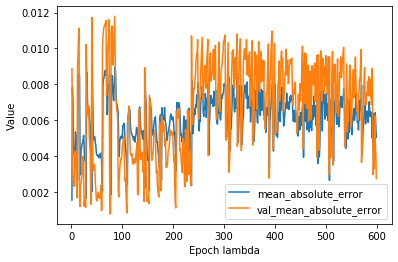

In [21]:
list_of_metrics_to_plot = ['mean_absolute_error',"val_mean_absolute_error"] 
plot_curve(epochs_lambda_best, hist_lambda_best, list_of_metrics_to_plot,"lambda")

In [23]:
best_model_lambda.save("saved_Models/lambda_100_best_model_main_max_err_0_0027")

INFO:tensorflow:Assets written to: saved_Models/lambda_100_best_model_main_max_err_0_0027\assets


In [25]:
MAX_TRIALS = 20

EXECUTIONS_PER_TRIAL = 3

tuner_delta = kt.RandomSearch(

    create_model_optimizer,

    objective='val_mean_absolute_error',

    max_trials=MAX_TRIALS,

    executions_per_trial=EXECUTIONS_PER_TRIAL,

    directory='delta_100_model_main_max',
    overwrite = True,
    project_name='second Try',

    seed=1

)
x_train_delta=delta_train["main_maximum"].to_numpy()
y_train_delta=delta_train["delta"].to_numpy()
x_test_delta=delta_test["main_maximum"].to_numpy()
y_test_delta=delta_test["delta"].to_numpy()
#lambda_train, lambda_test
#delta_train, delta_test
tuner_delta.search(x_train_delta, y_train_delta, epochs = 200, validation_data = (x_test_delta, y_test_delta))


Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.3950 - mean_absolute_error: 0.395 - 0s 117ms/step - loss: 0.3810 - mean_absolute_error: 0.3810 - val_loss: 0.3207 - val_mean_absolute_error: 0.3207
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.3334 - mean_absolute_error: 0.333 - 0s 78ms/step - loss: 0.3222 - mean_absolute_error: 0.3222 - val_loss: 0.2541 - val_mean_absolute_error: 0.2541
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.2711 - mean_absolute_error: 0.271 - 0s 81ms/step - loss: 0.2538 - mean_absolute_error: 0.2538 - val_loss: 0.1844 - val_mean_absolute_error: 0.1844
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.2034 - mean_absolute_error: 0.203 - 0s 73ms/step - loss: 0.1835 - mean_absolute_error: 0.1835 - val_loss: 0.1140 - val_mean_absolute_error: 0.1140
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.1421 - mean_absolute_error: 0.142 - 0s 69ms/step - loss: 0.1129 - 

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.036 - 0s 9ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0360 - val_mean_absolute_error: 0.0360
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.0318 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.033 - 0s 68ms/step - loss: 0.0326 - mean_absolute_error: 0.0326 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.0305 - mean_absolute_error: 0.030 - 0s 57ms/step - loss: 0.0330 - mean_absolute_error: 0.0330 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0327 -

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.0321 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0345 - val_mean_absolute_error: 0.0345
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.0312 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0321 - mean_absolute_error: 0.0321 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.0260 - mean_absolute_error: 0.026 - 0s 10ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0318 - mean_absolute_error: 0.0318 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0318 - 

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.0286 - mean_absolute_error: 0.028 - 0s 11ms/step - loss: 0.0312 - mean_absolute_error: 0.0312 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0315 - mean_absolute_error: 0.0315 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0314 - mean_absolute_error: 0.0314 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0312 - mean_absolute_error: 0.0312 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.030 - 0s 10ms/step - loss: 0.0

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.031 - 0s 11ms/step - loss: 0.0310 - mean_absolute_error: 0.0310 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0309 - mean_absolute_error: 0.0309 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0309 - mean_absolute_error: 0.0309 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.0298 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0311 - mean_absolute_error: 0.0311 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.0292 - mean_absolute_error: 0.029 - 0s 10ms/step - loss: 0.0

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.026 - 0s 9ms/step - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.0286 - mean_absolute_error: 0.028 - 0s 11ms/step - loss: 0.0306 - mean_absolute_error: 0.0306 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.0235 - mean_absolute_error: 0.023 - 0s 9ms/step - loss: 0.0310 - mean_absolute_error: 0.0310 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.035 - 0s 9ms/step - loss: 0.03

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.0495 - mean_absolute_error: 0.049 - 0s 9ms/step - loss: 0.0512 - mean_absolute_error: 0.0512 - val_loss: 0.0428 - val_mean_absolute_error: 0.0428
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.0517 - mean_absolute_error: 0.051 - 0s 11ms/step - loss: 0.0494 - mean_absolute_error: 0.0494 - val_loss: 0.0421 - val_mean_absolute_error: 0.0421
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.0438 - mean_absolute_error: 0.043 - 0s 9ms/step - loss: 0.0480 - mean_absolute_error: 0.0480 - val_loss: 0.0416 - val_mean_absolute_error: 0.0416
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.0469 - mean_absolute_error: 0.046 - 0s 10ms/step - loss: 0.0466 - mean_absolute_error: 0.0466 - val_loss: 0.0410 - val_mean_absolute_error: 0.0410
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.0422 - mean_absolute_error: 0.042 - 0s 9ms/step - loss: 0.0454 -

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.0430 - mean_absolute_error: 0.043 - 0s 9ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.036 - 0s 11ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0352 - 

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.0277 - mean_absolute_error: 0.027 - 0s 9ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0369 - val_mean_absolute_error: 0.0369
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.038 - 0s 9ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0368 - val_mean_absolute_error: 0.0368
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.033 - 0s 11ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0368 - val_mean_absolute_error: 0.0368
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.037 - 0s 9ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0367 - val_mean_absolute_error: 0.0367
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.03

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.039 - 0s 9ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.034 - 0s 10ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.030 - 0s 12ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.0291 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.034 - 0s 11ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0363 - val_mean_absolute_error: 0.0363
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0364 - val_mean_absolute_error: 0.0364
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.033 - 0s 10ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0364 - val_mean_absolute_error: 0.0364
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.037 - 0s 11ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0364 - val_mean_absolute_error: 0.0364
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.035 - 0s 10ms/step - loss: 0

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.4440 - mean_absolute_error: 0.444 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.4137 - mean_absolute_error: 0.413 - 0s 15ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.4189 - mean_absolute_error: 0.418 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.4278 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.4183 - mean_absolute_error: 0.418 - 0s 13ms/step - loss: 0.4262

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.4299 - mean_absolute_error: 0.429 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.4289 - mean_absolute_error: 0.428 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.4203 - mean_absolute_error: 0.420 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.4327 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.4320 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 -

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.4223 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.4154 - mean_absolute_error: 0.415 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.4288 - mean_absolute_error: 0.428 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.4360 - mean_absolute_error: 0.436 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.4125 - mean_absolute_error: 0.412 - 0s 9ms/step - loss: 0.4262 - 

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.4233 - mean_absolute_error: 0.423 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.4203 - mean_absolute_error: 0.420 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.4285 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.4176 - mean_absolute_error: 0.417 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.4185 - mean_absolute_error: 0.418 - 0s 9ms/step - loss: 0.42

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.4310 - mean_absolute_error: 0.431 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.4305 - mean_absolute_error: 0.430 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.4160 - mean_absolute_error: 0.416 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.4300 - mean_absolute_error: 0.430 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.4149 - mean_absolute_error: 0.414 - 0s 11ms/step - loss: 0.4

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.4246 - mean_absolute_error: 0.424 - 0s 96ms/step - loss: 0.4224 - mean_absolute_error: 0.4224 - val_loss: 0.4045 - val_mean_absolute_error: 0.4045
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.4077 - mean_absolute_error: 0.407 - 0s 69ms/step - loss: 0.4188 - mean_absolute_error: 0.4188 - val_loss: 0.4008 - val_mean_absolute_error: 0.4008
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.4093 - mean_absolute_error: 0.409 - 0s 74ms/step - loss: 0.4150 - mean_absolute_error: 0.4150 - val_loss: 0.3970 - val_mean_absolute_error: 0.3970
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.4213 - mean_absolute_error: 0.421 - 0s 77ms/step - loss: 0.4113 - mean_absolute_error: 0.4113 - val_loss: 0.3933 - val_mean_absolute_error: 0.3933
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.4002 - mean_absolute_error: 0.400 - 0s 86ms/step - loss: 0.4076 - m

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.2820 - mean_absolute_error: 0.282 - 0s 90ms/step - loss: 0.2818 - mean_absolute_error: 0.2818 - val_loss: 0.2640 - val_mean_absolute_error: 0.2640
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.2813 - mean_absolute_error: 0.281 - 0s 103ms/step - loss: 0.2781 - mean_absolute_error: 0.2781 - val_loss: 0.2603 - val_mean_absolute_error: 0.2603
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.2709 - mean_absolute_error: 0.270 - 0s 78ms/step - loss: 0.2744 - mean_absolute_error: 0.2744 - val_loss: 0.2566 - val_mean_absolute_error: 0.2566
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.2742 - mean_absolute_error: 0.274 - 0s 98ms/step - loss: 0.2706 - mean_absolute_error: 0.2706 - val_loss: 0.2528 - val_mean_absolute_error: 0.2528
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.2649 - mean_absolute_error: 0.264 - 0s 69ms/step - loss: 0.26

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.1303 - mean_absolute_error: 0.130 - 0s 85ms/step - loss: 0.1372 - mean_absolute_error: 0.1372 - val_loss: 0.1193 - val_mean_absolute_error: 0.1193
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.1271 - mean_absolute_error: 0.127 - 0s 119ms/step - loss: 0.1333 - mean_absolute_error: 0.1333 - val_loss: 0.1154 - val_mean_absolute_error: 0.1154
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.1377 - mean_absolute_error: 0.137 - 0s 131ms/step - loss: 0.1294 - mean_absolute_error: 0.1294 - val_loss: 0.1115 - val_mean_absolute_error: 0.1115
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.1412 - mean_absolute_error: 0.141 - 0s 95ms/step - loss: 0.1254 - mean_absolute_error: 0.1254 - val_loss: 0.1075 - val_mean_absolute_error: 0.1075
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.1248 - mean_absolute_error: 0.124 - 0s 148ms/step - loss: 0.

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.0508 - mean_absolute_error: 0.050 - 0s 73ms/step - loss: 0.0505 - mean_absolute_error: 0.0505 - val_loss: 0.0533 - val_mean_absolute_error: 0.0533
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.0514 - mean_absolute_error: 0.051 - 0s 102ms/step - loss: 0.0500 - mean_absolute_error: 0.0500 - val_loss: 0.0531 - val_mean_absolute_error: 0.0531
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.0464 - mean_absolute_error: 0.046 - 0s 100ms/step - loss: 0.0496 - mean_absolute_error: 0.0496 - val_loss: 0.0528 - val_mean_absolute_error: 0.0528
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.0430 - mean_absolute_error: 0.043 - 0s 72ms/step - loss: 0.0492 - mean_absolute_error: 0.0492 - val_loss: 0.0526 - val_mean_absolute_error: 0.0526
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.0407 - mean_absolute_error: 0.040 - 0s 65ms/step - loss

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.036 - 0s 9ms/step - loss: 0.0458 - mean_absolute_error: 0.0458 - val_loss: 0.0520 - val_mean_absolute_error: 0.0520
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.043 - 0s 9ms/step - loss: 0.0457 - mean_absolute_error: 0.0457 - val_loss: 0.0520 - val_mean_absolute_error: 0.0520
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.0456 - mean_absolute_error: 0.045 - 0s 11ms/step - loss: 0.0457 - mean_absolute_error: 0.0457 - val_loss: 0.0520 - val_mean_absolute_error: 0.0520
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.0503 - mean_absolute_error: 0.050 - 0s 10ms/step - loss: 0.0457 - mean_absolute_error: 0.0457 - val_loss: 0.0520 - val_mean_absolute_error: 0.0520
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.0474 - mean_absolute_error: 0.047 - 0s 10ms/step - loss: 0.

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.0460 - mean_absolute_error: 0.046 - 0s 9ms/step - loss: 0.0454 - mean_absolute_error: 0.0454 - val_loss: 0.0520 - val_mean_absolute_error: 0.0520
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.0445 - mean_absolute_error: 0.044 - 0s 9ms/step - loss: 0.0454 - mean_absolute_error: 0.0454 - val_loss: 0.0520 - val_mean_absolute_error: 0.0520
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.0418 - mean_absolute_error: 0.041 - 0s 11ms/step - loss: 0.0455 - mean_absolute_error: 0.0455 - val_loss: 0.0520 - val_mean_absolute_error: 0.0520
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.0496 - mean_absolute_error: 0.049 - 0s 10ms/step - loss: 0.0454 - mean_absolute_error: 0.0454 - val_loss: 0.0520 - val_mean_absolute_error: 0.0520
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.039 - 0s 9ms/step - loss: 0.0

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.2876 - mean_absolute_error: 0.287 - 0s 9ms/step - loss: 0.2823 - mean_absolute_error: 0.2823 - val_loss: 0.2631 - val_mean_absolute_error: 0.2631
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.2806 - mean_absolute_error: 0.280 - 0s 9ms/step - loss: 0.2773 - mean_absolute_error: 0.2773 - val_loss: 0.2582 - val_mean_absolute_error: 0.2582
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.2786 - mean_absolute_error: 0.278 - 0s 9ms/step - loss: 0.2724 - mean_absolute_error: 0.2724 - val_loss: 0.2532 - val_mean_absolute_error: 0.2532
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.2685 - mean_absolute_error: 0.268 - 0s 9ms/step - loss: 0.2674 - mean_absolute_error: 0.2674 - val_loss: 0.2483 - val_mean_absolute_error: 0.2483
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.2666 - mean_absolute_error: 0.266 - 0s 9ms/step - loss: 0.2624 - m

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.088 - 0s 9ms/step - loss: 0.0900 - mean_absolute_error: 0.0900 - val_loss: 0.0747 - val_mean_absolute_error: 0.0747
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.0918 - mean_absolute_error: 0.091 - 0s 9ms/step - loss: 0.0867 - mean_absolute_error: 0.0867 - val_loss: 0.0729 - val_mean_absolute_error: 0.0729
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.0893 - mean_absolute_error: 0.089 - 0s 10ms/step - loss: 0.0840 - mean_absolute_error: 0.0840 - val_loss: 0.0717 - val_mean_absolute_error: 0.0717
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.0845 - mean_absolute_error: 0.084 - 0s 10ms/step - loss: 0.0813 - mean_absolute_error: 0.0813 - val_loss: 0.0704 - val_mean_absolute_error: 0.0704
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.0749 - mean_absolute_error: 0.074 - 0s 9ms/step - loss: 0.0789 -

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.0501 - mean_absolute_error: 0.050 - 0s 9ms/step - loss: 0.0483 - mean_absolute_error: 0.0483 - val_loss: 0.0530 - val_mean_absolute_error: 0.0530
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.0507 - mean_absolute_error: 0.050 - 0s 9ms/step - loss: 0.0483 - mean_absolute_error: 0.0483 - val_loss: 0.0530 - val_mean_absolute_error: 0.0530
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.0470 - mean_absolute_error: 0.047 - 0s 9ms/step - loss: 0.0482 - mean_absolute_error: 0.0482 - val_loss: 0.0530 - val_mean_absolute_error: 0.0530
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.0451 - mean_absolute_error: 0.045 - 0s 9ms/step - loss: 0.0482 - mean_absolute_error: 0.0482 - val_loss: 0.0530 - val_mean_absolute_error: 0.0530
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.0445 - mean_absolute_error: 0.044 - 0s 9ms/step - loss: 0.048

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.0460 - mean_absolute_error: 0.046 - 0s 9ms/step - loss: 0.0469 - mean_absolute_error: 0.0469 - val_loss: 0.0521 - val_mean_absolute_error: 0.0521
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.0499 - mean_absolute_error: 0.049 - 0s 9ms/step - loss: 0.0468 - mean_absolute_error: 0.0468 - val_loss: 0.0520 - val_mean_absolute_error: 0.0520
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.0447 - mean_absolute_error: 0.044 - 0s 9ms/step - loss: 0.0468 - mean_absolute_error: 0.0468 - val_loss: 0.0520 - val_mean_absolute_error: 0.0520
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.037 - 0s 9ms/step - loss: 0.0467 - mean_absolute_error: 0.0467 - val_loss: 0.0520 - val_mean_absolute_error: 0.0520
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.0483 - mean_absolute_error: 0.048 - 0s 9ms/step - loss: 0.046

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.044 - 0s 61ms/step - loss: 0.0455 - mean_absolute_error: 0.0455 - val_loss: 0.0509 - val_mean_absolute_error: 0.0509
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.0472 - mean_absolute_error: 0.047 - 0s 72ms/step - loss: 0.0454 - mean_absolute_error: 0.0454 - val_loss: 0.0508 - val_mean_absolute_error: 0.0508
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.0449 - mean_absolute_error: 0.044 - 0s 70ms/step - loss: 0.0454 - mean_absolute_error: 0.0454 - val_loss: 0.0508 - val_mean_absolute_error: 0.0508
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.0453 - mean_absolute_error: 0.045 - 0s 78ms/step - loss: 0.0453 - mean_absolute_error: 0.0453 - val_loss: 0.0508 - val_mean_absolute_error: 0.0508
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.0468 - mean_absolute_error: 0.046 - 0s 109ms/step - loss:

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.4093 - mean_absolute_error: 0.409 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.4193 - mean_absolute_error: 0.419 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.4199 - mean_absolute_error: 0.419 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.4255 - mean_absolute_error: 0.425 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.4306 - mean_absolute_error: 0.430 - 0s 9ms/step - loss: 0.4262 - m

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.4141 - mean_absolute_error: 0.414 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.4241 - mean_absolute_error: 0.424 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.4161 - mean_absolute_error: 0.416 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.4280 - mean_absolute_error: 0.428 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.4184 - mean_absolute_error: 0.418 - 0s 9ms/step - loss: 0.4262 - 

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.4361 - mean_absolute_error: 0.436 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.4331 - mean_absolute_error: 0.433 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.4195 - mean_absolute_error: 0.419 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.4249 - mean_absolute_error: 0.424 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.4310 - mean_absolute_error: 0.431 - 0s 9ms/step - loss: 0.4262 - m

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.4227 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.4178 - mean_absolute_error: 0.417 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.4244 - mean_absolute_error: 0.424 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.4275 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.4181 - mean_absolute_error: 0.418 - 0s 9ms/step - loss: 0.42

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.4259 - mean_absolute_error: 0.425 - 0s 12ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.4232 - mean_absolute_error: 0.423 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.4316 - mean_absolute_error: 0.431 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.4345 - mean_absolute_error: 0.434 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.4230 - mean_absolute_error: 0.423 - 0s 9ms/step - loss: 0.4

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.4280 - mean_absolute_error: 0.428 - 0s 104ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.4324 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.4324 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.4273 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.4223 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.4262 - mean

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.4189 - mean_absolute_error: 0.418 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.4259 - mean_absolute_error: 0.425 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.4153 - mean_absolute_error: 0.415 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.4229 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.4222 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.4262 - m

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.4262 - mean_absolute_error: 0.426 - 0s 12ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.4401 - mean_absolute_error: 0.440 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.4047 - mean_absolute_error: 0.404 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.4115 - mean_absolute_error: 0.411 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.4334 - mean_absolute_error: 0.433 - 0s 9ms/step - loss: 0.4262 - 

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.4160 - mean_absolute_error: 0.416 - 0s 12ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.4375 - mean_absolute_error: 0.437 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.4369 - mean_absolute_error: 0.436 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.4182 - mean_absolute_error: 0.418 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.4161 - mean_absolute_error: 0.416 - 0s 9ms/step - loss: 0.42

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.4201 - mean_absolute_error: 0.420 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.4207 - mean_absolute_error: 0.420 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.4307 - mean_absolute_error: 0.430 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.4084 - mean_absolute_error: 0.408 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.4250 - mean_absolute_error: 0.425 - 0s 9ms/step - loss: 0.42

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.4231 - mean_absolute_error: 0.423 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.4290 - mean_absolute_error: 0.429 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.4132 - mean_absolute_error: 0.413 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.4309 - mean_absolute_error: 0.430 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.4230 - mean_absolute_error: 0.423 - 0s 9ms/step - loss: 0.42

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.038 - 0s 61ms/step - loss: 0.0415 - mean_absolute_error: 0.0415 - val_loss: 0.0474 - val_mean_absolute_error: 0.0474
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.034 - 0s 69ms/step - loss: 0.0411 - mean_absolute_error: 0.0411 - val_loss: 0.0471 - val_mean_absolute_error: 0.0471
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.036 - 0s 69ms/step - loss: 0.0407 - mean_absolute_error: 0.0407 - val_loss: 0.0467 - val_mean_absolute_error: 0.0467
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.036 - 0s 77ms/step - loss: 0.0403 - mean_absolute_error: 0.0403 - val_loss: 0.0464 - val_mean_absolute_error: 0.0464
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.0447 - mean_absolute_error: 0.044 - 0s 86ms/step - loss: 0.039

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.031 - 0s 67ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0362 - val_mean_absolute_error: 0.0362
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.0284 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.040 - 0s 100ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.0298 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0339 - mean_absolute_error: 0.0339 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0337 

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.031 - 0s 82ms/step - loss: 0.0333 - mean_absolute_error: 0.0333 - val_loss: 0.0339 - val_mean_absolute_error: 0.0339
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.0345 - val_mean_absolute_error: 0.0345
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.035 - 0s 9ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0346 - val_mean_absolute_error: 0.0346
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0332 - mean_absolute_error: 0.0332 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.032 - 0s 10ms/step - loss: 0.0

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.0312 - mean_absolute_error: 0.031 - 0s 10ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0343 - val_mean_absolute_error: 0.0343
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.035 - 0s 65ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.036 - 0s 10ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.037 - 0s 10ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.036 - 0s 9ms/step - loss: 0

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0330 - mean_absolute_error: 0.0330 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.033 - 0s 10ms/step - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0345 - val_mean_absolute_error: 0.0345
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.036 - 0s 9ms/step - loss: 0.03

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.4225 - mean_absolute_error: 0.422 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.4303 - mean_absolute_error: 0.430 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.4295 - mean_absolute_error: 0.429 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.4223 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.4344 - mean_absolute_error: 0.434 - 0s 9ms/step - loss: 0.4262 - 

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.4281 - mean_absolute_error: 0.428 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.4290 - mean_absolute_error: 0.429 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.4348 - mean_absolute_error: 0.434 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.4167 - mean_absolute_error: 0.416 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.4313 - mean_absolute_error: 0.431 - 0s 10ms/step - loss: 0.4262 -

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.4214 - mean_absolute_error: 0.421 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.4276 - mean_absolute_error: 0.427 - 0s 12ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.4334 - mean_absolute_error: 0.433 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.4123 - mean_absolute_error: 0.412 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.4244 - mean_absolute_error: 0.424 - 0s 10ms/step - loss: 0.4262 

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.4313 - mean_absolute_error: 0.431 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.4300 - mean_absolute_error: 0.430 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.4244 - mean_absolute_error: 0.424 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.4234 - mean_absolute_error: 0.423 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.4282 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.4224 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.4324 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.4233 - mean_absolute_error: 0.423 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.4290 - mean_absolute_error: 0.429 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.4393 - mean_absolute_error: 0.439 - 0s 9ms/step - loss: 0.42

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.4226 - mean_absolute_error: 0.422 - 0s 112ms/step - loss: 0.4260 - mean_absolute_error: 0.4260 - val_loss: 0.4101 - val_mean_absolute_error: 0.4101
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.4218 - mean_absolute_error: 0.421 - 0s 69ms/step - loss: 0.4256 - mean_absolute_error: 0.4256 - val_loss: 0.4095 - val_mean_absolute_error: 0.4095
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.4168 - mean_absolute_error: 0.416 - 0s 73ms/step - loss: 0.4249 - mean_absolute_error: 0.4249 - val_loss: 0.4089 - val_mean_absolute_error: 0.4089
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.4201 - mean_absolute_error: 0.420 - 0s 70ms/step - loss: 0.4243 - mean_absolute_error: 0.4243 - val_loss: 0.4083 - val_mean_absolute_error: 0.4083
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.4211 - mean_absolute_error: 0.421 - 0s 94ms/step - loss: 0.4238 - 

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.4002 - mean_absolute_error: 0.400 - 0s 123ms/step - loss: 0.4044 - mean_absolute_error: 0.4044 - val_loss: 0.3884 - val_mean_absolute_error: 0.3884
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.4045 - mean_absolute_error: 0.404 - 0s 77ms/step - loss: 0.4038 - mean_absolute_error: 0.4038 - val_loss: 0.3878 - val_mean_absolute_error: 0.3878
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.4046 - mean_absolute_error: 0.404 - 0s 90ms/step - loss: 0.4032 - mean_absolute_error: 0.4032 - val_loss: 0.3873 - val_mean_absolute_error: 0.3873
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.4064 - mean_absolute_error: 0.406 - 0s 65ms/step - loss: 0.4027 - mean_absolute_error: 0.4027 - val_loss: 0.3867 - val_mean_absolute_error: 0.3867
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.4039 - mean_absolute_error: 0.403 - 0s 69ms/step - loss: 0.40

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.3862 - mean_absolute_error: 0.386 - 0s 65ms/step - loss: 0.3820 - mean_absolute_error: 0.3820 - val_loss: 0.3660 - val_mean_absolute_error: 0.3660
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.3948 - mean_absolute_error: 0.394 - 0s 73ms/step - loss: 0.3814 - mean_absolute_error: 0.3814 - val_loss: 0.3654 - val_mean_absolute_error: 0.3654
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.3905 - mean_absolute_error: 0.390 - 0s 60ms/step - loss: 0.3808 - mean_absolute_error: 0.3808 - val_loss: 0.3648 - val_mean_absolute_error: 0.3648
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.3782 - mean_absolute_error: 0.378 - 0s 69ms/step - loss: 0.3802 - mean_absolute_error: 0.3802 - val_loss: 0.3643 - val_mean_absolute_error: 0.3643
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.3825 - mean_absolute_error: 0.382 - 0s 52ms/step - loss: 0.379

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.3629 - mean_absolute_error: 0.362 - 0s 74ms/step - loss: 0.3596 - mean_absolute_error: 0.3596 - val_loss: 0.3437 - val_mean_absolute_error: 0.3437
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.3563 - mean_absolute_error: 0.356 - 0s 94ms/step - loss: 0.3590 - mean_absolute_error: 0.3590 - val_loss: 0.3431 - val_mean_absolute_error: 0.3431
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.3571 - mean_absolute_error: 0.357 - 0s 85ms/step - loss: 0.3584 - mean_absolute_error: 0.3584 - val_loss: 0.3425 - val_mean_absolute_error: 0.3425
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.3477 - mean_absolute_error: 0.347 - 0s 65ms/step - loss: 0.3578 - mean_absolute_error: 0.3578 - val_loss: 0.3419 - val_mean_absolute_error: 0.3419
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.3610 - mean_absolute_error: 0.361 - 0s 107ms/step - loss:

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.3411 - mean_absolute_error: 0.341 - 0s 69ms/step - loss: 0.3373 - mean_absolute_error: 0.3373 - val_loss: 0.3214 - val_mean_absolute_error: 0.3214
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.3408 - mean_absolute_error: 0.340 - 0s 65ms/step - loss: 0.3367 - mean_absolute_error: 0.3367 - val_loss: 0.3208 - val_mean_absolute_error: 0.3208
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.3418 - mean_absolute_error: 0.341 - 0s 111ms/step - loss: 0.3361 - mean_absolute_error: 0.3361 - val_loss: 0.3202 - val_mean_absolute_error: 0.3202
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.3445 - mean_absolute_error: 0.344 - 0s 97ms/step - loss: 0.3355 - mean_absolute_error: 0.3355 - val_loss: 0.3196 - val_mean_absolute_error: 0.3196
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.3490 - mean_absolute_error: 0.349 - 0s 65ms/step - loss:

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.2971 - mean_absolute_error: 0.297 - 0s 61ms/step - loss: 0.3148 - mean_absolute_error: 0.3148 - val_loss: 0.2989 - val_mean_absolute_error: 0.2989
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.3114 - mean_absolute_error: 0.311 - 0s 82ms/step - loss: 0.3142 - mean_absolute_error: 0.3142 - val_loss: 0.2984 - val_mean_absolute_error: 0.2984
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.3213 - mean_absolute_error: 0.321 - 0s 69ms/step - loss: 0.3136 - mean_absolute_error: 0.3136 - val_loss: 0.2978 - val_mean_absolute_error: 0.2978
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.3169 - mean_absolute_error: 0.316 - 0s 70ms/step - loss: 0.3130 - mean_absolute_error: 0.3130 - val_loss: 0.2972 - val_mean_absolute_error: 0.2972
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.3229 - mean_absolute_error: 0.322 - 0s 86ms/step - loss: 

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.4310 - mean_absolute_error: 0.431 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.4284 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.4242 - mean_absolute_error: 0.424 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.4360 - mean_absolute_error: 0.436 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.4302 - mean_absolute_error: 0.430 - 0s 9ms/step - loss: 0.4262 - m

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.4281 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.4173 - mean_absolute_error: 0.417 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.4261 - mean_absolute_error: 0.426 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.4288 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.4313 - mean_absolute_error: 0.431 - 0s 9ms/step - loss: 0.4262 - 

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.4233 - mean_absolute_error: 0.423 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.4319 - mean_absolute_error: 0.431 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.4194 - mean_absolute_error: 0.419 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.4358 - mean_absolute_error: 0.435 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.4374 - mean_absolute_error: 0.437 - 0s 10ms/step - loss: 0.4

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.4177 - mean_absolute_error: 0.417 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.4228 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.4108 - mean_absolute_error: 0.410 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.4290 - mean_absolute_error: 0.429 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.4260 - mean_absolute_error: 0.426 - 0s 9ms/step - loss: 0.42

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.4231 - mean_absolute_error: 0.423 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.4146 - mean_absolute_error: 0.414 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.4151 - mean_absolute_error: 0.415 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.4373 - mean_absolute_error: 0.437 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.4328 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.42

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.4167 - mean_absolute_error: 0.416 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.4286 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.4144 - mean_absolute_error: 0.414 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.4275 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.4230 - mean_absolute_error: 0.423 - 0s 10ms/step - loss: 0.4262 - 

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.4170 - mean_absolute_error: 0.417 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.4346 - mean_absolute_error: 0.434 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.4286 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.4206 - mean_absolute_error: 0.420 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.4208 - mean_absolute_error: 0.420 - 0s 9ms/step - loss: 0.4262 - 

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.4316 - mean_absolute_error: 0.431 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.4425 - mean_absolute_error: 0.442 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.4205 - mean_absolute_error: 0.420 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.4319 - mean_absolute_error: 0.431 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.4280 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.4298 - mean_absolute_error: 0.429 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.4360 - mean_absolute_error: 0.436 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.4355 - mean_absolute_error: 0.435 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.4268 - mean_absolute_error: 0.426 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.4377 - mean_absolute_error: 0.437 - 0s 9ms/step - loss: 0.42

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.4225 - mean_absolute_error: 0.422 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.4116 - mean_absolute_error: 0.411 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.4291 - mean_absolute_error: 0.429 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.4189 - mean_absolute_error: 0.418 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.4328 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.42

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.4224 - mean_absolute_error: 0.422 - 0s 109ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.4229 - mean_absolute_error: 0.422 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.4292 - mean_absolute_error: 0.429 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.4273 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.4276 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.4262 - mea

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.4192 - mean_absolute_error: 0.419 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.4083 - mean_absolute_error: 0.408 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.4290 - mean_absolute_error: 0.429 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.4281 - mean_absolute_error: 0.428 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.4151 - mean_absolute_error: 0.415 - 0s 9ms/step - loss: 0.4262 - m

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.4220 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.4281 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.4126 - mean_absolute_error: 0.412 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.4270 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.4223 - mean_absolute_error: 0.422 - 0s 10ms/step - loss: 0.4262 - 

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.4221 - mean_absolute_error: 0.422 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.4267 - mean_absolute_error: 0.426 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.4312 - mean_absolute_error: 0.431 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.4378 - mean_absolute_error: 0.437 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.4191 - mean_absolute_error: 0.419 - 0s 9ms/step - loss: 0.42

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.4260 - mean_absolute_error: 0.426 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.4335 - mean_absolute_error: 0.433 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.4291 - mean_absolute_error: 0.429 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.4268 - mean_absolute_error: 0.426 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.4301 - mean_absolute_error: 0.430 - 0s 9ms/step - loss: 0.42

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.4320 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.4175 - mean_absolute_error: 0.417 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.4357 - mean_absolute_error: 0.435 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.4292 - mean_absolute_error: 0.429 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.4251 - mean_absolute_error: 0.425 - 0s 9ms/step - loss: 0.42

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.4029 - mean_absolute_error: 0.402 - 0s 69ms/step - loss: 0.3993 - mean_absolute_error: 0.3993 - val_loss: 0.3841 - val_mean_absolute_error: 0.3841
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.3878 - mean_absolute_error: 0.387 - 0s 85ms/step - loss: 0.3988 - mean_absolute_error: 0.3988 - val_loss: 0.3835 - val_mean_absolute_error: 0.3835
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.3882 - mean_absolute_error: 0.388 - 0s 149ms/step - loss: 0.3982 - mean_absolute_error: 0.3982 - val_loss: 0.3830 - val_mean_absolute_error: 0.3830
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.3983 - mean_absolute_error: 0.398 - 0s 65ms/step - loss: 0.3977 - mean_absolute_error: 0.3977 - val_loss: 0.3824 - val_mean_absolute_error: 0.3824
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.4018 - mean_absolute_error: 0.401 - 0s 61ms/step - loss: 0.39

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.3671 - mean_absolute_error: 0.367 - 0s 69ms/step - loss: 0.3786 - mean_absolute_error: 0.3786 - val_loss: 0.3631 - val_mean_absolute_error: 0.3631
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.3838 - mean_absolute_error: 0.383 - 0s 73ms/step - loss: 0.3781 - mean_absolute_error: 0.3781 - val_loss: 0.3626 - val_mean_absolute_error: 0.3626
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.3815 - mean_absolute_error: 0.381 - 0s 73ms/step - loss: 0.3776 - mean_absolute_error: 0.3776 - val_loss: 0.3620 - val_mean_absolute_error: 0.3620
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.3716 - mean_absolute_error: 0.371 - 0s 102ms/step - loss: 0.3770 - mean_absolute_error: 0.3770 - val_loss: 0.3615 - val_mean_absolute_error: 0.3615
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.3681 - mean_absolute_error: 0.368 - 0s 73ms/step - loss: 0.37

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.3593 - mean_absolute_error: 0.359 - 0s 73ms/step - loss: 0.3586 - mean_absolute_error: 0.3586 - val_loss: 0.3430 - val_mean_absolute_error: 0.3430
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.3573 - mean_absolute_error: 0.357 - 0s 81ms/step - loss: 0.3581 - mean_absolute_error: 0.3581 - val_loss: 0.3425 - val_mean_absolute_error: 0.3425
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.3467 - mean_absolute_error: 0.346 - 0s 105ms/step - loss: 0.3575 - mean_absolute_error: 0.3575 - val_loss: 0.3420 - val_mean_absolute_error: 0.3420
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.3659 - mean_absolute_error: 0.365 - 0s 82ms/step - loss: 0.3570 - mean_absolute_error: 0.3570 - val_loss: 0.3415 - val_mean_absolute_error: 0.3415
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.3535 - mean_absolute_error: 0.353 - 0s 52ms/step - loss:

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.3311 - mean_absolute_error: 0.331 - 0s 69ms/step - loss: 0.3385 - mean_absolute_error: 0.3385 - val_loss: 0.3230 - val_mean_absolute_error: 0.3230
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.3295 - mean_absolute_error: 0.329 - 0s 112ms/step - loss: 0.3380 - mean_absolute_error: 0.3380 - val_loss: 0.3225 - val_mean_absolute_error: 0.3225
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.3370 - mean_absolute_error: 0.337 - 0s 85ms/step - loss: 0.3375 - mean_absolute_error: 0.3375 - val_loss: 0.3220 - val_mean_absolute_error: 0.3220
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.3431 - mean_absolute_error: 0.343 - 0s 111ms/step - loss: 0.3369 - mean_absolute_error: 0.3369 - val_loss: 0.3214 - val_mean_absolute_error: 0.3214
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.3378 - mean_absolute_error: 0.337 - 0s 69ms/step - loss

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.3225 - mean_absolute_error: 0.322 - 0s 57ms/step - loss: 0.3184 - mean_absolute_error: 0.3184 - val_loss: 0.3030 - val_mean_absolute_error: 0.3030
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.3233 - mean_absolute_error: 0.323 - 0s 90ms/step - loss: 0.3179 - mean_absolute_error: 0.3179 - val_loss: 0.3024 - val_mean_absolute_error: 0.3024
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.3100 - mean_absolute_error: 0.310 - 0s 61ms/step - loss: 0.3174 - mean_absolute_error: 0.3174 - val_loss: 0.3019 - val_mean_absolute_error: 0.3019
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.3239 - mean_absolute_error: 0.323 - 0s 61ms/step - loss: 0.3169 - mean_absolute_error: 0.3169 - val_loss: 0.3014 - val_mean_absolute_error: 0.3014
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.3236 - mean_absolute_error: 0.323 - 0s 80ms/step - loss: 

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.4039 - mean_absolute_error: 0.403 - 0s 9ms/step - loss: 0.4140 - mean_absolute_error: 0.4140 - val_loss: 0.3978 - val_mean_absolute_error: 0.3978
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.4268 - mean_absolute_error: 0.426 - 0s 9ms/step - loss: 0.4134 - mean_absolute_error: 0.4134 - val_loss: 0.3972 - val_mean_absolute_error: 0.3972
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.4144 - mean_absolute_error: 0.414 - 0s 9ms/step - loss: 0.4128 - mean_absolute_error: 0.4128 - val_loss: 0.3966 - val_mean_absolute_error: 0.3966
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.4107 - mean_absolute_error: 0.410 - 0s 9ms/step - loss: 0.4122 - mean_absolute_error: 0.4122 - val_loss: 0.3960 - val_mean_absolute_error: 0.3960
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.4027 - mean_absolute_error: 0.402 - 0s 9ms/step - loss: 0.4116 - m

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.4009 - mean_absolute_error: 0.400 - 0s 9ms/step - loss: 0.3909 - mean_absolute_error: 0.3909 - val_loss: 0.3746 - val_mean_absolute_error: 0.3746
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.3831 - mean_absolute_error: 0.383 - 0s 9ms/step - loss: 0.3903 - mean_absolute_error: 0.3903 - val_loss: 0.3740 - val_mean_absolute_error: 0.3740
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.3851 - mean_absolute_error: 0.385 - 0s 9ms/step - loss: 0.3897 - mean_absolute_error: 0.3897 - val_loss: 0.3734 - val_mean_absolute_error: 0.3734
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.3773 - mean_absolute_error: 0.377 - 0s 9ms/step - loss: 0.3891 - mean_absolute_error: 0.3891 - val_loss: 0.3727 - val_mean_absolute_error: 0.3727
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.3896 - mean_absolute_error: 0.389 - 0s 9ms/step - loss: 0.3884 - m

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.3640 - mean_absolute_error: 0.364 - 0s 11ms/step - loss: 0.3663 - mean_absolute_error: 0.3663 - val_loss: 0.3498 - val_mean_absolute_error: 0.3498
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.3674 - mean_absolute_error: 0.367 - 0s 9ms/step - loss: 0.3656 - mean_absolute_error: 0.3656 - val_loss: 0.3492 - val_mean_absolute_error: 0.3492
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.3743 - mean_absolute_error: 0.374 - 0s 9ms/step - loss: 0.3650 - mean_absolute_error: 0.3650 - val_loss: 0.3485 - val_mean_absolute_error: 0.3485
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.3667 - mean_absolute_error: 0.366 - 0s 9ms/step - loss: 0.3643 - mean_absolute_error: 0.3643 - val_loss: 0.3479 - val_mean_absolute_error: 0.3479
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.3681 - mean_absolute_error: 0.368 - 0s 9ms/step - loss: 0.3637 - 

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.3358 - mean_absolute_error: 0.335 - 0s 15ms/step - loss: 0.3417 - mean_absolute_error: 0.3417 - val_loss: 0.3253 - val_mean_absolute_error: 0.3253
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.3410 - mean_absolute_error: 0.341 - 0s 18ms/step - loss: 0.3410 - mean_absolute_error: 0.3410 - val_loss: 0.3247 - val_mean_absolute_error: 0.3247
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.3422 - mean_absolute_error: 0.342 - 0s 13ms/step - loss: 0.3404 - mean_absolute_error: 0.3404 - val_loss: 0.3240 - val_mean_absolute_error: 0.3240
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.3345 - mean_absolute_error: 0.334 - 0s 14ms/step - loss: 0.3398 - mean_absolute_error: 0.3398 - val_loss: 0.3234 - val_mean_absolute_error: 0.3234
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.3309 - mean_absolute_error: 0.330 - 0s 13ms/step - loss: 

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.3260 - mean_absolute_error: 0.326 - 0s 10ms/step - loss: 0.3174 - mean_absolute_error: 0.3174 - val_loss: 0.3012 - val_mean_absolute_error: 0.3012
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.3159 - mean_absolute_error: 0.315 - 0s 12ms/step - loss: 0.3168 - mean_absolute_error: 0.3168 - val_loss: 0.3005 - val_mean_absolute_error: 0.3005
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.3207 - mean_absolute_error: 0.320 - 0s 10ms/step - loss: 0.3161 - mean_absolute_error: 0.3161 - val_loss: 0.2999 - val_mean_absolute_error: 0.2999
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.3072 - mean_absolute_error: 0.307 - 0s 10ms/step - loss: 0.3155 - mean_absolute_error: 0.3155 - val_loss: 0.2993 - val_mean_absolute_error: 0.2993
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.3048 - mean_absolute_error: 0.304 - 0s 10ms/step - loss: 

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.4216 - mean_absolute_error: 0.421 - 0s 104ms/step - loss: 0.4080 - mean_absolute_error: 0.4080 - val_loss: 0.3927 - val_mean_absolute_error: 0.3927
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.3995 - mean_absolute_error: 0.399 - 0s 85ms/step - loss: 0.4075 - mean_absolute_error: 0.4075 - val_loss: 0.3922 - val_mean_absolute_error: 0.3922
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.4069 - mean_absolute_error: 0.406 - 0s 115ms/step - loss: 0.4069 - mean_absolute_error: 0.4069 - val_loss: 0.3916 - val_mean_absolute_error: 0.3916
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.4077 - mean_absolute_error: 0.407 - 0s 90ms/step - loss: 0.4063 - mean_absolute_error: 0.4063 - val_loss: 0.3910 - val_mean_absolute_error: 0.3910
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.4011 - mean_absolute_error: 0.401 - 0s 57ms/step - loss: 0.4057 -

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.3849 - mean_absolute_error: 0.384 - 0s 107ms/step - loss: 0.3858 - mean_absolute_error: 0.3858 - val_loss: 0.3705 - val_mean_absolute_error: 0.3705
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.3856 - mean_absolute_error: 0.385 - 0s 84ms/step - loss: 0.3853 - mean_absolute_error: 0.3853 - val_loss: 0.3699 - val_mean_absolute_error: 0.3699
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.3878 - mean_absolute_error: 0.387 - 0s 75ms/step - loss: 0.3847 - mean_absolute_error: 0.3847 - val_loss: 0.3693 - val_mean_absolute_error: 0.3693
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.3875 - mean_absolute_error: 0.387 - 0s 69ms/step - loss: 0.3841 - mean_absolute_error: 0.3841 - val_loss: 0.3687 - val_mean_absolute_error: 0.3687
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.3779 - mean_absolute_error: 0.377 - 0s 74ms/step - loss: 0.38

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.3664 - mean_absolute_error: 0.366 - 0s 61ms/step - loss: 0.3640 - mean_absolute_error: 0.3640 - val_loss: 0.3485 - val_mean_absolute_error: 0.3485
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.3559 - mean_absolute_error: 0.355 - 0s 82ms/step - loss: 0.3635 - mean_absolute_error: 0.3635 - val_loss: 0.3479 - val_mean_absolute_error: 0.3479
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.3690 - mean_absolute_error: 0.369 - 0s 61ms/step - loss: 0.3629 - mean_absolute_error: 0.3629 - val_loss: 0.3474 - val_mean_absolute_error: 0.3474
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.3647 - mean_absolute_error: 0.364 - 0s 69ms/step - loss: 0.3623 - mean_absolute_error: 0.3623 - val_loss: 0.3468 - val_mean_absolute_error: 0.3468
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.3595 - mean_absolute_error: 0.359 - 0s 102ms/step - loss: 0.36

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.3537 - mean_absolute_error: 0.353 - 0s 64ms/step - loss: 0.3425 - mean_absolute_error: 0.3425 - val_loss: 0.3266 - val_mean_absolute_error: 0.3266
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.3299 - mean_absolute_error: 0.329 - 0s 102ms/step - loss: 0.3419 - mean_absolute_error: 0.3419 - val_loss: 0.3261 - val_mean_absolute_error: 0.3261
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.3432 - mean_absolute_error: 0.343 - 0s 65ms/step - loss: 0.3413 - mean_absolute_error: 0.3413 - val_loss: 0.3255 - val_mean_absolute_error: 0.3255
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.3454 - mean_absolute_error: 0.345 - 0s 61ms/step - loss: 0.3407 - mean_absolute_error: 0.3407 - val_loss: 0.3249 - val_mean_absolute_error: 0.3249
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.3405 - mean_absolute_error: 0.340 - 0s 86ms/step - loss:

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.3272 - mean_absolute_error: 0.327 - 0s 73ms/step - loss: 0.3205 - mean_absolute_error: 0.3205 - val_loss: 0.3048 - val_mean_absolute_error: 0.3048
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.3044 - mean_absolute_error: 0.304 - 0s 61ms/step - loss: 0.3199 - mean_absolute_error: 0.3199 - val_loss: 0.3042 - val_mean_absolute_error: 0.3042
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.3236 - mean_absolute_error: 0.323 - 0s 69ms/step - loss: 0.3193 - mean_absolute_error: 0.3193 - val_loss: 0.3036 - val_mean_absolute_error: 0.3036
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.3205 - mean_absolute_error: 0.320 - 0s 77ms/step - loss: 0.3188 - mean_absolute_error: 0.3188 - val_loss: 0.3031 - val_mean_absolute_error: 0.3031
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.3183 - mean_absolute_error: 0.318 - 0s 66ms/step - loss: 

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.3073 - mean_absolute_error: 0.307 - 0s 85ms/step - loss: 0.2984 - mean_absolute_error: 0.2984 - val_loss: 0.2830 - val_mean_absolute_error: 0.2830
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.2866 - mean_absolute_error: 0.286 - 0s 107ms/step - loss: 0.2978 - mean_absolute_error: 0.2978 - val_loss: 0.2824 - val_mean_absolute_error: 0.2824
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.2921 - mean_absolute_error: 0.292 - 0s 82ms/step - loss: 0.2972 - mean_absolute_error: 0.2972 - val_loss: 0.2818 - val_mean_absolute_error: 0.2818
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.2988 - mean_absolute_error: 0.298 - 0s 65ms/step - loss: 0.2966 - mean_absolute_error: 0.2966 - val_loss: 0.2812 - val_mean_absolute_error: 0.2812
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.3136 - mean_absolute_error: 0.313 - 0s 73ms/step - loss:

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.4434 - mean_absolute_error: 0.443 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.4316 - mean_absolute_error: 0.431 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.4298 - mean_absolute_error: 0.429 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.4185 - mean_absolute_error: 0.418 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.4180 - mean_absolute_error: 0.418 - 0s 9ms/step - loss: 0.4262 - 

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.4303 - mean_absolute_error: 0.430 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.4256 - mean_absolute_error: 0.425 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.4225 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.4203 - mean_absolute_error: 0.420 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.4245 - mean_absolute_error: 0.424 - 0s 9ms/step - loss: 0.4262 - 

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.4310 - mean_absolute_error: 0.431 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.4247 - mean_absolute_error: 0.424 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.4320 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.4278 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.4225 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.42

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.4220 - mean_absolute_error: 0.422 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.4284 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.4211 - mean_absolute_error: 0.421 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.4338 - mean_absolute_error: 0.433 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.4338 - mean_absolute_error: 0.433 - 0s 9ms/step - loss: 0.42

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.4237 - mean_absolute_error: 0.423 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.4280 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.4379 - mean_absolute_error: 0.437 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.4307 - mean_absolute_error: 0.430 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.4233 - mean_absolute_error: 0.423 - 0s 9ms/step - loss: 0.42

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.3924 - mean_absolute_error: 0.392 - 0s 11ms/step - loss: 0.3914 - mean_absolute_error: 0.3914 - val_loss: 0.3757 - val_mean_absolute_error: 0.3757
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.3847 - mean_absolute_error: 0.384 - 0s 9ms/step - loss: 0.3908 - mean_absolute_error: 0.3908 - val_loss: 0.3751 - val_mean_absolute_error: 0.3751
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.3832 - mean_absolute_error: 0.383 - 0s 9ms/step - loss: 0.3902 - mean_absolute_error: 0.3902 - val_loss: 0.3745 - val_mean_absolute_error: 0.3745
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.3841 - mean_absolute_error: 0.384 - 0s 9ms/step - loss: 0.3896 - mean_absolute_error: 0.3896 - val_loss: 0.3738 - val_mean_absolute_error: 0.3738
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.3809 - mean_absolute_error: 0.380 - 0s 9ms/step - loss: 0.3890 - 

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.3641 - mean_absolute_error: 0.364 - 0s 9ms/step - loss: 0.3689 - mean_absolute_error: 0.3689 - val_loss: 0.3524 - val_mean_absolute_error: 0.3524
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.3640 - mean_absolute_error: 0.364 - 0s 11ms/step - loss: 0.3683 - mean_absolute_error: 0.3683 - val_loss: 0.3518 - val_mean_absolute_error: 0.3518
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.3663 - mean_absolute_error: 0.366 - 0s 8ms/step - loss: 0.3678 - mean_absolute_error: 0.3678 - val_loss: 0.3512 - val_mean_absolute_error: 0.3512
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.3768 - mean_absolute_error: 0.376 - 0s 8ms/step - loss: 0.3672 - mean_absolute_error: 0.3672 - val_loss: 0.3506 - val_mean_absolute_error: 0.3506
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.3732 - mean_absolute_error: 0.373 - 0s 9ms/step - loss: 0.3666 - 

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.3580 - mean_absolute_error: 0.358 - 0s 9ms/step - loss: 0.3467 - mean_absolute_error: 0.3467 - val_loss: 0.3296 - val_mean_absolute_error: 0.3296
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.3528 - mean_absolute_error: 0.352 - 0s 9ms/step - loss: 0.3461 - mean_absolute_error: 0.3461 - val_loss: 0.3290 - val_mean_absolute_error: 0.3290
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.3308 - mean_absolute_error: 0.330 - 0s 11ms/step - loss: 0.3456 - mean_absolute_error: 0.3456 - val_loss: 0.3284 - val_mean_absolute_error: 0.3284
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.3524 - mean_absolute_error: 0.352 - 0s 8ms/step - loss: 0.3450 - mean_absolute_error: 0.3450 - val_loss: 0.3278 - val_mean_absolute_error: 0.3278
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.3507 - mean_absolute_error: 0.350 - 0s 9ms/step - loss: 0.3444 - 

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.3217 - mean_absolute_error: 0.321 - 0s 9ms/step - loss: 0.3255 - mean_absolute_error: 0.3255 - val_loss: 0.3080 - val_mean_absolute_error: 0.3080
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.3347 - mean_absolute_error: 0.334 - 0s 8ms/step - loss: 0.3249 - mean_absolute_error: 0.3249 - val_loss: 0.3075 - val_mean_absolute_error: 0.3075
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.3266 - mean_absolute_error: 0.326 - 0s 11ms/step - loss: 0.3244 - mean_absolute_error: 0.3244 - val_loss: 0.3069 - val_mean_absolute_error: 0.3069
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.3334 - mean_absolute_error: 0.333 - 0s 9ms/step - loss: 0.3239 - mean_absolute_error: 0.3239 - val_loss: 0.3064 - val_mean_absolute_error: 0.3064
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.3381 - mean_absolute_error: 0.338 - 0s 9ms/step - loss: 0.32

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.3054 - mean_absolute_error: 0.305 - 0s 9ms/step - loss: 0.3054 - mean_absolute_error: 0.3054 - val_loss: 0.2878 - val_mean_absolute_error: 0.2878
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.3077 - mean_absolute_error: 0.307 - 0s 9ms/step - loss: 0.3048 - mean_absolute_error: 0.3048 - val_loss: 0.2873 - val_mean_absolute_error: 0.2873
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.2815 - mean_absolute_error: 0.281 - 0s 8ms/step - loss: 0.3043 - mean_absolute_error: 0.3043 - val_loss: 0.2868 - val_mean_absolute_error: 0.2868
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.3128 - mean_absolute_error: 0.312 - 0s 10ms/step - loss: 0.3038 - mean_absolute_error: 0.3038 - val_loss: 0.2863 - val_mean_absolute_error: 0.2863
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.3064 - mean_absolute_error: 0.306 - 0s 9ms/step - loss: 0.30

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.4217 - mean_absolute_error: 0.421 - 0s 114ms/step - loss: 0.4162 - mean_absolute_error: 0.4162 - val_loss: 0.3681 - val_mean_absolute_error: 0.3681
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.3735 - mean_absolute_error: 0.373 - 0s 73ms/step - loss: 0.3740 - mean_absolute_error: 0.3740 - val_loss: 0.3266 - val_mean_absolute_error: 0.3266
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.3396 - mean_absolute_error: 0.339 - 0s 82ms/step - loss: 0.3325 - mean_absolute_error: 0.3325 - val_loss: 0.2855 - val_mean_absolute_error: 0.2855
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.2951 - mean_absolute_error: 0.295 - 0s 73ms/step - loss: 0.2914 - mean_absolute_error: 0.2914 - val_loss: 0.2445 - val_mean_absolute_error: 0.2445
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.2652 - mean_absolute_error: 0.265 - 0s 94ms/step - loss: 0.2504 - 

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.0486 - mean_absolute_error: 0.048 - 0s 69ms/step - loss: 0.0476 - mean_absolute_error: 0.0476 - val_loss: 0.0530 - val_mean_absolute_error: 0.0530
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.0455 - mean_absolute_error: 0.045 - 0s 94ms/step - loss: 0.0477 - mean_absolute_error: 0.0477 - val_loss: 0.0530 - val_mean_absolute_error: 0.0530
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.0426 - mean_absolute_error: 0.042 - 0s 9ms/step - loss: 0.0476 - mean_absolute_error: 0.0476 - val_loss: 0.0530 - val_mean_absolute_error: 0.0530
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.0479 - mean_absolute_error: 0.047 - 0s 9ms/step - loss: 0.0475 - mean_absolute_error: 0.0475 - val_loss: 0.0530 - val_mean_absolute_error: 0.0530
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.0465 - mean_absolute_error: 0.046 - 0s 107ms/step - loss: 0.0474

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.0514 - mean_absolute_error: 0.051 - 0s 9ms/step - loss: 0.0460 - mean_absolute_error: 0.0460 - val_loss: 0.0518 - val_mean_absolute_error: 0.0518
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.039 - 0s 61ms/step - loss: 0.0460 - mean_absolute_error: 0.0460 - val_loss: 0.0518 - val_mean_absolute_error: 0.0518
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.039 - 0s 74ms/step - loss: 0.0459 - mean_absolute_error: 0.0459 - val_loss: 0.0517 - val_mean_absolute_error: 0.0517
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.0492 - mean_absolute_error: 0.049 - 0s 102ms/step - loss: 0.0465 - mean_absolute_error: 0.0465 - val_loss: 0.0516 - val_mean_absolute_error: 0.0516
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.0471 - mean_absolute_error: 0.047 - 0s 136ms/step - loss: 0.04

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.0444 - mean_absolute_error: 0.044 - 0s 9ms/step - loss: 0.0443 - mean_absolute_error: 0.0443 - val_loss: 0.0503 - val_mean_absolute_error: 0.0503
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.040 - 0s 73ms/step - loss: 0.0444 - mean_absolute_error: 0.0444 - val_loss: 0.0502 - val_mean_absolute_error: 0.0502
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.0419 - mean_absolute_error: 0.041 - 0s 77ms/step - loss: 0.0442 - mean_absolute_error: 0.0442 - val_loss: 0.0502 - val_mean_absolute_error: 0.0502
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.0429 - mean_absolute_error: 0.042 - 0s 119ms/step - loss: 0.0441 - mean_absolute_error: 0.0441 - val_loss: 0.0501 - val_mean_absolute_error: 0.0501
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.0435 - mean_absolute_error: 0.043 - 0s 77ms/step - loss: 

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.0414 - mean_absolute_error: 0.041 - 0s 69ms/step - loss: 0.0415 - mean_absolute_error: 0.0415 - val_loss: 0.0474 - val_mean_absolute_error: 0.0474
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.0411 - mean_absolute_error: 0.041 - 0s 69ms/step - loss: 0.0410 - mean_absolute_error: 0.0410 - val_loss: 0.0467 - val_mean_absolute_error: 0.0467
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.0404 - mean_absolute_error: 0.040 - 0s 85ms/step - loss: 0.0403 - mean_absolute_error: 0.0403 - val_loss: 0.0461 - val_mean_absolute_error: 0.0461
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.0415 - mean_absolute_error: 0.041 - 0s 87ms/step - loss: 0.0399 - mean_absolute_error: 0.0399 - val_loss: 0.0457 - val_mean_absolute_error: 0.0457
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.0411 - mean_absolute_error: 0.041 - 0s 87ms/step - loss: 

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.032 - 0s 73ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0398 - val_mean_absolute_error: 0.0398
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.036 - 0s 69ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0398 - val_mean_absolute_error: 0.0398
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.036 - 0s 9ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0398 - val_mean_absolute_error: 0.0398
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.042 - 0s 96ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0398 - val_mean_absolute_error: 0.0398
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.036 - 0s 80ms/step - loss: 0

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.4324 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.4299 - mean_absolute_error: 0.429 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.4314 - mean_absolute_error: 0.431 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.4273 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.4082 - mean_absolute_error: 0.408 - 0s 9ms/step - loss: 0.4262 - m

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.4229 - mean_absolute_error: 0.422 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.4278 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.4242 - mean_absolute_error: 0.424 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.4321 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.4338 - mean_absolute_error: 0.433 - 0s 9ms/step - loss: 0.4262 - 

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.4256 - mean_absolute_error: 0.425 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.4100 - mean_absolute_error: 0.410 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.4323 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.4208 - mean_absolute_error: 0.420 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.4228 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.4

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.4133 - mean_absolute_error: 0.413 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.4109 - mean_absolute_error: 0.410 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.4340 - mean_absolute_error: 0.434 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.4298 - mean_absolute_error: 0.429 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.4137 - mean_absolute_error: 0.413 - 0s 9ms/step - loss: 0.4

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.4304 - mean_absolute_error: 0.430 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.4328 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.4276 - mean_absolute_error: 0.427 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.4261 - mean_absolute_error: 0.426 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.4276 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.42

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.033 - 0s 11ms/step - loss: 0.0363 - mean_absolute_error: 0.0363 - val_loss: 0.0369 - val_mean_absolute_error: 0.0369
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.030 - 0s 11ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.033 - 0s 61ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0360 - val_mean_absolute_error: 0.0360
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.026 - 0s 57ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.037 - 0s 9ms/step - loss: 0.0336

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.031 - 0s 70ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0348 - val_mean_absolute_error: 0.0348
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.031 - 0s 11ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.0288 - mean_absolute_error: 0.028 - 0s 10ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0360 - val_mean_absolute_error: 0.0360
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.026 - 0s 9ms/step - loss: 0.0339 - mean_absolute_error: 0.0339 - val_loss: 0.0348 - val_mean_absolute_error: 0.0348
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.0286 - mean_absolute_error: 0.028 - 0s 11ms/step - loss: 0.0345

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0333 - mean_absolute_error: 0.0333 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.0262 - mean_absolute_error: 0.026 - 0s 9ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0350 - val_mean_absolute_error: 0.0350
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.0307 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0333 - mean_absolute_error: 0.0333 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.040 - 0s 9ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.033 - 0s 11ms/step - loss: 0.0333 - 

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.035 - 0s 10ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.035 - 0s 10ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.0365 - val_mean_absolute_error: 0.0365
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0345 - val_mean_absolute_error: 0.0345
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.0305 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0353 - val_mean_absolute_error: 0.0353
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.035 - 0s 9ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.0345 - val_mean_absolute_error: 0.0345
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.035 - 0s 9ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.0365 - val_mean_absolute_error: 0.0365
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0333 - mean_absolute_error: 0.0333 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.033

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.3736 - mean_absolute_error: 0.373 - 0s 101ms/step - loss: 0.3619 - mean_absolute_error: 0.3619 - val_loss: 0.2932 - val_mean_absolute_error: 0.2932
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.3047 - mean_absolute_error: 0.304 - 0s 86ms/step - loss: 0.2987 - mean_absolute_error: 0.2987 - val_loss: 0.2286 - val_mean_absolute_error: 0.2286
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.2525 - mean_absolute_error: 0.252 - 0s 65ms/step - loss: 0.2359 - mean_absolute_error: 0.2359 - val_loss: 0.1732 - val_mean_absolute_error: 0.1732
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.1576 - mean_absolute_error: 0.157 - 0s 126ms/step - loss: 0.1830 - mean_absolute_error: 0.1830 - val_loss: 0.1296 - val_mean_absolute_error: 0.1296
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.1294 - mean_absolute_error: 0.129 - 0s 66ms/step - loss: 0.1415 -

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.0281 - mean_absolute_error: 0.028 - 0s 69ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.0384 - mean_absolute_error: 0.038 - 0s 10ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.037 - 0s 10ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.033 - 0s 109ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.038 - 0s 73ms/step - loss: 0.03

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.0268 - mean_absolute_error: 0.026 - 0s 9ms/step - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0350 - val_mean_absolute_error: 0.0350
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.0285 - mean_absolute_error: 0.028 - 0s 10ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0351 - val_mean_absolute_error: 0.0351
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.034 - 0s 110ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.032 - 0s 73ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.031 - 0s 69ms/step - loss: 0.031

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.028 - 0s 69ms/step - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0307 - mean_absolute_error: 0.0307 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.0288 - mean_absolute_error: 0.028 - 0s 63ms/step - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.036 - 0s 9ms/step - loss: 0.0309 - mean_absolute_error: 0.0309 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.029 - 0s 10ms/step - loss: 0.

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.033 - 0s 10ms/step - loss: 0.0303 - mean_absolute_error: 0.0303 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.0291 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0302 - mean_absolute_error: 0.0302 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.030 - 0s 10ms/step - loss: 0.0303 - mean_absolute_error: 0.0303 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.0250 - mean_absolute_error: 0.025 - 0s 9ms/step - loss: 0.0304 - mean_absolute_error: 0.0304 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.0281 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0298 - mean_absolute_error: 0.0298 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.0310 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0302 - mean_absolute_error: 0.0302 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0299 - mean_absolute_error: 0.0299 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.0276 - mean_absolute_error: 0.027 - 0s 65ms/step - loss: 0.0301 - mean_absolute_error: 0.0301 - val_loss: 0.0303 - val_mean_absolute_error: 0.0303
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.026 - 0s 10ms/step - loss: 0.0

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.036 - 0s 11ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.036 - 0s 9ms/step - loss: 0.0319 - mean_absolute_error: 0.0319 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.0282 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0319 - mean_absolute_error: 0.0319 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0318 - mean_absolute_error: 0.0318 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0321 - 

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.021 - 0s 9ms/step - loss: 0.0313 - mean_absolute_error: 0.0313 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.0244 - mean_absolute_error: 0.024 - 0s 11ms/step - loss: 0.0315 - mean_absolute_error: 0.0315 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.023 - 0s 9ms/step - loss: 0.0321 - mean_absolute_error: 0.0321 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.037 - 0s 9ms/step - loss: 0.0310 - mean_absolute_error: 0.0310 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.034 - 0s 10ms/step - loss: 0.0311 -

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.031 - 0s 10ms/step - loss: 0.0316 - mean_absolute_error: 0.0316 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.032 - 0s 10ms/step - loss: 0.0306 - mean_absolute_error: 0.0306 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mean_absolute_error: 0.029 - 0s 11ms/step - loss: 0.0306 - mean_absolute_error: 0.0306 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0304 - mean_absolute_error: 0.0304 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.026 - 0s 10ms/step - loss: 0

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0301 - mean_absolute_error: 0.0301 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0307 - mean_absolute_error: 0.0307 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.0258 - mean_absolute_error: 0.025 - 0s 10ms/step - loss: 0.0317 - mean_absolute_error: 0.0317 - val_loss: 0.0310 - val_mean_absolute_error: 0.0310
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.029 - 0s 11ms/step - loss: 0.0307 - mean_absolute_error: 0.0307 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.027 - 0s 9ms/step - loss: 0.0300 - mean_absolute_error: 0.0300 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0300 - mean_absolute_error: 0.0300 - val_loss: 0.0309 - val_mean_absolute_error: 0.0309
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.031 - 0s 73ms/step - loss: 0.0307 - mean_absolute_error: 0.0307 - val_loss: 0.0297 - val_mean_absolute_error: 0.0297
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0299 - mean_absolute_error: 0.0299 - val_loss: 0.0304 - val_mean_absolute_error: 0.0304
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mean_absolute_error: 0.029 - 0s 11ms/step - loss: 0.0

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.4291 - mean_absolute_error: 0.429 - 0s 12ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.4327 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.4192 - mean_absolute_error: 0.419 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.4175 - mean_absolute_error: 0.417 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.4235 - mean_absolute_error: 0.423 - 0s 9ms/step - loss: 0.4262 - 

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.4103 - mean_absolute_error: 0.410 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.4226 - mean_absolute_error: 0.422 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.4318 - mean_absolute_error: 0.431 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.4184 - mean_absolute_error: 0.418 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.4256 - mean_absolute_error: 0.425 - 0s 9ms/step - loss: 0.4262 -

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.4403 - mean_absolute_error: 0.440 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.4262 - mean_absolute_error: 0.426 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.4230 - mean_absolute_error: 0.423 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.4221 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.4327 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 - 

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.4267 - mean_absolute_error: 0.426 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.4252 - mean_absolute_error: 0.425 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.4408 - mean_absolute_error: 0.440 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.4163 - mean_absolute_error: 0.416 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.4405 - mean_absolute_error: 0.440 - 0s 9ms/step - loss: 0.42

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.4223 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.4189 - mean_absolute_error: 0.418 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.4330 - mean_absolute_error: 0.433 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.4302 - mean_absolute_error: 0.430 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.4264 - mean_absolute_error: 0.426 - 0s 9ms/step - loss: 0.42

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.3859 - mean_absolute_error: 0.385 - 0s 82ms/step - loss: 0.3629 - mean_absolute_error: 0.3629 - val_loss: 0.2924 - val_mean_absolute_error: 0.2924
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.3005 - mean_absolute_error: 0.300 - 0s 61ms/step - loss: 0.2903 - mean_absolute_error: 0.2903 - val_loss: 0.2118 - val_mean_absolute_error: 0.2118
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.2406 - mean_absolute_error: 0.240 - 0s 60ms/step - loss: 0.2109 - mean_absolute_error: 0.2109 - val_loss: 0.1301 - val_mean_absolute_error: 0.1301
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.1506 - mean_absolute_error: 0.150 - 0s 65ms/step - loss: 0.1311 - mean_absolute_error: 0.1311 - val_loss: 0.0773 - val_mean_absolute_error: 0.0773
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.0816 - mean_absolute_error: 0.081 - 0s 74ms/step - loss: 0.0803 - m

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.036 - 0s 69ms/step - loss: 0.0332 - mean_absolute_error: 0.0332 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.0286 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0333 - mean_absolute_error: 0.0333 - val_loss: 0.0360 - val_mean_absolute_error: 0.0360
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0360 - val_mean_absolute_error: 0.0360
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.0274 - mean_absolute_error: 0.027 - 0s 9ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0360 - val_mean_absolute_error: 0.0360
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0347 - 

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.031 - 0s 10ms/step - loss: 0.0317 - mean_absolute_error: 0.0317 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.0259 - mean_absolute_error: 0.025 - 0s 9ms/step - loss: 0.0319 - mean_absolute_error: 0.0319 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.0255 - mean_absolute_error: 0.025 - 0s 94ms/step - loss: 0.0321 - mean_absolute_error: 0.0321 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0317 - mean_absolute_error: 0.0317 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.026 - 0s 62ms/step - loss: 0.0320 

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.0291 - mean_absolute_error: 0.029 - 0s 119ms/step - loss: 0.0314 - mean_absolute_error: 0.0314 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.0307 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0316 - mean_absolute_error: 0.0316 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.038 - 0s 61ms/step - loss: 0.0310 - mean_absolute_error: 0.0310 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.0252 - mean_absolute_error: 0.025 - 0s 9ms/step - loss: 0.0304 - mean_absolute_error: 0.0304 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.0285 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0305 - mean_absolute_error: 0.0305 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.0250 - mean_absolute_error: 0.025 - 0s 9ms/step - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.037 - 0s 9ms/step - loss: 0.0304 - mean_absolute_error: 0.0304 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.0312 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.030

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.030 - 0s 12ms/step - loss: 0.0298 - mean_absolute_error: 0.0298 - val_loss: 0.0303 - val_mean_absolute_error: 0.0303
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0297 - mean_absolute_error: 0.0297 - val_loss: 0.0306 - val_mean_absolute_error: 0.0306
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0301 - mean_absolute_error: 0.0301 - val_loss: 0.0311 - val_mean_absolute_error: 0.0311
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.035 - 0s 80ms/step - loss: 0.0304 - mean_absolute_error: 0.0304 - val_loss: 0.0297 - val_mean_absolute_error: 0.0297
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.0442 - mean_absolute_error: 0.044 - 0s 11ms/step - loss: 0.0396 - mean_absolute_error: 0.0396 - val_loss: 0.0414 - val_mean_absolute_error: 0.0414
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.034 - 0s 10ms/step - loss: 0.0386 - mean_absolute_error: 0.0386 - val_loss: 0.0409 - val_mean_absolute_error: 0.0409
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.0399 - mean_absolute_error: 0.039 - 0s 9ms/step - loss: 0.0386 - mean_absolute_error: 0.0386 - val_loss: 0.0405 - val_mean_absolute_error: 0.0405
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.0427 - mean_absolute_error: 0.042 - 0s 9ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0401 - val_mean_absolute_error: 0.0401
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0370 -

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.031 - 0s 10ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.0343 - val_mean_absolute_error: 0.0343
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.0295 - mean_absolute_error: 0.029 - 0s 11ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.0307 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0333 - mean_absolute_error: 0.0333 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0332 - mean_absolute_error: 0.0332 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0328 -

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0315 - mean_absolute_error: 0.0315 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0339 - val_mean_absolute_error: 0.0339
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.034 - 0s 11ms/step - loss: 0.0317 - mean_absolute_error: 0.0317 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0326 - mean_absolute_error: 0.0326 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.03

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0303 - mean_absolute_error: 0.0303 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0301 - mean_absolute_error: 0.0301 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0300 - mean_absolute_error: 0.0300 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.034 - 0s 11ms/step - loss: 0.0304 - mean_absolute_error: 0.0304 - val_loss: 0.0306 - val_mean_absolute_error: 0.0306
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.03

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0296 - mean_absolute_error: 0.0296 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0298 - mean_absolute_error: 0.0298 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.0259 - mean_absolute_error: 0.025 - 0s 9ms/step - loss: 0.0297 - mean_absolute_error: 0.0297 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.0295 - mean_absolute_error: 0.029 - 0s 11ms/step - loss: 0.0293 - mean_absolute_error: 0.0293 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.0278 - mean_absolute_error: 0.027 - 0s 9ms/step - loss: 0.03

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.0312 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.036 - 0s 11ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0372 - val_mean_absolute_error: 0.0372
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.036 - 0s 9ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0370 - val_mean_absolute_error: 0.0370
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0368 - val_mean_absolute_error: 0.0368
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0352 - 

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.036 - 0s 9ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0343 - val_mean_absolute_error: 0.0343
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.037 - 0s 11ms/step - loss: 0.0325 - mean_absolute_error: 0.0325 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.036 - 0s 9ms/step - loss: 0.0325 - mean_absolute_error: 0.0325 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.026 - 0s 9ms/step - loss: 0.0323 - 

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.0289 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.030 - 0s 11ms/step - loss: 0.0319 - mean_absolute_error: 0.0319 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.037 - 0s 9ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.036 - 0s 9ms/step - loss: 0.0318 - 

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.027 - 0s 9ms/step - loss: 0.0319 - mean_absolute_error: 0.0319 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0319 - mean_absolute_error: 0.0319 - val_loss: 0.0331 - val_mean_absolute_error: 0.0331
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0314 - mean_absolute_error: 0.0314 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.038 - 0s 11ms/step - loss: 0.0316 - mean_absolute_error: 0.0316 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.03

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.037 - 0s 9ms/step - loss: 0.0312 - mean_absolute_error: 0.0312 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.035 - 0s 9ms/step - loss: 0.0309 - mean_absolute_error: 0.0309 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.0284 - mean_absolute_error: 0.028 - 0s 12ms/step - loss: 0.03

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.3827 - mean_absolute_error: 0.382 - 0s 99ms/step - loss: 0.3800 - mean_absolute_error: 0.3800 - val_loss: 0.3722 - val_mean_absolute_error: 0.3722
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.3864 - mean_absolute_error: 0.386 - 0s 78ms/step - loss: 0.3799 - mean_absolute_error: 0.3799 - val_loss: 0.3721 - val_mean_absolute_error: 0.3721
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.3857 - mean_absolute_error: 0.385 - 0s 60ms/step - loss: 0.3798 - mean_absolute_error: 0.3798 - val_loss: 0.3720 - val_mean_absolute_error: 0.3720
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.3744 - mean_absolute_error: 0.374 - 0s 69ms/step - loss: 0.3797 - mean_absolute_error: 0.3797 - val_loss: 0.3719 - val_mean_absolute_error: 0.3719
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.3836 - mean_absolute_error: 0.383 - 0s 73ms/step - loss: 0.3795 - m

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.3702 - mean_absolute_error: 0.370 - 0s 57ms/step - loss: 0.3753 - mean_absolute_error: 0.3753 - val_loss: 0.3687 - val_mean_absolute_error: 0.3687
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.3603 - mean_absolute_error: 0.360 - 0s 90ms/step - loss: 0.3752 - mean_absolute_error: 0.3752 - val_loss: 0.3686 - val_mean_absolute_error: 0.3686
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.3673 - mean_absolute_error: 0.367 - 0s 140ms/step - loss: 0.3750 - mean_absolute_error: 0.3750 - val_loss: 0.3685 - val_mean_absolute_error: 0.3685
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.3750 - mean_absolute_error: 0.375 - 0s 61ms/step - loss: 0.3749 - mean_absolute_error: 0.3749 - val_loss: 0.3684 - val_mean_absolute_error: 0.3684
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.3847 - mean_absolute_error: 0.384 - 0s 73ms/step - loss: 0.37

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.3682 - mean_absolute_error: 0.368 - 0s 66ms/step - loss: 0.3701 - mean_absolute_error: 0.3701 - val_loss: 0.3650 - val_mean_absolute_error: 0.3650
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.3615 - mean_absolute_error: 0.361 - 0s 69ms/step - loss: 0.3700 - mean_absolute_error: 0.3700 - val_loss: 0.3649 - val_mean_absolute_error: 0.3649
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.3812 - mean_absolute_error: 0.381 - 0s 81ms/step - loss: 0.3698 - mean_absolute_error: 0.3698 - val_loss: 0.3648 - val_mean_absolute_error: 0.3648
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.3771 - mean_absolute_error: 0.377 - 0s 123ms/step - loss: 0.3697 - mean_absolute_error: 0.3697 - val_loss: 0.3647 - val_mean_absolute_error: 0.3647
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.3671 - mean_absolute_error: 0.367 - 0s 140ms/step - loss: 0.3

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.3817 - mean_absolute_error: 0.381 - 0s 95ms/step - loss: 0.3648 - mean_absolute_error: 0.3648 - val_loss: 0.3613 - val_mean_absolute_error: 0.3613
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.3545 - mean_absolute_error: 0.354 - 0s 61ms/step - loss: 0.3646 - mean_absolute_error: 0.3646 - val_loss: 0.3612 - val_mean_absolute_error: 0.3612
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.3625 - mean_absolute_error: 0.362 - 0s 56ms/step - loss: 0.3645 - mean_absolute_error: 0.3645 - val_loss: 0.3611 - val_mean_absolute_error: 0.3611
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.3541 - mean_absolute_error: 0.354 - 0s 82ms/step - loss: 0.3644 - mean_absolute_error: 0.3644 - val_loss: 0.3610 - val_mean_absolute_error: 0.3610
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.3573 - mean_absolute_error: 0.357 - 0s 78ms/step - loss: 

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.3590 - mean_absolute_error: 0.359 - 0s 69ms/step - loss: 0.3592 - mean_absolute_error: 0.3592 - val_loss: 0.3571 - val_mean_absolute_error: 0.3571
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.3552 - mean_absolute_error: 0.355 - 0s 73ms/step - loss: 0.3591 - mean_absolute_error: 0.3591 - val_loss: 0.3570 - val_mean_absolute_error: 0.3570
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.3651 - mean_absolute_error: 0.365 - 0s 70ms/step - loss: 0.3589 - mean_absolute_error: 0.3589 - val_loss: 0.3568 - val_mean_absolute_error: 0.3568
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.3529 - mean_absolute_error: 0.352 - 0s 65ms/step - loss: 0.3588 - mean_absolute_error: 0.3588 - val_loss: 0.3567 - val_mean_absolute_error: 0.3567
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.3535 - mean_absolute_error: 0.353 - 0s 74ms/step - loss: 

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.3718 - mean_absolute_error: 0.371 - 0s 73ms/step - loss: 0.3531 - mean_absolute_error: 0.3531 - val_loss: 0.3515 - val_mean_absolute_error: 0.3515
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.3378 - mean_absolute_error: 0.337 - 0s 94ms/step - loss: 0.3529 - mean_absolute_error: 0.3529 - val_loss: 0.3513 - val_mean_absolute_error: 0.3513
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.3618 - mean_absolute_error: 0.361 - 0s 82ms/step - loss: 0.3527 - mean_absolute_error: 0.3527 - val_loss: 0.3512 - val_mean_absolute_error: 0.3512
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.3544 - mean_absolute_error: 0.354 - 0s 64ms/step - loss: 0.3526 - mean_absolute_error: 0.3526 - val_loss: 0.3510 - val_mean_absolute_error: 0.3510
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.3492 - mean_absolute_error: 0.349 - 0s 64ms/step - loss: 

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.4236 - mean_absolute_error: 0.423 - 0s 11ms/step - loss: 0.4122 - mean_absolute_error: 0.4122 - val_loss: 0.3952 - val_mean_absolute_error: 0.3952
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.4141 - mean_absolute_error: 0.414 - 0s 9ms/step - loss: 0.4120 - mean_absolute_error: 0.4120 - val_loss: 0.3949 - val_mean_absolute_error: 0.3949
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.4160 - mean_absolute_error: 0.416 - 0s 10ms/step - loss: 0.4118 - mean_absolute_error: 0.4118 - val_loss: 0.3947 - val_mean_absolute_error: 0.3947
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.4093 - mean_absolute_error: 0.409 - 0s 9ms/step - loss: 0.4116 - mean_absolute_error: 0.4116 - val_loss: 0.3945 - val_mean_absolute_error: 0.3945
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.4219 - mean_absolute_error: 0.421 - 0s 9ms/step - loss: 0.4114 -

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.4188 - mean_absolute_error: 0.418 - 0s 9ms/step - loss: 0.4043 - mean_absolute_error: 0.4043 - val_loss: 0.3863 - val_mean_absolute_error: 0.3863
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.4124 - mean_absolute_error: 0.412 - 0s 11ms/step - loss: 0.4041 - mean_absolute_error: 0.4041 - val_loss: 0.3861 - val_mean_absolute_error: 0.3861
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.4040 - mean_absolute_error: 0.404 - 0s 9ms/step - loss: 0.4039 - mean_absolute_error: 0.4039 - val_loss: 0.3858 - val_mean_absolute_error: 0.3858
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.4072 - mean_absolute_error: 0.407 - 0s 9ms/step - loss: 0.4037 - mean_absolute_error: 0.4037 - val_loss: 0.3856 - val_mean_absolute_error: 0.3856
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.4110 - mean_absolute_error: 0.411 - 0s 9ms/step - loss: 0.4034 - 

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.4055 - mean_absolute_error: 0.405 - 0s 9ms/step - loss: 0.3959 - mean_absolute_error: 0.3959 - val_loss: 0.3775 - val_mean_absolute_error: 0.3775
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.3875 - mean_absolute_error: 0.387 - 0s 9ms/step - loss: 0.3957 - mean_absolute_error: 0.3957 - val_loss: 0.3772 - val_mean_absolute_error: 0.3772
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.3885 - mean_absolute_error: 0.388 - 0s 11ms/step - loss: 0.3954 - mean_absolute_error: 0.3954 - val_loss: 0.3770 - val_mean_absolute_error: 0.3770
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.4119 - mean_absolute_error: 0.411 - 0s 10ms/step - loss: 0.3952 - mean_absolute_error: 0.3952 - val_loss: 0.3768 - val_mean_absolute_error: 0.3768
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.3944 - mean_absolute_error: 0.394 - 0s 10ms/step - loss: 0.

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.3832 - mean_absolute_error: 0.383 - 0s 9ms/step - loss: 0.3875 - mean_absolute_error: 0.3875 - val_loss: 0.3692 - val_mean_absolute_error: 0.3692
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.3972 - mean_absolute_error: 0.397 - 0s 10ms/step - loss: 0.3873 - mean_absolute_error: 0.3873 - val_loss: 0.3690 - val_mean_absolute_error: 0.3690
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.3779 - mean_absolute_error: 0.377 - 0s 11ms/step - loss: 0.3871 - mean_absolute_error: 0.3871 - val_loss: 0.3688 - val_mean_absolute_error: 0.3688
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.3784 - mean_absolute_error: 0.378 - 0s 9ms/step - loss: 0.3869 - mean_absolute_error: 0.3869 - val_loss: 0.3686 - val_mean_absolute_error: 0.3686
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.3858 - mean_absolute_error: 0.385 - 0s 10ms/step - loss: 0.

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.3599 - mean_absolute_error: 0.359 - 0s 9ms/step - loss: 0.3799 - mean_absolute_error: 0.3799 - val_loss: 0.3618 - val_mean_absolute_error: 0.3618
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.3902 - mean_absolute_error: 0.390 - 0s 10ms/step - loss: 0.3797 - mean_absolute_error: 0.3797 - val_loss: 0.3616 - val_mean_absolute_error: 0.3616
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.3833 - mean_absolute_error: 0.383 - 0s 9ms/step - loss: 0.3796 - mean_absolute_error: 0.3796 - val_loss: 0.3614 - val_mean_absolute_error: 0.3614
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.3918 - mean_absolute_error: 0.391 - 0s 11ms/step - loss: 0.3794 - mean_absolute_error: 0.3794 - val_loss: 0.3613 - val_mean_absolute_error: 0.3613
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.3810 - mean_absolute_error: 0.381 - 0s 9ms/step - loss: 0.3

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.3952 - mean_absolute_error: 0.395 - 0s 10ms/step - loss: 0.4011 - mean_absolute_error: 0.4011 - val_loss: 0.3831 - val_mean_absolute_error: 0.3831
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.4156 - mean_absolute_error: 0.415 - 0s 11ms/step - loss: 0.4007 - mean_absolute_error: 0.4007 - val_loss: 0.3827 - val_mean_absolute_error: 0.3827
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.4021 - mean_absolute_error: 0.402 - 0s 9ms/step - loss: 0.4003 - mean_absolute_error: 0.4003 - val_loss: 0.3822 - val_mean_absolute_error: 0.3822
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.3879 - mean_absolute_error: 0.387 - 0s 9ms/step - loss: 0.3998 - mean_absolute_error: 0.3998 - val_loss: 0.3817 - val_mean_absolute_error: 0.3817
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.4033 - mean_absolute_error: 0.403 - 0s 10ms/step - loss: 0.3994 

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.3928 - mean_absolute_error: 0.392 - 0s 9ms/step - loss: 0.3844 - mean_absolute_error: 0.3844 - val_loss: 0.3656 - val_mean_absolute_error: 0.3656
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.3818 - mean_absolute_error: 0.381 - 0s 9ms/step - loss: 0.3840 - mean_absolute_error: 0.3840 - val_loss: 0.3651 - val_mean_absolute_error: 0.3651
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.3825 - mean_absolute_error: 0.382 - 0s 12ms/step - loss: 0.3836 - mean_absolute_error: 0.3836 - val_loss: 0.3647 - val_mean_absolute_error: 0.3647
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.3755 - mean_absolute_error: 0.375 - 0s 9ms/step - loss: 0.3831 - mean_absolute_error: 0.3831 - val_loss: 0.3642 - val_mean_absolute_error: 0.3642
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.3783 - mean_absolute_error: 0.378 - 0s 9ms/step - loss: 0.3827 - 

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.3723 - mean_absolute_error: 0.372 - 0s 65ms/step - loss: 0.3680 - mean_absolute_error: 0.3680 - val_loss: 0.3478 - val_mean_absolute_error: 0.3478
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.3569 - mean_absolute_error: 0.356 - 0s 77ms/step - loss: 0.3675 - mean_absolute_error: 0.3675 - val_loss: 0.3474 - val_mean_absolute_error: 0.3474
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.3644 - mean_absolute_error: 0.364 - 0s 94ms/step - loss: 0.3671 - mean_absolute_error: 0.3671 - val_loss: 0.3469 - val_mean_absolute_error: 0.3469
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.3598 - mean_absolute_error: 0.359 - 0s 69ms/step - loss: 0.3667 - mean_absolute_error: 0.3667 - val_loss: 0.3464 - val_mean_absolute_error: 0.3464
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.3692 - mean_absolute_error: 0.369 - 0s 81ms/step - loss: 0.366

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.3401 - mean_absolute_error: 0.340 - 0s 95ms/step - loss: 0.3503 - mean_absolute_error: 0.3503 - val_loss: 0.3286 - val_mean_absolute_error: 0.3286
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.3316 - mean_absolute_error: 0.331 - 0s 111ms/step - loss: 0.3498 - mean_absolute_error: 0.3498 - val_loss: 0.3280 - val_mean_absolute_error: 0.3280
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.3577 - mean_absolute_error: 0.357 - 0s 123ms/step - loss: 0.3494 - mean_absolute_error: 0.3494 - val_loss: 0.3275 - val_mean_absolute_error: 0.3275
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.3308 - mean_absolute_error: 0.330 - 0s 81ms/step - loss: 0.3489 - mean_absolute_error: 0.3489 - val_loss: 0.3270 - val_mean_absolute_error: 0.3270
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.3464 - mean_absolute_error: 0.346 - 0s 120ms/step - los

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.3351 - mean_absolute_error: 0.335 - 0s 98ms/step - loss: 0.3283 - mean_absolute_error: 0.3283 - val_loss: 0.3056 - val_mean_absolute_error: 0.3056
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.3218 - mean_absolute_error: 0.321 - 0s 94ms/step - loss: 0.3275 - mean_absolute_error: 0.3275 - val_loss: 0.3049 - val_mean_absolute_error: 0.3049
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.3100 - mean_absolute_error: 0.310 - 0s 94ms/step - loss: 0.3268 - mean_absolute_error: 0.3268 - val_loss: 0.3041 - val_mean_absolute_error: 0.3041
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.3291 - mean_absolute_error: 0.329 - 0s 93ms/step - loss: 0.3261 - mean_absolute_error: 0.3261 - val_loss: 0.3034 - val_mean_absolute_error: 0.3034
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.3362 - mean_absolute_error: 0.336 - 0s 66ms/step - loss: 

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.4237 - mean_absolute_error: 0.423 - 0s 108ms/step - loss: 0.4258 - mean_absolute_error: 0.4258 - val_loss: 0.4103 - val_mean_absolute_error: 0.4103
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.4249 - mean_absolute_error: 0.424 - 0s 73ms/step - loss: 0.4257 - mean_absolute_error: 0.4257 - val_loss: 0.4100 - val_mean_absolute_error: 0.4100
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.4203 - mean_absolute_error: 0.420 - 0s 69ms/step - loss: 0.4253 - mean_absolute_error: 0.4253 - val_loss: 0.4095 - val_mean_absolute_error: 0.4095
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.4236 - mean_absolute_error: 0.423 - 0s 73ms/step - loss: 0.4248 - mean_absolute_error: 0.4248 - val_loss: 0.4090 - val_mean_absolute_error: 0.4090
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.4193 - mean_absolute_error: 0.419 - 0s 69ms/step - loss: 0.4244 - 

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.4063 - mean_absolute_error: 0.406 - 0s 82ms/step - loss: 0.4066 - mean_absolute_error: 0.4066 - val_loss: 0.3908 - val_mean_absolute_error: 0.3908
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.4039 - mean_absolute_error: 0.403 - 0s 68ms/step - loss: 0.4061 - mean_absolute_error: 0.4061 - val_loss: 0.3902 - val_mean_absolute_error: 0.3902
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.4026 - mean_absolute_error: 0.402 - 0s 65ms/step - loss: 0.4056 - mean_absolute_error: 0.4056 - val_loss: 0.3897 - val_mean_absolute_error: 0.3897
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.4063 - mean_absolute_error: 0.406 - 0s 85ms/step - loss: 0.4050 - mean_absolute_error: 0.4050 - val_loss: 0.3891 - val_mean_absolute_error: 0.3891
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.3999 - mean_absolute_error: 0.399 - 0s 65ms/step - loss: 0.404

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.3924 - mean_absolute_error: 0.392 - 0s 110ms/step - loss: 0.3861 - mean_absolute_error: 0.3861 - val_loss: 0.3703 - val_mean_absolute_error: 0.3703
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.3871 - mean_absolute_error: 0.387 - 0s 61ms/step - loss: 0.3856 - mean_absolute_error: 0.3856 - val_loss: 0.3698 - val_mean_absolute_error: 0.3698
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.3853 - mean_absolute_error: 0.385 - 0s 106ms/step - loss: 0.3851 - mean_absolute_error: 0.3851 - val_loss: 0.3692 - val_mean_absolute_error: 0.3692
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.3898 - mean_absolute_error: 0.389 - 0s 86ms/step - loss: 0.3845 - mean_absolute_error: 0.3845 - val_loss: 0.3687 - val_mean_absolute_error: 0.3687
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.3727 - mean_absolute_error: 0.372 - 0s 73ms/step - loss: 0.3

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.3695 - mean_absolute_error: 0.369 - 0s 69ms/step - loss: 0.3658 - mean_absolute_error: 0.3658 - val_loss: 0.3500 - val_mean_absolute_error: 0.3500
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.3634 - mean_absolute_error: 0.363 - 0s 98ms/step - loss: 0.3653 - mean_absolute_error: 0.3653 - val_loss: 0.3494 - val_mean_absolute_error: 0.3494
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.3717 - mean_absolute_error: 0.371 - 0s 78ms/step - loss: 0.3647 - mean_absolute_error: 0.3647 - val_loss: 0.3489 - val_mean_absolute_error: 0.3489
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.3682 - mean_absolute_error: 0.368 - 0s 82ms/step - loss: 0.3642 - mean_absolute_error: 0.3642 - val_loss: 0.3484 - val_mean_absolute_error: 0.3484
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.3525 - mean_absolute_error: 0.352 - 0s 128ms/step - loss:

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.3479 - mean_absolute_error: 0.347 - 0s 85ms/step - loss: 0.3455 - mean_absolute_error: 0.3455 - val_loss: 0.3297 - val_mean_absolute_error: 0.3297
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.3451 - mean_absolute_error: 0.345 - 0s 73ms/step - loss: 0.3450 - mean_absolute_error: 0.3450 - val_loss: 0.3291 - val_mean_absolute_error: 0.3291
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.3455 - mean_absolute_error: 0.345 - 0s 69ms/step - loss: 0.3444 - mean_absolute_error: 0.3444 - val_loss: 0.3286 - val_mean_absolute_error: 0.3286
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.3564 - mean_absolute_error: 0.356 - 0s 69ms/step - loss: 0.3439 - mean_absolute_error: 0.3439 - val_loss: 0.3281 - val_mean_absolute_error: 0.3281
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.3565 - mean_absolute_error: 0.356 - 0s 65ms/step - loss: 

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.3231 - mean_absolute_error: 0.323 - 0s 69ms/step - loss: 0.3251 - mean_absolute_error: 0.3251 - val_loss: 0.3092 - val_mean_absolute_error: 0.3092
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.3212 - mean_absolute_error: 0.321 - 0s 65ms/step - loss: 0.3246 - mean_absolute_error: 0.3246 - val_loss: 0.3087 - val_mean_absolute_error: 0.3087
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.3277 - mean_absolute_error: 0.327 - 0s 61ms/step - loss: 0.3240 - mean_absolute_error: 0.3240 - val_loss: 0.3082 - val_mean_absolute_error: 0.3082
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.3215 - mean_absolute_error: 0.321 - 0s 74ms/step - loss: 0.3235 - mean_absolute_error: 0.3235 - val_loss: 0.3076 - val_mean_absolute_error: 0.3076
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.3303 - mean_absolute_error: 0.330 - 0s 69ms/step - loss: 

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.4076 - mean_absolute_error: 0.407 - 0s 9ms/step - loss: 0.4100 - mean_absolute_error: 0.4100 - val_loss: 0.3939 - val_mean_absolute_error: 0.3939
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.4004 - mean_absolute_error: 0.400 - 0s 9ms/step - loss: 0.4094 - mean_absolute_error: 0.4094 - val_loss: 0.3933 - val_mean_absolute_error: 0.3933
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.4161 - mean_absolute_error: 0.416 - 0s 9ms/step - loss: 0.4088 - mean_absolute_error: 0.4088 - val_loss: 0.3927 - val_mean_absolute_error: 0.3927
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.3989 - mean_absolute_error: 0.398 - 0s 9ms/step - loss: 0.4082 - mean_absolute_error: 0.4082 - val_loss: 0.3920 - val_mean_absolute_error: 0.3920
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.4102 - mean_absolute_error: 0.410 - 0s 9ms/step - loss: 0.4075 - m

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.3889 - mean_absolute_error: 0.388 - 0s 9ms/step - loss: 0.3851 - mean_absolute_error: 0.3851 - val_loss: 0.3688 - val_mean_absolute_error: 0.3688
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.3961 - mean_absolute_error: 0.396 - 0s 9ms/step - loss: 0.3843 - mean_absolute_error: 0.3843 - val_loss: 0.3681 - val_mean_absolute_error: 0.3681
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.3817 - mean_absolute_error: 0.381 - 0s 9ms/step - loss: 0.3836 - mean_absolute_error: 0.3836 - val_loss: 0.3673 - val_mean_absolute_error: 0.3673
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.3797 - mean_absolute_error: 0.379 - 0s 9ms/step - loss: 0.3828 - mean_absolute_error: 0.3828 - val_loss: 0.3666 - val_mean_absolute_error: 0.3666
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.4021 - mean_absolute_error: 0.402 - 0s 10ms/step - loss: 0.3821 - 

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.3422 - mean_absolute_error: 0.342 - 0s 10ms/step - loss: 0.3566 - mean_absolute_error: 0.3566 - val_loss: 0.3402 - val_mean_absolute_error: 0.3402
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.3500 - mean_absolute_error: 0.350 - 0s 10ms/step - loss: 0.3558 - mean_absolute_error: 0.3558 - val_loss: 0.3394 - val_mean_absolute_error: 0.3394
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.3451 - mean_absolute_error: 0.345 - 0s 10ms/step - loss: 0.3551 - mean_absolute_error: 0.3551 - val_loss: 0.3386 - val_mean_absolute_error: 0.3386
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.3569 - mean_absolute_error: 0.356 - 0s 10ms/step - loss: 0.3543 - mean_absolute_error: 0.3543 - val_loss: 0.3379 - val_mean_absolute_error: 0.3379
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.3486 - mean_absolute_error: 0.348 - 0s 9ms/step - loss: 0

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.3285 - mean_absolute_error: 0.328 - 0s 9ms/step - loss: 0.3270 - mean_absolute_error: 0.3270 - val_loss: 0.3107 - val_mean_absolute_error: 0.3107
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.3168 - mean_absolute_error: 0.316 - 0s 10ms/step - loss: 0.3262 - mean_absolute_error: 0.3262 - val_loss: 0.3099 - val_mean_absolute_error: 0.3099
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.3248 - mean_absolute_error: 0.324 - 0s 9ms/step - loss: 0.3255 - mean_absolute_error: 0.3255 - val_loss: 0.3091 - val_mean_absolute_error: 0.3091
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.3221 - mean_absolute_error: 0.322 - 0s 9ms/step - loss: 0.3247 - mean_absolute_error: 0.3247 - val_loss: 0.3084 - val_mean_absolute_error: 0.3084
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.3256 - mean_absolute_error: 0.325 - 0s 9ms/step - loss: 0.32

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.2871 - mean_absolute_error: 0.287 - 0s 74ms/step - loss: 0.2975 - mean_absolute_error: 0.2975 - val_loss: 0.2813 - val_mean_absolute_error: 0.2813
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.2997 - mean_absolute_error: 0.299 - 0s 61ms/step - loss: 0.2967 - mean_absolute_error: 0.2967 - val_loss: 0.2805 - val_mean_absolute_error: 0.2805
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.2950 - mean_absolute_error: 0.295 - 0s 65ms/step - loss: 0.2960 - mean_absolute_error: 0.2960 - val_loss: 0.2797 - val_mean_absolute_error: 0.2797
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.3001 - mean_absolute_error: 0.300 - 0s 73ms/step - loss: 0.2952 - mean_absolute_error: 0.2952 - val_loss: 0.2790 - val_mean_absolute_error: 0.2790
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.2902 - mean_absolute_error: 0.290 - 0s 61ms/step - loss: 

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.4010 - mean_absolute_error: 0.401 - 0s 9ms/step - loss: 0.4109 - mean_absolute_error: 0.4109 - val_loss: 0.3948 - val_mean_absolute_error: 0.3948
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.4034 - mean_absolute_error: 0.403 - 0s 9ms/step - loss: 0.4102 - mean_absolute_error: 0.4102 - val_loss: 0.3941 - val_mean_absolute_error: 0.3941
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.4219 - mean_absolute_error: 0.421 - 0s 9ms/step - loss: 0.4095 - mean_absolute_error: 0.4095 - val_loss: 0.3934 - val_mean_absolute_error: 0.3934
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.4072 - mean_absolute_error: 0.407 - 0s 9ms/step - loss: 0.4088 - mean_absolute_error: 0.4088 - val_loss: 0.3927 - val_mean_absolute_error: 0.3927
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.4115 - mean_absolute_error: 0.411 - 0s 9ms/step - loss: 0.4081 - m

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.3837 - mean_absolute_error: 0.383 - 0s 9ms/step - loss: 0.3843 - mean_absolute_error: 0.3843 - val_loss: 0.3680 - val_mean_absolute_error: 0.3680
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.3805 - mean_absolute_error: 0.380 - 0s 9ms/step - loss: 0.3836 - mean_absolute_error: 0.3836 - val_loss: 0.3673 - val_mean_absolute_error: 0.3673
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.3804 - mean_absolute_error: 0.380 - 0s 9ms/step - loss: 0.3829 - mean_absolute_error: 0.3829 - val_loss: 0.3666 - val_mean_absolute_error: 0.3666
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.3761 - mean_absolute_error: 0.376 - 0s 9ms/step - loss: 0.3822 - mean_absolute_error: 0.3822 - val_loss: 0.3659 - val_mean_absolute_error: 0.3659
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.3884 - mean_absolute_error: 0.388 - 0s 9ms/step - loss: 0.3815 - m

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.3628 - mean_absolute_error: 0.362 - 0s 10ms/step - loss: 0.3577 - mean_absolute_error: 0.3577 - val_loss: 0.3414 - val_mean_absolute_error: 0.3414
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.3584 - mean_absolute_error: 0.358 - 0s 9ms/step - loss: 0.3570 - mean_absolute_error: 0.3570 - val_loss: 0.3407 - val_mean_absolute_error: 0.3407
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.3742 - mean_absolute_error: 0.374 - 0s 9ms/step - loss: 0.3563 - mean_absolute_error: 0.3563 - val_loss: 0.3400 - val_mean_absolute_error: 0.3400
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.3597 - mean_absolute_error: 0.359 - 0s 9ms/step - loss: 0.3556 - mean_absolute_error: 0.3556 - val_loss: 0.3393 - val_mean_absolute_error: 0.3393
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.3603 - mean_absolute_error: 0.360 - 0s 9ms/step - loss: 0.3549 - 

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.3319 - mean_absolute_error: 0.331 - 0s 9ms/step - loss: 0.3312 - mean_absolute_error: 0.3312 - val_loss: 0.3148 - val_mean_absolute_error: 0.3148
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.3306 - mean_absolute_error: 0.330 - 0s 9ms/step - loss: 0.3305 - mean_absolute_error: 0.3305 - val_loss: 0.3141 - val_mean_absolute_error: 0.3141
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.3205 - mean_absolute_error: 0.320 - 0s 9ms/step - loss: 0.3298 - mean_absolute_error: 0.3298 - val_loss: 0.3134 - val_mean_absolute_error: 0.3134
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.3342 - mean_absolute_error: 0.334 - 0s 9ms/step - loss: 0.3291 - mean_absolute_error: 0.3291 - val_loss: 0.3127 - val_mean_absolute_error: 0.3127
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.3298 - mean_absolute_error: 0.329 - 0s 9ms/step - loss: 0.328

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.3081 - mean_absolute_error: 0.308 - 0s 12ms/step - loss: 0.3045 - mean_absolute_error: 0.3045 - val_loss: 0.2881 - val_mean_absolute_error: 0.2881
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.3073 - mean_absolute_error: 0.307 - 0s 9ms/step - loss: 0.3038 - mean_absolute_error: 0.3038 - val_loss: 0.2874 - val_mean_absolute_error: 0.2874
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.3072 - mean_absolute_error: 0.307 - 0s 9ms/step - loss: 0.3031 - mean_absolute_error: 0.3031 - val_loss: 0.2867 - val_mean_absolute_error: 0.2867
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.3074 - mean_absolute_error: 0.307 - 0s 9ms/step - loss: 0.3024 - mean_absolute_error: 0.3024 - val_loss: 0.2860 - val_mean_absolute_error: 0.2860
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.2971 - mean_absolute_error: 0.297 - 0s 9ms/step - loss: 0.30

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.4146 - mean_absolute_error: 0.414 - 0s 120ms/step - loss: 0.4221 - mean_absolute_error: 0.4221 - val_loss: 0.4063 - val_mean_absolute_error: 0.4063
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.4357 - mean_absolute_error: 0.435 - 0s 65ms/step - loss: 0.4215 - mean_absolute_error: 0.4215 - val_loss: 0.4057 - val_mean_absolute_error: 0.4057
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.4269 - mean_absolute_error: 0.426 - 0s 81ms/step - loss: 0.4209 - mean_absolute_error: 0.4209 - val_loss: 0.4050 - val_mean_absolute_error: 0.4050
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.4215 - mean_absolute_error: 0.421 - 0s 69ms/step - loss: 0.4203 - mean_absolute_error: 0.4203 - val_loss: 0.4044 - val_mean_absolute_error: 0.4044
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.4326 - mean_absolute_error: 0.432 - 0s 77ms/step - loss: 0.4197 - 

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.4096 - mean_absolute_error: 0.409 - 0s 115ms/step - loss: 0.4015 - mean_absolute_error: 0.4015 - val_loss: 0.3856 - val_mean_absolute_error: 0.3856
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.3851 - mean_absolute_error: 0.385 - 0s 87ms/step - loss: 0.4010 - mean_absolute_error: 0.4010 - val_loss: 0.3851 - val_mean_absolute_error: 0.3851
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.3972 - mean_absolute_error: 0.397 - 0s 72ms/step - loss: 0.4005 - mean_absolute_error: 0.4005 - val_loss: 0.3845 - val_mean_absolute_error: 0.3845
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.4007 - mean_absolute_error: 0.400 - 0s 69ms/step - loss: 0.4000 - mean_absolute_error: 0.4000 - val_loss: 0.3840 - val_mean_absolute_error: 0.3840
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.4013 - mean_absolute_error: 0.401 - 0s 61ms/step - loss: 0.39

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.3906 - mean_absolute_error: 0.390 - 0s 82ms/step - loss: 0.3822 - mean_absolute_error: 0.3822 - val_loss: 0.3662 - val_mean_absolute_error: 0.3662
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.3854 - mean_absolute_error: 0.385 - 0s 136ms/step - loss: 0.3817 - mean_absolute_error: 0.3817 - val_loss: 0.3657 - val_mean_absolute_error: 0.3657
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.3762 - mean_absolute_error: 0.376 - 0s 86ms/step - loss: 0.3811 - mean_absolute_error: 0.3811 - val_loss: 0.3652 - val_mean_absolute_error: 0.3652
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.3774 - mean_absolute_error: 0.377 - 0s 82ms/step - loss: 0.3806 - mean_absolute_error: 0.3806 - val_loss: 0.3647 - val_mean_absolute_error: 0.3647
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.3828 - mean_absolute_error: 0.382 - 0s 119ms/step - loss: 0.3

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.3707 - mean_absolute_error: 0.370 - 0s 83ms/step - loss: 0.3632 - mean_absolute_error: 0.3632 - val_loss: 0.3474 - val_mean_absolute_error: 0.3474
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.3582 - mean_absolute_error: 0.358 - 0s 89ms/step - loss: 0.3627 - mean_absolute_error: 0.3627 - val_loss: 0.3469 - val_mean_absolute_error: 0.3469
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.3577 - mean_absolute_error: 0.357 - 0s 65ms/step - loss: 0.3622 - mean_absolute_error: 0.3622 - val_loss: 0.3464 - val_mean_absolute_error: 0.3464
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.3512 - mean_absolute_error: 0.351 - 0s 60ms/step - loss: 0.3617 - mean_absolute_error: 0.3617 - val_loss: 0.3459 - val_mean_absolute_error: 0.3459
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.3511 - mean_absolute_error: 0.351 - 0s 73ms/step - loss: 

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.3558 - mean_absolute_error: 0.355 - 0s 90ms/step - loss: 0.3446 - mean_absolute_error: 0.3446 - val_loss: 0.3289 - val_mean_absolute_error: 0.3289
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.3463 - mean_absolute_error: 0.346 - 0s 90ms/step - loss: 0.3441 - mean_absolute_error: 0.3441 - val_loss: 0.3284 - val_mean_absolute_error: 0.3284
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.3447 - mean_absolute_error: 0.344 - 0s 112ms/step - loss: 0.3436 - mean_absolute_error: 0.3436 - val_loss: 0.3279 - val_mean_absolute_error: 0.3279
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.3515 - mean_absolute_error: 0.351 - 0s 93ms/step - loss: 0.3431 - mean_absolute_error: 0.3431 - val_loss: 0.3274 - val_mean_absolute_error: 0.3274
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.3533 - mean_absolute_error: 0.353 - 0s 103ms/step - loss

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.3393 - mean_absolute_error: 0.339 - 0s 74ms/step - loss: 0.3261 - mean_absolute_error: 0.3261 - val_loss: 0.3104 - val_mean_absolute_error: 0.3104
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.3307 - mean_absolute_error: 0.330 - 0s 95ms/step - loss: 0.3256 - mean_absolute_error: 0.3256 - val_loss: 0.3099 - val_mean_absolute_error: 0.3099
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.3399 - mean_absolute_error: 0.339 - 0s 78ms/step - loss: 0.3251 - mean_absolute_error: 0.3251 - val_loss: 0.3094 - val_mean_absolute_error: 0.3094
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.3194 - mean_absolute_error: 0.319 - 0s 86ms/step - loss: 0.3247 - mean_absolute_error: 0.3247 - val_loss: 0.3089 - val_mean_absolute_error: 0.3089
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.3183 - mean_absolute_error: 0.318 - 0s 57ms/step - loss: 

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.3974 - mean_absolute_error: 0.397 - 0s 9ms/step - loss: 0.3925 - mean_absolute_error: 0.3925 - val_loss: 0.3773 - val_mean_absolute_error: 0.3773
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.3863 - mean_absolute_error: 0.386 - 0s 9ms/step - loss: 0.3919 - mean_absolute_error: 0.3919 - val_loss: 0.3767 - val_mean_absolute_error: 0.3767
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.3937 - mean_absolute_error: 0.393 - 0s 9ms/step - loss: 0.3913 - mean_absolute_error: 0.3913 - val_loss: 0.3761 - val_mean_absolute_error: 0.3761
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.3899 - mean_absolute_error: 0.389 - 0s 9ms/step - loss: 0.3908 - mean_absolute_error: 0.3908 - val_loss: 0.3755 - val_mean_absolute_error: 0.3755
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.3976 - mean_absolute_error: 0.397 - 0s 10ms/step - loss: 0.3902 - 

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.3654 - mean_absolute_error: 0.365 - 0s 9ms/step - loss: 0.3708 - mean_absolute_error: 0.3708 - val_loss: 0.3555 - val_mean_absolute_error: 0.3555
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.3729 - mean_absolute_error: 0.372 - 0s 9ms/step - loss: 0.3702 - mean_absolute_error: 0.3702 - val_loss: 0.3549 - val_mean_absolute_error: 0.3549
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.3743 - mean_absolute_error: 0.374 - 0s 9ms/step - loss: 0.3697 - mean_absolute_error: 0.3697 - val_loss: 0.3543 - val_mean_absolute_error: 0.3543
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.3693 - mean_absolute_error: 0.369 - 0s 9ms/step - loss: 0.3691 - mean_absolute_error: 0.3691 - val_loss: 0.3537 - val_mean_absolute_error: 0.3537
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.3603 - mean_absolute_error: 0.360 - 0s 9ms/step - loss: 0.3686 - m

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.3488 - mean_absolute_error: 0.348 - 0s 10ms/step - loss: 0.3495 - mean_absolute_error: 0.3495 - val_loss: 0.3339 - val_mean_absolute_error: 0.3339
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.3448 - mean_absolute_error: 0.344 - 0s 9ms/step - loss: 0.3489 - mean_absolute_error: 0.3489 - val_loss: 0.3333 - val_mean_absolute_error: 0.3333
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.3513 - mean_absolute_error: 0.351 - 0s 9ms/step - loss: 0.3483 - mean_absolute_error: 0.3483 - val_loss: 0.3328 - val_mean_absolute_error: 0.3328
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.3498 - mean_absolute_error: 0.349 - 0s 11ms/step - loss: 0.3478 - mean_absolute_error: 0.3478 - val_loss: 0.3322 - val_mean_absolute_error: 0.3322
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.3532 - mean_absolute_error: 0.353 - 0s 10ms/step - loss: 0.

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.3229 - mean_absolute_error: 0.322 - 0s 9ms/step - loss: 0.3280 - mean_absolute_error: 0.3280 - val_loss: 0.3123 - val_mean_absolute_error: 0.3123
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.3381 - mean_absolute_error: 0.338 - 0s 9ms/step - loss: 0.3275 - mean_absolute_error: 0.3275 - val_loss: 0.3117 - val_mean_absolute_error: 0.3117
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.3141 - mean_absolute_error: 0.314 - 0s 9ms/step - loss: 0.3269 - mean_absolute_error: 0.3269 - val_loss: 0.3111 - val_mean_absolute_error: 0.3111
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.3244 - mean_absolute_error: 0.324 - 0s 9ms/step - loss: 0.3263 - mean_absolute_error: 0.3263 - val_loss: 0.3106 - val_mean_absolute_error: 0.3106
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.3276 - mean_absolute_error: 0.327 - 0s 9ms/step - loss: 0.325

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.3041 - mean_absolute_error: 0.304 - 0s 73ms/step - loss: 0.3062 - mean_absolute_error: 0.3062 - val_loss: 0.2903 - val_mean_absolute_error: 0.2903
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.3168 - mean_absolute_error: 0.316 - 0s 73ms/step - loss: 0.3057 - mean_absolute_error: 0.3057 - val_loss: 0.2897 - val_mean_absolute_error: 0.2897
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.3073 - mean_absolute_error: 0.307 - 0s 81ms/step - loss: 0.3051 - mean_absolute_error: 0.3051 - val_loss: 0.2891 - val_mean_absolute_error: 0.2891
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.3104 - mean_absolute_error: 0.310 - 0s 69ms/step - loss: 0.3045 - mean_absolute_error: 0.3045 - val_loss: 0.2885 - val_mean_absolute_error: 0.2885
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.3126 - mean_absolute_error: 0.312 - 0s 86ms/step - loss: 

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.4174 - mean_absolute_error: 0.417 - 0s 9ms/step - loss: 0.4129 - mean_absolute_error: 0.4129 - val_loss: 0.3968 - val_mean_absolute_error: 0.3968
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.4242 - mean_absolute_error: 0.424 - 0s 8ms/step - loss: 0.4123 - mean_absolute_error: 0.4123 - val_loss: 0.3962 - val_mean_absolute_error: 0.3962
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.4143 - mean_absolute_error: 0.414 - 0s 9ms/step - loss: 0.4118 - mean_absolute_error: 0.4118 - val_loss: 0.3956 - val_mean_absolute_error: 0.3956
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.4129 - mean_absolute_error: 0.412 - 0s 9ms/step - loss: 0.4112 - mean_absolute_error: 0.4112 - val_loss: 0.3951 - val_mean_absolute_error: 0.3951
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.4008 - mean_absolute_error: 0.400 - 0s 9ms/step - loss: 0.4106 - m

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.3850 - mean_absolute_error: 0.385 - 0s 9ms/step - loss: 0.3915 - mean_absolute_error: 0.3915 - val_loss: 0.3754 - val_mean_absolute_error: 0.3754
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.3900 - mean_absolute_error: 0.390 - 0s 9ms/step - loss: 0.3910 - mean_absolute_error: 0.3910 - val_loss: 0.3749 - val_mean_absolute_error: 0.3749
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.3965 - mean_absolute_error: 0.396 - 0s 9ms/step - loss: 0.3905 - mean_absolute_error: 0.3905 - val_loss: 0.3743 - val_mean_absolute_error: 0.3743
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.3928 - mean_absolute_error: 0.392 - 0s 9ms/step - loss: 0.3899 - mean_absolute_error: 0.3899 - val_loss: 0.3738 - val_mean_absolute_error: 0.3738
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.3838 - mean_absolute_error: 0.383 - 0s 9ms/step - loss: 0.3894 - m

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.3757 - mean_absolute_error: 0.375 - 0s 9ms/step - loss: 0.3714 - mean_absolute_error: 0.3714 - val_loss: 0.3554 - val_mean_absolute_error: 0.3554
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.3591 - mean_absolute_error: 0.359 - 0s 9ms/step - loss: 0.3709 - mean_absolute_error: 0.3709 - val_loss: 0.3549 - val_mean_absolute_error: 0.3549
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.3717 - mean_absolute_error: 0.371 - 0s 9ms/step - loss: 0.3704 - mean_absolute_error: 0.3704 - val_loss: 0.3544 - val_mean_absolute_error: 0.3544
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.3723 - mean_absolute_error: 0.372 - 0s 9ms/step - loss: 0.3699 - mean_absolute_error: 0.3699 - val_loss: 0.3539 - val_mean_absolute_error: 0.3539
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.3768 - mean_absolute_error: 0.376 - 0s 9ms/step - loss: 0.3694 - m

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.3528 - mean_absolute_error: 0.352 - 0s 9ms/step - loss: 0.3517 - mean_absolute_error: 0.3517 - val_loss: 0.3357 - val_mean_absolute_error: 0.3357
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.3438 - mean_absolute_error: 0.343 - 0s 10ms/step - loss: 0.3512 - mean_absolute_error: 0.3512 - val_loss: 0.3352 - val_mean_absolute_error: 0.3352
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.3373 - mean_absolute_error: 0.337 - 0s 10ms/step - loss: 0.3507 - mean_absolute_error: 0.3507 - val_loss: 0.3347 - val_mean_absolute_error: 0.3347
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.3536 - mean_absolute_error: 0.353 - 0s 9ms/step - loss: 0.3501 - mean_absolute_error: 0.3501 - val_loss: 0.3342 - val_mean_absolute_error: 0.3342
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.3552 - mean_absolute_error: 0.355 - 0s 9ms/step - loss: 0.3

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.3271 - mean_absolute_error: 0.327 - 0s 11ms/step - loss: 0.3320 - mean_absolute_error: 0.3320 - val_loss: 0.3162 - val_mean_absolute_error: 0.3162
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.3229 - mean_absolute_error: 0.322 - 0s 9ms/step - loss: 0.3315 - mean_absolute_error: 0.3315 - val_loss: 0.3156 - val_mean_absolute_error: 0.3156
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.3269 - mean_absolute_error: 0.326 - 0s 9ms/step - loss: 0.3310 - mean_absolute_error: 0.3310 - val_loss: 0.3151 - val_mean_absolute_error: 0.3151
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.3428 - mean_absolute_error: 0.342 - 0s 9ms/step - loss: 0.3305 - mean_absolute_error: 0.3305 - val_loss: 0.3146 - val_mean_absolute_error: 0.3146
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.3238 - mean_absolute_error: 0.323 - 0s 9ms/step - loss: 0.33

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.2797 - mean_absolute_error: 0.279 - 0s 98ms/step - loss: 0.2761 - mean_absolute_error: 0.2761 - val_loss: 0.2507 - val_mean_absolute_error: 0.2507
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.2482 - mean_absolute_error: 0.248 - 0s 86ms/step - loss: 0.2758 - mean_absolute_error: 0.2758 - val_loss: 0.2503 - val_mean_absolute_error: 0.2503
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.2295 - mean_absolute_error: 0.229 - 0s 69ms/step - loss: 0.2754 - mean_absolute_error: 0.2754 - val_loss: 0.2499 - val_mean_absolute_error: 0.2499
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.2815 - mean_absolute_error: 0.281 - 0s 83ms/step - loss: 0.2750 - mean_absolute_error: 0.2750 - val_loss: 0.2495 - val_mean_absolute_error: 0.2495
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.3134 - mean_absolute_error: 0.313 - 0s 81ms/step - loss: 0.2746 - m

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.2882 - mean_absolute_error: 0.288 - 0s 70ms/step - loss: 0.2616 - mean_absolute_error: 0.2616 - val_loss: 0.2344 - val_mean_absolute_error: 0.2344
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.2926 - mean_absolute_error: 0.292 - 0s 73ms/step - loss: 0.2611 - mean_absolute_error: 0.2611 - val_loss: 0.2339 - val_mean_absolute_error: 0.2339
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.2573 - mean_absolute_error: 0.257 - 0s 90ms/step - loss: 0.2607 - mean_absolute_error: 0.2607 - val_loss: 0.2335 - val_mean_absolute_error: 0.2335
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.2460 - mean_absolute_error: 0.246 - 0s 61ms/step - loss: 0.2603 - mean_absolute_error: 0.2603 - val_loss: 0.2330 - val_mean_absolute_error: 0.2330
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.2603 - mean_absolute_error: 0.260 - 0s 61ms/step - loss: 0.259

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.2531 - mean_absolute_error: 0.253 - 0s 132ms/step - loss: 0.2457 - mean_absolute_error: 0.2457 - val_loss: 0.2173 - val_mean_absolute_error: 0.2173
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.2357 - mean_absolute_error: 0.235 - 0s 119ms/step - loss: 0.2453 - mean_absolute_error: 0.2453 - val_loss: 0.2169 - val_mean_absolute_error: 0.2169
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.2624 - mean_absolute_error: 0.262 - 0s 128ms/step - loss: 0.2450 - mean_absolute_error: 0.2450 - val_loss: 0.2165 - val_mean_absolute_error: 0.2165
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.2230 - mean_absolute_error: 0.223 - 0s 123ms/step - loss: 0.2446 - mean_absolute_error: 0.2446 - val_loss: 0.2160 - val_mean_absolute_error: 0.2160
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.2281 - mean_absolute_error: 0.228 - 0s 111ms/step - loss: 

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.2175 - mean_absolute_error: 0.217 - 0s 86ms/step - loss: 0.2325 - mean_absolute_error: 0.2325 - val_loss: 0.2048 - val_mean_absolute_error: 0.2048
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.2577 - mean_absolute_error: 0.257 - 0s 86ms/step - loss: 0.2322 - mean_absolute_error: 0.2322 - val_loss: 0.2045 - val_mean_absolute_error: 0.2045
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.2175 - mean_absolute_error: 0.217 - 0s 77ms/step - loss: 0.2319 - mean_absolute_error: 0.2319 - val_loss: 0.2043 - val_mean_absolute_error: 0.2043
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.2279 - mean_absolute_error: 0.227 - 0s 82ms/step - loss: 0.2316 - mean_absolute_error: 0.2316 - val_loss: 0.2041 - val_mean_absolute_error: 0.2041
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.2241 - mean_absolute_error: 0.224 - 0s 57ms/step - loss: 

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.2056 - mean_absolute_error: 0.205 - 0s 69ms/step - loss: 0.2225 - mean_absolute_error: 0.2225 - val_loss: 0.1966 - val_mean_absolute_error: 0.1966
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.2178 - mean_absolute_error: 0.217 - 0s 99ms/step - loss: 0.2223 - mean_absolute_error: 0.2223 - val_loss: 0.1964 - val_mean_absolute_error: 0.1964
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.2175 - mean_absolute_error: 0.217 - 0s 103ms/step - loss: 0.2221 - mean_absolute_error: 0.2221 - val_loss: 0.1962 - val_mean_absolute_error: 0.1962
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.2266 - mean_absolute_error: 0.226 - 0s 120ms/step - loss: 0.2219 - mean_absolute_error: 0.2219 - val_loss: 0.1960 - val_mean_absolute_error: 0.1960
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.2548 - mean_absolute_error: 0.254 - 0s 90ms/step - loss

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.2558 - mean_absolute_error: 0.255 - 0s 57ms/step - loss: 0.2155 - mean_absolute_error: 0.2155 - val_loss: 0.1895 - val_mean_absolute_error: 0.1895
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.2461 - mean_absolute_error: 0.246 - 0s 61ms/step - loss: 0.2153 - mean_absolute_error: 0.2153 - val_loss: 0.1893 - val_mean_absolute_error: 0.1893
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.2208 - mean_absolute_error: 0.220 - 0s 82ms/step - loss: 0.2151 - mean_absolute_error: 0.2151 - val_loss: 0.1891 - val_mean_absolute_error: 0.1891
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.2042 - mean_absolute_error: 0.204 - 0s 98ms/step - loss: 0.2150 - mean_absolute_error: 0.2150 - val_loss: 0.1889 - val_mean_absolute_error: 0.1889
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.1985 - mean_absolute_error: 0.198 - 0s 74ms/step - loss: 

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.2576 - mean_absolute_error: 0.257 - 0s 9ms/step - loss: 0.2523 - mean_absolute_error: 0.2523 - val_loss: 0.2340 - val_mean_absolute_error: 0.2340
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.2497 - mean_absolute_error: 0.249 - 0s 11ms/step - loss: 0.2517 - mean_absolute_error: 0.2517 - val_loss: 0.2335 - val_mean_absolute_error: 0.2335
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.2391 - mean_absolute_error: 0.239 - 0s 9ms/step - loss: 0.2512 - mean_absolute_error: 0.2512 - val_loss: 0.2329 - val_mean_absolute_error: 0.2329
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.2600 - mean_absolute_error: 0.260 - 0s 9ms/step - loss: 0.2506 - mean_absolute_error: 0.2506 - val_loss: 0.2324 - val_mean_absolute_error: 0.2324
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.2581 - mean_absolute_error: 0.258 - 0s 9ms/step - loss: 0.2501 - 

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.2536 - mean_absolute_error: 0.253 - 0s 8ms/step - loss: 0.2313 - mean_absolute_error: 0.2313 - val_loss: 0.2132 - val_mean_absolute_error: 0.2132
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.2064 - mean_absolute_error: 0.206 - 0s 9ms/step - loss: 0.2308 - mean_absolute_error: 0.2308 - val_loss: 0.2126 - val_mean_absolute_error: 0.2126
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.2262 - mean_absolute_error: 0.226 - 0s 11ms/step - loss: 0.2302 - mean_absolute_error: 0.2302 - val_loss: 0.2121 - val_mean_absolute_error: 0.2121
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.2276 - mean_absolute_error: 0.227 - 0s 9ms/step - loss: 0.2297 - mean_absolute_error: 0.2297 - val_loss: 0.2116 - val_mean_absolute_error: 0.2116
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.2088 - mean_absolute_error: 0.208 - 0s 9ms/step - loss: 0.2291 - 

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.2253 - mean_absolute_error: 0.225 - 0s 9ms/step - loss: 0.2104 - mean_absolute_error: 0.2104 - val_loss: 0.1924 - val_mean_absolute_error: 0.1924
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.2056 - mean_absolute_error: 0.205 - 0s 9ms/step - loss: 0.2099 - mean_absolute_error: 0.2099 - val_loss: 0.1919 - val_mean_absolute_error: 0.1919
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.1895 - mean_absolute_error: 0.189 - 0s 9ms/step - loss: 0.2093 - mean_absolute_error: 0.2093 - val_loss: 0.1914 - val_mean_absolute_error: 0.1914
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.1920 - mean_absolute_error: 0.192 - 0s 11ms/step - loss: 0.2088 - mean_absolute_error: 0.2088 - val_loss: 0.1908 - val_mean_absolute_error: 0.1908
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.2107 - mean_absolute_error: 0.210 - 0s 9ms/step - loss: 0.20

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.1985 - mean_absolute_error: 0.198 - 0s 61ms/step - loss: 0.1894 - mean_absolute_error: 0.1894 - val_loss: 0.1716 - val_mean_absolute_error: 0.1716
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.2066 - mean_absolute_error: 0.206 - 0s 65ms/step - loss: 0.1889 - mean_absolute_error: 0.1889 - val_loss: 0.1710 - val_mean_absolute_error: 0.1710
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.1888 - mean_absolute_error: 0.188 - 0s 86ms/step - loss: 0.1883 - mean_absolute_error: 0.1883 - val_loss: 0.1705 - val_mean_absolute_error: 0.1705
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.1913 - mean_absolute_error: 0.191 - 0s 83ms/step - loss: 0.1878 - mean_absolute_error: 0.1878 - val_loss: 0.1699 - val_mean_absolute_error: 0.1699
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.1811 - mean_absolute_error: 0.181 - 0s 65ms/step - loss: 

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.1695 - mean_absolute_error: 0.169 - 0s 65ms/step - loss: 0.1687 - mean_absolute_error: 0.1687 - val_loss: 0.1508 - val_mean_absolute_error: 0.1508
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.1569 - mean_absolute_error: 0.156 - 0s 65ms/step - loss: 0.1681 - mean_absolute_error: 0.1681 - val_loss: 0.1503 - val_mean_absolute_error: 0.1503
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.1530 - mean_absolute_error: 0.153 - 0s 61ms/step - loss: 0.1676 - mean_absolute_error: 0.1676 - val_loss: 0.1498 - val_mean_absolute_error: 0.1498
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.1568 - mean_absolute_error: 0.156 - 0s 61ms/step - loss: 0.1672 - mean_absolute_error: 0.1672 - val_loss: 0.1493 - val_mean_absolute_error: 0.1493
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.1517 - mean_absolute_error: 0.151 - 0s 77ms/step - loss: 

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.3699 - mean_absolute_error: 0.369 - 0s 9ms/step - loss: 0.3650 - mean_absolute_error: 0.3650 - val_loss: 0.3565 - val_mean_absolute_error: 0.3565
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.3632 - mean_absolute_error: 0.363 - 0s 11ms/step - loss: 0.3644 - mean_absolute_error: 0.3644 - val_loss: 0.3559 - val_mean_absolute_error: 0.3559
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.3722 - mean_absolute_error: 0.372 - 0s 9ms/step - loss: 0.3639 - mean_absolute_error: 0.3639 - val_loss: 0.3554 - val_mean_absolute_error: 0.3554
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.3628 - mean_absolute_error: 0.362 - 0s 9ms/step - loss: 0.3634 - mean_absolute_error: 0.3634 - val_loss: 0.3549 - val_mean_absolute_error: 0.3549
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.3631 - mean_absolute_error: 0.363 - 0s 9ms/step - loss: 0.3628 - 

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.3485 - mean_absolute_error: 0.348 - 0s 9ms/step - loss: 0.3448 - mean_absolute_error: 0.3448 - val_loss: 0.3363 - val_mean_absolute_error: 0.3363
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.3437 - mean_absolute_error: 0.343 - 0s 9ms/step - loss: 0.3443 - mean_absolute_error: 0.3443 - val_loss: 0.3358 - val_mean_absolute_error: 0.3358
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.3505 - mean_absolute_error: 0.350 - 0s 11ms/step - loss: 0.3437 - mean_absolute_error: 0.3437 - val_loss: 0.3353 - val_mean_absolute_error: 0.3353
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.3470 - mean_absolute_error: 0.347 - 0s 9ms/step - loss: 0.3432 - mean_absolute_error: 0.3432 - val_loss: 0.3348 - val_mean_absolute_error: 0.3348
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.3443 - mean_absolute_error: 0.344 - 0s 9ms/step - loss: 0.3427 - 

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.3269 - mean_absolute_error: 0.326 - 0s 9ms/step - loss: 0.3246 - mean_absolute_error: 0.3246 - val_loss: 0.3162 - val_mean_absolute_error: 0.3162
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.3140 - mean_absolute_error: 0.314 - 0s 9ms/step - loss: 0.3241 - mean_absolute_error: 0.3241 - val_loss: 0.3157 - val_mean_absolute_error: 0.3157
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.3122 - mean_absolute_error: 0.312 - 0s 9ms/step - loss: 0.3236 - mean_absolute_error: 0.3236 - val_loss: 0.3151 - val_mean_absolute_error: 0.3151
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.3303 - mean_absolute_error: 0.330 - 0s 11ms/step - loss: 0.3230 - mean_absolute_error: 0.3230 - val_loss: 0.3146 - val_mean_absolute_error: 0.3146
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.3260 - mean_absolute_error: 0.326 - 0s 9ms/step - loss: 0.3225 - 

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.3020 - mean_absolute_error: 0.302 - 0s 9ms/step - loss: 0.3044 - mean_absolute_error: 0.3044 - val_loss: 0.2960 - val_mean_absolute_error: 0.2960
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.3027 - mean_absolute_error: 0.302 - 0s 9ms/step - loss: 0.3039 - mean_absolute_error: 0.3039 - val_loss: 0.2954 - val_mean_absolute_error: 0.2954
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.3026 - mean_absolute_error: 0.302 - 0s 10ms/step - loss: 0.3033 - mean_absolute_error: 0.3033 - val_loss: 0.2949 - val_mean_absolute_error: 0.2949
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.3060 - mean_absolute_error: 0.306 - 0s 11ms/step - loss: 0.3028 - mean_absolute_error: 0.3028 - val_loss: 0.2944 - val_mean_absolute_error: 0.2944
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.2976 - mean_absolute_error: 0.297 - 0s 9ms/step - loss: 0.3

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.2746 - mean_absolute_error: 0.274 - 0s 9ms/step - loss: 0.2841 - mean_absolute_error: 0.2841 - val_loss: 0.2757 - val_mean_absolute_error: 0.2757
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.2817 - mean_absolute_error: 0.281 - 0s 9ms/step - loss: 0.2835 - mean_absolute_error: 0.2835 - val_loss: 0.2751 - val_mean_absolute_error: 0.2751
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.2753 - mean_absolute_error: 0.275 - 0s 9ms/step - loss: 0.2830 - mean_absolute_error: 0.2830 - val_loss: 0.2746 - val_mean_absolute_error: 0.2746
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.2918 - mean_absolute_error: 0.291 - 0s 9ms/step - loss: 0.2825 - mean_absolute_error: 0.2825 - val_loss: 0.2741 - val_mean_absolute_error: 0.2741
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.2788 - mean_absolute_error: 0.278 - 0s 11ms/step - loss: 0.28

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.3103 - mean_absolute_error: 0.310 - 0s 109ms/step - loss: 0.3224 - mean_absolute_error: 0.3224 - val_loss: 0.3022 - val_mean_absolute_error: 0.3022
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.3333 - mean_absolute_error: 0.333 - 0s 74ms/step - loss: 0.3218 - mean_absolute_error: 0.3218 - val_loss: 0.3015 - val_mean_absolute_error: 0.3015
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.3275 - mean_absolute_error: 0.327 - 0s 69ms/step - loss: 0.3212 - mean_absolute_error: 0.3212 - val_loss: 0.3009 - val_mean_absolute_error: 0.3009
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.3344 - mean_absolute_error: 0.334 - 0s 77ms/step - loss: 0.3205 - mean_absolute_error: 0.3205 - val_loss: 0.3002 - val_mean_absolute_error: 0.3002
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.3246 - mean_absolute_error: 0.324 - 0s 104ms/step - loss: 0.3199 -

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.3145 - mean_absolute_error: 0.314 - 0s 90ms/step - loss: 0.2979 - mean_absolute_error: 0.2979 - val_loss: 0.2774 - val_mean_absolute_error: 0.2774
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.3252 - mean_absolute_error: 0.325 - 0s 90ms/step - loss: 0.2973 - mean_absolute_error: 0.2973 - val_loss: 0.2768 - val_mean_absolute_error: 0.2768
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.2923 - mean_absolute_error: 0.292 - 0s 91ms/step - loss: 0.2966 - mean_absolute_error: 0.2966 - val_loss: 0.2761 - val_mean_absolute_error: 0.2761
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.3256 - mean_absolute_error: 0.325 - 0s 102ms/step - loss: 0.2960 - mean_absolute_error: 0.2960 - val_loss: 0.2755 - val_mean_absolute_error: 0.2755
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.2924 - mean_absolute_error: 0.292 - 0s 95ms/step - loss: 0.29

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.2763 - mean_absolute_error: 0.276 - 0s 79ms/step - loss: 0.2735 - mean_absolute_error: 0.2735 - val_loss: 0.2528 - val_mean_absolute_error: 0.2528
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.2579 - mean_absolute_error: 0.257 - 0s 81ms/step - loss: 0.2729 - mean_absolute_error: 0.2729 - val_loss: 0.2521 - val_mean_absolute_error: 0.2521
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.2692 - mean_absolute_error: 0.269 - 0s 136ms/step - loss: 0.2722 - mean_absolute_error: 0.2722 - val_loss: 0.2515 - val_mean_absolute_error: 0.2515
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.2629 - mean_absolute_error: 0.262 - 0s 64ms/step - loss: 0.2716 - mean_absolute_error: 0.2716 - val_loss: 0.2508 - val_mean_absolute_error: 0.2508
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.2833 - mean_absolute_error: 0.283 - 0s 120ms/step - loss: 0.2

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.2424 - mean_absolute_error: 0.242 - 0s 61ms/step - loss: 0.2492 - mean_absolute_error: 0.2492 - val_loss: 0.2282 - val_mean_absolute_error: 0.2282
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.2712 - mean_absolute_error: 0.271 - 0s 82ms/step - loss: 0.2486 - mean_absolute_error: 0.2486 - val_loss: 0.2275 - val_mean_absolute_error: 0.2275
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.2432 - mean_absolute_error: 0.243 - 0s 72ms/step - loss: 0.2479 - mean_absolute_error: 0.2479 - val_loss: 0.2269 - val_mean_absolute_error: 0.2269
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.2660 - mean_absolute_error: 0.266 - 0s 98ms/step - loss: 0.2473 - mean_absolute_error: 0.2473 - val_loss: 0.2263 - val_mean_absolute_error: 0.2263
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.2288 - mean_absolute_error: 0.228 - 0s 78ms/step - loss: 

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.2001 - mean_absolute_error: 0.200 - 0s 70ms/step - loss: 0.2250 - mean_absolute_error: 0.2250 - val_loss: 0.2039 - val_mean_absolute_error: 0.2039
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.2416 - mean_absolute_error: 0.241 - 0s 69ms/step - loss: 0.2243 - mean_absolute_error: 0.2243 - val_loss: 0.2033 - val_mean_absolute_error: 0.2033
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.2306 - mean_absolute_error: 0.230 - 0s 86ms/step - loss: 0.2237 - mean_absolute_error: 0.2237 - val_loss: 0.2026 - val_mean_absolute_error: 0.2026
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.2344 - mean_absolute_error: 0.234 - 0s 65ms/step - loss: 0.2231 - mean_absolute_error: 0.2231 - val_loss: 0.2020 - val_mean_absolute_error: 0.2020
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.2141 - mean_absolute_error: 0.214 - 0s 90ms/step - loss: 

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.1760 - mean_absolute_error: 0.176 - 0s 66ms/step - loss: 0.2008 - mean_absolute_error: 0.2008 - val_loss: 0.1799 - val_mean_absolute_error: 0.1799
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.1798 - mean_absolute_error: 0.179 - 0s 57ms/step - loss: 0.2001 - mean_absolute_error: 0.2001 - val_loss: 0.1792 - val_mean_absolute_error: 0.1792
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.2131 - mean_absolute_error: 0.213 - 0s 65ms/step - loss: 0.1995 - mean_absolute_error: 0.1995 - val_loss: 0.1786 - val_mean_absolute_error: 0.1786
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.2063 - mean_absolute_error: 0.206 - 0s 86ms/step - loss: 0.1989 - mean_absolute_error: 0.1989 - val_loss: 0.1780 - val_mean_absolute_error: 0.1780
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.2017 - mean_absolute_error: 0.201 - 0s 78ms/step - loss: 

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.4189 - mean_absolute_error: 0.418 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.4228 - mean_absolute_error: 0.422 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.4325 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.4327 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.4286 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 - 

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.4180 - mean_absolute_error: 0.418 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.4197 - mean_absolute_error: 0.419 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.4190 - mean_absolute_error: 0.419 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.4391 - mean_absolute_error: 0.439 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.4325 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 - 

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.4243 - mean_absolute_error: 0.424 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.4158 - mean_absolute_error: 0.415 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.4285 - mean_absolute_error: 0.428 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.4233 - mean_absolute_error: 0.423 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.4134 - mean_absolute_error: 0.413 - 0s 9ms/step - loss: 0.42

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.4265 - mean_absolute_error: 0.426 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.4174 - mean_absolute_error: 0.417 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.4238 - mean_absolute_error: 0.423 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.4322 - mean_absolute_error: 0.432 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.4314 - mean_absolute_error: 0.431 - 0s 9ms/step - loss: 0.42

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.4313 - mean_absolute_error: 0.431 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.4367 - mean_absolute_error: 0.436 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.4237 - mean_absolute_error: 0.423 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.4311 - mean_absolute_error: 0.431 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.4212 - mean_absolute_error: 0.421 - 0s 11ms/step - loss: 0.42

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.3994 - mean_absolute_error: 0.399 - 0s 9ms/step - loss: 0.4041 - mean_absolute_error: 0.4041 - val_loss: 0.3917 - val_mean_absolute_error: 0.3917
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.4100 - mean_absolute_error: 0.410 - 0s 10ms/step - loss: 0.4035 - mean_absolute_error: 0.4035 - val_loss: 0.3910 - val_mean_absolute_error: 0.3910
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.4076 - mean_absolute_error: 0.407 - 0s 8ms/step - loss: 0.4029 - mean_absolute_error: 0.4029 - val_loss: 0.3904 - val_mean_absolute_error: 0.3904
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.4073 - mean_absolute_error: 0.407 - 0s 9ms/step - loss: 0.4023 - mean_absolute_error: 0.4023 - val_loss: 0.3898 - val_mean_absolute_error: 0.3898
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.3907 - mean_absolute_error: 0.390 - 0s 9ms/step - loss: 0.4016 - 

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.3853 - mean_absolute_error: 0.385 - 0s 9ms/step - loss: 0.3813 - mean_absolute_error: 0.3813 - val_loss: 0.3686 - val_mean_absolute_error: 0.3686
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.3820 - mean_absolute_error: 0.382 - 0s 9ms/step - loss: 0.3807 - mean_absolute_error: 0.3807 - val_loss: 0.3680 - val_mean_absolute_error: 0.3680
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.3790 - mean_absolute_error: 0.379 - 0s 11ms/step - loss: 0.3801 - mean_absolute_error: 0.3801 - val_loss: 0.3674 - val_mean_absolute_error: 0.3674
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.3694 - mean_absolute_error: 0.369 - 0s 9ms/step - loss: 0.3796 - mean_absolute_error: 0.3796 - val_loss: 0.3668 - val_mean_absolute_error: 0.3668
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.3735 - mean_absolute_error: 0.373 - 0s 9ms/step - loss: 0.3790 - 

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.3569 - mean_absolute_error: 0.356 - 0s 9ms/step - loss: 0.3597 - mean_absolute_error: 0.3597 - val_loss: 0.3467 - val_mean_absolute_error: 0.3467
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.3606 - mean_absolute_error: 0.360 - 0s 8ms/step - loss: 0.3592 - mean_absolute_error: 0.3592 - val_loss: 0.3461 - val_mean_absolute_error: 0.3461
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.3497 - mean_absolute_error: 0.349 - 0s 9ms/step - loss: 0.3586 - mean_absolute_error: 0.3586 - val_loss: 0.3455 - val_mean_absolute_error: 0.3455
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.3550 - mean_absolute_error: 0.355 - 0s 10ms/step - loss: 0.3581 - mean_absolute_error: 0.3581 - val_loss: 0.3450 - val_mean_absolute_error: 0.3450
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.3639 - mean_absolute_error: 0.363 - 0s 9ms/step - loss: 0.3575 - 

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.3392 - mean_absolute_error: 0.339 - 0s 8ms/step - loss: 0.3386 - mean_absolute_error: 0.3386 - val_loss: 0.3253 - val_mean_absolute_error: 0.3253
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.3350 - mean_absolute_error: 0.335 - 0s 9ms/step - loss: 0.3380 - mean_absolute_error: 0.3380 - val_loss: 0.3247 - val_mean_absolute_error: 0.3247
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.3395 - mean_absolute_error: 0.339 - 0s 9ms/step - loss: 0.3374 - mean_absolute_error: 0.3374 - val_loss: 0.3242 - val_mean_absolute_error: 0.3242
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.3403 - mean_absolute_error: 0.340 - 0s 11ms/step - loss: 0.3369 - mean_absolute_error: 0.3369 - val_loss: 0.3236 - val_mean_absolute_error: 0.3236
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.3382 - mean_absolute_error: 0.338 - 0s 9ms/step - loss: 0.33

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.3242 - mean_absolute_error: 0.324 - 0s 9ms/step - loss: 0.3176 - mean_absolute_error: 0.3176 - val_loss: 0.3043 - val_mean_absolute_error: 0.3043
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.3179 - mean_absolute_error: 0.317 - 0s 9ms/step - loss: 0.3170 - mean_absolute_error: 0.3170 - val_loss: 0.3038 - val_mean_absolute_error: 0.3038
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.3255 - mean_absolute_error: 0.325 - 0s 9ms/step - loss: 0.3165 - mean_absolute_error: 0.3165 - val_loss: 0.3032 - val_mean_absolute_error: 0.3032
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.3234 - mean_absolute_error: 0.323 - 0s 9ms/step - loss: 0.3160 - mean_absolute_error: 0.3160 - val_loss: 0.3027 - val_mean_absolute_error: 0.3027
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.3090 - mean_absolute_error: 0.309 - 0s 11ms/step - loss: 0.31

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.4219 - mean_absolute_error: 0.421 - 0s 111ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.4310 - mean_absolute_error: 0.431 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.4405 - mean_absolute_error: 0.440 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.4192 - mean_absolute_error: 0.419 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.4217 - mean_absolute_error: 0.421 - 0s 9ms/step - loss: 0.4262 - mean

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.4247 - mean_absolute_error: 0.424 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.4193 - mean_absolute_error: 0.419 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.4221 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.4220 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.4346 - mean_absolute_error: 0.434 - 0s 9ms/step - loss: 0.4262 - m

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.4200 - mean_absolute_error: 0.420 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.4176 - mean_absolute_error: 0.417 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.4249 - mean_absolute_error: 0.424 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.4254 - mean_absolute_error: 0.425 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.4129 - mean_absolute_error: 0.412 - 0s 9ms/step - loss: 0.4262 - m

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.4252 - mean_absolute_error: 0.425 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.4252 - mean_absolute_error: 0.425 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.4203 - mean_absolute_error: 0.420 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.4354 - mean_absolute_error: 0.435 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.4348 - mean_absolute_error: 0.434 - 0s 9ms/step - loss: 0.42

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.4232 - mean_absolute_error: 0.423 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.4104 - mean_absolute_error: 0.410 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.4203 - mean_absolute_error: 0.420 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.4336 - mean_absolute_error: 0.433 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.4214 - mean_absolute_error: 0.421 - 0s 8ms/step - loss: 0.426

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.4305 - mean_absolute_error: 0.430 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.4261 - mean_absolute_error: 0.426 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.4367 - mean_absolute_error: 0.436 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.4343 - mean_absolute_error: 0.434 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.4257 - mean_absolute_error: 0.425 - 0s 9ms/step - loss: 0.42

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.034 - 0s 74ms/step - loss: 0.0390 - mean_absolute_error: 0.0390 - val_loss: 0.0441 - val_mean_absolute_error: 0.0441
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.030 - 0s 94ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0435 - val_mean_absolute_error: 0.0435
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.039 - 0s 69ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0429 - val_mean_absolute_error: 0.0429
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.0419 - mean_absolute_error: 0.041 - 0s 78ms/step - loss: 0.0374 - mean_absolute_error: 0.0374 - val_loss: 0.0423 - val_mean_absolute_error: 0.0423
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.0419 - mean_absolute_error: 0.041 - 0s 69ms/step - loss: 0.036

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.032 - 0s 73ms/step - loss: 0.0332 - mean_absolute_error: 0.0332 - val_loss: 0.0350 - val_mean_absolute_error: 0.0350
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.0387 - mean_absolute_error: 0.038 - 0s 77ms/step - loss: 0.0333 - mean_absolute_error: 0.0333 - val_loss: 0.0348 - val_mean_absolute_error: 0.0348
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.039 - 0s 124ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0345 - val_mean_absolute_error: 0.0345
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.031 - 0s 75ms/step - loss: 0.034

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.035 - 0s 10ms/step - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.036 - 0s 9ms/step - loss: 0.0330 - mean_absolute_error: 0.0330 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.03

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.0301 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0326 - mean_absolute_error: 0.0326 - val_loss: 0.0336 - val_mean_absolute_error: 0.0336
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.033 - 0s 74ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.0332 - val_mean_absolute_error: 0.0332
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.028 - 0s 10ms/step - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.0275 - mean_absolute_error: 0.027 - 0s 10ms/step - loss: 0.

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mean_absolute_error: 0.029 - 0s 8ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.026 - 0s 9ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.035 - 0s 9ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.032

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.0447 - mean_absolute_error: 0.044 - 0s 9ms/step - loss: 0.0427 - mean_absolute_error: 0.0427 - val_loss: 0.0465 - val_mean_absolute_error: 0.0465
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.0489 - mean_absolute_error: 0.048 - 0s 9ms/step - loss: 0.0409 - mean_absolute_error: 0.0409 - val_loss: 0.0456 - val_mean_absolute_error: 0.0456
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0398 - mean_absolute_error: 0.0398 - val_loss: 0.0427 - val_mean_absolute_error: 0.0427
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.0432 - mean_absolute_error: 0.043 - 0s 9ms/step - loss: 0.0379 - mean_absolute_error: 0.0379 - val_loss: 0.0416 - val_mean_absolute_error: 0.0416
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.037 - 0s 9ms/step - loss: 0.0363 - m

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.030 - 0s 8ms/step - loss: 0.0314 - mean_absolute_error: 0.0314 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.028 - 0s 78ms/step - loss: 0.0313 - mean_absolute_error: 0.0313 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.0277 - mean_absolute_error: 0.027 - 0s 9ms/step - loss: 0.0316 - mean_absolute_error: 0.0316 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.035 - 0s 138ms/step - loss: 0.0315 - mean_absolute_error: 0.0315 - val_loss: 0.0311 - val_mean_absolute_error: 0.0311
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.035 - 0s 9ms/step - loss: 0.0319 

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0315 - mean_absolute_error: 0.0315 - val_loss: 0.0332 - val_mean_absolute_error: 0.0332
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.036 - 0s 8ms/step - loss: 0.0307 - mean_absolute_error: 0.0307 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.0305 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0305 - mean_absolute_error: 0.0305 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.029 - 0s 14ms/step - loss: 0.0306 - mean_absolute_error: 0.0306 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.039 - 0s 9ms/step - loss: 0.0306 - 

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.032 - 0s 8ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.0288 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0307 - mean_absolute_error: 0.0307 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0299 - mean_absolute_error: 0.0299 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.0268 - mean_absolute_error: 0.026 - 0s 9ms/step - loss: 0.0304 - mean_absolute_error: 0.0304 - val_loss: 0.0308 - val_mean_absolute_error: 0.0308
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.030 - 0s 8ms/step - loss: 0.030

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0296 - mean_absolute_error: 0.0296 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.0321 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0302 - mean_absolute_error: 0.0302 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0307 - mean_absolute_error: 0.0307 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0299 - mean_absolute_error: 0.0299 - val_loss: 0.0308 - val_mean_absolute_error: 0.0308
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.029

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.4136 - mean_absolute_error: 0.413 - 0s 96ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.4344 - mean_absolute_error: 0.434 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.4350 - mean_absolute_error: 0.435 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.4319 - mean_absolute_error: 0.431 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.4235 - mean_absolute_error: 0.423 - 0s 10ms/step - loss: 0.4262 - mea

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.4216 - mean_absolute_error: 0.421 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.4185 - mean_absolute_error: 0.418 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.4374 - mean_absolute_error: 0.437 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.4324 - mean_absolute_error: 0.432 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.4228 - mean_absolute_error: 0.422 - 0s 8ms/step - loss: 0.4262 -

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.4175 - mean_absolute_error: 0.417 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.4263 - mean_absolute_error: 0.426 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.4340 - mean_absolute_error: 0.434 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.4149 - mean_absolute_error: 0.414 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.4178 - mean_absolute_error: 0.417 - 0s 9ms/step - loss: 0.4262 - m

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.4251 - mean_absolute_error: 0.425 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.4352 - mean_absolute_error: 0.435 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.4314 - mean_absolute_error: 0.431 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.4143 - mean_absolute_error: 0.414 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.4306 - mean_absolute_error: 0.430 - 0s 9ms/step - loss: 0.426

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.4204 - mean_absolute_error: 0.420 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.4288 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.4171 - mean_absolute_error: 0.417 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.4166 - mean_absolute_error: 0.416 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.4256 - mean_absolute_error: 0.425 - 0s 8ms/step - loss: 0.42

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.4161 - mean_absolute_error: 0.416 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.4302 - mean_absolute_error: 0.430 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.4365 - mean_absolute_error: 0.436 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.4140 - mean_absolute_error: 0.414 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.4199 - mean_absolute_error: 0.419 - 0s 9ms/step - loss: 0.42

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.4173 - mean_absolute_error: 0.417 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.4278 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.4310 - mean_absolute_error: 0.431 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.4246 - mean_absolute_error: 0.424 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.4305 - mean_absolute_error: 0.430 - 0s 9ms/step - loss: 0.4262 - m

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.4305 - mean_absolute_error: 0.430 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.4268 - mean_absolute_error: 0.426 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.4293 - mean_absolute_error: 0.429 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.4191 - mean_absolute_error: 0.419 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.4305 - mean_absolute_error: 0.430 - 0s 9ms/step - loss: 0.4262 - m

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.4292 - mean_absolute_error: 0.429 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.4212 - mean_absolute_error: 0.421 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.4090 - mean_absolute_error: 0.409 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.4317 - mean_absolute_error: 0.431 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.4271 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.4

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.4093 - mean_absolute_error: 0.409 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.4188 - mean_absolute_error: 0.418 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.4286 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.4250 - mean_absolute_error: 0.425 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.4202 - mean_absolute_error: 0.420 - 0s 9ms/step - loss: 0.42

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.4208 - mean_absolute_error: 0.420 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.4308 - mean_absolute_error: 0.430 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.4350 - mean_absolute_error: 0.435 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.4196 - mean_absolute_error: 0.419 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.4300 - mean_absolute_error: 0.430 - 0s 9ms/step - loss: 0.42

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.0419 - mean_absolute_error: 0.041 - 0s 94ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0387 - val_mean_absolute_error: 0.0387
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0363 - mean_absolute_error: 0.0363 - val_loss: 0.0388 - val_mean_absolute_error: 0.0388
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.0398 - mean_absolute_error: 0.039 - 0s 9ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0388 - val_mean_absolute_error: 0.0388
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.0399 - mean_absolute_error: 0.039 - 0s 9ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0389 - val_mean_absolute_error: 0.0389
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.036 - 0s 74ms/step - loss: 0.0358 -

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.0281 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0369 - val_mean_absolute_error: 0.0369
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0368 - val_mean_absolute_error: 0.0368
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.033 - 0s 10ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.0288 - mean_absolute_error: 0.028 - 0s 80ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0364 - val_mean_absolute_error: 0.0364
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.034 - 0s 65ms/step - loss: 0.0342 

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.0281 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.030 - 0s 10ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.0362 - val_mean_absolute_error: 0.0362
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.029 - 0s 85ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0354 - val_mean_absolute_error: 0.0354
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.037 - 0s 107ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0354 - val_mean_absolute_error: 0.0354
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.038 - 0s 10ms/step - loss: 0.033

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.029 - 0s 11ms/step - loss: 0.0329 - mean_absolute_error: 0.0329 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0329 - mean_absolute_error: 0.0329 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0354 - val_mean_absolute_error: 0.0354
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.038 - 0s 75ms/step - loss: 0.0

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.036 - 0s 11ms/step - loss: 0.0325 - mean_absolute_error: 0.0325 - val_loss: 0.0348 - val_mean_absolute_error: 0.0348
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0325 - mean_absolute_error: 0.0325 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.0273 - mean_absolute_error: 0.027 - 0s 9ms/step - loss: 0.0325 - mean_absolute_error: 0.0325 - val_loss: 0.0339 - val_mean_absolute_error: 0.0339
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.033 - 0s 10ms/step - loss: 0.0326 - mean_absolute_error: 0.0326 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.035 - 0s 9ms/step - loss: 0.0

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.3944 - mean_absolute_error: 0.394 - 0s 89ms/step - loss: 0.3779 - mean_absolute_error: 0.3779 - val_loss: 0.3277 - val_mean_absolute_error: 0.3277
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.3378 - mean_absolute_error: 0.337 - 0s 65ms/step - loss: 0.3319 - mean_absolute_error: 0.3319 - val_loss: 0.2785 - val_mean_absolute_error: 0.2785
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.2906 - mean_absolute_error: 0.290 - 0s 78ms/step - loss: 0.2817 - mean_absolute_error: 0.2817 - val_loss: 0.2264 - val_mean_absolute_error: 0.2264
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.2387 - mean_absolute_error: 0.238 - 0s 119ms/step - loss: 0.2278 - mean_absolute_error: 0.2278 - val_loss: 0.1664 - val_mean_absolute_error: 0.1664
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.1956 - mean_absolute_error: 0.195 - 0s 142ms/step - loss: 0.1662 -

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.0270 - mean_absolute_error: 0.027 - 0s 77ms/step - loss: 0.0333 - mean_absolute_error: 0.0333 - val_loss: 0.0348 - val_mean_absolute_error: 0.0348
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.030 - 0s 61ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0343 - val_mean_absolute_error: 0.0343
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0333 - mean_absolute_error: 0.0333 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.031 - 0s 58ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mean_absolute_error: 0.029 - 0s 65ms/step - loss: 0.0333

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.037 - 0s 9ms/step - loss: 0.0329 - mean_absolute_error: 0.0329 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0330 - mean_absolute_error: 0.0330 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0332 - mean_absolute_error: 0.0332 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0329 - m

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.035 - 0s 9ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.035 - 0s 9ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.032 - 0s 10ms/step - loss: 0.0332 - mean_absolute_error: 0.0332 - val_loss: 0.0332 - val_mean_absolute_error: 0.0332
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.03

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.0318 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0331 - val_mean_absolute_error: 0.0331
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.0312 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.0279 - mean_absolute_error: 0.027 - 0s 10ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0326 - mean_absolute_error: 0.0326 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.03

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.035 - 0s 10ms/step - loss: 0.0329 - mean_absolute_error: 0.0329 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0332 - mean_absolute_error: 0.0332 - val_loss: 0.0332 - val_mean_absolute_error: 0.0332
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0323 - mean_absolute_error: 0.0323 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0323 - mean_absolute_error: 0.0323 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.03

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.039 - 0s 9ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0382 - val_mean_absolute_error: 0.0382
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.037 - 0s 9ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.0288 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.037 - 0s 10ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0343 - 

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.0406 - mean_absolute_error: 0.040 - 0s 11ms/step - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0329 - mean_absolute_error: 0.0329 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.032 - 0s 8ms/step - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0354 - val_mean_absolute_error: 0.0354
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0333 - mean_absolute_error: 0.0333 - val_loss: 0.0354 - val_mean_absolute_error: 0.0354
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.0307 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0346 - 

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.036 - 0s 11ms/step - loss: 0.0326 - mean_absolute_error: 0.0326 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.0217 - mean_absolute_error: 0.021 - 0s 9ms/step - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.032 - 0s 10ms/step - loss: 0.0325 - mean_absolute_error: 0.0325 - val_loss: 0.0348 - val_mean_absolute_error: 0.0348
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.026 - 0s 9ms/step - loss: 0.0

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.0259 - mean_absolute_error: 0.025 - 0s 11ms/step - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0343 - val_mean_absolute_error: 0.0343
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.029 - 0s 9ms/step - loss: 0.0323 - mean_absolute_error: 0.0323 - val_loss: 0.0343 - val_mean_absolute_error: 0.0343
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.0402 - mean_absolute_error: 0.040 - 0s 9ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.03

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.036 - 0s 9ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0346 - val_mean_absolute_error: 0.0346
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.035 - 0s 9ms/step - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0346 - val_mean_absolute_error: 0.0346
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mean_absolute_error: 0.029 - 0s 11ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0345 - val_mean_absolute_error: 0.0345
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.0270 - mean_absolute_error: 0.027 - 0s 9ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0345 - val_mean_absolute_error: 0.0345
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.035 - 0s 8ms/step - loss: 0.03

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.4299 - mean_absolute_error: 0.429 - 0s 12ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.4237 - mean_absolute_error: 0.423 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.4249 - mean_absolute_error: 0.424 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.4305 - mean_absolute_error: 0.430 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.4271 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.4262 -

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.4293 - mean_absolute_error: 0.429 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.4278 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.4266 - mean_absolute_error: 0.426 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.4253 - mean_absolute_error: 0.425 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.4253 - mean_absolute_error: 0.425 - 0s 9ms/step - loss: 0.4262 - 

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.4270 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.4201 - mean_absolute_error: 0.420 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.4213 - mean_absolute_error: 0.421 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.4311 - mean_absolute_error: 0.431 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.4280 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 - 

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.4300 - mean_absolute_error: 0.430 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.4310 - mean_absolute_error: 0.431 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.4202 - mean_absolute_error: 0.420 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.4230 - mean_absolute_error: 0.423 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.4257 - mean_absolute_error: 0.425 - 0s 9ms/step - loss: 0.42

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.4289 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.4360 - mean_absolute_error: 0.436 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.4307 - mean_absolute_error: 0.430 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.4236 - mean_absolute_error: 0.423 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.4295 - mean_absolute_error: 0.429 - 0s 9ms/step - loss: 0.42

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.4121 - mean_absolute_error: 0.412 - 0s 108ms/step - loss: 0.4021 - mean_absolute_error: 0.4021 - val_loss: 0.3512 - val_mean_absolute_error: 0.3512
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.3593 - mean_absolute_error: 0.359 - 0s 74ms/step - loss: 0.3537 - mean_absolute_error: 0.3537 - val_loss: 0.2961 - val_mean_absolute_error: 0.2961
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.3204 - mean_absolute_error: 0.320 - 0s 69ms/step - loss: 0.2986 - mean_absolute_error: 0.2986 - val_loss: 0.2388 - val_mean_absolute_error: 0.2388
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.2532 - mean_absolute_error: 0.253 - 0s 86ms/step - loss: 0.2418 - mean_absolute_error: 0.2418 - val_loss: 0.1832 - val_mean_absolute_error: 0.1832
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.1963 - mean_absolute_error: 0.196 - 0s 81ms/step - loss: 0.1863 - 

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.031 - 0s 67ms/step - loss: 0.0339 - mean_absolute_error: 0.0339 - val_loss: 0.0367 - val_mean_absolute_error: 0.0367
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.038 - 0s 107ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.038 - 0s 57ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.030 - 0s 115ms/step - loss: 0.03

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.039 - 0s 9ms/step - loss: 0.0330 - mean_absolute_error: 0.0330 - val_loss: 0.0354 - val_mean_absolute_error: 0.0354
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0329 - mean_absolute_error: 0.0329 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0353 - val_mean_absolute_error: 0.0353
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0329 - mean_absolute_error: 0.0329 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.034 - 0s 8ms/step - loss: 0.0333 - m

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0353 - val_mean_absolute_error: 0.0353
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.0278 - mean_absolute_error: 0.027 - 0s 9ms/step - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0351 - val_mean_absolute_error: 0.0351
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.030 - 0s 91ms/step - loss: 0.0325 - mean_absolute_error: 0.0325 - val_loss: 0.0348 - val_mean_absolute_error: 0.0348
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.038 - 0s 9ms/step - loss: 0.0325 - mean_absolute_error: 0.0325 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.037 - 0s 9ms/step - loss: 0.03

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0321 - mean_absolute_error: 0.0321 - val_loss: 0.0353 - val_mean_absolute_error: 0.0353
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0321 - mean_absolute_error: 0.0321 - val_loss: 0.0351 - val_mean_absolute_error: 0.0351
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.0282 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.032

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.0292 - mean_absolute_error: 0.029 - 0s 8ms/step - loss: 0.0318 - mean_absolute_error: 0.0318 - val_loss: 0.0348 - val_mean_absolute_error: 0.0348
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.036 - 0s 10ms/step - loss: 0.0319 - mean_absolute_error: 0.0319 - val_loss: 0.0345 - val_mean_absolute_error: 0.0345
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0346 - val_mean_absolute_error: 0.0346
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.035 - 0s 9ms/step - loss: 0.0318 - mean_absolute_error: 0.0318 - val_loss: 0.0350 - val_mean_absolute_error: 0.0350
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.0286 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.03

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.0283 - mean_absolute_error: 0.028 - 0s 11ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.0422 - mean_absolute_error: 0.042 - 0s 9ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.0278 - mean_absolute_error: 0.027 - 0s 9ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.033 - 0s 10ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0348 -

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.034 - 0s 10ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - val_loss: 0.0367 - val_mean_absolute_error: 0.0367
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.027 - 0s 9ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.0367 - val_mean_absolute_error: 0.0367
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.033 - 0s 9ms/step - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0367 - val_mean_absolute_error: 0.0367
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.031 - 0s 9ms/step - loss: 0.0333 - 

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.035 - 0s 9ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.029 - 0s 11ms/step - loss: 0.0330 - mean_absolute_error: 0.0330 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.0261 - mean_absolute_error: 0.026 - 0s 9ms/step - loss: 0.0329 - mean_absolute_error: 0.0329 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.036 - 0s 9ms/step - loss: 0.03

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.032 - 0s 9ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0325 - mean_absolute_error: 0.0325 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.032 - 0s 11ms/step - loss: 0.0325 - mean_absolute_error: 0.0325 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.0301 - mean_absolute_error: 0.030 - 0s 9ms/step - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.030 - 0s 8ms/step - loss: 0.03

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.032 - 0s 10ms/step - loss: 0.0325 - mean_absolute_error: 0.0325 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.034 - 0s 10ms/step - loss: 0.0329 - mean_absolute_error: 0.0329 - val_loss: 0.0354 - val_mean_absolute_error: 0.0354
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.0284 - mean_absolute_error: 0.028 - 0s 9ms/step - loss: 0.0327 - mean_absolute_error: 0.0327 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.033 - 0s 11ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0346 - val_mean_absolute_error: 0.0346
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.034 - 0s 9ms/step - loss: 0.

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.4446 - mean_absolute_error: 0.444 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.4280 - mean_absolute_error: 0.428 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.4273 - mean_absolute_error: 0.427 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.4281 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.4238 - mean_absolute_error: 0.423 - 0s 9ms/step - loss: 0.4262 - 

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.4286 - mean_absolute_error: 0.428 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.4192 - mean_absolute_error: 0.419 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.4210 - mean_absolute_error: 0.421 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.4175 - mean_absolute_error: 0.417 - 0s 8ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.4244 - mean_absolute_error: 0.424 - 0s 9ms/step - loss: 0.4262 - 

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.4182 - mean_absolute_error: 0.418 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.4196 - mean_absolute_error: 0.419 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.4245 - mean_absolute_error: 0.424 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.4249 - mean_absolute_error: 0.424 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.4261 - mean_absolute_error: 0.426 - 0s 9ms/step - loss: 0.4262 - 

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.4367 - mean_absolute_error: 0.436 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.4232 - mean_absolute_error: 0.423 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.4187 - mean_absolute_error: 0.418 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.4264 - mean_absolute_error: 0.426 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.4295 - mean_absolute_error: 0.429 - 0s 9ms/step - loss: 0.42

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.4315 - mean_absolute_error: 0.431 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.4318 - mean_absolute_error: 0.431 - 0s 10ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.4220 - mean_absolute_error: 0.422 - 0s 9ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.4309 - mean_absolute_error: 0.430 - 0s 11ms/step - loss: 0.4262 - mean_absolute_error: 0.4262 - val_loss: 0.4106 - val_mean_absolute_error: 0.4106
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.4292 - mean_absolute_error: 0.429 - 0s 10ms/step - loss: 0

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.3942 - mean_absolute_error: 0.394 - 0s 91ms/step - loss: 0.4042 - mean_absolute_error: 0.4042 - val_loss: 0.3852 - val_mean_absolute_error: 0.3852
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.4181 - mean_absolute_error: 0.418 - 0s 65ms/step - loss: 0.4019 - mean_absolute_error: 0.4019 - val_loss: 0.3825 - val_mean_absolute_error: 0.3825
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.3878 - mean_absolute_error: 0.387 - 0s 74ms/step - loss: 0.3995 - mean_absolute_error: 0.3995 - val_loss: 0.3797 - val_mean_absolute_error: 0.3797
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.4045 - mean_absolute_error: 0.404 - 0s 66ms/step - loss: 0.3970 - mean_absolute_error: 0.3970 - val_loss: 0.3768 - val_mean_absolute_error: 0.3768
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.3957 - mean_absolute_error: 0.395 - 0s 86ms/step - loss: 0.3942 - m

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.2357 - mean_absolute_error: 0.235 - 0s 70ms/step - loss: 0.2388 - mean_absolute_error: 0.2388 - val_loss: 0.2141 - val_mean_absolute_error: 0.2141
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.2481 - mean_absolute_error: 0.248 - 0s 73ms/step - loss: 0.2327 - mean_absolute_error: 0.2327 - val_loss: 0.2081 - val_mean_absolute_error: 0.2081
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.2224 - mean_absolute_error: 0.222 - 0s 69ms/step - loss: 0.2266 - mean_absolute_error: 0.2266 - val_loss: 0.2022 - val_mean_absolute_error: 0.2022
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.2110 - mean_absolute_error: 0.211 - 0s 90ms/step - loss: 0.2205 - mean_absolute_error: 0.2205 - val_loss: 0.1963 - val_mean_absolute_error: 0.1963
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.2289 - mean_absolute_error: 0.228 - 0s 61ms/step - loss: 0.214

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.0718 - mean_absolute_error: 0.071 - 0s 107ms/step - loss: 0.0781 - mean_absolute_error: 0.0781 - val_loss: 0.0759 - val_mean_absolute_error: 0.0759
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.0693 - mean_absolute_error: 0.069 - 0s 73ms/step - loss: 0.0773 - mean_absolute_error: 0.0773 - val_loss: 0.0753 - val_mean_absolute_error: 0.0753
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.0860 - mean_absolute_error: 0.086 - 0s 69ms/step - loss: 0.0764 - mean_absolute_error: 0.0764 - val_loss: 0.0748 - val_mean_absolute_error: 0.0748
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.0709 - mean_absolute_error: 0.070 - 0s 107ms/step - loss: 0.0755 - mean_absolute_error: 0.0755 - val_loss: 0.0743 - val_mean_absolute_error: 0.0743
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.0848 - mean_absolute_error: 0.084 - 0s 111ms/step - loss: 0.

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.0543 - mean_absolute_error: 0.054 - 0s 61ms/step - loss: 0.0612 - mean_absolute_error: 0.0612 - val_loss: 0.0644 - val_mean_absolute_error: 0.0644
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.0636 - mean_absolute_error: 0.063 - 0s 61ms/step - loss: 0.0608 - mean_absolute_error: 0.0608 - val_loss: 0.0641 - val_mean_absolute_error: 0.0641
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.0662 - mean_absolute_error: 0.066 - 0s 130ms/step - loss: 0.0605 - mean_absolute_error: 0.0605 - val_loss: 0.0638 - val_mean_absolute_error: 0.0638
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.0575 - mean_absolute_error: 0.057 - 0s 83ms/step - loss: 0.0602 - mean_absolute_error: 0.0602 - val_loss: 0.0636 - val_mean_absolute_error: 0.0636
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.0575 - mean_absolute_error: 0.057 - 0s 111ms/step - loss

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.0535 - mean_absolute_error: 0.053 - 0s 77ms/step - loss: 0.0491 - mean_absolute_error: 0.0491 - val_loss: 0.0545 - val_mean_absolute_error: 0.0545
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.0510 - mean_absolute_error: 0.051 - 0s 107ms/step - loss: 0.0488 - mean_absolute_error: 0.0488 - val_loss: 0.0543 - val_mean_absolute_error: 0.0543
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.036 - 0s 69ms/step - loss: 0.0485 - mean_absolute_error: 0.0485 - val_loss: 0.0540 - val_mean_absolute_error: 0.0540
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.0443 - mean_absolute_error: 0.044 - 0s 65ms/step - loss: 0.0482 - mean_absolute_error: 0.0482 - val_loss: 0.0538 - val_mean_absolute_error: 0.0538
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.0506 - mean_absolute_error: 0.050 - 0s 119ms/step - loss

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.038 - 0s 78ms/step - loss: 0.0388 - mean_absolute_error: 0.0388 - val_loss: 0.0455 - val_mean_absolute_error: 0.0455
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.0420 - mean_absolute_error: 0.042 - 0s 61ms/step - loss: 0.0386 - mean_absolute_error: 0.0386 - val_loss: 0.0453 - val_mean_absolute_error: 0.0453
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.034 - 0s 61ms/step - loss: 0.0385 - mean_absolute_error: 0.0385 - val_loss: 0.0452 - val_mean_absolute_error: 0.0452
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mean_absolute_error: 0.029 - 0s 103ms/step - loss: 0.0384 - mean_absolute_error: 0.0384 - val_loss: 0.0450 - val_mean_absolute_error: 0.0450
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.040 - 0s 61ms/step - loss:

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.1150 - mean_absolute_error: 0.115 - 0s 11ms/step - loss: 0.1167 - mean_absolute_error: 0.1167 - val_loss: 0.1053 - val_mean_absolute_error: 0.1053
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.1168 - mean_absolute_error: 0.116 - 0s 9ms/step - loss: 0.1128 - mean_absolute_error: 0.1128 - val_loss: 0.1010 - val_mean_absolute_error: 0.1010
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.1034 - mean_absolute_error: 0.103 - 0s 9ms/step - loss: 0.1091 - mean_absolute_error: 0.1091 - val_loss: 0.0970 - val_mean_absolute_error: 0.0970
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.1173 - mean_absolute_error: 0.117 - 0s 9ms/step - loss: 0.1056 - mean_absolute_error: 0.1056 - val_loss: 0.0930 - val_mean_absolute_error: 0.0930
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.1100 - mean_absolute_error: 0.110 - 0s 9ms/step - loss: 0.1020 - 

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.0562 - mean_absolute_error: 0.056 - 0s 11ms/step - loss: 0.0565 - mean_absolute_error: 0.0565 - val_loss: 0.0521 - val_mean_absolute_error: 0.0521
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.0589 - mean_absolute_error: 0.058 - 0s 9ms/step - loss: 0.0563 - mean_absolute_error: 0.0563 - val_loss: 0.0520 - val_mean_absolute_error: 0.0520
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.0533 - mean_absolute_error: 0.053 - 0s 9ms/step - loss: 0.0558 - mean_absolute_error: 0.0558 - val_loss: 0.0518 - val_mean_absolute_error: 0.0518
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.0415 - mean_absolute_error: 0.041 - 0s 9ms/step - loss: 0.0556 - mean_absolute_error: 0.0556 - val_loss: 0.0517 - val_mean_absolute_error: 0.0517
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.0556 - mean_absolute_error: 0.055 - 0s 9ms/step - loss: 0.0553 - 

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.0505 - mean_absolute_error: 0.050 - 0s 9ms/step - loss: 0.0505 - mean_absolute_error: 0.0505 - val_loss: 0.0481 - val_mean_absolute_error: 0.0481
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.0542 - mean_absolute_error: 0.054 - 0s 11ms/step - loss: 0.0504 - mean_absolute_error: 0.0504 - val_loss: 0.0481 - val_mean_absolute_error: 0.0481
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.0542 - mean_absolute_error: 0.054 - 0s 9ms/step - loss: 0.0503 - mean_absolute_error: 0.0503 - val_loss: 0.0480 - val_mean_absolute_error: 0.0480
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.0428 - mean_absolute_error: 0.042 - 0s 9ms/step - loss: 0.0503 - mean_absolute_error: 0.0503 - val_loss: 0.0479 - val_mean_absolute_error: 0.0479
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.040 - 0s 9ms/step - loss: 0.05

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.0482 - mean_absolute_error: 0.048 - 0s 9ms/step - loss: 0.0479 - mean_absolute_error: 0.0479 - val_loss: 0.0461 - val_mean_absolute_error: 0.0461
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.0549 - mean_absolute_error: 0.054 - 0s 9ms/step - loss: 0.0480 - mean_absolute_error: 0.0480 - val_loss: 0.0461 - val_mean_absolute_error: 0.0461
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.0455 - mean_absolute_error: 0.045 - 0s 11ms/step - loss: 0.0478 - mean_absolute_error: 0.0478 - val_loss: 0.0461 - val_mean_absolute_error: 0.0461
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.0507 - mean_absolute_error: 0.050 - 0s 9ms/step - loss: 0.0478 - mean_absolute_error: 0.0478 - val_loss: 0.0460 - val_mean_absolute_error: 0.0460
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.040 - 0s 9ms/step - loss: 0.04

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.0484 - mean_absolute_error: 0.048 - 0s 9ms/step - loss: 0.0461 - mean_absolute_error: 0.0461 - val_loss: 0.0450 - val_mean_absolute_error: 0.0450
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.0408 - mean_absolute_error: 0.040 - 0s 9ms/step - loss: 0.0460 - mean_absolute_error: 0.0460 - val_loss: 0.0450 - val_mean_absolute_error: 0.0450
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.0508 - mean_absolute_error: 0.050 - 0s 9ms/step - loss: 0.0460 - mean_absolute_error: 0.0460 - val_loss: 0.0450 - val_mean_absolute_error: 0.0450
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.044 - 0s 11ms/step - loss: 0.0460 - mean_absolute_error: 0.0460 - val_loss: 0.0450 - val_mean_absolute_error: 0.0450
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.0412 - mean_absolute_error: 0.041 - 0s 9ms/step - loss: 0.04

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.2763 - mean_absolute_error: 0.276 - 0s 11ms/step - loss: 0.2724 - mean_absolute_error: 0.2724 - val_loss: 0.2435 - val_mean_absolute_error: 0.2435
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.2464 - mean_absolute_error: 0.246 - 0s 9ms/step - loss: 0.2681 - mean_absolute_error: 0.2681 - val_loss: 0.2391 - val_mean_absolute_error: 0.2391
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.2592 - mean_absolute_error: 0.259 - 0s 9ms/step - loss: 0.2636 - mean_absolute_error: 0.2636 - val_loss: 0.2345 - val_mean_absolute_error: 0.2345
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.2718 - mean_absolute_error: 0.271 - 0s 9ms/step - loss: 0.2590 - mean_absolute_error: 0.2590 - val_loss: 0.2298 - val_mean_absolute_error: 0.2298
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.2590 - mean_absolute_error: 0.259 - 0s 10ms/step - loss: 0.2540 -

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.0808 - mean_absolute_error: 0.080 - 0s 9ms/step - loss: 0.1477 - mean_absolute_error: 0.1477 - val_loss: 0.1249 - val_mean_absolute_error: 0.1249
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.1215 - mean_absolute_error: 0.121 - 0s 11ms/step - loss: 0.1469 - mean_absolute_error: 0.1469 - val_loss: 0.1241 - val_mean_absolute_error: 0.1241
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.1666 - mean_absolute_error: 0.166 - 0s 9ms/step - loss: 0.1461 - mean_absolute_error: 0.1461 - val_loss: 0.1233 - val_mean_absolute_error: 0.1233
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.1431 - mean_absolute_error: 0.143 - 0s 9ms/step - loss: 0.1453 - mean_absolute_error: 0.1453 - val_loss: 0.1227 - val_mean_absolute_error: 0.1227
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.1108 - mean_absolute_error: 0.110 - 0s 9ms/step - loss: 0.1445 - 

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.1425 - mean_absolute_error: 0.142 - 0s 9ms/step - loss: 0.1190 - mean_absolute_error: 0.1190 - val_loss: 0.1014 - val_mean_absolute_error: 0.1014
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.0840 - mean_absolute_error: 0.084 - 0s 9ms/step - loss: 0.1183 - mean_absolute_error: 0.1183 - val_loss: 0.1009 - val_mean_absolute_error: 0.1009
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.1143 - mean_absolute_error: 0.114 - 0s 11ms/step - loss: 0.1175 - mean_absolute_error: 0.1175 - val_loss: 0.1004 - val_mean_absolute_error: 0.1004
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.1191 - mean_absolute_error: 0.119 - 0s 9ms/step - loss: 0.1169 - mean_absolute_error: 0.1169 - val_loss: 0.0998 - val_mean_absolute_error: 0.0998
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.1431 - mean_absolute_error: 0.143 - 0s 9ms/step - loss: 0.1163 - 

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.0815 - mean_absolute_error: 0.081 - 0s 9ms/step - loss: 0.0927 - mean_absolute_error: 0.0927 - val_loss: 0.0826 - val_mean_absolute_error: 0.0826
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.0968 - mean_absolute_error: 0.096 - 0s 9ms/step - loss: 0.0921 - mean_absolute_error: 0.0921 - val_loss: 0.0822 - val_mean_absolute_error: 0.0822
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.1001 - mean_absolute_error: 0.100 - 0s 11ms/step - loss: 0.0914 - mean_absolute_error: 0.0914 - val_loss: 0.0817 - val_mean_absolute_error: 0.0817
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.0868 - mean_absolute_error: 0.086 - 0s 9ms/step - loss: 0.0909 - mean_absolute_error: 0.0909 - val_loss: 0.0813 - val_mean_absolute_error: 0.0813
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.0695 - mean_absolute_error: 0.069 - 0s 9ms/step - loss: 0.09

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.0603 - mean_absolute_error: 0.060 - 0s 9ms/step - loss: 0.0670 - mean_absolute_error: 0.0670 - val_loss: 0.0646 - val_mean_absolute_error: 0.0646
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.0554 - mean_absolute_error: 0.055 - 0s 9ms/step - loss: 0.0663 - mean_absolute_error: 0.0663 - val_loss: 0.0641 - val_mean_absolute_error: 0.0641
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.068 - 0s 9ms/step - loss: 0.0657 - mean_absolute_error: 0.0657 - val_loss: 0.0636 - val_mean_absolute_error: 0.0636
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.0717 - mean_absolute_error: 0.071 - 0s 11ms/step - loss: 0.0650 - mean_absolute_error: 0.0650 - val_loss: 0.0631 - val_mean_absolute_error: 0.0631
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.0655 - mean_absolute_error: 0.065 - 0s 9ms/step - loss: 0.06

Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 0.4163 - mean_absolute_error: 0.416 - 0s 122ms/step - loss: 0.4154 - mean_absolute_error: 0.4154 - val_loss: 0.4000 - val_mean_absolute_error: 0.4000
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.4186 - mean_absolute_error: 0.418 - 0s 61ms/step - loss: 0.4146 - mean_absolute_error: 0.4146 - val_loss: 0.3991 - val_mean_absolute_error: 0.3991
Epoch 3/200
2/2 [==============================] - ETA: 0s - loss: 0.3961 - mean_absolute_error: 0.396 - 0s 81ms/step - loss: 0.4138 - mean_absolute_error: 0.4138 - val_loss: 0.3983 - val_mean_absolute_error: 0.3983
Epoch 4/200
2/2 [==============================] - ETA: 0s - loss: 0.4039 - mean_absolute_error: 0.403 - 0s 73ms/step - loss: 0.4130 - mean_absolute_error: 0.4130 - val_loss: 0.3975 - val_mean_absolute_error: 0.3975
Epoch 5/200
2/2 [==============================] - ETA: 0s - loss: 0.4091 - mean_absolute_error: 0.409 - 0s 68ms/step - loss: 0.4122 - 

Epoch 39/200
2/2 [==============================] - ETA: 0s - loss: 0.3818 - mean_absolute_error: 0.381 - 0s 115ms/step - loss: 0.3849 - mean_absolute_error: 0.3849 - val_loss: 0.3685 - val_mean_absolute_error: 0.3685
Epoch 40/200
2/2 [==============================] - ETA: 0s - loss: 0.3810 - mean_absolute_error: 0.381 - 0s 111ms/step - loss: 0.3841 - mean_absolute_error: 0.3841 - val_loss: 0.3676 - val_mean_absolute_error: 0.3676
Epoch 41/200
2/2 [==============================] - ETA: 0s - loss: 0.3761 - mean_absolute_error: 0.376 - 0s 94ms/step - loss: 0.3834 - mean_absolute_error: 0.3834 - val_loss: 0.3668 - val_mean_absolute_error: 0.3668
Epoch 42/200
2/2 [==============================] - ETA: 0s - loss: 0.3771 - mean_absolute_error: 0.377 - 0s 86ms/step - loss: 0.3826 - mean_absolute_error: 0.3826 - val_loss: 0.3660 - val_mean_absolute_error: 0.3660
Epoch 43/200
2/2 [==============================] - ETA: 0s - loss: 0.3780 - mean_absolute_error: 0.378 - 0s 73ms/step - loss: 0.3

Epoch 77/200
2/2 [==============================] - ETA: 0s - loss: 0.3404 - mean_absolute_error: 0.340 - 0s 140ms/step - loss: 0.3550 - mean_absolute_error: 0.3550 - val_loss: 0.3374 - val_mean_absolute_error: 0.3374
Epoch 78/200
2/2 [==============================] - ETA: 0s - loss: 0.3526 - mean_absolute_error: 0.352 - 0s 102ms/step - loss: 0.3542 - mean_absolute_error: 0.3542 - val_loss: 0.3366 - val_mean_absolute_error: 0.3366
Epoch 79/200
2/2 [==============================] - ETA: 0s - loss: 0.3454 - mean_absolute_error: 0.345 - 0s 74ms/step - loss: 0.3534 - mean_absolute_error: 0.3534 - val_loss: 0.3358 - val_mean_absolute_error: 0.3358
Epoch 80/200
2/2 [==============================] - ETA: 0s - loss: 0.3482 - mean_absolute_error: 0.348 - 0s 111ms/step - loss: 0.3527 - mean_absolute_error: 0.3527 - val_loss: 0.3349 - val_mean_absolute_error: 0.3349
Epoch 81/200
2/2 [==============================] - ETA: 0s - loss: 0.3461 - mean_absolute_error: 0.346 - 0s 139ms/step - loss: 0

Epoch 115/200
2/2 [==============================] - ETA: 0s - loss: 0.3103 - mean_absolute_error: 0.310 - 0s 81ms/step - loss: 0.3250 - mean_absolute_error: 0.3250 - val_loss: 0.3068 - val_mean_absolute_error: 0.3068
Epoch 116/200
2/2 [==============================] - ETA: 0s - loss: 0.3238 - mean_absolute_error: 0.323 - 0s 69ms/step - loss: 0.3242 - mean_absolute_error: 0.3242 - val_loss: 0.3060 - val_mean_absolute_error: 0.3060
Epoch 117/200
2/2 [==============================] - ETA: 0s - loss: 0.3065 - mean_absolute_error: 0.306 - 0s 119ms/step - loss: 0.3234 - mean_absolute_error: 0.3234 - val_loss: 0.3052 - val_mean_absolute_error: 0.3052
Epoch 118/200
2/2 [==============================] - ETA: 0s - loss: 0.3240 - mean_absolute_error: 0.324 - 0s 78ms/step - loss: 0.3227 - mean_absolute_error: 0.3227 - val_loss: 0.3044 - val_mean_absolute_error: 0.3044
Epoch 119/200
2/2 [==============================] - ETA: 0s - loss: 0.3291 - mean_absolute_error: 0.329 - 0s 73ms/step - loss:

Epoch 153/200
2/2 [==============================] - ETA: 0s - loss: 0.2875 - mean_absolute_error: 0.287 - 0s 77ms/step - loss: 0.2948 - mean_absolute_error: 0.2948 - val_loss: 0.2765 - val_mean_absolute_error: 0.2765
Epoch 154/200
2/2 [==============================] - ETA: 0s - loss: 0.2990 - mean_absolute_error: 0.299 - 0s 69ms/step - loss: 0.2941 - mean_absolute_error: 0.2941 - val_loss: 0.2757 - val_mean_absolute_error: 0.2757
Epoch 155/200
2/2 [==============================] - ETA: 0s - loss: 0.2901 - mean_absolute_error: 0.290 - 0s 73ms/step - loss: 0.2933 - mean_absolute_error: 0.2933 - val_loss: 0.2749 - val_mean_absolute_error: 0.2749
Epoch 156/200
2/2 [==============================] - ETA: 0s - loss: 0.2930 - mean_absolute_error: 0.293 - 0s 61ms/step - loss: 0.2925 - mean_absolute_error: 0.2925 - val_loss: 0.2742 - val_mean_absolute_error: 0.2742
Epoch 157/200
2/2 [==============================] - ETA: 0s - loss: 0.2860 - mean_absolute_error: 0.286 - 0s 90ms/step - loss: 

Epoch 191/200
2/2 [==============================] - ETA: 0s - loss: 0.2605 - mean_absolute_error: 0.260 - 0s 112ms/step - loss: 0.2651 - mean_absolute_error: 0.2651 - val_loss: 0.2470 - val_mean_absolute_error: 0.2470
Epoch 192/200
2/2 [==============================] - ETA: 0s - loss: 0.2659 - mean_absolute_error: 0.265 - 0s 65ms/step - loss: 0.2643 - mean_absolute_error: 0.2643 - val_loss: 0.2463 - val_mean_absolute_error: 0.2463
Epoch 193/200
2/2 [==============================] - ETA: 0s - loss: 0.2589 - mean_absolute_error: 0.258 - 0s 78ms/step - loss: 0.2635 - mean_absolute_error: 0.2635 - val_loss: 0.2455 - val_mean_absolute_error: 0.2455
Epoch 194/200
2/2 [==============================] - ETA: 0s - loss: 0.2814 - mean_absolute_error: 0.281 - 0s 77ms/step - loss: 0.2628 - mean_absolute_error: 0.2628 - val_loss: 0.2447 - val_mean_absolute_error: 0.2447
Epoch 195/200
2/2 [==============================] - ETA: 0s - loss: 0.2680 - mean_absolute_error: 0.268 - 0s 60ms/step - loss:

Epoch 29/200
2/2 [==============================] - ETA: 0s - loss: 0.4155 - mean_absolute_error: 0.415 - 0s 8ms/step - loss: 0.4060 - mean_absolute_error: 0.4060 - val_loss: 0.3900 - val_mean_absolute_error: 0.3900
Epoch 30/200
2/2 [==============================] - ETA: 0s - loss: 0.4138 - mean_absolute_error: 0.413 - 0s 10ms/step - loss: 0.4055 - mean_absolute_error: 0.4055 - val_loss: 0.3895 - val_mean_absolute_error: 0.3895
Epoch 31/200
2/2 [==============================] - ETA: 0s - loss: 0.4088 - mean_absolute_error: 0.408 - 0s 9ms/step - loss: 0.4050 - mean_absolute_error: 0.4050 - val_loss: 0.3890 - val_mean_absolute_error: 0.3890
Epoch 32/200
2/2 [==============================] - ETA: 0s - loss: 0.3937 - mean_absolute_error: 0.393 - 0s 9ms/step - loss: 0.4045 - mean_absolute_error: 0.4045 - val_loss: 0.3885 - val_mean_absolute_error: 0.3885
Epoch 33/200
2/2 [==============================] - ETA: 0s - loss: 0.4101 - mean_absolute_error: 0.410 - 0s 9ms/step - loss: 0.4040 - 

Epoch 67/200
2/2 [==============================] - ETA: 0s - loss: 0.3869 - mean_absolute_error: 0.386 - 0s 9ms/step - loss: 0.3868 - mean_absolute_error: 0.3868 - val_loss: 0.3710 - val_mean_absolute_error: 0.3710
Epoch 68/200
2/2 [==============================] - ETA: 0s - loss: 0.3831 - mean_absolute_error: 0.383 - 0s 10ms/step - loss: 0.3863 - mean_absolute_error: 0.3863 - val_loss: 0.3705 - val_mean_absolute_error: 0.3705
Epoch 69/200
2/2 [==============================] - ETA: 0s - loss: 0.3888 - mean_absolute_error: 0.388 - 0s 9ms/step - loss: 0.3858 - mean_absolute_error: 0.3858 - val_loss: 0.3700 - val_mean_absolute_error: 0.3700
Epoch 70/200
2/2 [==============================] - ETA: 0s - loss: 0.3962 - mean_absolute_error: 0.396 - 0s 9ms/step - loss: 0.3853 - mean_absolute_error: 0.3853 - val_loss: 0.3695 - val_mean_absolute_error: 0.3695
Epoch 71/200
2/2 [==============================] - ETA: 0s - loss: 0.3874 - mean_absolute_error: 0.387 - 0s 9ms/step - loss: 0.3848 - 

Epoch 105/200
2/2 [==============================] - ETA: 0s - loss: 0.3688 - mean_absolute_error: 0.368 - 0s 11ms/step - loss: 0.3682 - mean_absolute_error: 0.3682 - val_loss: 0.3525 - val_mean_absolute_error: 0.3525
Epoch 106/200
2/2 [==============================] - ETA: 0s - loss: 0.3694 - mean_absolute_error: 0.369 - 0s 9ms/step - loss: 0.3677 - mean_absolute_error: 0.3677 - val_loss: 0.3520 - val_mean_absolute_error: 0.3520
Epoch 107/200
2/2 [==============================] - ETA: 0s - loss: 0.3636 - mean_absolute_error: 0.363 - 0s 9ms/step - loss: 0.3673 - mean_absolute_error: 0.3673 - val_loss: 0.3515 - val_mean_absolute_error: 0.3515
Epoch 108/200
2/2 [==============================] - ETA: 0s - loss: 0.3699 - mean_absolute_error: 0.369 - 0s 9ms/step - loss: 0.3668 - mean_absolute_error: 0.3668 - val_loss: 0.3510 - val_mean_absolute_error: 0.3510
Epoch 109/200
2/2 [==============================] - ETA: 0s - loss: 0.3688 - mean_absolute_error: 0.368 - 0s 9ms/step - loss: 0.36

Epoch 143/200
2/2 [==============================] - ETA: 0s - loss: 0.3559 - mean_absolute_error: 0.355 - 0s 9ms/step - loss: 0.3499 - mean_absolute_error: 0.3499 - val_loss: 0.3341 - val_mean_absolute_error: 0.3341
Epoch 144/200
2/2 [==============================] - ETA: 0s - loss: 0.3501 - mean_absolute_error: 0.350 - 0s 11ms/step - loss: 0.3494 - mean_absolute_error: 0.3494 - val_loss: 0.3336 - val_mean_absolute_error: 0.3336
Epoch 145/200
2/2 [==============================] - ETA: 0s - loss: 0.3535 - mean_absolute_error: 0.353 - 0s 9ms/step - loss: 0.3489 - mean_absolute_error: 0.3489 - val_loss: 0.3331 - val_mean_absolute_error: 0.3331
Epoch 146/200
2/2 [==============================] - ETA: 0s - loss: 0.3444 - mean_absolute_error: 0.344 - 0s 9ms/step - loss: 0.3484 - mean_absolute_error: 0.3484 - val_loss: 0.3326 - val_mean_absolute_error: 0.3326
Epoch 147/200
2/2 [==============================] - ETA: 0s - loss: 0.3546 - mean_absolute_error: 0.354 - 0s 9ms/step - loss: 0.34

Epoch 181/200
2/2 [==============================] - ETA: 0s - loss: 0.3239 - mean_absolute_error: 0.323 - 0s 9ms/step - loss: 0.3314 - mean_absolute_error: 0.3314 - val_loss: 0.3156 - val_mean_absolute_error: 0.3156
Epoch 182/200
2/2 [==============================] - ETA: 0s - loss: 0.3327 - mean_absolute_error: 0.332 - 0s 10ms/step - loss: 0.3309 - mean_absolute_error: 0.3309 - val_loss: 0.3151 - val_mean_absolute_error: 0.3151
Epoch 183/200
2/2 [==============================] - ETA: 0s - loss: 0.3233 - mean_absolute_error: 0.323 - 0s 9ms/step - loss: 0.3305 - mean_absolute_error: 0.3305 - val_loss: 0.3146 - val_mean_absolute_error: 0.3146
Epoch 184/200
2/2 [==============================] - ETA: 0s - loss: 0.3387 - mean_absolute_error: 0.338 - 0s 9ms/step - loss: 0.3300 - mean_absolute_error: 0.3300 - val_loss: 0.3141 - val_mean_absolute_error: 0.3141
Epoch 185/200
2/2 [==============================] - ETA: 0s - loss: 0.3250 - mean_absolute_error: 0.325 - 0s 9ms/step - loss: 0.32

Epoch 19/200
2/2 [==============================] - ETA: 0s - loss: 0.4092 - mean_absolute_error: 0.409 - 0s 9ms/step - loss: 0.4067 - mean_absolute_error: 0.4067 - val_loss: 0.3914 - val_mean_absolute_error: 0.3914
Epoch 20/200
2/2 [==============================] - ETA: 0s - loss: 0.3972 - mean_absolute_error: 0.397 - 0s 9ms/step - loss: 0.4062 - mean_absolute_error: 0.4062 - val_loss: 0.3909 - val_mean_absolute_error: 0.3909
Epoch 21/200
2/2 [==============================] - ETA: 0s - loss: 0.4208 - mean_absolute_error: 0.420 - 0s 9ms/step - loss: 0.4058 - mean_absolute_error: 0.4058 - val_loss: 0.3905 - val_mean_absolute_error: 0.3905
Epoch 22/200
2/2 [==============================] - ETA: 0s - loss: 0.3952 - mean_absolute_error: 0.395 - 0s 9ms/step - loss: 0.4053 - mean_absolute_error: 0.4053 - val_loss: 0.3900 - val_mean_absolute_error: 0.3900
Epoch 23/200
2/2 [==============================] - ETA: 0s - loss: 0.3997 - mean_absolute_error: 0.399 - 0s 10ms/step - loss: 0.4048 - 

Epoch 57/200
2/2 [==============================] - ETA: 0s - loss: 0.3854 - mean_absolute_error: 0.385 - 0s 11ms/step - loss: 0.3876 - mean_absolute_error: 0.3876 - val_loss: 0.3721 - val_mean_absolute_error: 0.3721
Epoch 58/200
2/2 [==============================] - ETA: 0s - loss: 0.3934 - mean_absolute_error: 0.393 - 0s 9ms/step - loss: 0.3871 - mean_absolute_error: 0.3871 - val_loss: 0.3715 - val_mean_absolute_error: 0.3715
Epoch 59/200
2/2 [==============================] - ETA: 0s - loss: 0.3857 - mean_absolute_error: 0.385 - 0s 9ms/step - loss: 0.3866 - mean_absolute_error: 0.3866 - val_loss: 0.3710 - val_mean_absolute_error: 0.3710
Epoch 60/200
2/2 [==============================] - ETA: 0s - loss: 0.3945 - mean_absolute_error: 0.394 - 0s 9ms/step - loss: 0.3861 - mean_absolute_error: 0.3861 - val_loss: 0.3705 - val_mean_absolute_error: 0.3705
Epoch 61/200
2/2 [==============================] - ETA: 0s - loss: 0.3867 - mean_absolute_error: 0.386 - 0s 9ms/step - loss: 0.3856 - 

Epoch 95/200
2/2 [==============================] - ETA: 0s - loss: 0.3754 - mean_absolute_error: 0.375 - 0s 11ms/step - loss: 0.3684 - mean_absolute_error: 0.3684 - val_loss: 0.3528 - val_mean_absolute_error: 0.3528
Epoch 96/200
2/2 [==============================] - ETA: 0s - loss: 0.3620 - mean_absolute_error: 0.362 - 0s 9ms/step - loss: 0.3679 - mean_absolute_error: 0.3679 - val_loss: 0.3523 - val_mean_absolute_error: 0.3523
Epoch 97/200
2/2 [==============================] - ETA: 0s - loss: 0.3698 - mean_absolute_error: 0.369 - 0s 9ms/step - loss: 0.3674 - mean_absolute_error: 0.3674 - val_loss: 0.3518 - val_mean_absolute_error: 0.3518
Epoch 98/200
2/2 [==============================] - ETA: 0s - loss: 0.3652 - mean_absolute_error: 0.365 - 0s 9ms/step - loss: 0.3669 - mean_absolute_error: 0.3669 - val_loss: 0.3513 - val_mean_absolute_error: 0.3513
Epoch 99/200
2/2 [==============================] - ETA: 0s - loss: 0.3673 - mean_absolute_error: 0.367 - 0s 8ms/step - loss: 0.3664 - 

Epoch 133/200
2/2 [==============================] - ETA: 0s - loss: 0.3377 - mean_absolute_error: 0.337 - 0s 9ms/step - loss: 0.3494 - mean_absolute_error: 0.3494 - val_loss: 0.3338 - val_mean_absolute_error: 0.3338
Epoch 134/200
2/2 [==============================] - ETA: 0s - loss: 0.3540 - mean_absolute_error: 0.354 - 0s 11ms/step - loss: 0.3489 - mean_absolute_error: 0.3489 - val_loss: 0.3333 - val_mean_absolute_error: 0.3333
Epoch 135/200
2/2 [==============================] - ETA: 0s - loss: 0.3413 - mean_absolute_error: 0.341 - 0s 9ms/step - loss: 0.3484 - mean_absolute_error: 0.3484 - val_loss: 0.3328 - val_mean_absolute_error: 0.3328
Epoch 136/200
2/2 [==============================] - ETA: 0s - loss: 0.3453 - mean_absolute_error: 0.345 - 0s 9ms/step - loss: 0.3479 - mean_absolute_error: 0.3479 - val_loss: 0.3324 - val_mean_absolute_error: 0.3324
Epoch 137/200
2/2 [==============================] - ETA: 0s - loss: 0.3575 - mean_absolute_error: 0.357 - 0s 9ms/step - loss: 0.34

Epoch 171/200
2/2 [==============================] - ETA: 0s - loss: 0.3396 - mean_absolute_error: 0.339 - 0s 9ms/step - loss: 0.3306 - mean_absolute_error: 0.3306 - val_loss: 0.3151 - val_mean_absolute_error: 0.3151
Epoch 172/200
2/2 [==============================] - ETA: 0s - loss: 0.3325 - mean_absolute_error: 0.332 - 0s 9ms/step - loss: 0.3301 - mean_absolute_error: 0.3301 - val_loss: 0.3147 - val_mean_absolute_error: 0.3147
Epoch 173/200
2/2 [==============================] - ETA: 0s - loss: 0.3184 - mean_absolute_error: 0.318 - 0s 10ms/step - loss: 0.3296 - mean_absolute_error: 0.3296 - val_loss: 0.3142 - val_mean_absolute_error: 0.3142
Epoch 174/200
2/2 [==============================] - ETA: 0s - loss: 0.3215 - mean_absolute_error: 0.321 - 0s 9ms/step - loss: 0.3292 - mean_absolute_error: 0.3292 - val_loss: 0.3137 - val_mean_absolute_error: 0.3137
Epoch 175/200
2/2 [==============================] - ETA: 0s - loss: 0.3408 - mean_absolute_error: 0.340 - 0s 9ms/step - loss: 0.32

INFO:tensorflow:Oracle triggered exit


In [26]:
tuner_delta.results_summary()


In [27]:
tuner_delta.oracle.get_best_trials(num_trials=2)[0].hyperparameters.values

{'number_layers': 3,
 'units0': 20,
 'units1': 30,
 'learning_rate': 0.01,
 'momentum': 0.5,
 'units2': 40,
 'units3': 15,
 'units4': 45,
 'units5': 10,
 'units6': 25,
 'units7': 10,
 'units8': 15}

In [28]:
tuner_delta.oracle.get_best_trials(num_trials=2)[1].hyperparameters.values

{'number_layers': 4,
 'units0': 5,
 'units1': 10,
 'learning_rate': 0.001,
 'momentum': 0.01,
 'units2': 25,
 'units3': 25,
 'units4': 5,
 'units5': 30,
 'units6': 20,
 'units7': 35,
 'units8': 25}

In [38]:
best_model_delta = tuner_delta.get_best_models()[0]
epochs_delta_best, hist_delta_best = train_model_tuner(best_model_delta, x_train_delta, y_train_delta, 10, 
                          label_delta, batch_size)


Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1/1 [==============================] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.029 - 0s 61ms/step - loss: 0.0296 - mean_absolute_error: 0.0296 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 0.0293 - mean_absolute_error: 0.029 - 0s 17ms/step - loss: 0.0293 - mean_absolute_error: 0.0293 - val_loss: 0.0311 - val_mean_absolute_error: 0.0311
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 0.0292 - mea

In [39]:
delta_tuner_result=test_model_tuner(best_model_delta,x_test_delta, y_test_delta,label_delta)
delta_tuner_result.head(50)

1/1 [==============================] - ETA: 0s - loss: 0.0291 - mean_absolute_error: 0.029 - 0s 2ms/step - loss: 0.0291 - mean_absolute_error: 0.0291
[0.029135489836335182, 0.029135489836335182]


delta  delta_pred
0   0.328081    0.371428
1   0.489697    0.484498
2   0.346263    0.411242
3   0.324040    0.367015
4   0.416970    0.382024
5   0.491717    0.492449
6   0.406869    0.382024
7   0.340202    0.407332
8   0.501818    0.493155
9   0.495758    0.473621
10  0.410909    0.407550
11  0.433131    0.407767
12  0.453333    0.414933
13  0.388687    0.392348
14  0.332121    0.383415

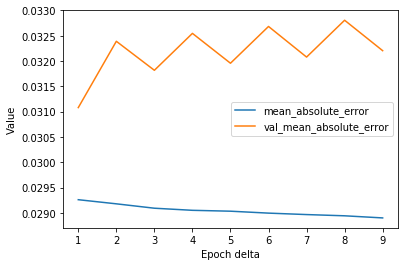

In [40]:
list_of_metrics_to_plot = ['mean_absolute_error',"val_mean_absolute_error"] 
plot_curve(epochs_delta_best, hist_delta_best, list_of_metrics_to_plot,"delta")

In [32]:
best_model_delta.save("saved_Models/lambda_100_best_model_main_max_err_0_03")

INFO:tensorflow:Assets written to: saved_Models/lambda_100_best_model_main_max_err_0_03\assets
